In [2]:
# Core Python Utilities
import itertools
import warnings

# Data Handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Sklearn: Models, Evaluation, and Preprocessing
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# PyTorch: Deep Learning Framework
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Ignore warnings
warnings.filterwarnings("ignore")

# Enable inline plotting (for Jupyter notebooks only)
%matplotlib inline


In [4]:

# Load datasets
data1 = pd.read_csv('/Users/janat/Desktop/ppimic50pred/dataset/ALL_PPIS_ic50_results.csv')
data2 = pd.read_csv('/Users/janat/Desktop/ppimic50pred/dataset/ChEMBL_PPIs_new_ic50_results.csv', sep="\t")

# Remove overlapping ChEMBL IDs
common_ids = set(data1['chembl_id']).intersection(data2['chembl_id'])
data1_unique = data1[~data1['chembl_id'].isin(common_ids)]
data2_unique = data2[~data2['chembl_id'].isin(common_ids)]

# Combine and clean
combined_data = pd.concat([data1_unique, data2_unique], ignore_index=True)
combined_data = combined_data[
    combined_data['ic50_value'].notna() &
    (combined_data['ic50_value'].astype(str).str.strip() != "")
]

# Convert to numeric and remove invalid IC50s
combined_data['ic50_value'] = pd.to_numeric(combined_data['ic50_value'], errors='coerce')
combined_data = combined_data[combined_data['ic50_value'] > 0]

# Compute log(IC50)
combined_data['log_ic50'] = np.log10(combined_data['ic50_value'])

combined_data


chembl_id  ic50_value units  pchembl_value target_chembl_id  \
0        CHEMBL7976      1410.0    nM           5.85       CHEMBL2039   
1     CHEMBL1094278       300.0    nM           6.52     CHEMBL614361   
2     CHEMBL1097571       230.0    nM           6.64     CHEMBL614361   
3      CHEMBL121516        30.0    nM           7.52        CHEMBL387   
4     CHEMBL1236726       190.0    nM           6.72       CHEMBL5023   
...             ...         ...   ...            ...              ...   
3449  CHEMBL1200969         4.0    nM           8.40       CHEMBL1787   
3450  CHEMBL2311933       100.0    nM           7.00    CHEMBL3885518   
3451  CHEMBL2311967        90.0    nM           7.05    CHEMBL3885518   
3452  CHEMBL3235901      1400.0    nM           5.85    CHEMBL3414417   
3453  CHEMBL4446667       770.0    nM           6.11    CHEMBL4105786   

                                            target_name assay_chembl_id  \
0                                   Monoamine oxidase B   CHEMBL1003729   
1                                                  T47D   CHEMBL1109973   
2                                                  T47D   CHEMBL1109973   
3                                                  MCF7   CHEMBL1109970   
4                             p53-binding protein Mdm-2   CHEMBL3391053   
...                                                 ...             ...   
3449                        Steroid 5-alpha-reductase 1   CHEMBL4371136   
3450  Aryl hydrocarbon receptor nuclear translocator...   CHEMBL2319602   
3451  Aryl hydrocarbon receptor nuclear translocator...   CHEMBL2319602   
3452                   Histone acetyltransferase RTT109   CHEMBL3419139   
3453                          B-cell lymphoma 6 protein   CHEMBL4380816   

     activity_comment  log_ic50  
0                 NaN  3.149219  
1                 NaN  2.477121  
2                 NaN  2.361728  
3                 NaN  1.477121  
4                 NaN  2.278754  
...               ...       ...  
3449              NaN  0.602060  
3450              NaN  2.000000  
3451              NaN  1.954243  
3452              NaN  3.146128  
3453              NaN  2.886491  

[3454 rows x 9 columns]

## RDKit Descriptor

In [7]:
# Load RDKit descriptor data
rdkit_data = pd.read_csv('/Users/janat/Desktop/ppimic50pred/dataset/chembl_rdkit_descriptors.csv')

# Merge with IC50 data
merged_df_rdkit = pd.merge(
    rdkit_data,
    combined_data[['chembl_id', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name']],
    on='chembl_id',
    how='inner'
)

merged_df_rdkit


MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex  \
0             11.731188       11.731188           0.031901        0.031901   
1              8.541096        8.541096           0.220764        0.220764   
2              5.342645        5.342645           1.026516        1.026516   
3              5.483680        5.483680           1.013018        1.013018   
4             14.436125       14.436125           0.004844       -0.004844   
...                 ...             ...                ...             ...   
3446          13.565688       13.565688           0.053522       -4.912768   
3447          13.297583       13.297583           0.006944       -0.615307   
3448          12.890514       12.890514           0.022566       -4.652088   
3449          13.029538       13.029538           0.045958       -3.817196   
3450          14.145788       14.145788           0.115808       -0.521369   

           qed        SPS    MolWt  HeavyAtomMolWt  ExactMolWt  \
0     0.556230  10.500000  208.260         196.164  208.088815   
1     0.437912   9.916667  225.404         210.284  225.031577   
2     0.358832  10.333333  265.513         242.329  265.099263   
3     0.489495  20.888889  320.574         300.414  320.050933   
4     0.178353  15.250000  629.636         591.332  628.248415   
...        ...        ...      ...             ...         ...   
3446  0.426542  37.297297  528.537         498.297  528.221148   
3447  0.585759  10.761905  308.656         302.608  308.011246   
3448  0.545055  11.666667  358.663         352.615  358.008052   
3449  0.373880  11.833333  440.550         420.390  440.097683   
3450  0.867144  20.440000  365.840         344.672  365.141866   

      NumValenceElectrons  ...  fr_thiocyan  fr_thiophene  fr_unbrch_alkane  \
0                      78  ...            0             0                 0   
1                      72  ...            0             0                 0   
2                      90  ...            0             0                 3   
3                     102  ...            0             0                 0   
4                     228  ...            0             0                 0   
...                   ...  ...          ...           ...               ...   
3446                  202  ...            0             0                 0   
3447                  106  ...            0             0                 0   
3448                  124  ...            0             0                 0   
3449                  154  ...            0             0                 0   
3450                  134  ...            0             0                 0   

      fr_urea      chembl_id  \
0           0     CHEMBL7976   
1           0  CHEMBL1094278   
2           0  CHEMBL1097571   
3           0   CHEMBL121516   
4           0  CHEMBL1236726   
...       ...            ...   
3446        0  CHEMBL1200969   
3447        0  CHEMBL2311933   
3448        0  CHEMBL2311967   
3449        0  CHEMBL3235901   
3450        0  CHEMBL4446667   

                                                 smiles  ic50_value  log_ic50  \
0                            O=C(/C=C/c1ccccc1)c1ccccc1      1410.0  3.149219   
1                                     CCN(CC)C(=S)SSCCO       300.0  2.477121   
2                                  CCCCCCSSC(=S)N(CC)CC       230.0  2.361728   
3                          S=C(SSC(=S)N1CCCCC1)N1CCCCC1        30.0  1.477121   
4     CN(C)CCCN(C)[C@H]1CCN(C(=O)c2[nH]c3cc(Cl)ccc3c...       190.0  2.278754   
...                                                 ...         ...       ...   
3446  C[C@]12C=CC(=O)N[C@@H]1CC[C@@H]1[C@@H]2CC[C@]2...         4.0  0.602060   
3447        O=[N+]([O-])c1c(Nc2cc(F)cc(Cl)c2)ccc2nonc12       100.0  2.000000   
3448  O=[N+]([O-])c1c(Nc2ccc(Cl)c(C(F)(F)F)c2)ccc2no...        90.0  1.954243   
3449  CC(C)c1ccc(S(=O)(=O)Nc2cc(Sc3nc[nH]n3)c(O)c3cc...      1400.0  3.146128   
3450  COc1ccc(Nc2nc(N3C[C@@H](C)N[C@@H](C)C3)ncc2F)

## PubChem Descriptor

In [10]:
import pandas as pd

# Step 1: Load the cleaned IC50 + metadata + mapping
mapping_dataset = pd.read_excel('/Users/janat/Desktop/ppimic50pred/dataset/dataset.xlsx')

# Ensure required columns exist
required_cols = ['chembl_id', 'pubchem_id', 'ic50_value', 'target_chembl_id', 'target_name']
missing_cols = [col for col in required_cols if col not in mapping_dataset.columns]
if missing_cols:
    raise ValueError(f"Missing columns in mapping dataset: {missing_cols}")

# Add log_ic50
mapping_dataset['log_ic50'] = pd.to_numeric(mapping_dataset['ic50_value'], errors='coerce').apply(lambda x: np.log10(x) if pd.notna(x) and x > 0 else None)
mapping_dataset = mapping_dataset.dropna(subset=['log_ic50'])

# Keep only first unique pubchem_id
pubchem_info = mapping_dataset[['pubchem_id', 'chembl_id', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name']].drop_duplicates(subset='pubchem_id', keep='first')

# Step 2: Load PubChem descriptor data
pubchem_desc = pd.read_csv('/Users/janat/Desktop/ppimic50pred/dataset/full_pubchem_output.csv')
pubchem_desc = pubchem_desc.drop_duplicates(subset='CID', keep='first')

# Step 3: Merge PubChem descriptors with mapped IC50 info (CID ↔ pubchem_id)
merged_df_pubchem = pd.merge(
    pubchem_desc,
    pubchem_info,
    left_on='CID',
    right_on='pubchem_id',
    how='inner'
).drop(columns=['pubchem_id'])

print("✅ Final merged_df_pubchem shape:", merged_df_pubchem.shape)
merged_df_pubchem

✅ Final merged_df_pubchem shape: (3444, 23)


CID      MW  XLogP3  HBDC  HDAC  RBC   ExactMass    MonoMass  \
0        637760  208.25     3.1     0     1    3  208.088815  208.088815   
1      46700806  225.40     1.4     1     4    6  225.031578  225.031578   
2      46700805  265.50     4.4     0     3    9  265.099263  265.099263   
3          7188  320.60     3.4     0     4    3  320.050933  320.050933   
4      24969086  629.60     6.7     1     4   10  628.248415  628.248415   
...         ...     ...     ...   ...   ...  ...         ...         ...   
3439    6918296  528.50     5.4     2     8    2  528.221147  528.221147   
3440   70697712  308.65     3.8     1     7    2  308.011246  308.011246   
3441    2842377  358.66     4.6     1     9    2  358.008052  358.008052   
3442    2133805  440.50     4.9     3     7    6  440.097683  440.097683   
3443  155518808  365.80     3.4     2     7    4  365.141866  365.141866   

       TPSA  HAC  ...  DASC  UASC  DBSC  UBSC  CBU      chembl_id  ic50_value  \
0      17.1   16  ...     0     0     1     0    1     CHEMBL7976      1410.0   
1     106.0   12  ...     0     0     0     0    1  CHEMBL1094278       300.0   
2      85.9   15  ...     0     0     0     0    1  CHEMBL1097571       230.0   
3     121.0   18  ...     0     0     0     0    1   CHEMBL121516        30.0   
4      60.4   44  ...     1     0     0     0    1  CHEMBL1236726       190.0   
...     ...  ...  ...   ...   ...   ...   ...  ...            ...         ...   
3439   58.2   37  ...     7     0     0     0    1  CHEMBL1200969         4.0   
3440   96.8   21  ...     0     0     0     0    1  CHEMBL2311933       100.0   
3441   96.8   24  ...     0     0     0     0    1  CHEMBL2311967        90.0   
3442  142.0   30  ...     0     0     0     0    1  CHEMBL3235901      1400.0   
3443   62.3   25  ...     2     0     0     0    1  CHEMBL4446667       770.0   

      log_ic50 target_chembl_id  \
0     3.149219       CHEMBL2039   
1     2.477121     CHEMBL614361   
2     2.361728     CHEMBL614361   
3     1.477121        CHEMBL387   
4     2.278754       CHEMBL5023   
...        ...              ...   
3439  0.602060       CHEMBL1787   
3440  2.000000    CHEMBL3885518   
3441  1.954243    CHEMBL3885518   
3442  3.146128    CHEMBL3414417   
3443  2.886491    CHEMBL4105786   

                                            target_name  
0                                   Monoamine oxidase B  
1                                                  T47D  
2                                                  T47D  
3                                                  MCF7  
4                             p53-binding protein Mdm-2  
...                                                 ...  
3439                        Steroid 5-alpha-reductase 1  
3440  Aryl hydrocarbon receptor nuclear translocator...  
3441  Aryl hydrocarbon receptor nuclear translocator...  
3442                   Histone acetyltransferase RTT109  
3443                          B-cell lymphoma 6 protein  

[3444 rows x 23 columns]

## PaDEL Descriptor

In [13]:
# Load PaDEL-descriptor data
#The software currently calculates 1875 descriptors (1444 1D, 2D descriptors and 431 3D descriptors) 
padel_data = pd.read_csv('/Users/janat/Desktop/ppimic50pred/dataset/Padel_descriptor.csv')

# Extract final IC50 + metadata from PubChem-merged result
padel_ic50 = merged_df_pubchem[['CID', 'chembl_id', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name']]
padel_ic50_unique = padel_ic50.drop_duplicates(subset='CID', keep='first')

# Merge PADEL on Name (same as CID)
merged_df_padel = pd.merge(
    padel_data,
    padel_ic50_unique,
    left_on='Name',
    right_on='CID',
    how='inner'
).drop(columns=['CID'])

merged_df_padel


Name  nAcid   ALogP    ALogp2       AMR       apol  naAromAtom  \
0           811      2  0.0671  0.004502   27.9149  16.008758           0   
1          1110      2 -0.4100  0.168100   23.5370  14.248758           0   
2          1983      0 -0.2314  0.053546   44.7549  22.785137           6   
3          2259      3  0.6249  0.390500  114.4665  55.273102           0   
4          2333      0  1.4819  2.196028   99.6746  46.427516           0   
...         ...    ...     ...       ...       ...        ...         ...   
2921  172465382      0  1.7263  2.980112  137.1516  66.582653           0   
2922  172467441      1  1.2620  1.592644  146.5647  70.445274           0   
2923  172468432      0  0.6934  0.480804  122.5689  64.396239           0   
2924  172468926      2 -2.5166  6.333276  139.0980  69.040653           0   
2925  172471290      1  0.6539  0.427585  127.4106  65.521653           0   

      nAromBond  nAtom  nHeavyAtom  ...         Ts          As          Vs  \
0             0     15           9  ...   6.399732    7.830642   14.810332   
1             0     14           8  ...   6.025117    5.529483   12.312929   
2             6     20          11  ...   8.920007   12.727717   25.337999   
3             0     45          31  ...  18.633544  102.834273  277.835978   
4             0     34          22  ...  14.048063   51.655693  107.462124   
...         ...    ...         ...  ...        ...         ...         ...   
2921          0     55          34  ...  27.733922  169.817591  380.819133   
2922          0     57          39  ...  29.379851  205.511883  493.020547   
2923          0     55          32  ...  26.462041  143.801164  309.854220   
2924          0     57          36  ...  20.025451  112.390718  272.351175   
2925          0     56          35  ...  27.433477  176.050965  435.621833   

            Ks        Ds      chembl_id  ic50_value  log_ic50  \
0     0.622780  1.073624   CHEMBL359159     29400.0  4.468347   
1     0.728858  1.290113      CHEMBL576         1.3  0.113943   
2     0.715850  1.310099      CHEMBL112      2300.0  3.361728   
3     0.298418  1.357003   CHEMBL275938        12.0  1.079181   
4     0.419801  1.098138   CHEMBL388590        16.0  1.204120   
...        ...       ...            ...         ...       ...   
2921  0.555319  1.488703  CHEMBL5426754      5690.0  3.755112   
2922  0.497470  1.501161  CHEMBL5435549       190.0  2.278754   
2923  0.601459  1.444163  CHEMBL5435031      3830.0  3.583199   
2924  0.370047  1.437387  CHEMBL5438828       890.0  2.949390   
2925  0.520817  1.570948  CHEMBL5440333       640.0  2.806180   

      target_chembl_id                      target_name  
0        CHEMBL4295587               Isocitrate lyase 1  
1            CHEMBL391                             Vero  
2        CHEMBL2406892                        Myoglobin  
3        CHEMBL1075138  Tyrosyl-DNA phosphodiesterase 1  
4           CHEMBL3397              Cytochrome P450 2C9  
...                ...                              ...  
2921     CHEMBL5465553                         WDR5-MYC  
2922     CHEMBL5465553                         WDR5-MYC  
2923     CHEMBL5465553                         WDR5-MYC  
2924     CHEMBL3038498                       Keap1/Nrf2  
2925     CHEMBL5465553                         WDR5-MYC  

[2926 rows x 1881 columns]

In [14]:
unique_targets_padel = merged_df_padel['target_name'].nunique()
unique_targets_rdkit = merged_df_rdkit['target_name'].nunique()
unique_targets_pubchem = merged_df_pubchem['target_name'].nunique()

print("Number of unique target_name entries:")
print(f"  PaDEL:   {unique_targets_padel}")
print(f"  RDKit:   {unique_targets_rdkit}")
print(f"  PubChem: {unique_targets_pubchem}")


Number of unique target_name entries:
  PaDEL:   151
  RDKit:   176
  PubChem: 175


In [17]:
from rich.console import Console
from rich.table import Table

console = Console()

# Compute presence sets
padel_targets = set(merged_df_padel['target_name'].unique())
rdkit_targets = set(merged_df_rdkit['target_name'].unique())
pubchem_targets = set(merged_df_pubchem['target_name'].unique())

# Compute unique chembl_id counts per target_name for each dataset
padel_counts = merged_df_padel.groupby('target_name')['chembl_id'].nunique().to_dict()
rdkit_counts = merged_df_rdkit.groupby('target_name')['chembl_id'].nunique().to_dict()
pubchem_counts = merged_df_pubchem.groupby('target_name')['chembl_id'].nunique().to_dict()

all_targets = sorted(padel_targets | rdkit_targets | pubchem_targets)

def style_mark(present):
    return "[green]✓[/green]" if present else "[red]×[/red]"

table = Table(title="")

# Add columns: presence and counts side-by-side
table.add_column("target_name", style="bold")
table.add_column("PaDEL")
table.add_column("PaDEL Count", justify="right")
table.add_column("RDKit")
table.add_column("RDKit Count", justify="right")
table.add_column("PubChem")
table.add_column("PubChem Count", justify="right")

for target in all_targets:
    padel_present = target in padel_targets
    rdkit_present = target in rdkit_targets
    pubchem_present = target in pubchem_targets

    table.add_row(
        target,
        style_mark(padel_present),
        str(padel_counts.get(target, 0)) if padel_present else "-",
        style_mark(rdkit_present),
        str(rdkit_counts.get(target, 0)) if rdkit_present else "-",
        style_mark(pubchem_present),
        str(pubchem_counts.get(target, 0)) if pubchem_present else "-",
    )

console.print(table)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ target_name                               ┃ PaDEL ┃ PaDEL Count ┃ RDKit ┃ RDKit Count ┃ PubChem ┃ PubChem Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ A549                                      │ ✓     │          15 │ ✓     │          15 │ ✓       │            15 │
│ ACHN                                      │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ Acetylcholinesterase                      │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ Acyl coenzyme A:cholesterol               │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ acyltransferase 1                         │       │             │       │             │         │               │
│ Androgen receptor/PELP1                   │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ Apoptosis regulator Bcl-2                 │ ✓     │          64 │ ✓     │         122 │ ✓       │           124 │
│ Apoptosis regulator Bcl-W                 │ ✓     │           3 │ ✓     │           3 │ ✓       │             3 │
│ Apoptosis regulator Bcl-X                 │ ✓     │         124 │ ✓     │         212 │ ✓       │           212 │
│ Apoptotic protease-activating factor 1    │ ✓     │           2 │ ✓     │           2 │ ✓       │             2 │
│ Arachidonate 12-lipoxygenase              │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ Aryl hydrocarbon receptor nuclear         │ ✓     │          53 │ ✓     │          53 │ ✓       │            53 │
│ translocator/Endothelial PAS              │       │             │       │             │         │               │
│ domain-containing protein 1               │       │             │       │             │         │               │
│ B-cell lymphoma 6 protein                 │ ✓     │          35 │ ✓     │          35 │ ✓       │            35 │
│ BACH1/MafK                                │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ BCL-6/NCOR2                               │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ BCoR-BCL6                                 │ ✓     │          15 │ ✓     │          15 │ ✓       │            15 │
│ Bcl-2-related protein A1                  │ ✓     │           5 │ ✓     │           5 │ ✓       │             5 │
│ Bcl-xL/Bcl-2-binding component 3          │ ×     │           - │ ✓     │           1 │ ✓       │             1 │
│ Bcl2-antagonist of cell death (BAD)       │ ✓     │           2 │ ✓     │           3 │ ✓       │             3 │
│ Beta Lactamase                            │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ Bromodomain adjacent to zinc finger       │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ domain protein 2A                         │       │             │       │             │         │               │
│ Bromodomain adjacent to zinc finger       │ ✓     │           2 │ ✓     │           2 │ ✓       │             2 │
│ domain protein 2B                         │       │             │       │             │         │               │
│ Bromodomain-containing protein 2          │ ✓     │          17 │ ✓     │          17 │ ✓       │            17 │
│ Bromodomain-containing protein 3          │ ✓     │          31 │ ✓     │          31 │ ✓       │            31 │
│ Bromodomain-containing protein 4          │ ✓     │          10 │ ✓     │          10 │ ✓       │            10 │
│ CBP/beta catenin                          │ ✓     │           1 │ ✓     │           1 │ ✓       │             1 │
│ CD40-CD40L                                │ ✓     │           5 │ ✓     │           6 │ ✓       │             6 │
│ CRBN/EZH2                                 │ ×     │   

## Comparison table save to word file

In [20]:
from docx import Document
from docx.shared import Pt
from docx.enum.text import WD_ALIGN_PARAGRAPH

# Prepare data as before
padel_targets = set(merged_df_padel['target_name'].unique())
rdkit_targets = set(merged_df_rdkit['target_name'].unique())
pubchem_targets = set(merged_df_pubchem['target_name'].unique())

padel_counts = merged_df_padel.groupby('target_name')['chembl_id'].nunique().to_dict()
rdkit_counts = merged_df_rdkit.groupby('target_name')['chembl_id'].nunique().to_dict()
pubchem_counts = merged_df_pubchem.groupby('target_name')['chembl_id'].nunique().to_dict()

all_targets = sorted(padel_targets | rdkit_targets | pubchem_targets)

def presence_mark(present):
    return "✓" if present else "×"

# Create a Word document
doc = Document()

doc.add_heading('Target Name Comparison with ChEMBL Counts', level=1)

# Add a table: columns = target_name + 6 (PaDEL presence/count, RDKit presence/count, PubChem presence/count)
table = doc.add_table(rows=1, cols=7)
table.style = 'Light List Accent 1'

hdr_cells = table.rows[0].cells
hdr_cells[0].text = 'Target Name'
hdr_cells[1].text = 'PaDEL'
hdr_cells[2].text = 'PaDEL Count'
hdr_cells[3].text = 'RDKit'
hdr_cells[4].text = 'RDKit Count'
hdr_cells[5].text = 'PubChem'
hdr_cells[6].text = 'PubChem Count'

for target in all_targets:
    row_cells = table.add_row().cells
    row_cells[0].text = target

    padel_present = target in padel_targets
    rdkit_present = target in rdkit_targets
    pubchem_present = target in pubchem_targets

    row_cells[1].text = presence_mark(padel_present)
    row_cells[2].text = str(padel_counts.get(target, 0)) if padel_present else '-'

    row_cells[3].text = presence_mark(rdkit_present)
    row_cells[4].text = str(rdkit_counts.get(target, 0)) if rdkit_present else '-'

    row_cells[5].text = presence_mark(pubchem_present)
    row_cells[6].text = str(pubchem_counts.get(target, 0)) if pubchem_present else '-'

# Optional: adjust font size for all cells
for row in table.rows:
    for cell in row.cells:
        for paragraph in cell.paragraphs:
            for run in paragraph.runs:
                run.font.size = Pt(10)

# Save the document
doc.save('/Users/janat/Desktop/ppimic50pred/target_name_comparison.docx')
print("Saved comparison table as 'target_name_comparison.docx'")


Saved comparison table as 'target_name_comparison.docx'


## Dataset: Training and Blindset for RDkit, PubChem, & PaDEL

In [23]:
def split_full_dataset(df, descriptor_name="DescriptorSet"):
    """
    Splits the entire dataset (with all columns) into 80% training and 20% blind sets.

    Parameters:
    - df: pandas DataFrame to split
    - descriptor_name: descriptor set name for logging

    Returns:
    - train_df: 80% of the original DataFrame
    - blind_df: 20% of the original DataFrame
    """
    train_df, blind_df = train_test_split(df, test_size=0.20, random_state=42)

    print(f"📊 {descriptor_name} Split (All Columns Kept):")
    print(f"  Training Set: {train_df.shape}")
    print(f"  Blind Set:    {blind_df.shape}\n")

    return train_df, blind_df


In [25]:
# RDKit
rdkit_train, rdkit_blind = split_full_dataset(merged_df_rdkit, descriptor_name="RDKit")
# PubChem
pubchem_train, pubchem_blind = split_full_dataset(merged_df_pubchem, descriptor_name="PubChem")
# PaDEL
padel_train, padel_blind = split_full_dataset(merged_df_padel, descriptor_name="PaDEL")


📊 RDKit Split (All Columns Kept):
  Training Set: (2760, 223)
  Blind Set:    (691, 223)

📊 PubChem Split (All Columns Kept):
  Training Set: (2755, 23)
  Blind Set:    (689, 23)

📊 PaDEL Split (All Columns Kept):
  Training Set: (2340, 1881)
  Blind Set:    (586, 1881)



## RDKit Model Development 

In [28]:
# Print all column names
print("🧾 RDKit Training Columns:")
print(rdkit_train.columns.tolist())

# Count total columns
total_columns = len(rdkit_train.columns)
print(f"\n🔢 Total columns: {total_columns}")

🧾 RDKit Training Columns:
['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW', 'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'Slog

## Feature Selection: Feature correlations (Unsupervised)

Feature count after cleaning: 217
Zero variance columns count: 15
Zero variance columns: ['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'fr_aldehyde', 'fr_azide', 'fr_barbitur', 'fr_benzodiazepine', 'fr_diazo', 'fr_epoxide', 'fr_isocyan', 'fr_lactam', 'fr_nitroso', 'fr_prisulfonamd', 'fr_quatN', 'fr_thiocyan']
Final features used for plotting: 202

Significant features (|correlation| >= 0.5 with log_ic50):
Correlation matrix shape: (202, 202)


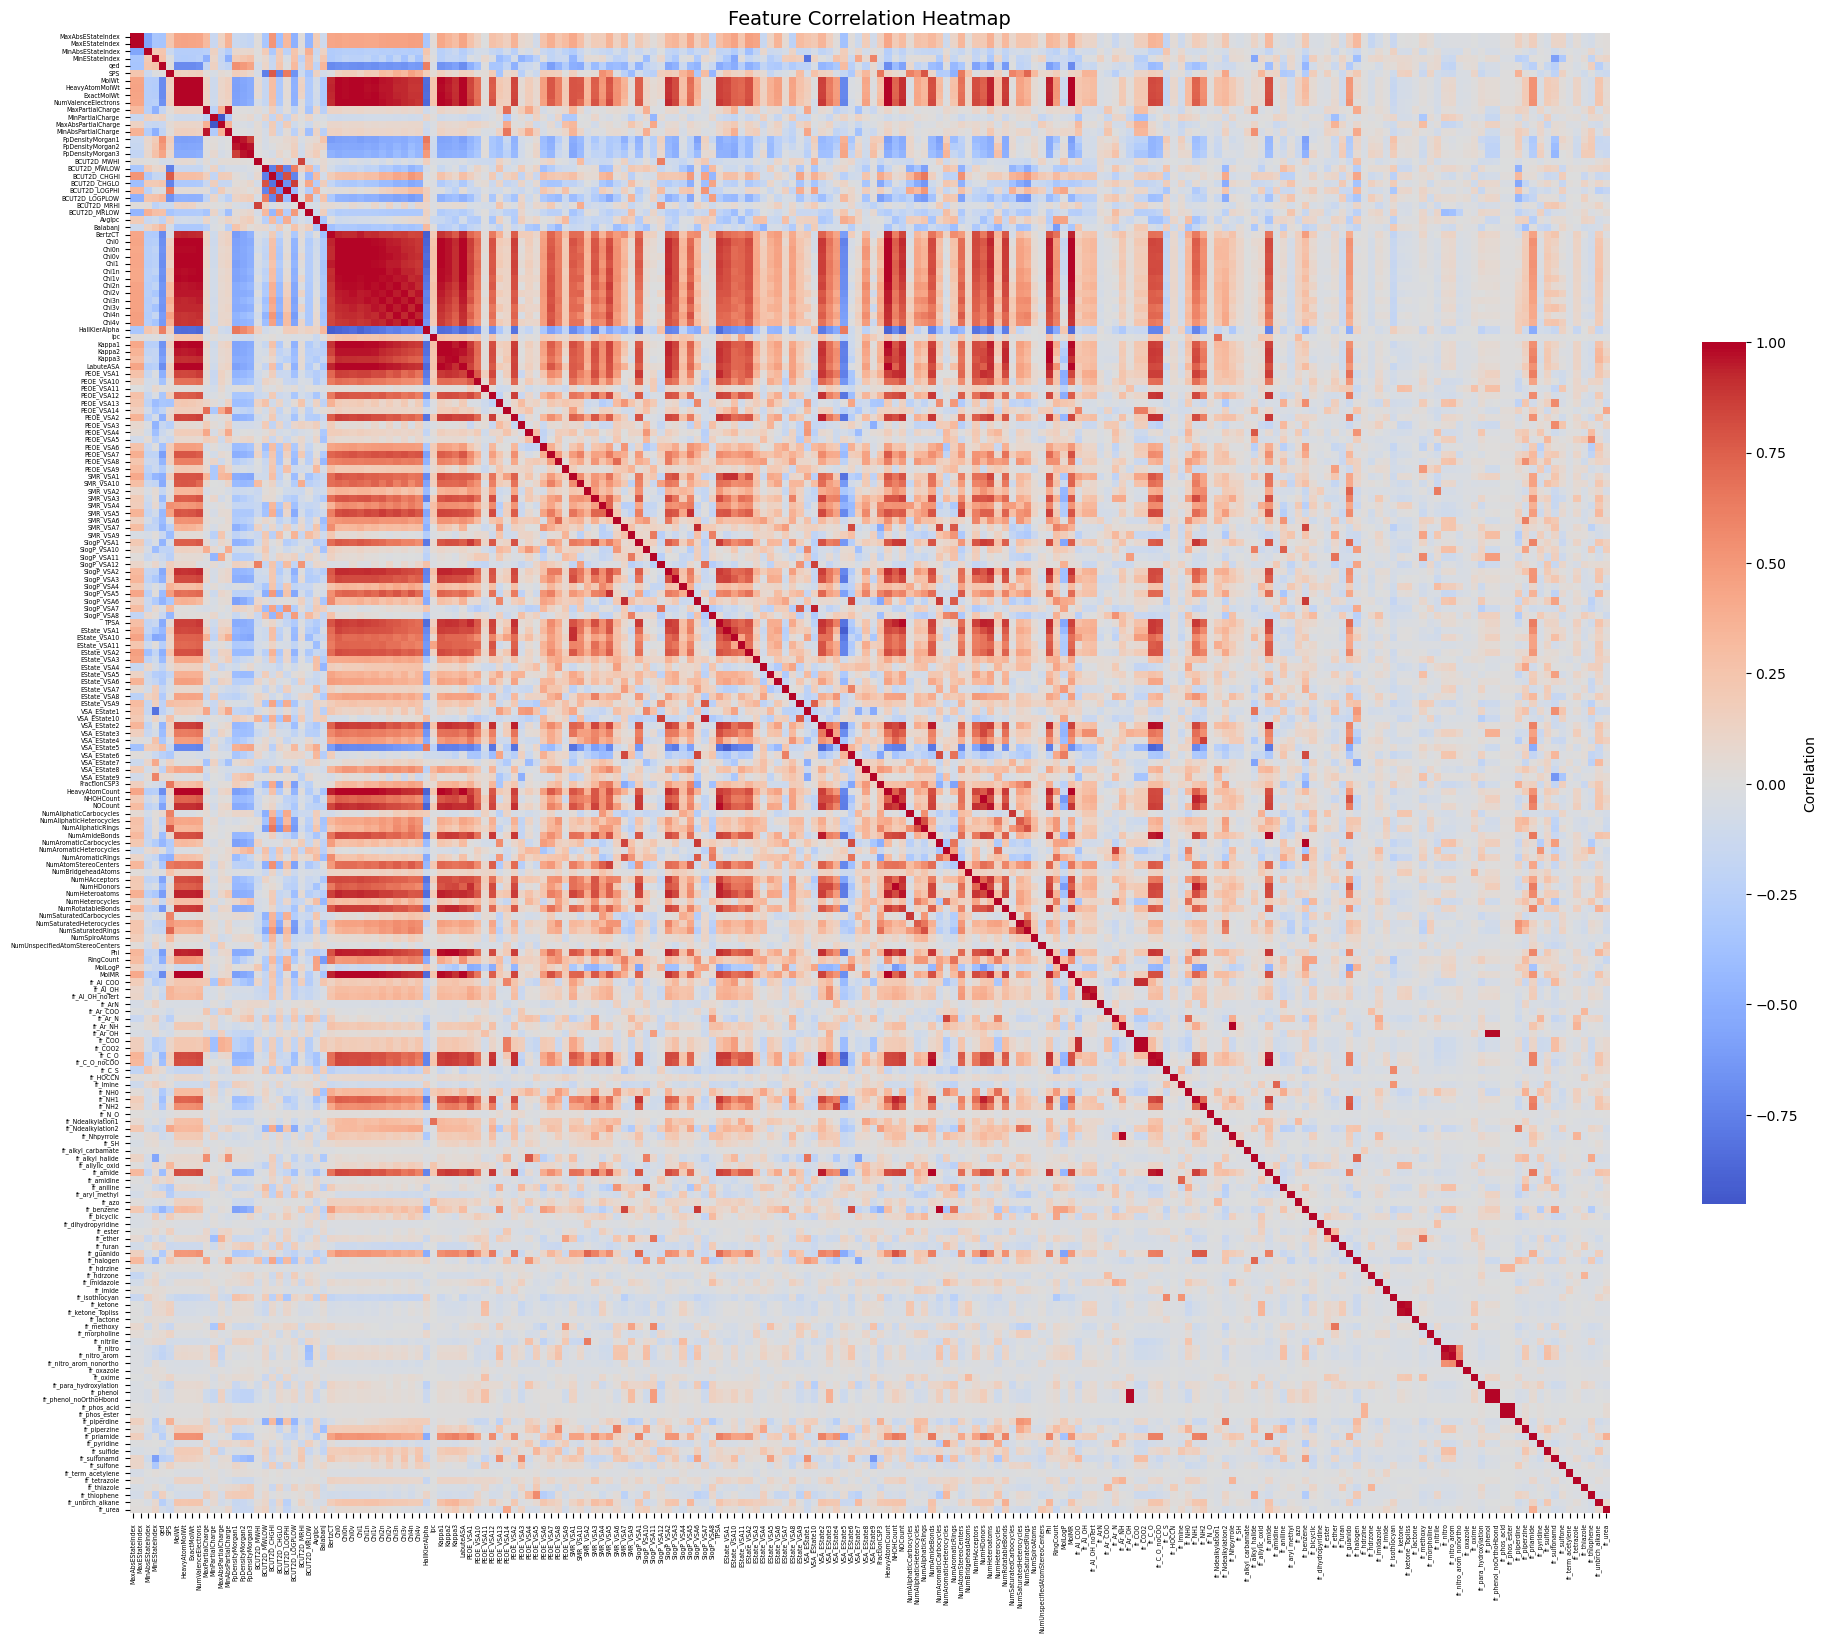

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Step 1: Prepare the features
# ============================
y = rdkit_train['log_ic50']

drop_cols = ['chembl_id', 'smiles', 'ic50_value', 'log_ic50', 
             'target_chembl_id', 'target_name']
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])

# Replace blanks with NaN
X = X.replace(r'^\s*$', np.nan, regex=True)

# Convert to numeric (coerce errors to NaN)
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Fill NaN with column means
X = X.fillna(X.mean())

print(f"Feature count after cleaning: {X.shape[1]}")

# Identify zero-variance columns
zero_var_cols = X.columns[X.var() == 0]
print(f"Zero variance columns count: {len(zero_var_cols)}")
print(f"Zero variance columns: {list(zero_var_cols)}")

# Remove zero-variance columns for plotting
X_plot = X.drop(columns=zero_var_cols)
print(f"Final features used for plotting: {X_plot.shape[1]}")

# =======================================
# Step 2: Identify significant features
# =======================================
corr_with_target = X_plot.corrwith(y)
significant_features = corr_with_target[abs(corr_with_target) >= 0.5]  # threshold adjustable
significant_features = significant_features.sort_values(key=lambda x: abs(x), ascending=False)

print("\nSignificant features (|correlation| >= 0.5 with log_ic50):")
for feat, corr_val in significant_features.items():
    print(f"{feat}: {corr_val:.3f}")

# =======================================
# Step 3: Compute correlation matrix
# =======================================
corr_matrix = X_plot.corr(min_periods=1)
print(f"Correlation matrix shape: {corr_matrix.shape}")

# Save full correlation matrix to CSV
corr_matrix.to_csv("/Users/janat/Desktop/ppimic50pred/feature_correlation_matrix_filtered.csv")

# ============================
# Step 4: Plot the heatmap (all ticks, small font)
# ============================
fig, ax = plt.subplots(figsize=(20, 18))  # Large figure to accommodate many labels

sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    annot=False,
    fmt=".2f",
    cbar_kws={'label': 'Correlation', 'shrink': 0.5},
    square=True,
    ax=ax
)

# Show all tick labels with very small font and rotated x labels
ax.set_xticks(np.arange(len(corr_matrix.columns)) + 0.5)
ax.set_xticklabels(corr_matrix.columns, rotation=90, fontsize=4.4, ha='center')

ax.set_yticks(np.arange(len(corr_matrix.index)) + 0.5)
ax.set_yticklabels(corr_matrix.index, rotation=0, fontsize=4.4)

ax.set_title("Feature Correlation Heatmap", fontsize=14)

plt.tight_layout()

# Save the heatmap to a high resolution file
plt.savefig("/Users/janat/Desktop/ppimic50pred/feature_correlation_heatmap_full_ticks.png", dpi=300, bbox_inches='tight')

plt.show()


In [32]:
corr_matrix

MaxAbsEStateIndex  MaxEStateIndex  MinAbsEStateIndex  \
MaxAbsEStateIndex           1.000000        1.000000          -0.559066   
MaxEStateIndex              1.000000        1.000000          -0.559066   
MinAbsEStateIndex          -0.559066       -0.559066           1.000000   
MinEStateIndex             -0.338294       -0.338294           0.207931   
qed                        -0.347496       -0.347496           0.241266   
...                              ...             ...                ...   
fr_tetrazole                0.044134        0.044134          -0.026917   
fr_thiazole                -0.050806       -0.050806          -0.011413   
fr_thiophene               -0.067882       -0.067882           0.092516   
fr_unbrch_alkane            0.011521        0.011521          -0.037938   
fr_urea                     0.017483        0.017483           0.030824   

                   MinEStateIndex       qed       SPS     MolWt  \
MaxAbsEStateIndex       -0.338294 -0.347496  0.239793  0.441315   
MaxEStateIndex          -0.338294 -0.347496  0.239793  0.441315   
MinAbsEStateIndex        0.207931  0.241266 -0.129251 -0.261840   
MinEStateIndex           1.000000  0.267902 -0.012741 -0.269907   
qed                      0.267902  1.000000  0.012332 -0.693489   
...                           ...       ...       ...       ...   
fr_tetrazole            -0.015371 -0.051802 -0.034290  0.120868   
fr_thiazole              0.052839 -0.002293 -0.098514 -0.040058   
fr_thiophene            -0.194450  0.156400 -0.001544 -0.076748   
fr_unbrch_alkane         0.079989 -0.256958 -0.103642  0.246375   
fr_urea                  0.111741 -0.068763 -0.126248  0.062470   

                   HeavyAtomMolWt  ExactMolWt  NumValenceElectrons  ...  \
MaxAbsEStateIndex        0.445334    0.441088             0.433240  ...   
MaxEStateIndex           0.445334    0.441088             0.433240  ...   
MinAbsEStateIndex       -0.265135   -0.261725            -0.261134  ...   
MinEStateIndex          -0.279977   -0.270075            -0.250547  ...   
qed                     -0.697765   -0.693409            -0.672402  ...   
...                           ...         ...                  ...  ...   
fr_tetrazole             0.122782    0.120938             0.121677  ...   
fr_thiazole             -0.037312   -0.039910            -0.045286  ...   
fr_thiophene            -0.074920   -0.076423            -0.074294  ...   
fr_unbrch_alkane         0.240140    0.246496             0.251987  ...   
fr_urea                  0.060604    0.062264             0.055286  ...   

                   fr_pyridine  fr_sulfide  fr_sulfonamd  fr_sulfone  \
MaxAbsEStateIndex    -0.011651   -0.050506      0.113055    0.110933   
MaxEStateIndex       -0.011651   -0.050506      0.113055    0.110933   
MinAbsEStateIndex     0.008361   -0.021724     -0.102624   -0.033824   
MinEStateIndex       -0.001183   -0.009443     -0.590127   -0.306641   
qed                   0.013057   -0.158715     -0.238426    0.017479   
...                        ...         ...           ...         ...   
fr_tetrazole         -0.035813   -0.030585      0.077976   -0.024088   
fr_thiazole           0.029065   -0.035072     -0.059431    0.016223   
fr_thiophene         -0.001997   -0.019047     -0.099957    0.055068   
fr_unbrch_alkane     -0.075828    0.216716     -0.031852   -0.035772   
fr_urea              -0.008721   -0.009759     -0.081612   -0.053202   

                   fr_term_acetylene  fr_tetrazole  fr_thiazole  fr_thiophene  \
MaxAbsEStateIndex          -0.058662      0.044134    -0.050806     -0.067882   
MaxEStateIndex             -0.058662      0.044134    -0.050806     -0.067882   
MinAbsEStateIndex          -0.003107     -0.026917    -0.011413      0.092516   
MinEStateIndex              0.028063     -0.015371     0.052839     -0.194450   
qed                         0.003872     -0.051802    -0.002293      0.156400   
...                              ...           ...          .

## Tunning Parameters of Random Forest using 10-fold Cross Validation

In [36]:
import numpy as np
import pandas as pd
import warnings
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# Suppress specific RuntimeWarnings
warnings.filterwarnings("ignore", message=re.escape("overflow encountered in cast"), category=RuntimeWarning)

# Define custom RMSE scorer
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

neg_rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Prepare the data
y = rdkit_train['log_ic50']
drop_cols = ['chembl_id', 'smiles', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name']
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])

X = X.replace(r'^\s*$', np.nan, regex=True)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.clip(upper=1e6, lower=-1e6)
X = X.fillna(X.mean())

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define model and hyperparameter grid
rf = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

# Grid Search
rf_grid_search = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring=neg_rmse_scorer,
    cv=10,
    n_jobs=-1,
    verbose=2
)

rf_grid_search.fit(X_train, y_train)

# Store best parameters
rf_best_params = rf_grid_search.best_params_

# Results
print("Random Forest Best Parameters:")
print(rf_best_params)


# Print best score (convert from negative RMSE to positive RMSE)
best_neg_rmse = rf_grid_search.best_score_
best_rmse = -best_neg_rmse  # since we used negative RMSE as scorer

print(f"Best RMSE Score (10-fold CV): {best_rmse:.4f}")



Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Random Forest Best Parameters:
{'max_depth': None, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best RMSE Score (10-fold CV): 0.7954


## Tunning Parameters of LSTM deep learning

In [38]:
import itertools
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore", message="overflow encountered*", category=RuntimeWarning)

# Define LSTM model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1, activation_fn=nn.ReLU()):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.activation = activation_fn

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc(out)
        out = self.activation(out)
        return out

# Training function
def train_model(model, train_loader, val_loader, epochs=50, patience=7, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_loss = float('inf')
    patience_counter = 0
    best_state = None

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb)
                loss = criterion(preds, yb)
                val_losses.append(loss.item())

        avg_val_loss = np.mean(val_losses)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return model, best_val_loss

# Prepare data
y = rdkit_train['log_ic50']
drop_cols = ['chembl_id', 'smiles', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name']
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])

X = X.replace(r'^\s*$', np.nan, regex=True)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

X_train_seq = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_val_seq = X_val_scaled.reshape(X_val_scaled.shape[0], 1, X_val_scaled.shape[1])

X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)

train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)

# Hyperparameter search
activation_functions = {
    'relu': nn.ReLU(),
    'tanh': nn.Tanh(),
    'sigmoid': nn.Sigmoid(),
    'leaky_relu': nn.LeakyReLU()
}

lstm_param_grid = {
    'hidden_size': [32, 64, 128],
    'num_layers': [1, 2],
    'learning_rate': [1e-3, 5e-4],
    'batch_size': [32, 64],
    'activation': list(activation_functions.keys())
}

lstm_results = []

for hidden_size, num_layers, lr, batch_size, act_name in itertools.product(
    lstm_param_grid['hidden_size'],
    lstm_param_grid['num_layers'],
    lstm_param_grid['learning_rate'],
    lstm_param_grid['batch_size'],
    lstm_param_grid['activation']
):
    print(f"\nTraining: hidden_size={hidden_size}, num_layers={num_layers}, lr={lr}, "
          f"batch_size={batch_size}, activation={act_name}")

    activation_fn = activation_functions[act_name]
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = LSTMRegressor(
        input_size=X_train_tensor.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        activation_fn=activation_fn
    )

    model, val_loss = train_model(model, train_loader, val_loader, epochs=50, patience=7, lr=lr)

    model.eval()
    val_preds, val_true = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            val_preds.append(preds.cpu().numpy())
            val_true.append(yb.cpu().numpy())

    val_preds = np.vstack(val_preds).flatten()
    val_true = np.vstack(val_true).flatten()

    mse = mean_squared_error(val_true, val_preds)
    rmse = np.sqrt(mse)
    r2 = r2_score(val_true, val_preds)

    print(f"→ RMSE={rmse:.4f}, R²={r2:.4f}")

    lstm_results.append({
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': lr,
        'batch_size': batch_size,
        'activation': act_name,
        'RMSE': rmse,
        'R2': r2
    })

# Store best parameters
results_df = pd.DataFrame(lstm_results)
results_df_sorted = results_df.sort_values(by='RMSE', ascending=True)

print("\n=== LSTM Grid Search Results (sorted by RMSE) ===")
print(results_df_sorted.to_string(index=False, float_format="%.4f"))

best_row = results_df_sorted.iloc[0]
lstm_best_params = {
    'hidden_size': int(best_row['hidden_size']),
    'num_layers': int(best_row['num_layers']),
    'learning_rate': float(best_row['learning_rate']),
    'batch_size': int(best_row['batch_size']),
    'activation': best_row['activation']
}

print("\n=== Best LSTM Hyperparameters ===")
print(lstm_best_params)



Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=32, activation=relu
→ RMSE=0.8099, R²=0.7308

Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=32, activation=tanh
→ RMSE=1.9888, R²=-0.6233

Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=32, activation=sigmoid
→ RMSE=1.9940, R²=-0.6317

Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=32, activation=leaky_relu
→ RMSE=0.8322, R²=0.7157

Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=64, activation=relu
→ RMSE=0.8045, R²=0.7344

Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=64, activation=tanh
→ RMSE=1.9923, R²=-0.6289

Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=64, activation=sigmoid
→ RMSE=1.9936, R²=-0.6312

Training: hidden_size=32, num_layers=1, lr=0.001, batch_size=64, activation=leaky_relu
→ RMSE=0.8254, R²=0.7204

Training: hidden_size=32, num_layers=1, lr=0.0005, batch_size=32, activation=relu
→ RMSE=0.8106, R²=0.7304

Training: hid

## Feature Selection: Feature Importance (Supervised): RandomForestRegressor

Feature importance plot saved to: /Users/janat/Desktop/ppimic50pred/feature_importance_filtered.png


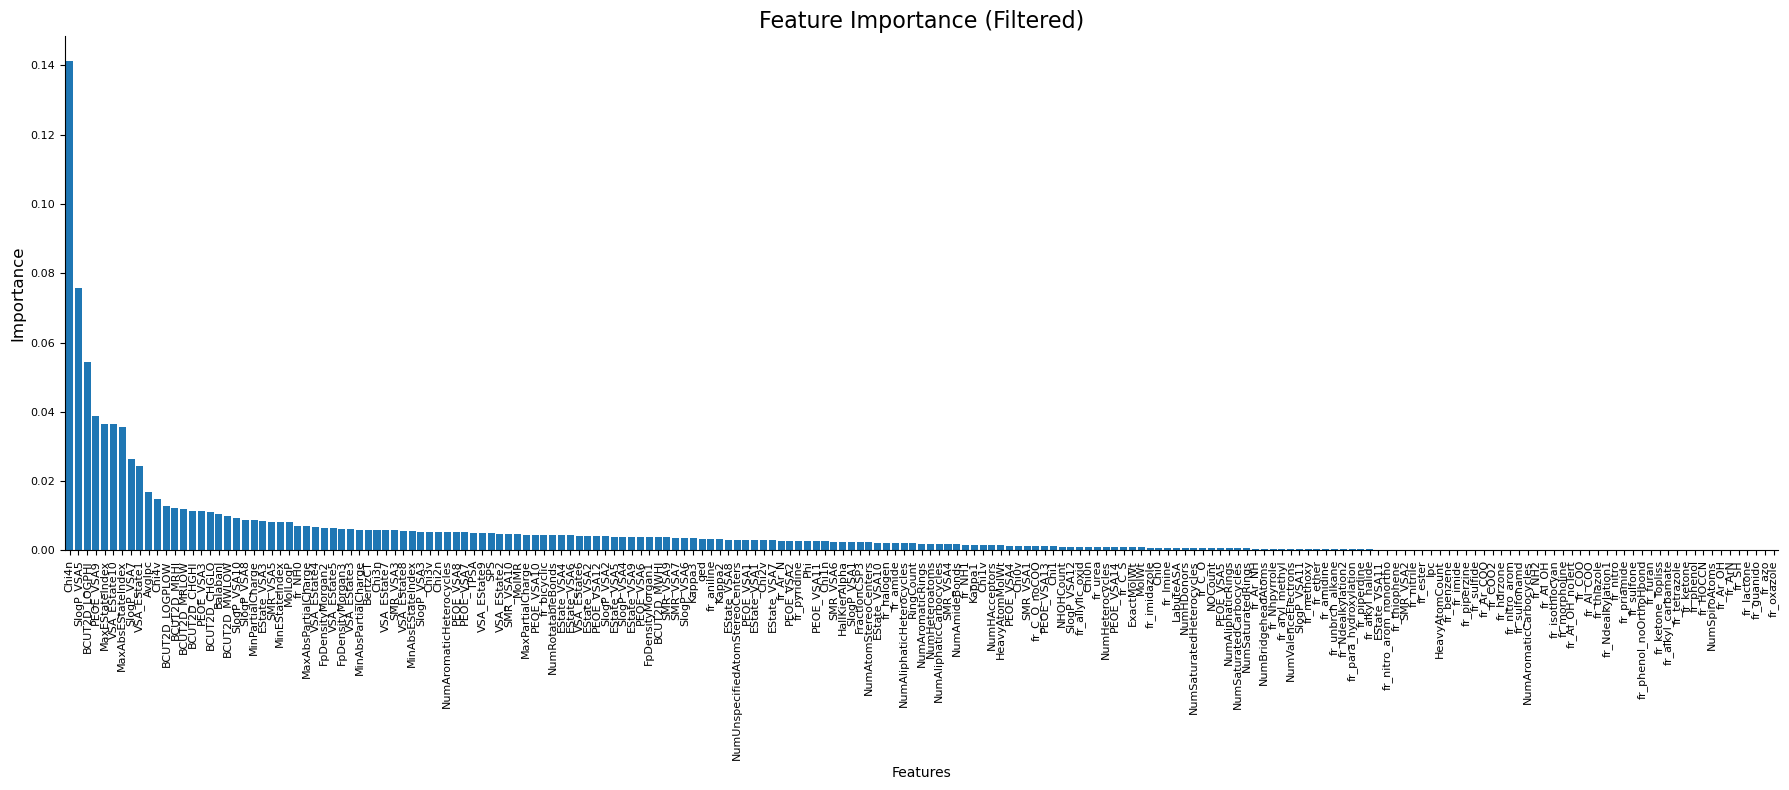

Number of filtered features: 195


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import warnings
import re

# Suppress specific RuntimeWarnings related to overflow in casting
warnings.filterwarnings(
    "ignore",
    message=re.escape("overflow encountered in cast"),
    category=RuntimeWarning,
)

# Prepare target variable
y = rdkit_train['log_ic50']

# Define columns to drop if present
drop_cols = [
    'chembl_id', 'smiles', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name'
]

# Drop unwanted columns safely
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])

# Clean and convert feature data to numeric
X = X.replace(r'^\s*$', np.nan, regex=True)  # Replace empty strings with NaN
X = X.apply(pd.to_numeric, errors='coerce')  # Coerce non-numeric to NaN
X = X.replace([np.inf, -np.inf], np.nan)     # Replace infinite values with NaN
X = X.clip(lower=-1e6, upper=1e6)            # Clip extreme values
X = X.fillna(X.mean())                        # Impute NaN with column means

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train Random Forest Regressor with given best params
reg = RandomForestRegressor(**rf_best_params)
reg.fit(X_train, y_train)

# Extract feature importances
feature_importance = reg.feature_importances_

# Filter features with importance > 0
important_mask = feature_importance > 0.0
features_filtered = X.columns[important_mask]
importances_filtered = feature_importance[important_mask]

# Sort features by importance in descending order
sorted_idx = np.argsort(importances_filtered)[::-1]
features_sorted = features_filtered[sorted_idx]
importances_sorted = importances_filtered[sorted_idx]

# Plot feature importances
fig, ax = plt.subplots(figsize=(18, 8))
ax.bar(features_sorted, importances_sorted)

# Customize plot appearance
ax.set_xlabel("Features", fontsize=10)
ax.set_ylabel("Importance", fontsize=12)
ax.set_title("Feature Importance (Filtered)", fontsize=16)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=8)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-0.5, right=len(features_sorted) - 0.5)

# Hide top and right plot borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Save the figure
plot_path = "/Users/janat/Desktop/ppimic50pred/feature_importance_filtered.png"
plt.savefig(plot_path, dpi=300)
print(f"Feature importance plot saved to: {plot_path}")

plt.show()

print(f"Number of filtered features: {features_filtered.shape[0]}")


## Feature Importance & Feature Correlation combined

In [51]:
filtered_set = set(features_filtered.tolist())
full_set = set(corr_matrix.columns.tolist())

# Are all filtered features present in full feature list?
is_subset = filtered_set.issubset(full_set)
print(f"Filtered features are subset of correlation matrix features? {is_subset}")

# Check how many features differ
missing_features = full_set - filtered_set
extra_features = filtered_set - full_set

print(f"Features missing from filtered set: {missing_features}")
print(f"Features extra in filtered set (should be empty): {extra_features}")

# Confirm counts
print(f"Number of filtered features: {len(filtered_set)}")
print(f"Number of full features: {len(full_set)}")


Filtered features are subset of correlation matrix features? True
Features missing from filtered set: {'fr_term_acetylene', 'fr_phos_ester', 'fr_oxime', 'fr_dihydropyridine', 'fr_phos_acid', 'fr_hdrzine', 'fr_N_O'}
Features extra in filtered set (should be empty): set()
Number of filtered features: 195
Number of full features: 202


## K fold Cross validation Model Development with blind set Validation

Training features shape: (2760, 195)
Blind features shape: (691, 195)

--- 2-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.8290   0.6873  0.7177         18.6466        79.9779
Gradient Boosting    0.8420   0.7089  0.7088         19.0893        81.8591
              SVM    0.8628   0.7445  0.6940         18.6059        81.7704
   LSTM (PyTorch)    0.8583   0.7367  0.6975         18.1648        81.4304


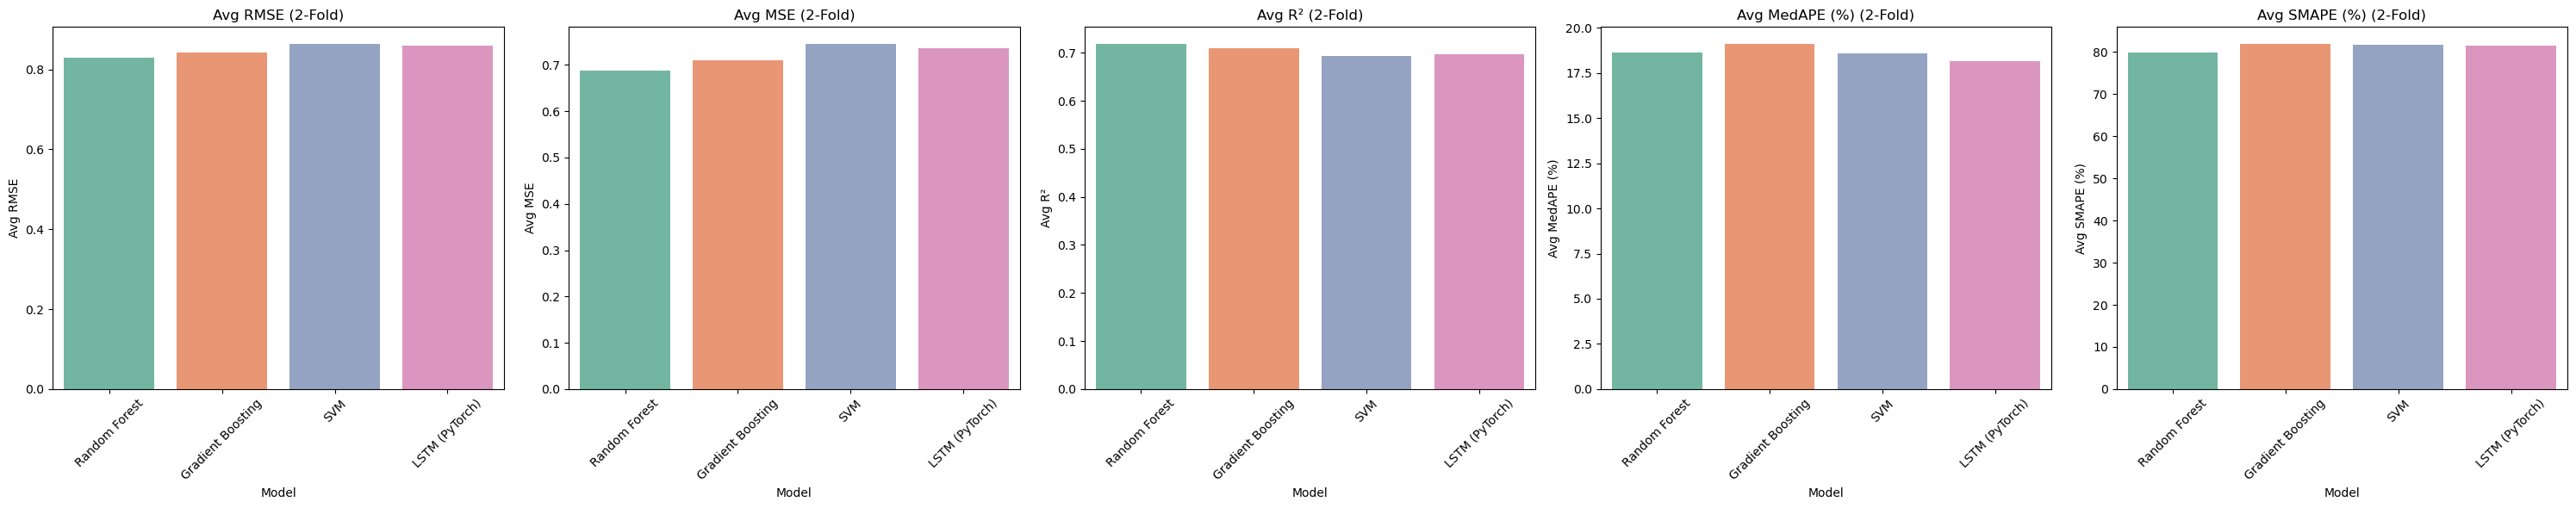


--- Evaluating Blind Set After 2-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8233 0.6778 0.7161     19.0168    81.7635
Gradient Boosting 0.8464 0.7163 0.6999     20.0592    83.4906
              SVM 0.8465 0.7166 0.6998     18.7351    82.8707
   LSTM (PyTorch) 0.8325 0.6930 0.7097     19.2133    84.2816


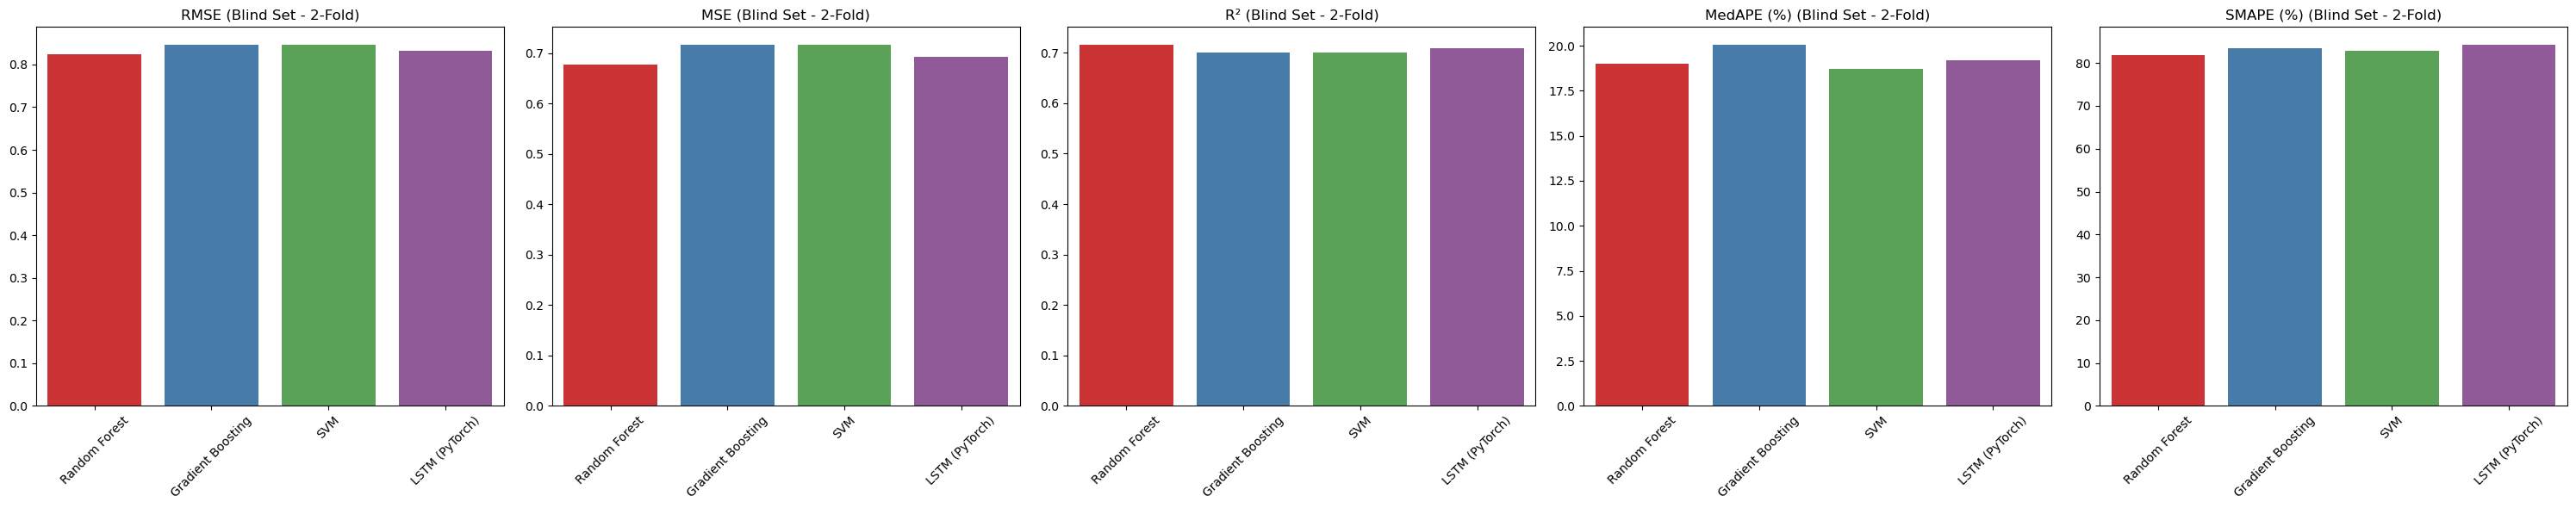


--- 3-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.8021   0.6436  0.7357         17.6069        78.7549
Gradient Boosting    0.8110   0.6578  0.7299         18.6044        80.8307
              SVM    0.8272   0.6844  0.7190         18.2495        80.3841
   LSTM (PyTorch)    0.8341   0.6962  0.7142         17.6261        79.2042


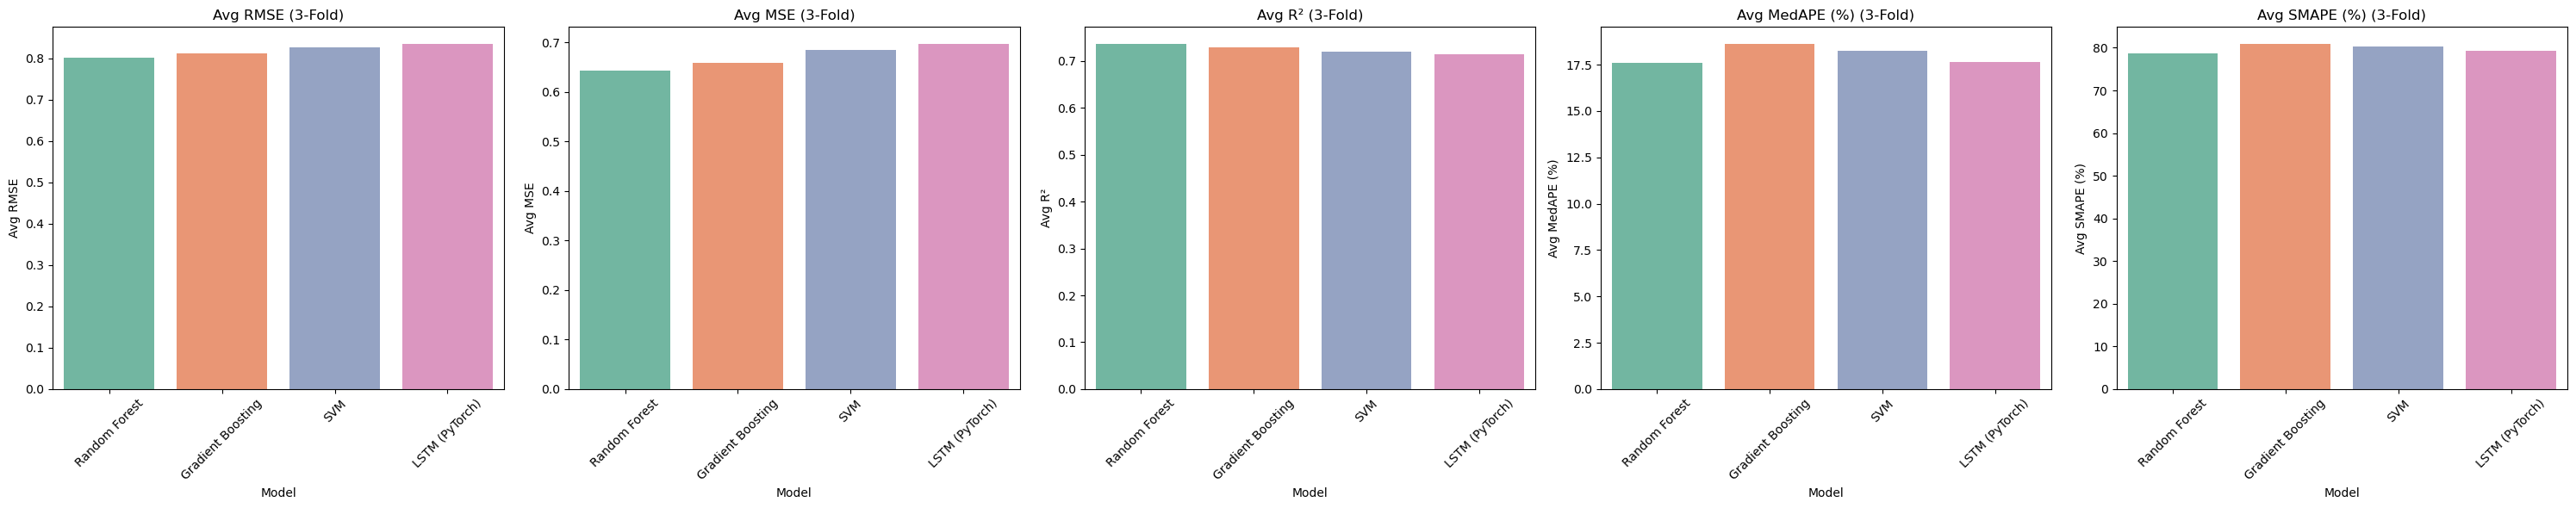


--- Evaluating Blind Set After 3-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8146 0.6636 0.7220     18.2866    80.7609
Gradient Boosting 0.8260 0.6823 0.7142     19.5453    80.9937
              SVM 0.8337 0.6950 0.7089     18.4223    82.0819
   LSTM (PyTorch) 0.8282 0.6860 0.7127     19.3857    82.6379


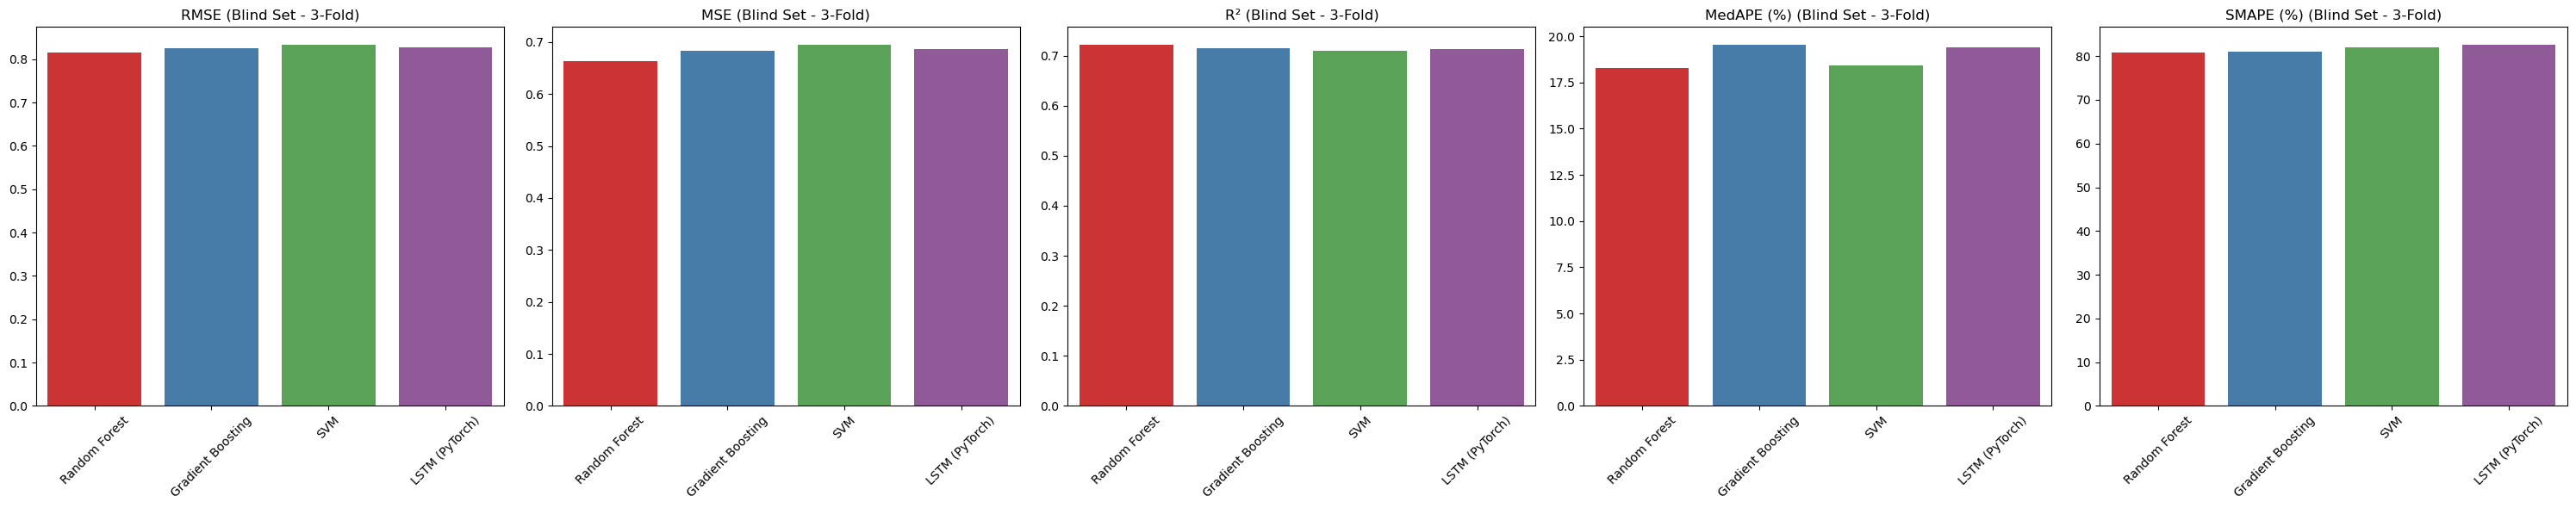


--- 4-Fold Cross Validation ---
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.9s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   0.8s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] EN

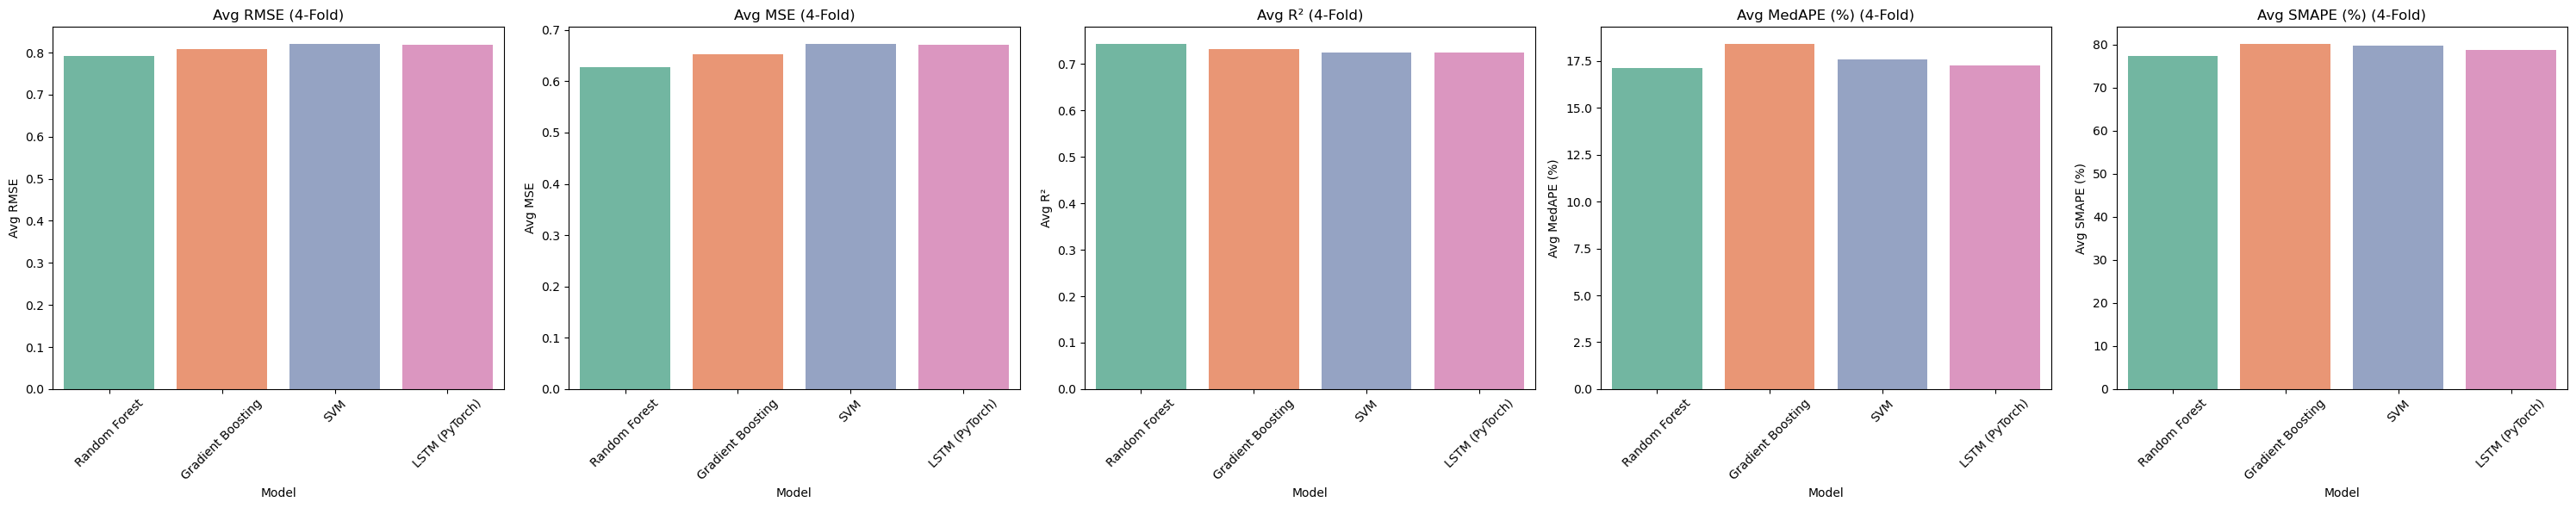


--- Evaluating Blind Set After 4-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8040 0.6464 0.7292     17.5506    79.6499
Gradient Boosting 0.8224 0.6763 0.7167     17.9610    81.5546
              SVM 0.8325 0.6931 0.7097     18.1064    81.2555
   LSTM (PyTorch) 0.8112 0.6580 0.7244     17.8390    80.7993


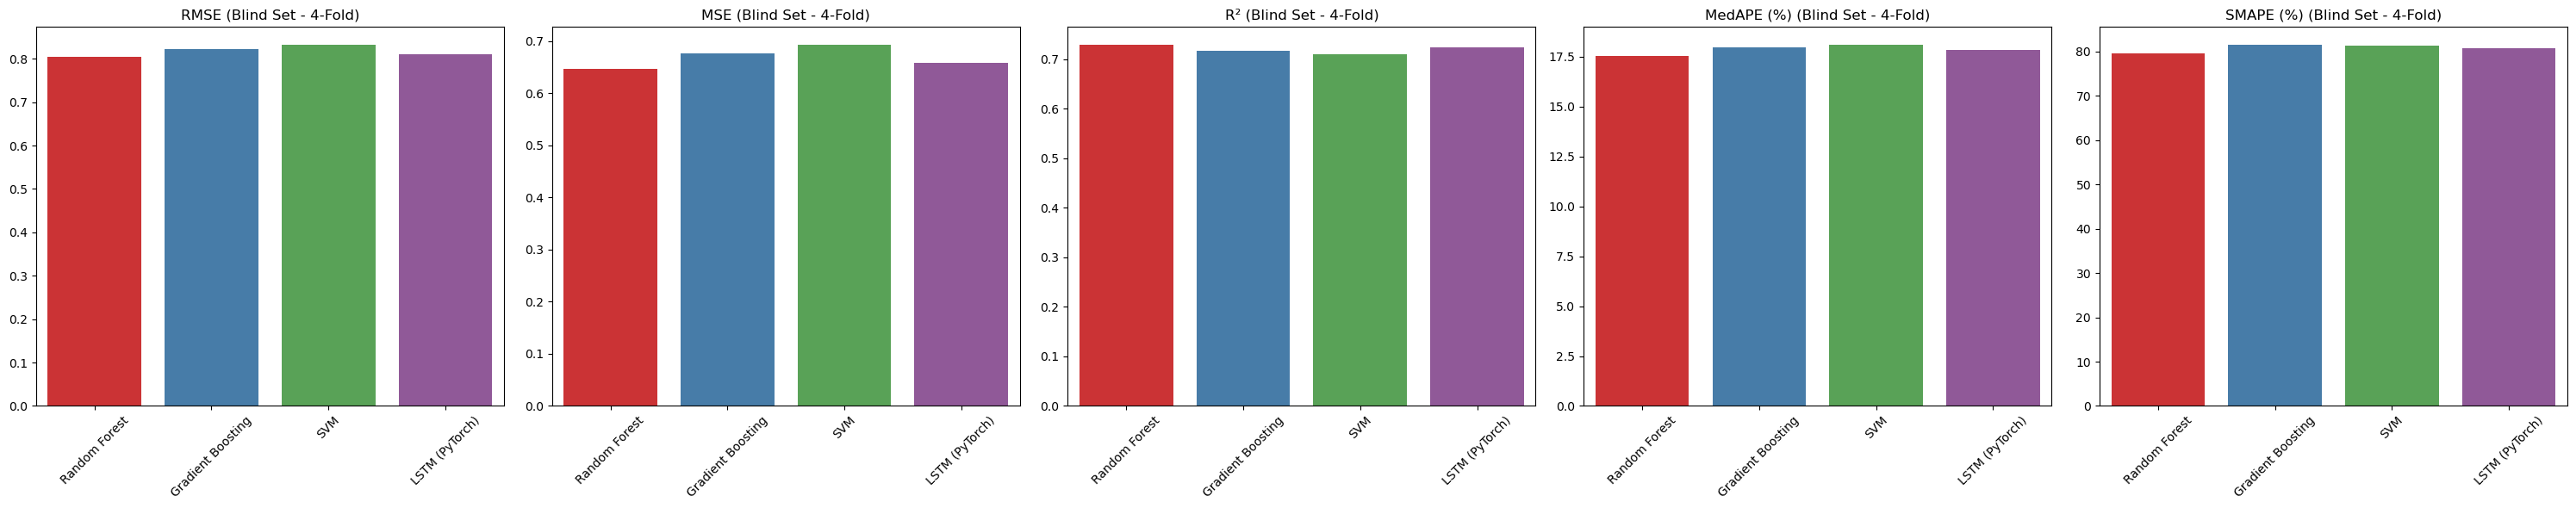


--- 5-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7870   0.6195  0.7453         17.0895        77.0642
Gradient Boosting    0.8045   0.6474  0.7337         18.4781        80.1997
              SVM    0.8144   0.6636  0.7271         17.4957        79.4142
   LSTM (PyTorch)    0.8119   0.6599  0.7287         17.6522        79.0241


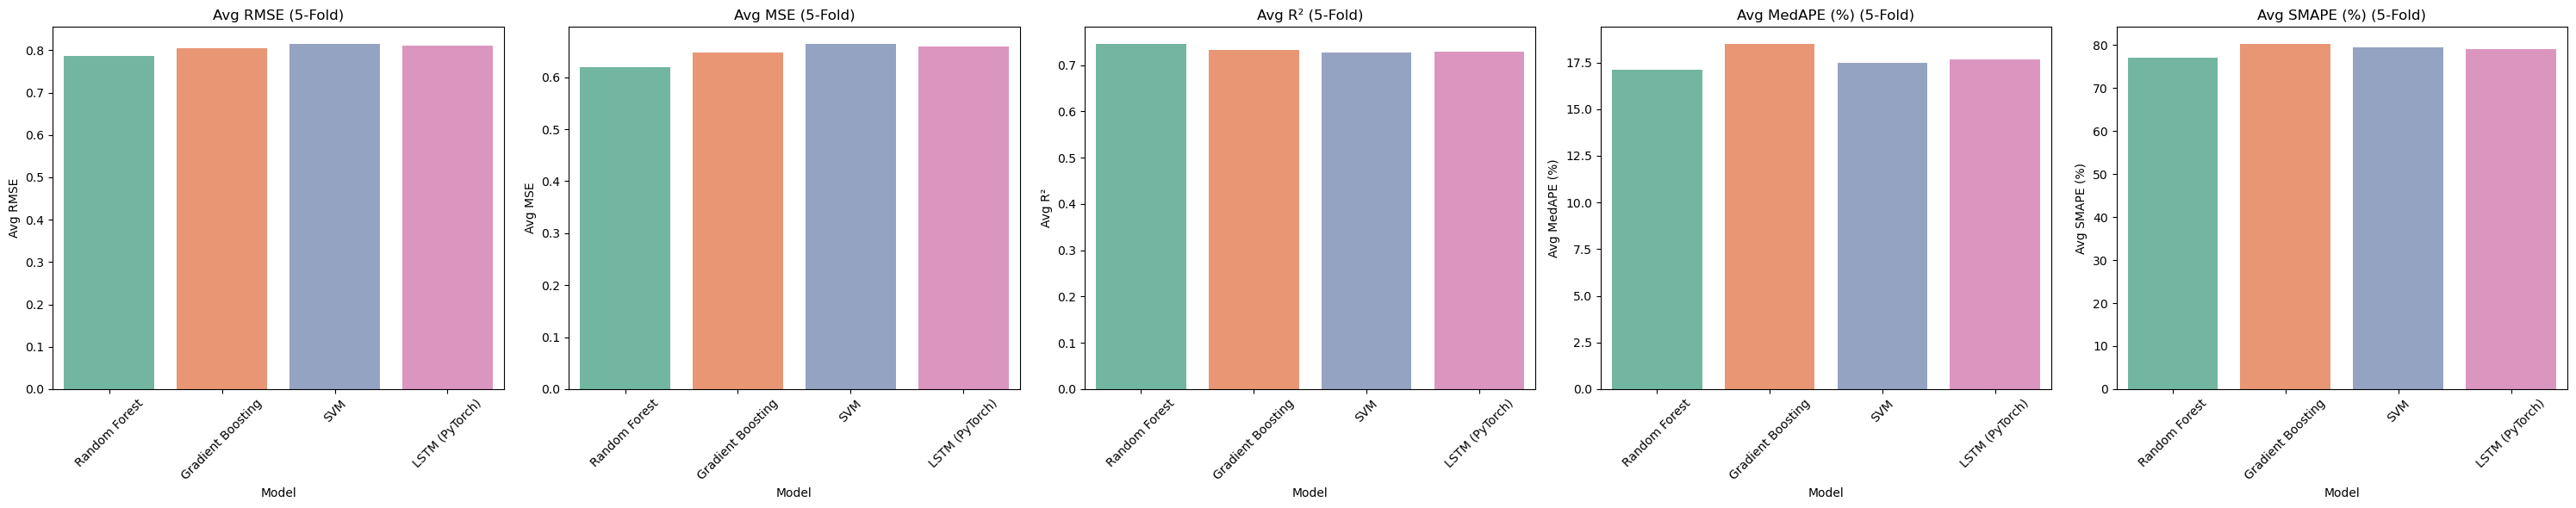


--- Evaluating Blind Set After 5-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8125 0.6601 0.7235     16.9374    79.5787
Gradient Boosting 0.8204 0.6730 0.7181     18.8345    81.3931
              SVM 0.8316 0.6916 0.7103     17.3724    80.8095
   LSTM (PyTorch) 0.8209 0.6739 0.7177     17.5415    81.5131


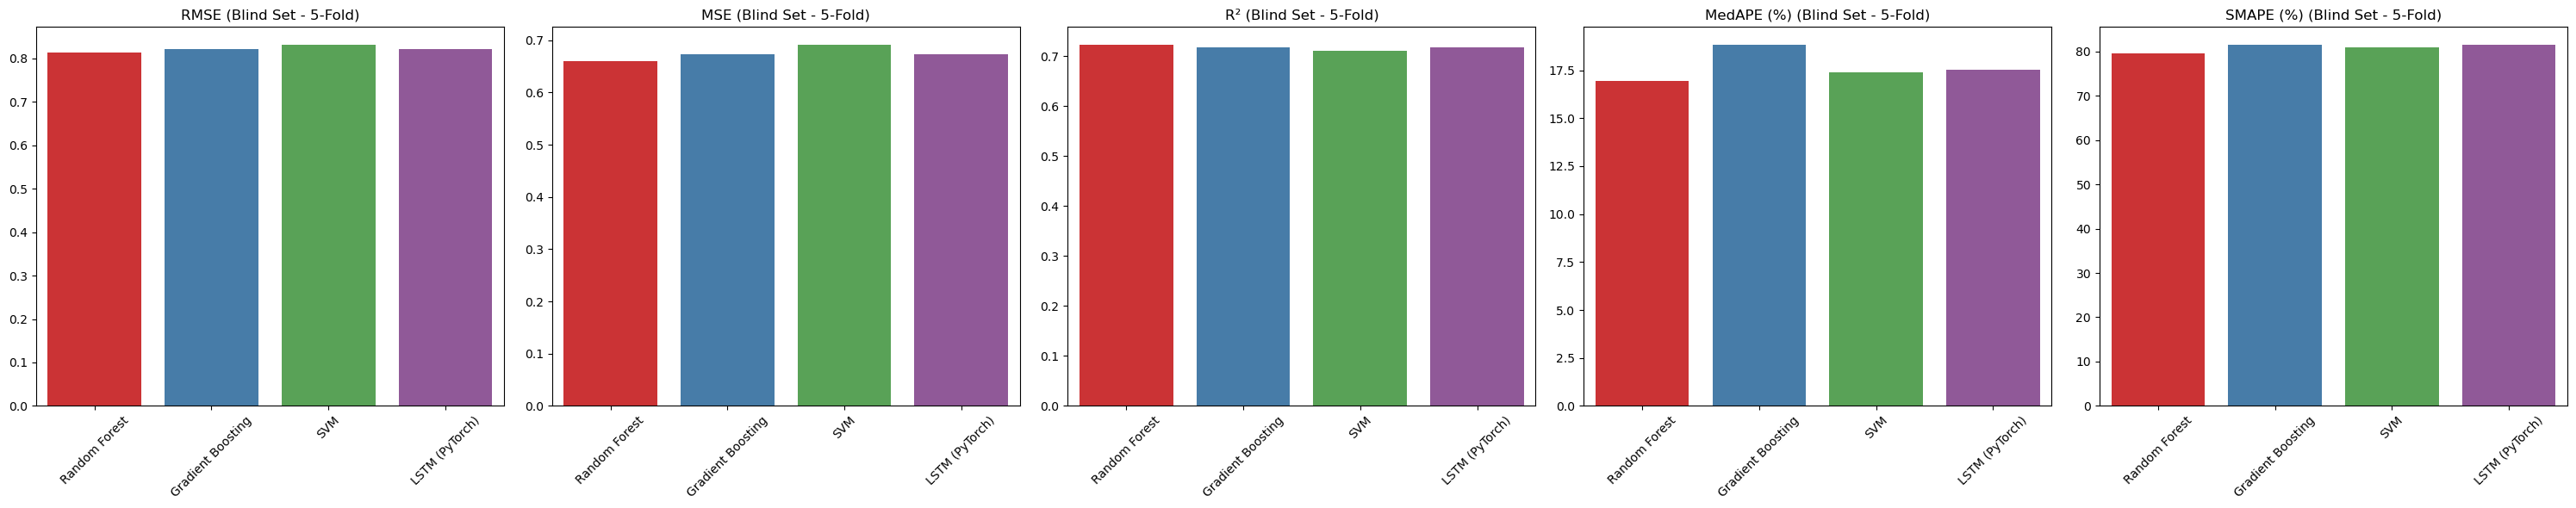


--- 6-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7830   0.6131  0.7476         16.9576        76.6907
Gradient Boosting    0.8059   0.6498  0.7320         18.3794        79.9894
              SVM    0.8104   0.6569  0.7293         17.4967        79.2315
   LSTM (PyTorch)    0.8079   0.6537  0.7311         17.5491        77.8070


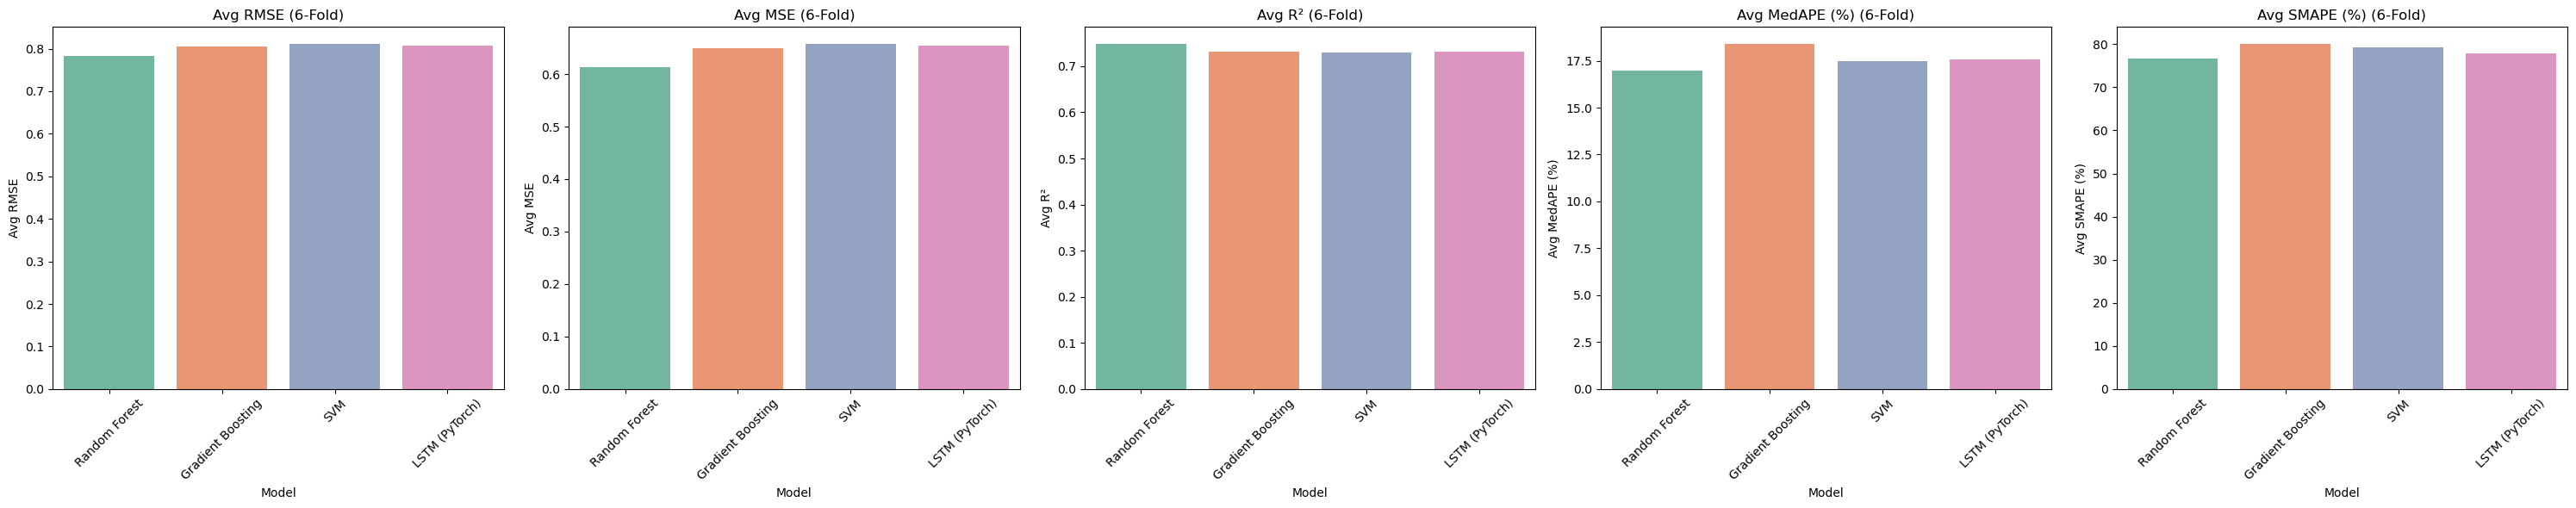


--- Evaluating Blind Set After 6-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7972 0.6356 0.7337     16.4811    78.6011
Gradient Boosting 0.8251 0.6808 0.7148     18.2088    81.5747
              SVM 0.8286 0.6866 0.7124     16.7300    80.6265
   LSTM (PyTorch) 0.7969 0.6350 0.7340     17.6807    79.7223


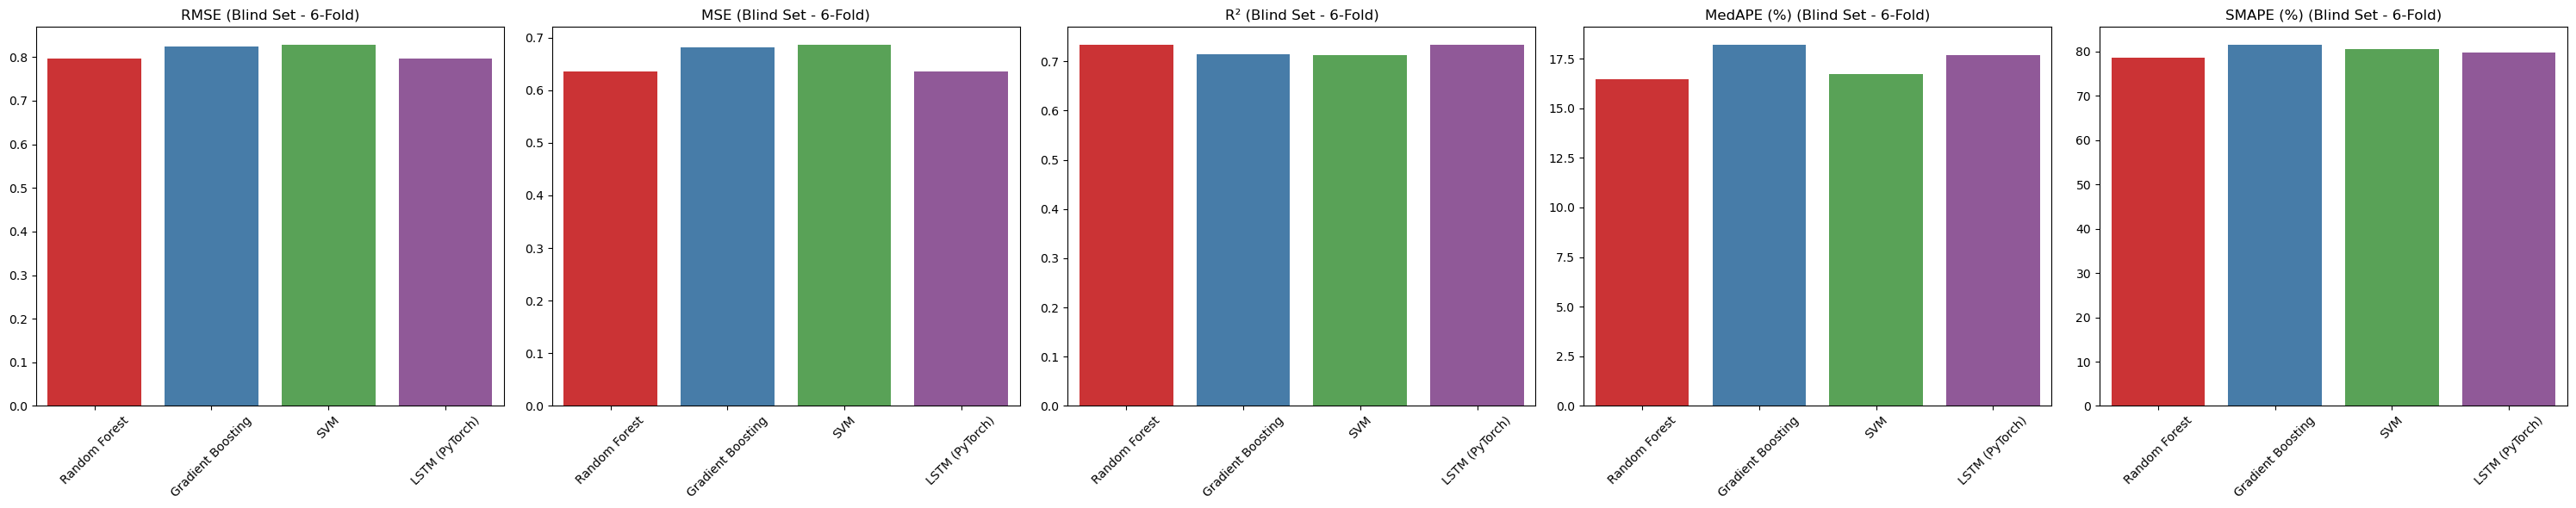


--- 7-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7831   0.6136  0.7476         16.9895        76.5393
Gradient Boosting    0.8060   0.6500  0.7323         18.3578        79.8213
              SVM    0.8100   0.6563  0.7298         17.1677        79.0237
   LSTM (PyTorch)    0.8233   0.6786  0.7210         17.6855        78.9346


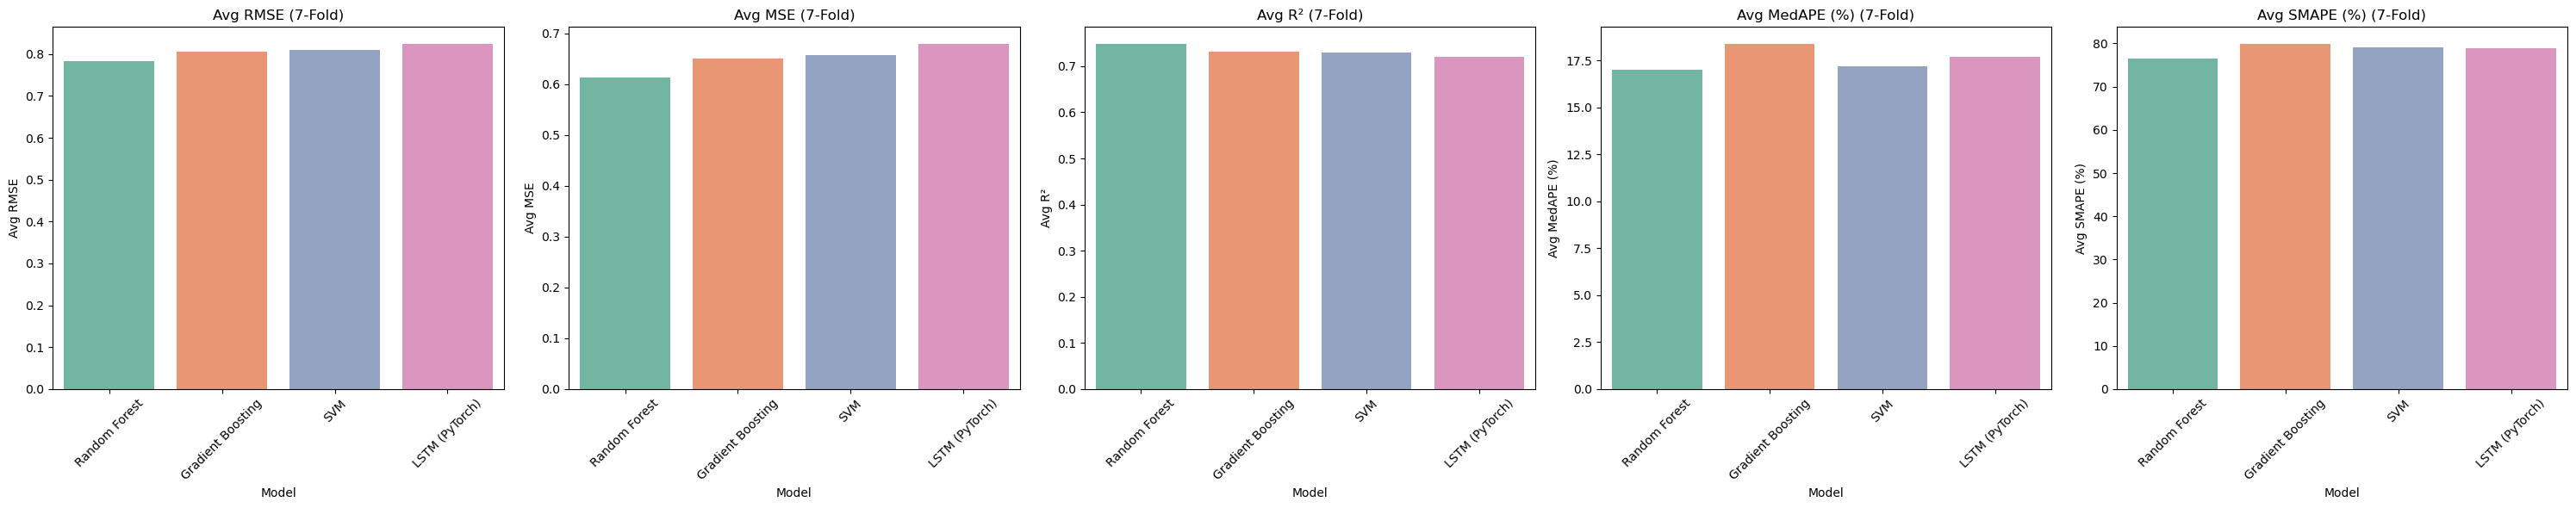


--- Evaluating Blind Set After 7-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7961 0.6338 0.7345     16.5858    78.6456
Gradient Boosting 0.8221 0.6759 0.7169     19.0763    81.2620
              SVM 0.8275 0.6847 0.7132     16.7307    80.1446
   LSTM (PyTorch) 0.8210 0.6740 0.7177     18.3176    79.7620


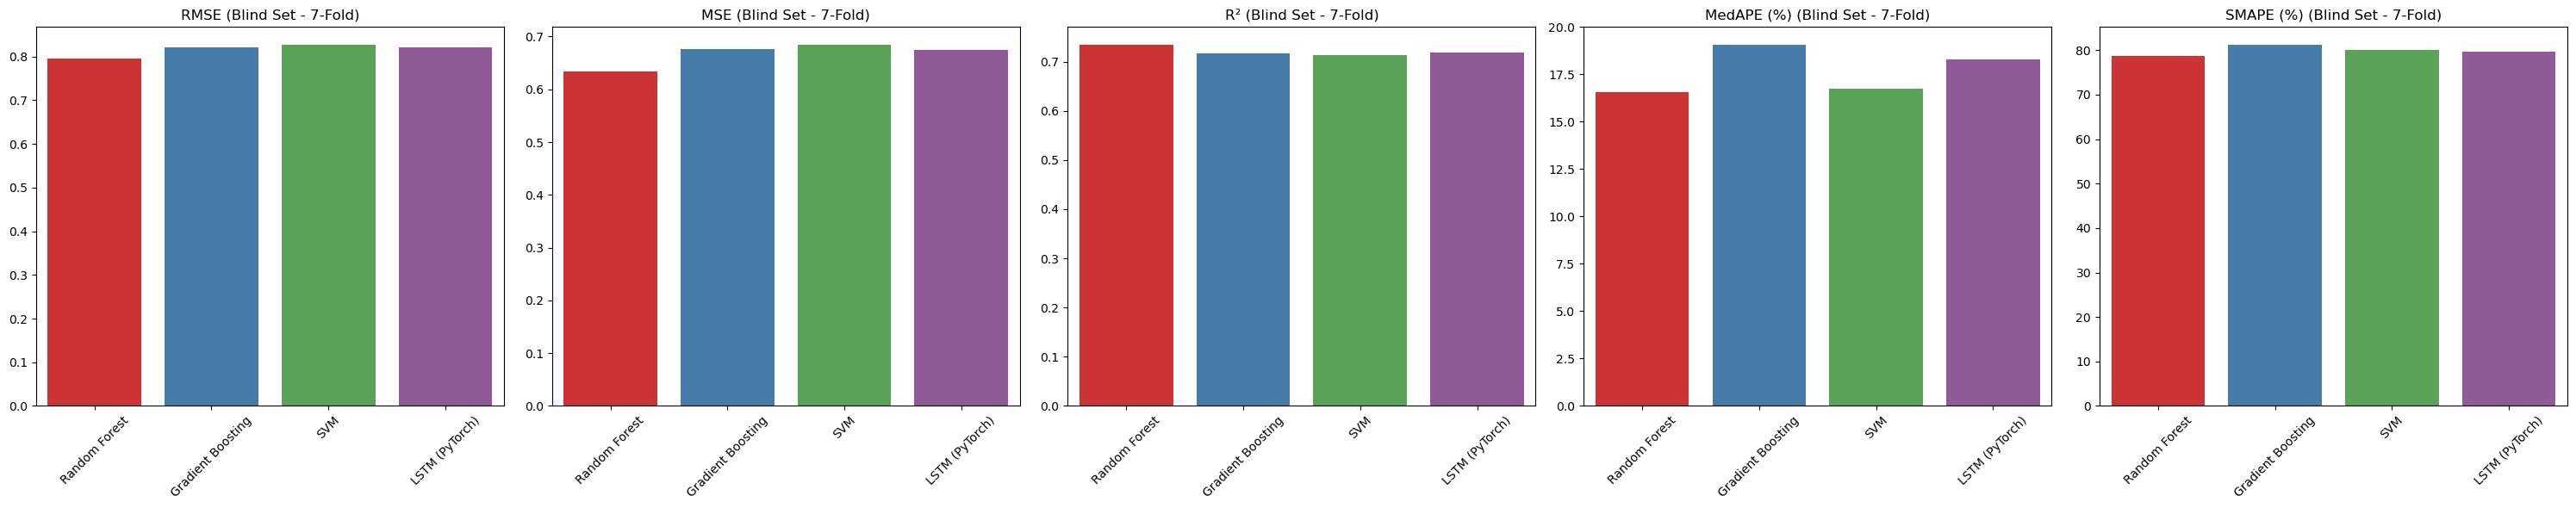


--- 8-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7812   0.6111  0.7488         16.4537        75.9685
Gradient Boosting    0.8079   0.6541  0.7305         18.5037        79.8927
              SVM    0.8121   0.6602  0.7284         17.0989        78.8937
   LSTM (PyTorch)    0.8069   0.6518  0.7319         17.1280        77.3170


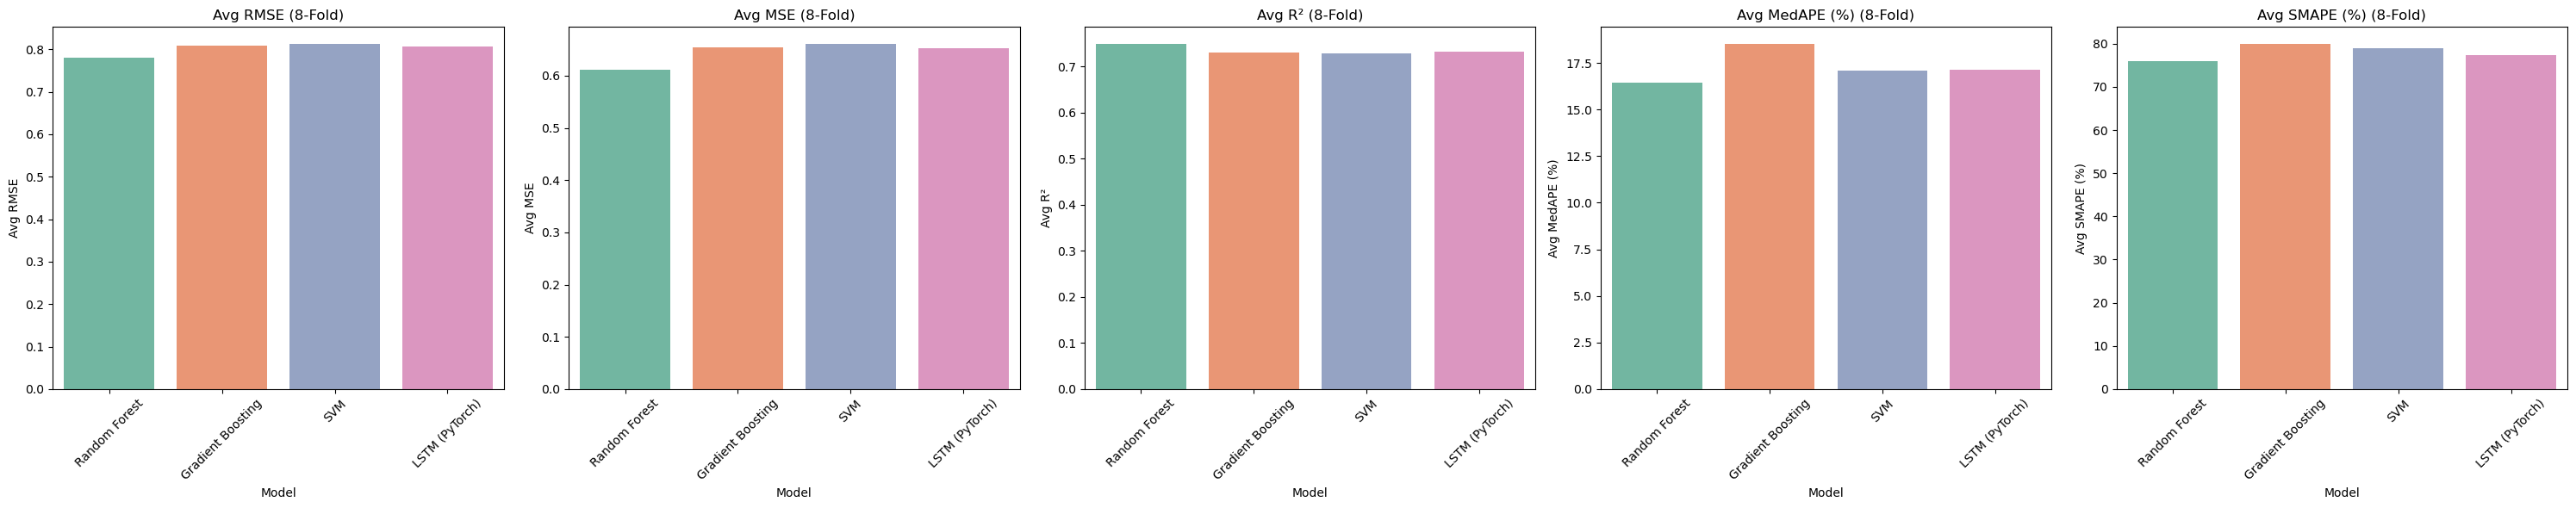


--- Evaluating Blind Set After 8-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7907 0.6252 0.7381     15.9084    77.7957
Gradient Boosting 0.8052 0.6483 0.7284     17.3009    80.4722
              SVM 0.8268 0.6836 0.7137     16.6339    79.8332
   LSTM (PyTorch) 0.7971 0.6354 0.7338     18.6228    80.0632


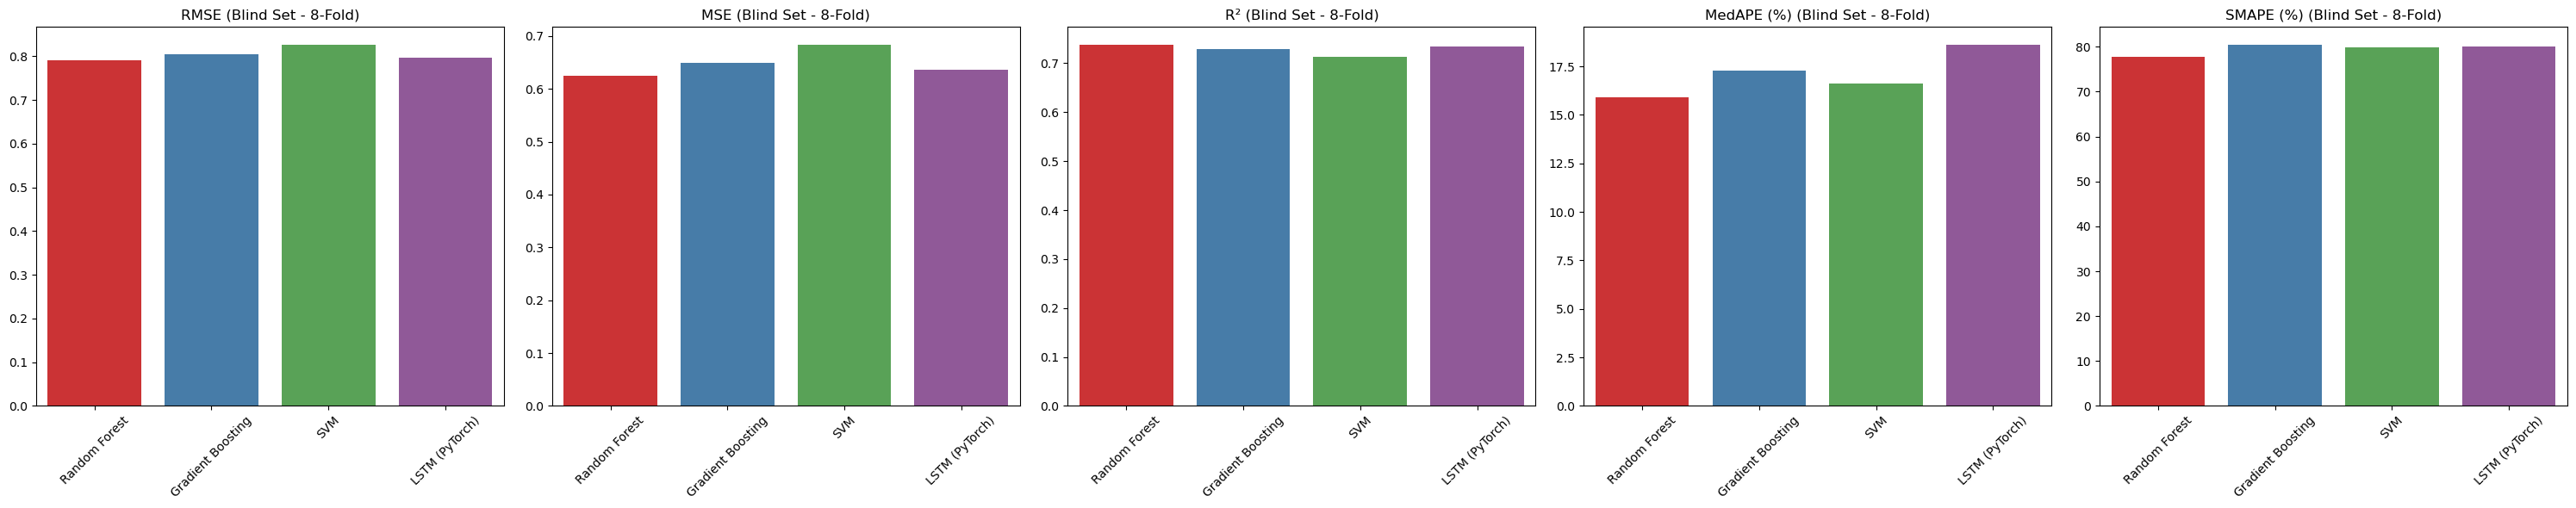


--- 9-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7783   0.6066  0.7504         16.9517        76.5251
Gradient Boosting    0.8049   0.6485  0.7325         18.2784        79.8958
              SVM    0.8090   0.6551  0.7305         17.2808        78.9408
   LSTM (PyTorch)    0.8077   0.6534  0.7314         17.2245        78.0919


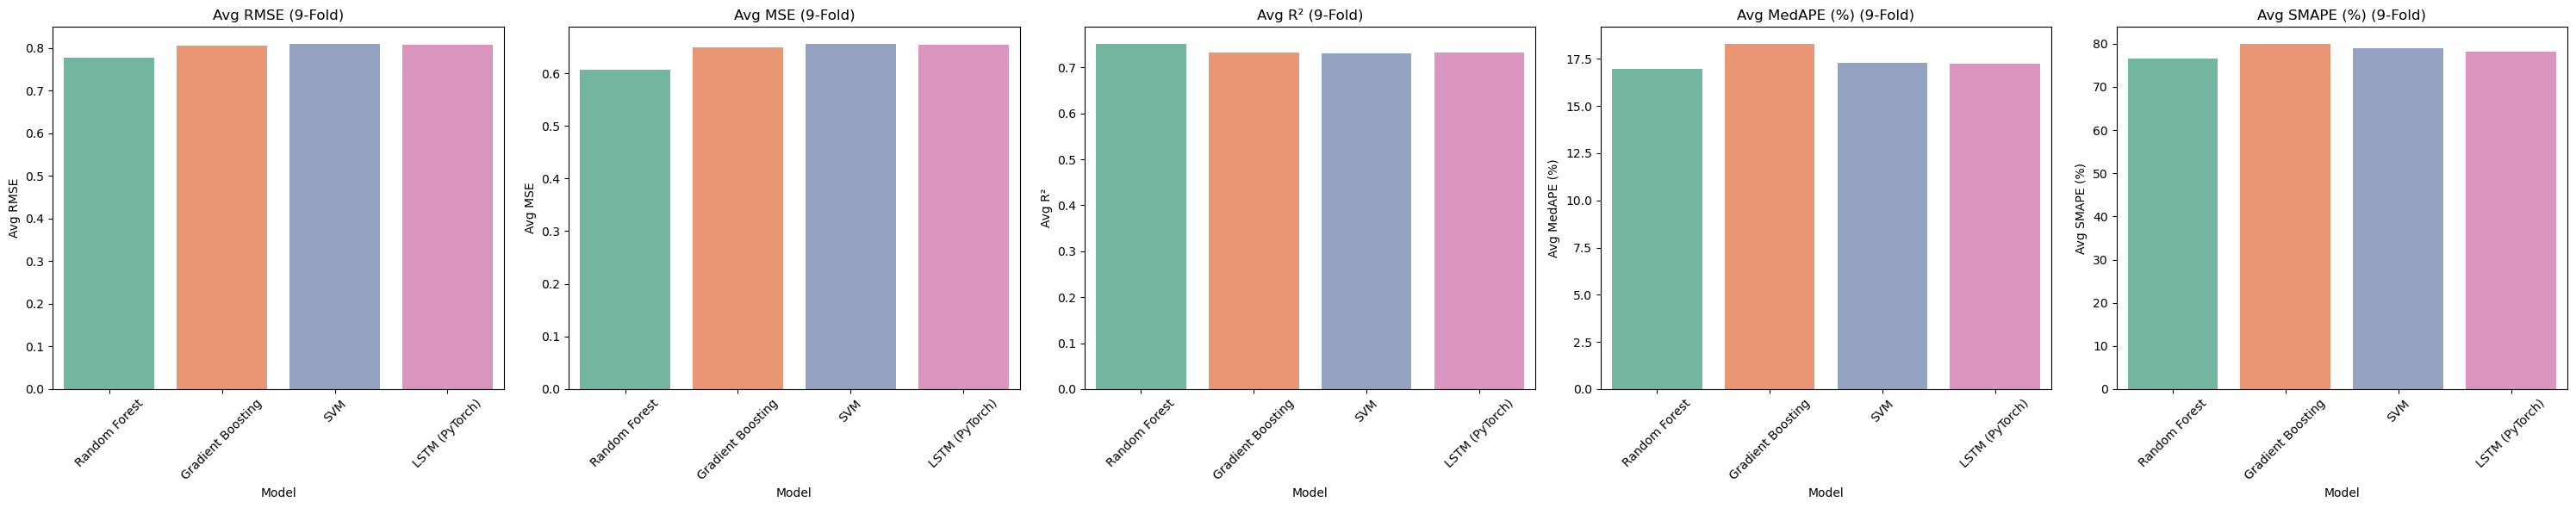


--- Evaluating Blind Set After 9-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7915 0.6264 0.7376     16.3696    78.3048
Gradient Boosting 0.8181 0.6693 0.7196     18.1840    80.8315
              SVM 0.8221 0.6758 0.7169     16.8559    79.8022
   LSTM (PyTorch) 0.7949 0.6319 0.7353     17.3417    80.1636


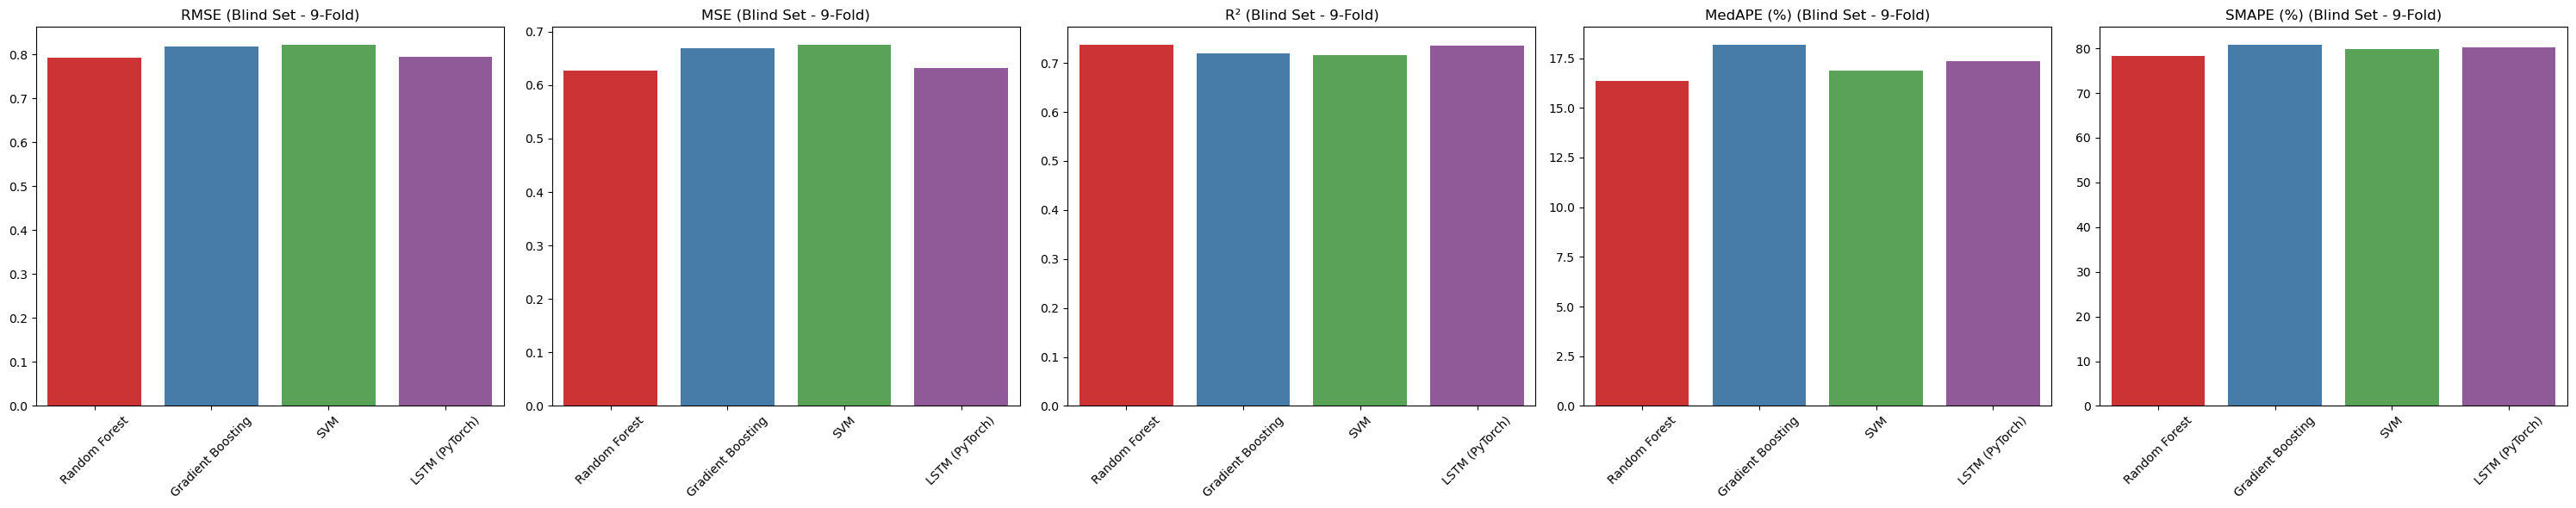


--- 10-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7813   0.6112  0.7484         16.5218        75.9953
Gradient Boosting    0.8085   0.6547  0.7303         18.0636        79.9365
              SVM    0.8086   0.6551  0.7303         17.3441        78.7169
   LSTM (PyTorch)    0.8072   0.6527  0.7315         16.8854        77.3670


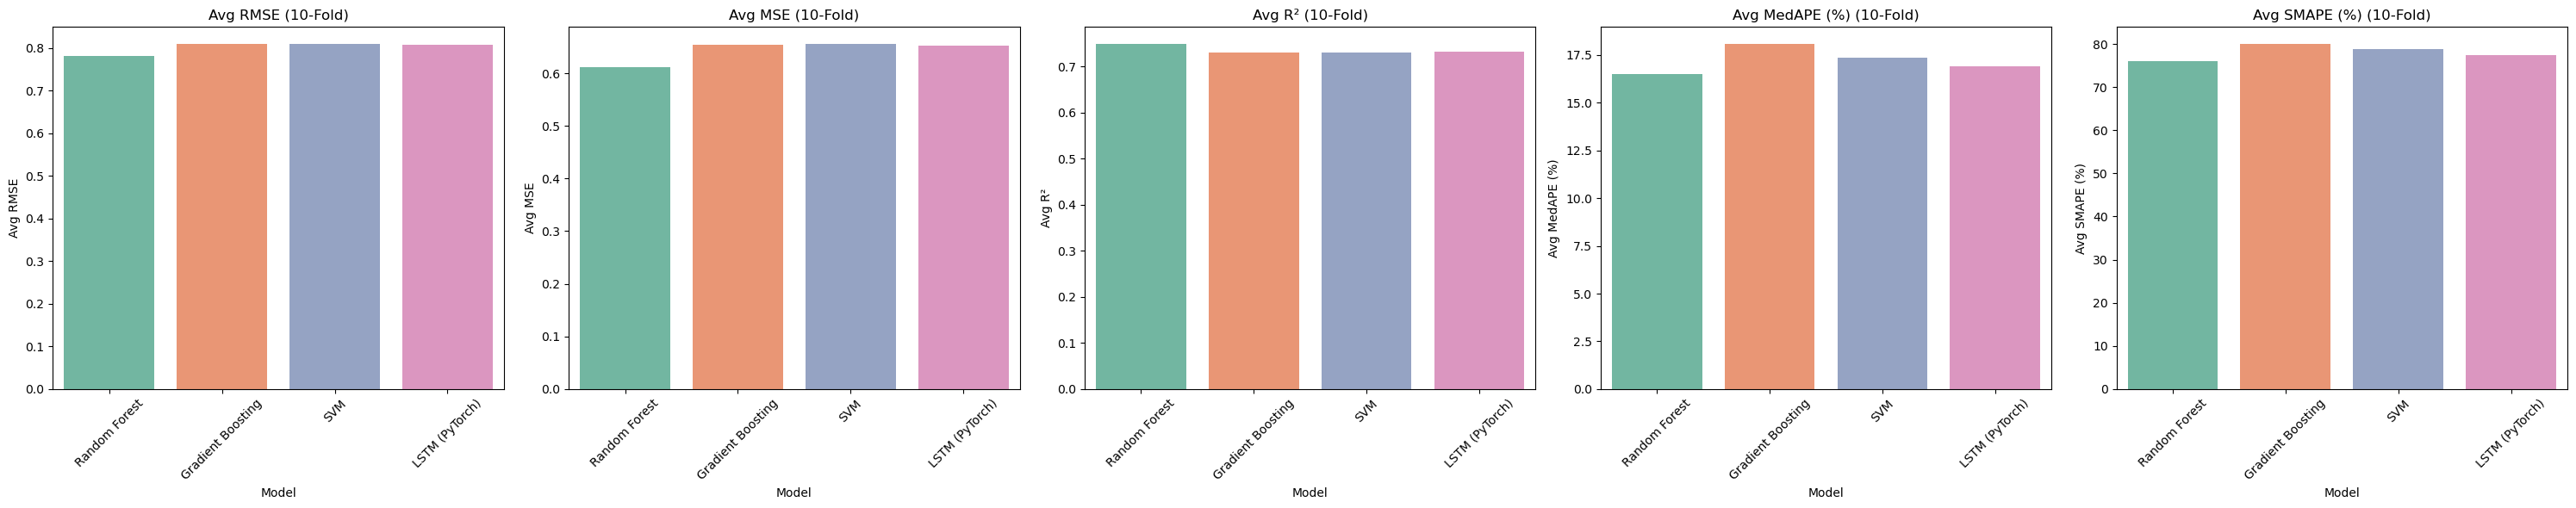


--- Evaluating Blind Set After 10-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7908 0.6253 0.7381     15.6751    78.2311
Gradient Boosting 0.8255 0.6815 0.7145     18.4551    80.8686
              SVM 0.8220 0.6756 0.7170     16.8226    79.8207
   LSTM (PyTorch) 0.7960 0.6336 0.7346     17.8041    79.7241


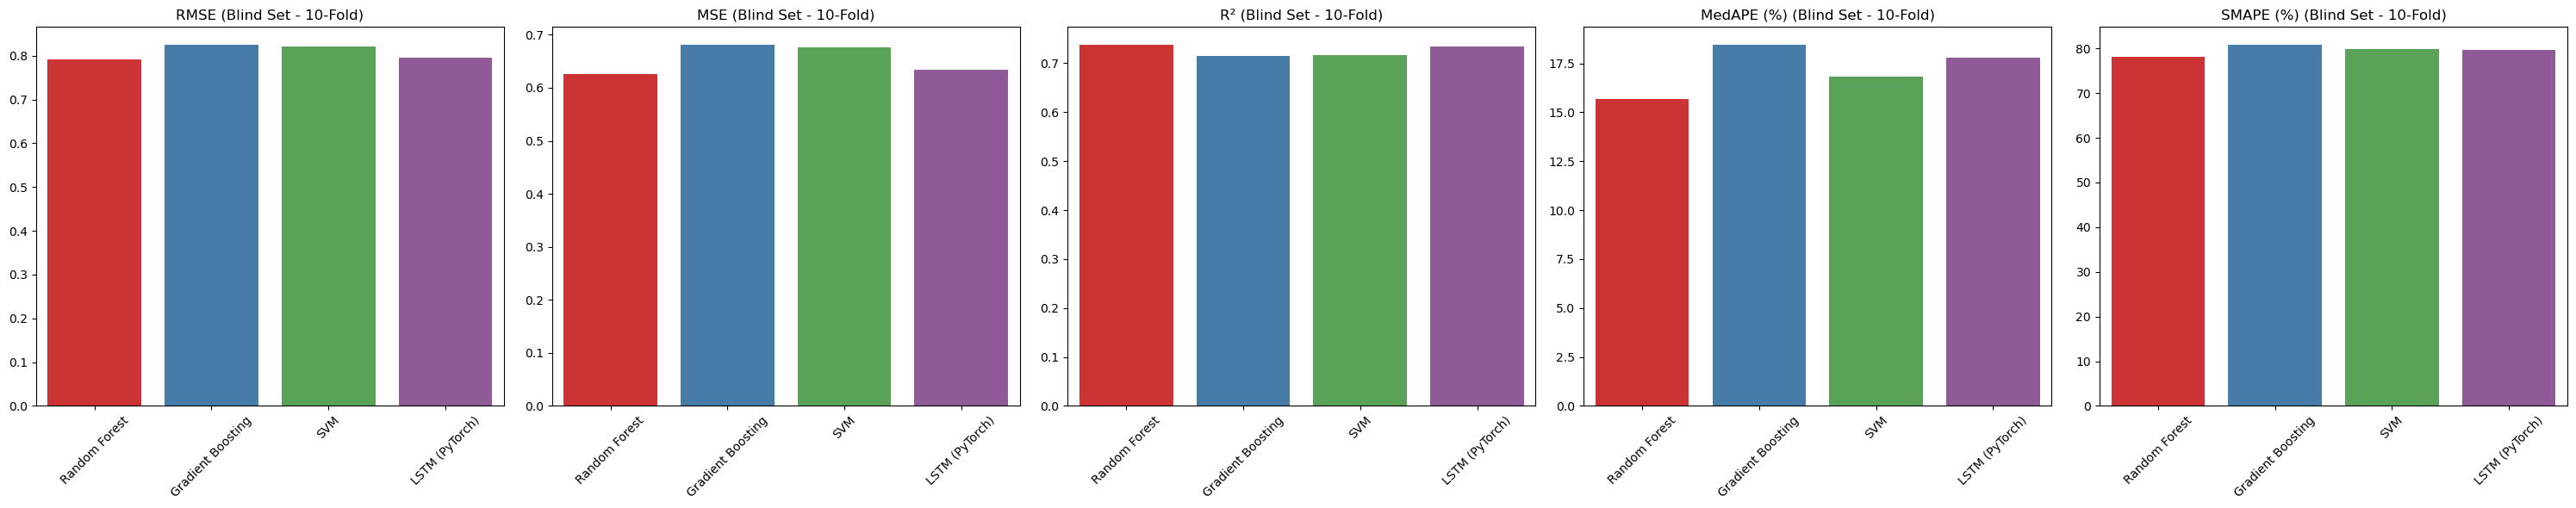

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# === Metrics ===
def medape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > epsilon
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator < epsilon, epsilon, denominator)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# === LSTM model ===
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, activation='relu'):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU()
        }
        self.activation = activations.get(activation, None)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step
        out = self.activation(out) if self.activation else out
        return self.fc(out)

def train_model(model, train_loader, val_loader, epochs=200, patience=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss = criterion(model(xb), yb)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return model


# Prepare training data
y = rdkit_train['log_ic50']
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])
X = X.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X.mean())
X_selected = X[features_filtered]
print(f"Training features shape: {X_selected.shape}")

# Prepare blind test data
X_blind = rdkit_blind.drop(columns=[col for col in drop_cols if col in rdkit_blind.columns])
X_blind = X_blind.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X_blind.mean())
X_blind_selected = X_blind[features_filtered]
print(f"Blind features shape: {X_blind_selected.shape}")

# Define models
models = {
    'Random Forest': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'SVM': SVR(),
    'LSTM (PyTorch)': None  # Placeholder, instantiate later per fold
}

metrics = ['RMSE', 'MSE', 'R²', 'MedAPE', 'SMAPE']

# Cross-validation loop
for k in range(2, 11):
    print(f"\n--- {k}-Fold Cross Validation ---")
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = {metric: {m: [] for m in models} for metric in metrics}

    for train_idx, test_idx in kf.split(X_selected):
        # Use .iloc for row indexing
        X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Train classic models
        for name, model in models.items():
            if name == 'LSTM (PyTorch)':
                continue
            model.fit(X_train_scaled, y_train)
            y_pred = np.maximum(model.predict(X_test_scaled), 0)
            scores['RMSE'][name].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            scores['MSE'][name].append(mean_squared_error(y_test, y_pred))
            scores['R²'][name].append(r2_score(y_test, y_pred))
            scores['MedAPE'][name].append(medape(y_test, y_pred))
            scores['SMAPE'][name].append(smape(np.expm1(y_test), np.expm1(y_pred)))

        # Prepare data for LSTM
        X_train_seq = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
        X_test_seq = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

        train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
        test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

        # Split train into train/val sets
        train_ds, val_ds = random_split(
            TensorDataset(train_tensor, y_train_tensor),
            [int(0.8 * len(train_tensor)), len(train_tensor) - int(0.8 * len(train_tensor))]
        )
        train_loader = DataLoader(train_ds, batch_size=lstm_best_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=lstm_best_params['batch_size'])

        # Instantiate and train LSTM
        lstm = LSTMRegressor(
            input_size=train_tensor.shape[2],
            hidden_size=lstm_best_params['hidden_size'],
            num_layers=lstm_best_params['num_layers'],
            activation=lstm_best_params['activation']
        )
        lstm = train_model(lstm, train_loader, val_loader, lr=lstm_best_params['learning_rate'])
        lstm.eval()

        with torch.no_grad():
            y_pred_lstm = torch.clamp(lstm(test_tensor), min=0).squeeze().numpy()

        scores['RMSE']['LSTM (PyTorch)'].append(np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
        scores['MSE']['LSTM (PyTorch)'].append(mean_squared_error(y_test, y_pred_lstm))
        scores['R²']['LSTM (PyTorch)'].append(r2_score(y_test, y_pred_lstm))
        scores['MedAPE']['LSTM (PyTorch)'].append(medape(y_test, y_pred_lstm))
        scores['SMAPE']['LSTM (PyTorch)'].append(smape(np.expm1(y_test), np.expm1(y_pred_lstm)))

    # Average performance report
    print("\nAverage Cross-Validation Performance:")
    perf_df = pd.DataFrame({
        'Model': list(models.keys()),
        'Avg RMSE': [np.mean(scores['RMSE'][m]) for m in models],
        'Avg MSE': [np.mean(scores['MSE'][m]) for m in models],
        'Avg R²': [np.mean(scores['R²'][m]) for m in models],
        'Avg MedAPE (%)': [np.mean(scores['MedAPE'][m]) for m in models],
        'Avg SMAPE (%)': [np.mean(scores['SMAPE'][m]) for m in models],
    })
    print(perf_df.to_string(index=False, float_format="%.4f"))

    # Plot results
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(perf_df.columns[1:]):
        sns.barplot(data=perf_df, x='Model', y=metric, ax=axes[i], palette='Set2')
        axes[i].set_title(f"{metric} ({k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # Blind set evaluation
    print(f"\n--- Evaluating Blind Set After {k}-Fold ---")
    X_blind_scaled = scaler.transform(X_blind_selected)
    blind_metrics = {metric: {} for metric in metrics}

    for name, model in models.items():
        if name == 'LSTM (PyTorch)':
            X_blind_seq = X_blind_scaled.reshape(-1, 1, X_blind_scaled.shape[1])
            X_blind_tensor = torch.tensor(X_blind_seq, dtype=torch.float32)
            lstm.eval()
            with torch.no_grad():
                y_blind_pred = torch.clamp(lstm(X_blind_tensor), min=0).squeeze().numpy()
        else:
            y_blind_pred = np.maximum(model.predict(X_blind_scaled), 0)

        blind_metrics['RMSE'][name] = np.sqrt(mean_squared_error(rdkit_blind['log_ic50'], y_blind_pred))
        blind_metrics['MSE'][name] = mean_squared_error(rdkit_blind['log_ic50'], y_blind_pred)
        blind_metrics['R²'][name] = r2_score(rdkit_blind['log_ic50'], y_blind_pred)
        blind_metrics['MedAPE'][name] = medape(rdkit_blind['log_ic50'], y_blind_pred)
        blind_metrics['SMAPE'][name] = smape(np.expm1(rdkit_blind['log_ic50']), np.expm1(y_blind_pred))

    blind_df = pd.DataFrame({
        'Model': list(models.keys()),
        'RMSE': [blind_metrics['RMSE'][m] for m in models],
        'MSE': [blind_metrics['MSE'][m] for m in models],
        'R²': [blind_metrics['R²'][m] for m in models],
        'MedAPE (%)': [blind_metrics['MedAPE'][m] for m in models],
        'SMAPE (%)': [blind_metrics['SMAPE'][m] for m in models],
    })
    print(blind_df.to_string(index=False, float_format="%.4f"))

    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(blind_df.columns[1:]):
        sns.barplot(data=blind_df, x='Model', y=metric, ax=axes[i], palette='Set1')
        axes[i].set_title(f"{metric} (Blind Set - {k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()


## Overfitting/Underfitting explananation in Kfold All models in RDkit

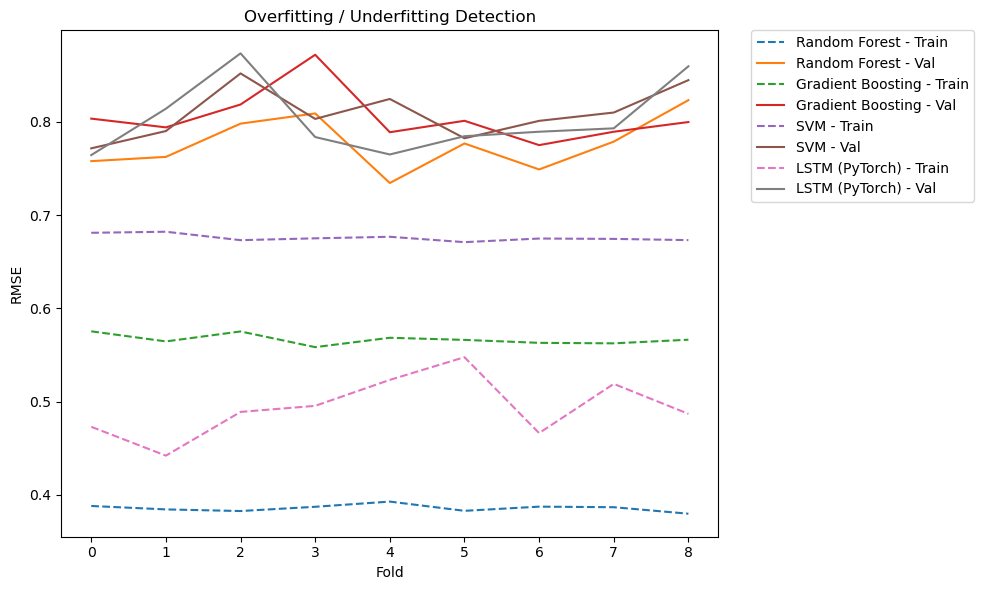

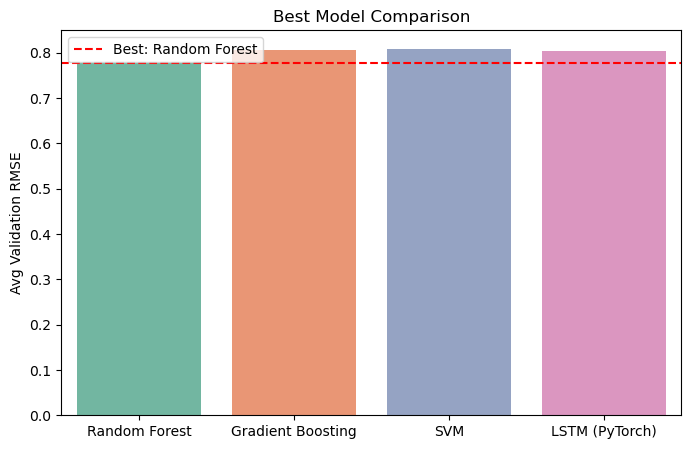

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# === Metrics ===
def medape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > epsilon
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator < epsilon, epsilon, denominator)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# === LSTM model ===
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, activation='relu'):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        activations = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'leaky_relu': nn.LeakyReLU()
        }
        self.activation = activations.get(activation, None)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.activation(out) if self.activation else out
        return self.fc(out)

def train_model(model, train_loader, val_loader, epochs=200, patience=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    best_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                val_loss = criterion(model(xb), yb)
                val_losses.append(val_loss.item())
        avg_val_loss = np.mean(val_losses)

        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return model

# === Prepare Data ===
y = rdkit_train['log_ic50']
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])
X = X.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X.mean())
X_selected = X[features_filtered]

X_blind = rdkit_blind.drop(columns=[col for col in drop_cols if col in rdkit_blind.columns])
X_blind = X_blind.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X_blind.mean())
X_blind_selected = X_blind[features_filtered]

# === Models ===
models = {
    'Random Forest': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'SVM': SVR(),
    'LSTM (PyTorch)': None
}

metrics = ['RMSE', 'MSE', 'R²', 'MedAPE', 'SMAPE']

# === Cross-validation with Overfitting Detection ===
kf = KFold(n_splits=9, shuffle=True, random_state=42)
scores = {metric: {m: [] for m in models} for metric in metrics}
train_rmse_hist, val_rmse_hist = {m: [] for m in models}, {m: [] for m in models}

for train_idx, test_idx in kf.split(X_selected):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for name, model in models.items():
        if name == 'LSTM (PyTorch)':
            continue
        model.fit(X_train_scaled, y_train)
        y_train_pred = np.maximum(model.predict(X_train_scaled), 0)
        y_val_pred = np.maximum(model.predict(X_test_scaled), 0)

        train_rmse_hist[name].append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        val_rmse_hist[name].append(np.sqrt(mean_squared_error(y_test, y_val_pred)))

        scores['RMSE'][name].append(train_rmse_hist[name][-1])
        scores['MSE'][name].append(mean_squared_error(y_test, y_val_pred))
        scores['R²'][name].append(r2_score(y_test, y_val_pred))
        scores['MedAPE'][name].append(medape(y_test, y_val_pred))
        scores['SMAPE'][name].append(smape(np.expm1(y_test), np.expm1(y_val_pred)))

    # LSTM processing...
    X_train_seq = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
    X_test_seq = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

    train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
    test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

    train_ds, val_ds = random_split(
        TensorDataset(train_tensor, y_train_tensor),
        [int(0.8 * len(train_tensor)), len(train_tensor) - int(0.8 * len(train_tensor))]
    )
    train_loader = DataLoader(train_ds, batch_size=lstm_best_params['batch_size'], shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=lstm_best_params['batch_size'])

    lstm = LSTMRegressor(
        input_size=train_tensor.shape[2],
        hidden_size=lstm_best_params['hidden_size'],
        num_layers=lstm_best_params['num_layers'],
        activation=lstm_best_params['activation']
    )
    lstm = train_model(lstm, train_loader, val_loader, lr=lstm_best_params['learning_rate'])
    lstm.eval()

    with torch.no_grad():
        y_train_pred_lstm = torch.clamp(lstm(train_tensor), min=0).squeeze().numpy()
        y_val_pred_lstm = torch.clamp(lstm(test_tensor), min=0).squeeze().numpy()

    train_rmse_hist['LSTM (PyTorch)'].append(np.sqrt(mean_squared_error(y_train, y_train_pred_lstm)))
    val_rmse_hist['LSTM (PyTorch)'].append(np.sqrt(mean_squared_error(y_test, y_val_pred_lstm)))

    scores['RMSE']['LSTM (PyTorch)'].append(train_rmse_hist['LSTM (PyTorch)'][-1])
    scores['MSE']['LSTM (PyTorch)'].append(mean_squared_error(y_test, y_val_pred_lstm))
    scores['R²']['LSTM (PyTorch)'].append(r2_score(y_test, y_val_pred_lstm))
    scores['MedAPE']['LSTM (PyTorch)'].append(medape(y_test, y_val_pred_lstm))
    scores['SMAPE']['LSTM (PyTorch)'].append(smape(np.expm1(y_test), np.expm1(y_val_pred_lstm)))

# === Overfitting / Underfitting Plot ===

plt.figure(figsize=(10, 6))
for model in models:
    plt.plot(train_rmse_hist[model], label=f"{model} - Train", linestyle='--')
    plt.plot(val_rmse_hist[model], label=f"{model} - Val")

plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("Overfitting / Underfitting Detection")

# Place legend outside plot, top right
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()


# === Best Model Plot ===
avg_val_rmse = {m: np.mean(val_rmse_hist[m]) for m in models}
best_model = min(avg_val_rmse, key=avg_val_rmse.get)

plt.figure(figsize=(8, 5))
sns.barplot(x=list(avg_val_rmse.keys()), y=list(avg_val_rmse.values()), palette='Set2')
plt.axhline(avg_val_rmse[best_model], color='red', linestyle='--', label=f"Best: {best_model}")
plt.ylabel("Avg Validation RMSE")
plt.title("Best Model Comparison")
plt.legend()
plt.show()


## Best Random Forest Model in K fold cross validation with Overfitting/Underfitting


Average CV Performance (Random Forest):
Metric    Mean    Std
  RMSE  0.7777 0.0257
   MSE  0.6054 0.0403
    R²  0.7508 0.0156
MedAPE 16.5070 1.1767
 SMAPE 76.1879 3.3553


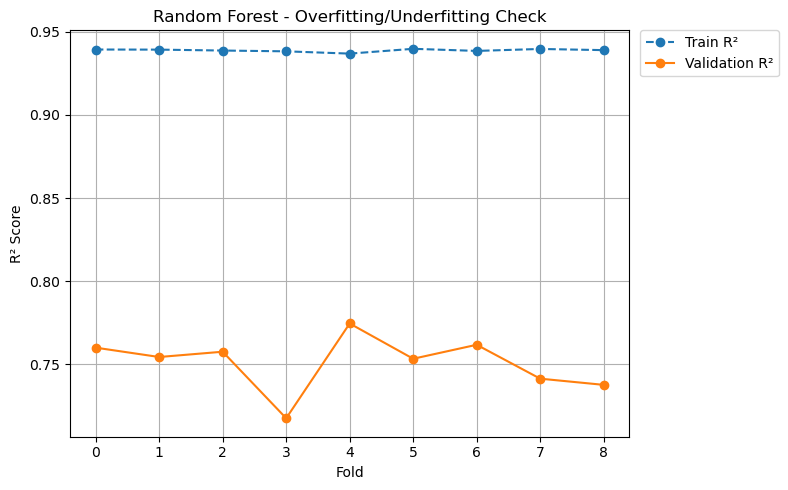

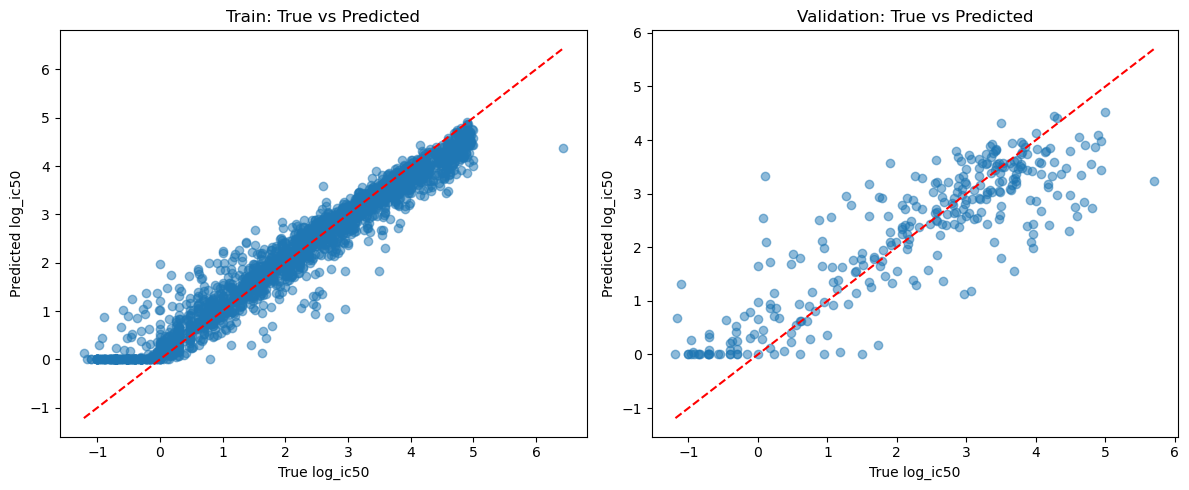

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# === Create output directory ===
output_dir = "/Users/janat/Desktop/ppimic50pred/model"
os.makedirs(output_dir, exist_ok=True)

# === Custom Metrics ===
def medape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > epsilon
    if np.sum(mask) == 0:
        return np.nan
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator < epsilon, epsilon, denominator)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# === Prepare Data ===
drop_cols = ['chembl_id', 'smiles', 'ic50_value', 'log_ic50', 
             'target_chembl_id', 'target_name']
y = rdkit_train['log_ic50']

# Clean training features
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])
X = X.replace(r'^\s*$', np.nan, regex=True)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

# Select fixed important features only
X_selected = X[features_filtered]

# Prepare blind test set similarly
X_blind = rdkit_blind.drop(columns=[col for col in drop_cols if col in rdkit_blind.columns])
X_blind = X_blind.replace(r'^\s*$', np.nan, regex=True)
X_blind = X_blind.apply(pd.to_numeric, errors='coerce')
X_blind = X_blind.fillna(X_blind.mean())
X_blind_selected = X_blind[features_filtered]

# === Model ===
rf = RandomForestRegressor(**rf_best_params)

# === Cross-validation ===
kf = KFold(n_splits=9, shuffle=True, random_state=42)
train_r2_hist, val_r2_hist = [], []
scores = {"RMSE": [], "MSE": [], "R²": [], "MedAPE": [], "SMAPE": []}

# Store last fold data for plotting true vs predicted
y_train_last, y_train_pred_last = None, None
y_val_last, y_val_pred_last = None, None

for train_idx, val_idx in kf.split(X_selected):
    X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    rf.fit(X_train_scaled, y_train)
    y_train_pred = np.maximum(rf.predict(X_train_scaled), 0)
    y_val_pred = np.maximum(rf.predict(X_val_scaled), 0)

    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    train_r2_hist.append(train_r2)
    val_r2_hist.append(val_r2)

    scores["RMSE"].append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    scores["MSE"].append(mean_squared_error(y_val, y_val_pred))
    scores["R²"].append(val_r2)
    scores["MedAPE"].append(medape(y_val, y_val_pred))
    scores["SMAPE"].append(smape(np.expm1(y_val), np.expm1(y_val_pred)))

    # Save last fold results for plotting
    y_train_last, y_train_pred_last = y_train, y_train_pred
    y_val_last, y_val_pred_last = y_val, y_val_pred

# === Average CV Performance ===
perf_df = pd.DataFrame({
    "Metric": list(scores.keys()),
    "Mean": [np.mean(scores[m]) for m in scores],
    "Std": [np.std(scores[m]) for m in scores]
})
print("\nAverage CV Performance (Random Forest):")
print(perf_df.to_string(index=False, float_format="%.4f"))

perf_df.to_csv(os.path.join(output_dir, "cv_performance.csv"), index=False)

# === Retrain Final Model on Full Data ===
scaler_final = StandardScaler()
X_scaled_full = scaler_final.fit_transform(X_selected)
rf.fit(X_scaled_full, y)

joblib.dump({"model": rf, "scaler": scaler_final}, 
            os.path.join(output_dir, "random_forest_model.pkl"))

# === Overfitting / Underfitting Plot (R²) ===
plt.figure(figsize=(8, 5))
plt.plot(train_r2_hist, label="Train R²", linestyle='--', marker='o')
plt.plot(val_r2_hist, label="Validation R²", marker='o')
plt.xlabel("Fold")
plt.ylabel("R² Score")
plt.title("Random Forest - Overfitting/Underfitting Check")
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "overfitting_underfitting_plot.png"))
plt.show()

# === True vs Predicted Plots (Last Fold) ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train_last, y_train_pred_last, alpha=0.5)
plt.plot([min(y_train_last), max(y_train_last)], 
         [min(y_train_last), max(y_train_last)], 'r--')
plt.title("Train: True vs Predicted")
plt.xlabel("True log_ic50")
plt.ylabel("Predicted log_ic50")

plt.subplot(1, 2, 2)
plt.scatter(y_val_last, y_val_pred_last, alpha=0.5)
plt.plot([min(y_val_last), max(y_val_last)], 
         [min(y_val_last), max(y_val_last)], 'r--')
plt.title("Validation: True vs Predicted")
plt.xlabel("True log_ic50")
plt.ylabel("Predicted log_ic50")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "true_vs_predicted.png"))
plt.show()


## Random Forest Model using RDkit features if just using train_test_split : 80% training and 20% testing

Training MSE: 0.1239
Validation MSE: 0.5674
Training R²: 0.9491
Validation R²: 0.7671

Model seems reasonably fit.


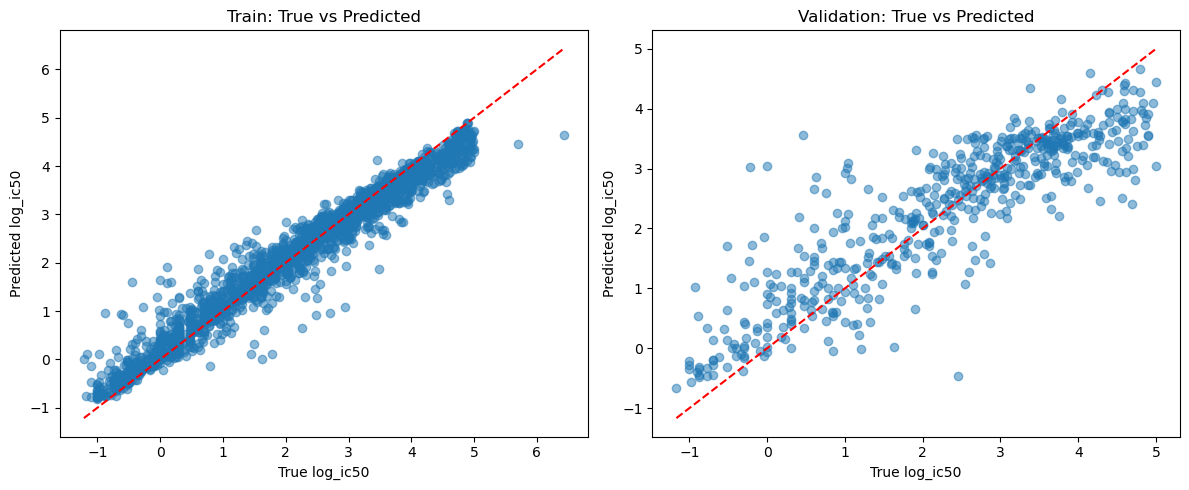

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Prepare target variable
y = rdkit_train['log_ic50']

# Define columns to drop if present
drop_cols = [
    'chembl_id', 'smiles', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name'
]

# Drop unwanted columns safely
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])

# Clean features as in your pipeline (example: convert to numeric, handle NaNs)
X = X.replace(r'^\s*$', np.nan, regex=True)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.replace([np.inf, -np.inf], np.nan)
X = X.clip(lower=-1e6, upper=1e6)
X = X.fillna(X.mean())

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize Random Forest Regressor (use your best params)
reg = RandomForestRegressor(**rf_best_params)
reg.fit(X_train, y_train)

# Function to check overfitting or underfitting
def check_overfitting_underfitting(model, X_train, y_train, X_val, y_val):
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_val = mean_squared_error(y_val, y_val_pred)

    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_val, y_val_pred)

    print(f"Training MSE: {mse_train:.4f}")
    print(f"Validation MSE: {mse_val:.4f}")
    print(f"Training R²: {r2_train:.4f}")
    print(f"Validation R²: {r2_val:.4f}")

    if r2_train > 0.8 and r2_val < 0.5:
        print("\nWarning: Possible Overfitting detected (high train score, low val score).")
    elif r2_train < 0.5 and r2_val < 0.5:
        print("\nWarning: Possible Underfitting detected (both train and val scores are low).")
    else:
        print("\nModel seems reasonably fit.")

    # Plot true vs predicted
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.scatter(y_train, y_train_pred, alpha=0.5)
    plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'r--')
    plt.title("Train: True vs Predicted")
    plt.xlabel("True log_ic50")
    plt.ylabel("Predicted log_ic50")

    plt.subplot(1, 2, 2)
    plt.scatter(y_val, y_val_pred, alpha=0.5)
    plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], 'r--')
    plt.title("Validation: True vs Predicted")
    plt.xlabel("True log_ic50")
    plt.ylabel("Predicted log_ic50")

    plt.tight_layout()
    plt.show()

# Run the check
check_overfitting_underfitting(reg, X_train, y_train, X_val, y_val)


In [63]:
lstm_best_params

{'hidden_size': 128,
 'num_layers': 1,
 'learning_rate': 0.0005,
 'batch_size': 64,
 'activation': 'leaky_relu'}

In [64]:
rf_best_params

{'max_depth': None,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

## Feature selection: Variance Threshold

## Variance Threshold feature selection and Blind set Validation in Kfold cross validation, with Tunned parameters

## VarianceThreshold(0.01)


--- 2-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.8306   0.6899  0.7167         18.3376        80.0410
Gradient Boosting    0.8394   0.7046  0.7104         18.5265        81.5235
              SVM    0.8597   0.7391  0.6962         18.3370        81.5356
   LSTM (PyTorch)    0.8386   0.7033  0.7112         17.9457        79.4662


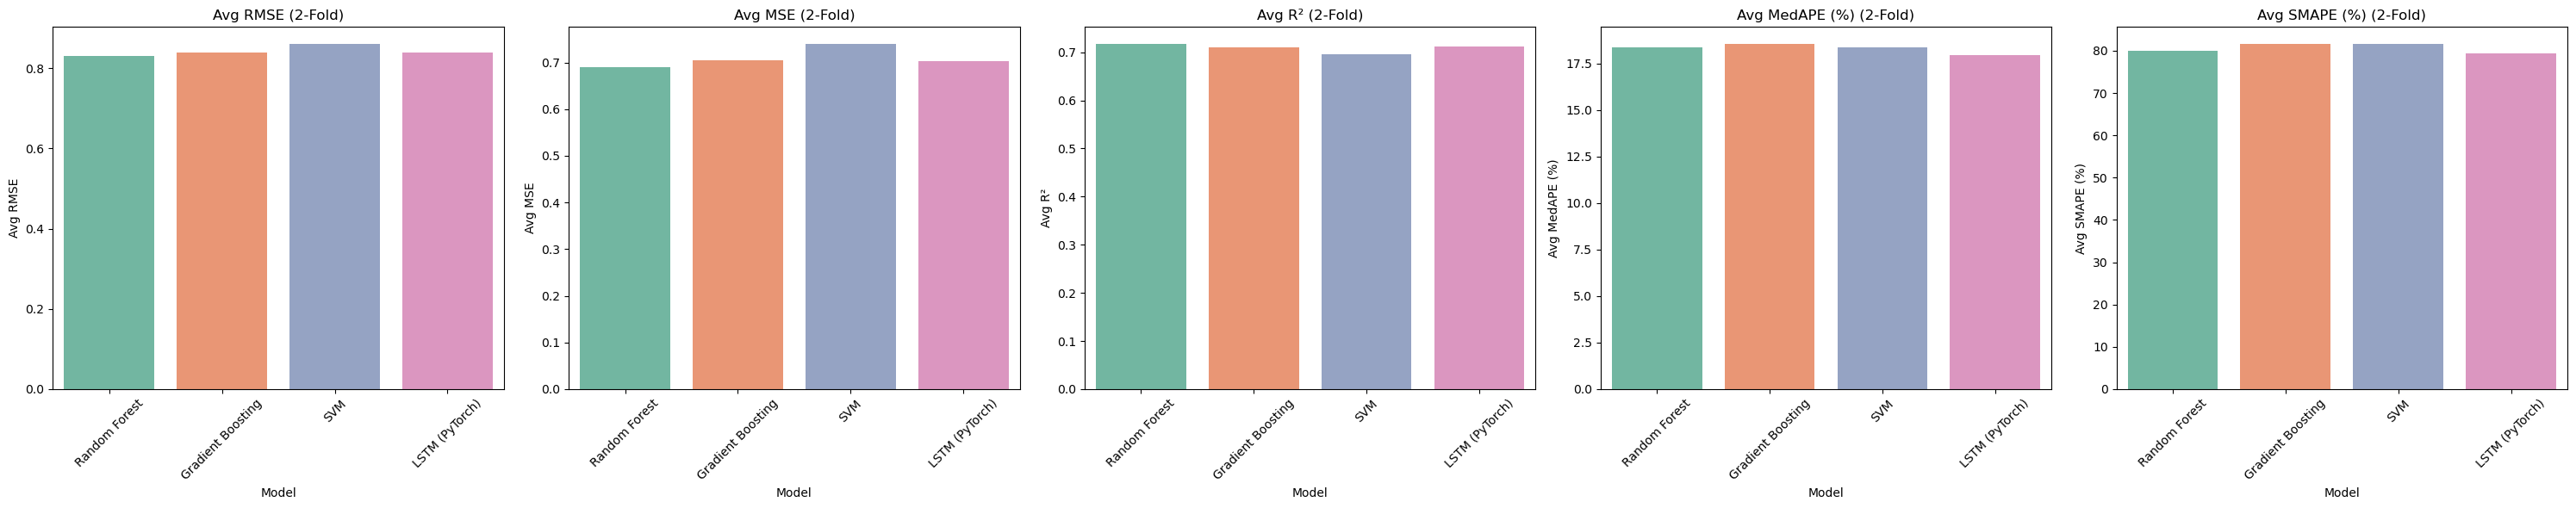


--- Evaluating Blind Set After 2-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8318 0.6920 0.7101     19.2571    81.9812
Gradient Boosting 0.8418 0.7086 0.7031     19.7676    82.9457
              SVM 0.8469 0.7172 0.6995     18.2966    82.7228
   LSTM (PyTorch) 0.8397 0.7051 0.7046     19.4839    81.9340


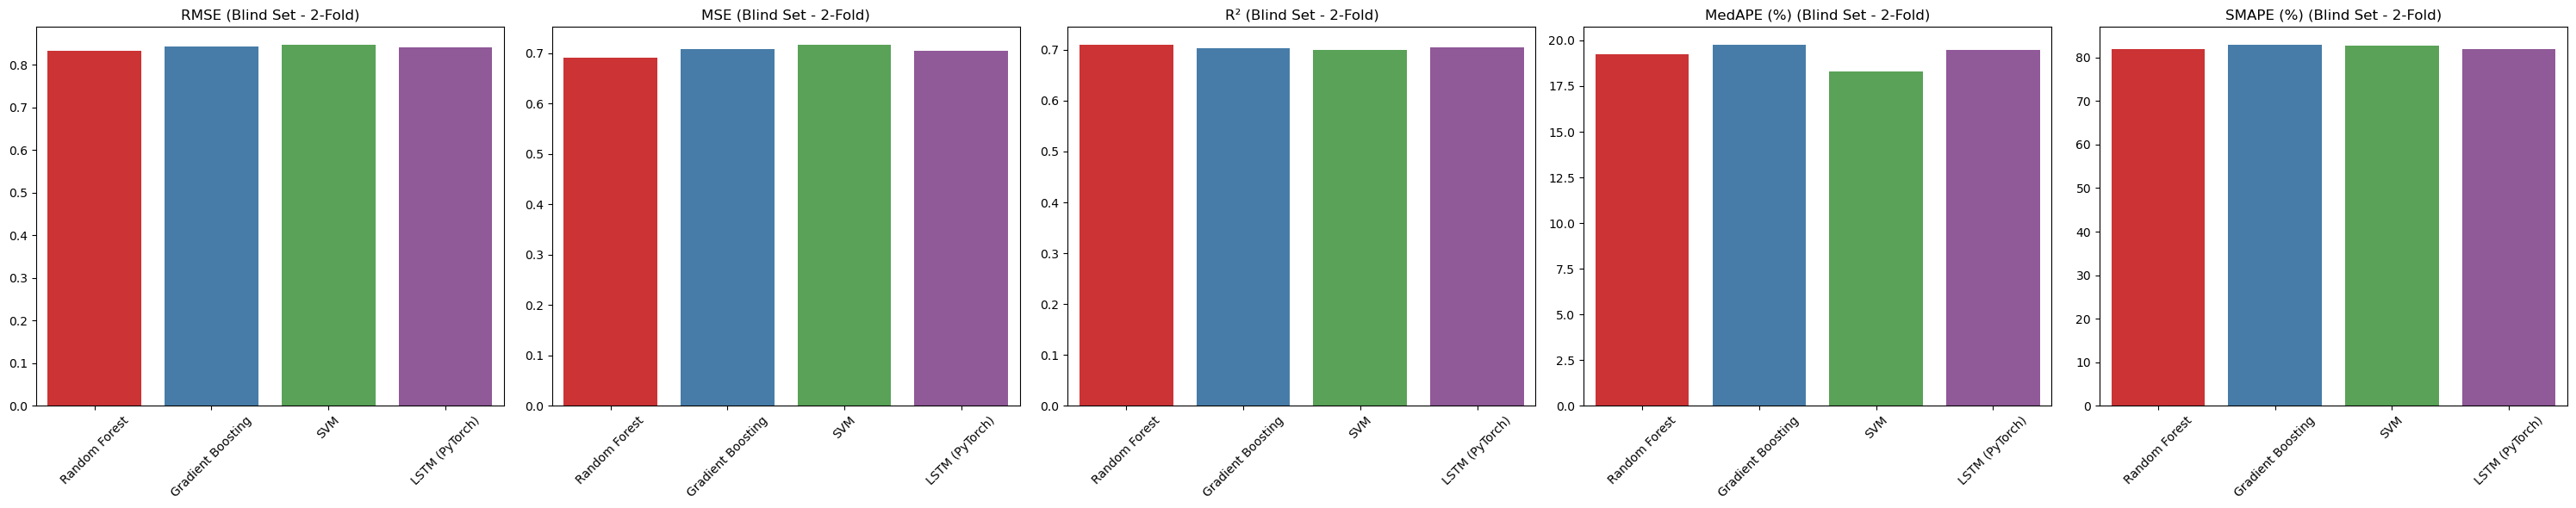


--- 3-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.8041   0.6469  0.7343         17.7428        78.9234
Gradient Boosting    0.8129   0.6609  0.7286         18.6595        80.8828
              SVM    0.8277   0.6851  0.7187         18.3377        80.3264
   LSTM (PyTorch)    0.8292   0.6878  0.7176         17.7991        79.9591


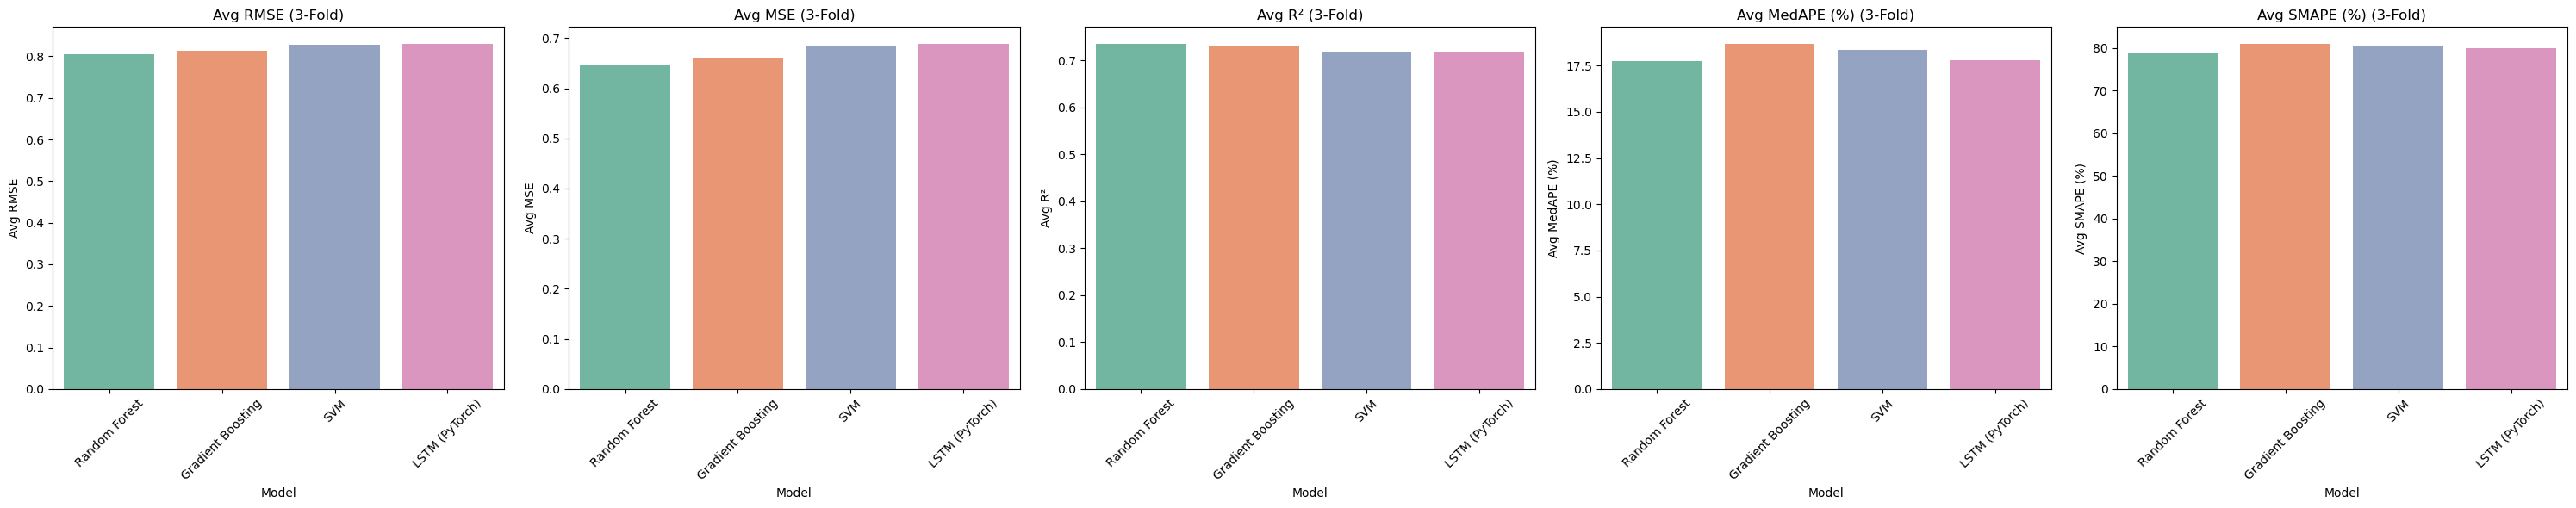


--- Evaluating Blind Set After 3-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8193 0.6712 0.7188     18.3502    80.9031
Gradient Boosting 0.8284 0.6862 0.7126     19.3496    81.6753
              SVM 0.8346 0.6965 0.7082     17.2792    81.9315
   LSTM (PyTorch) 0.8317 0.6917 0.7103     19.6313    82.3786


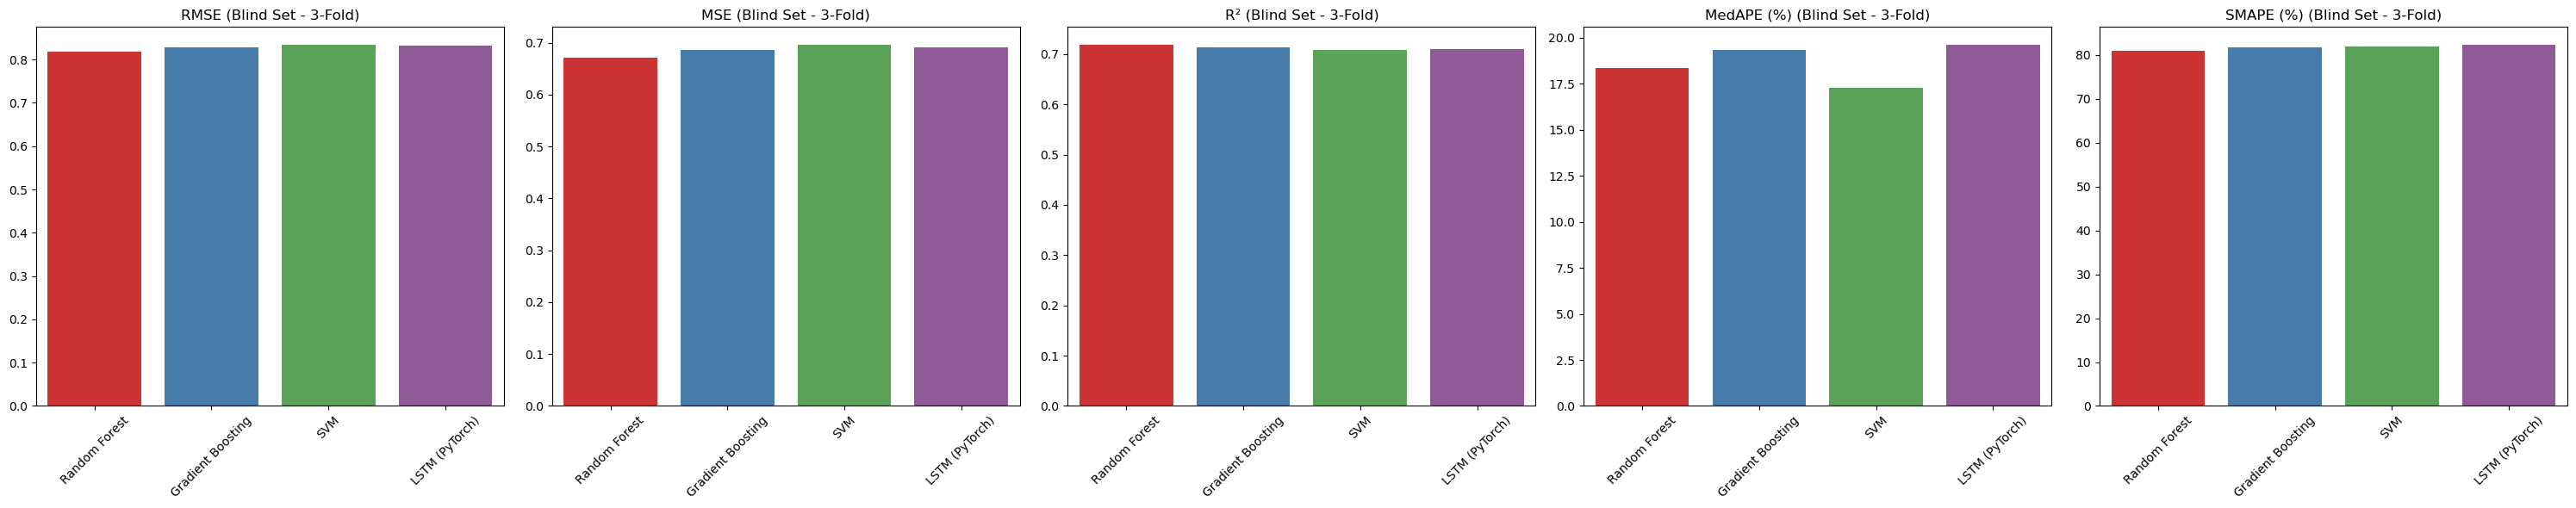


--- 4-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7928   0.6287  0.7418         17.5687        77.6203
Gradient Boosting    0.8068   0.6511  0.7324         18.8292        80.4229
              SVM    0.8181   0.6694  0.7250         17.5108        79.4088
   LSTM (PyTorch)    0.7967   0.6350  0.7393         17.0654        78.4268


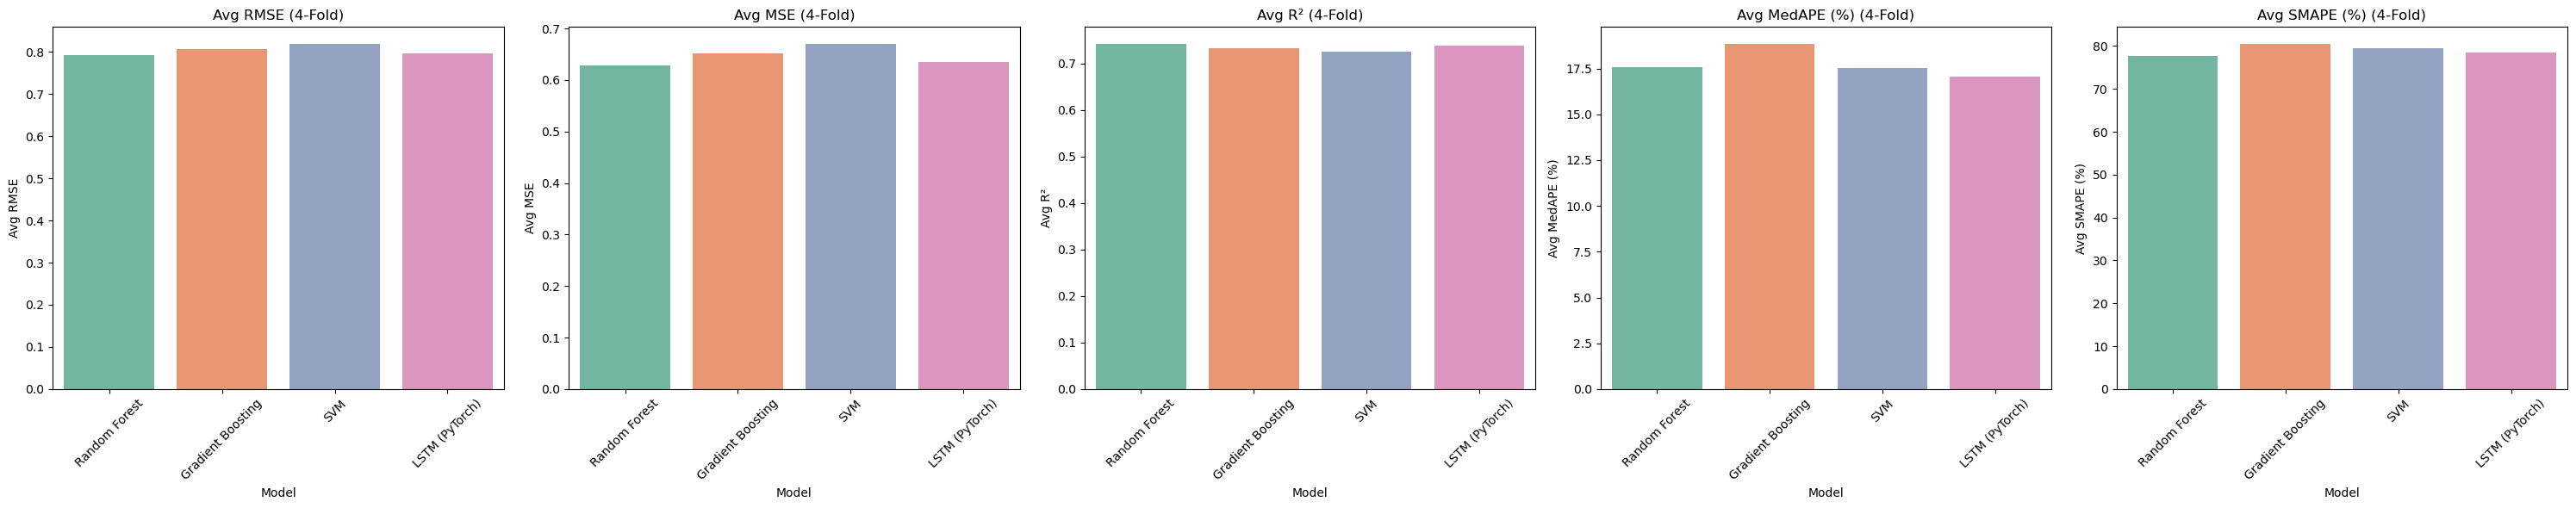


--- Evaluating Blind Set After 4-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8133 0.6615 0.7229     17.3580    79.7938
Gradient Boosting 0.8194 0.6714 0.7188     18.9598    81.5839
              SVM 0.8332 0.6943 0.7092     17.3507    81.1078
   LSTM (PyTorch) 0.8046 0.6473 0.7288     16.3188    79.2607


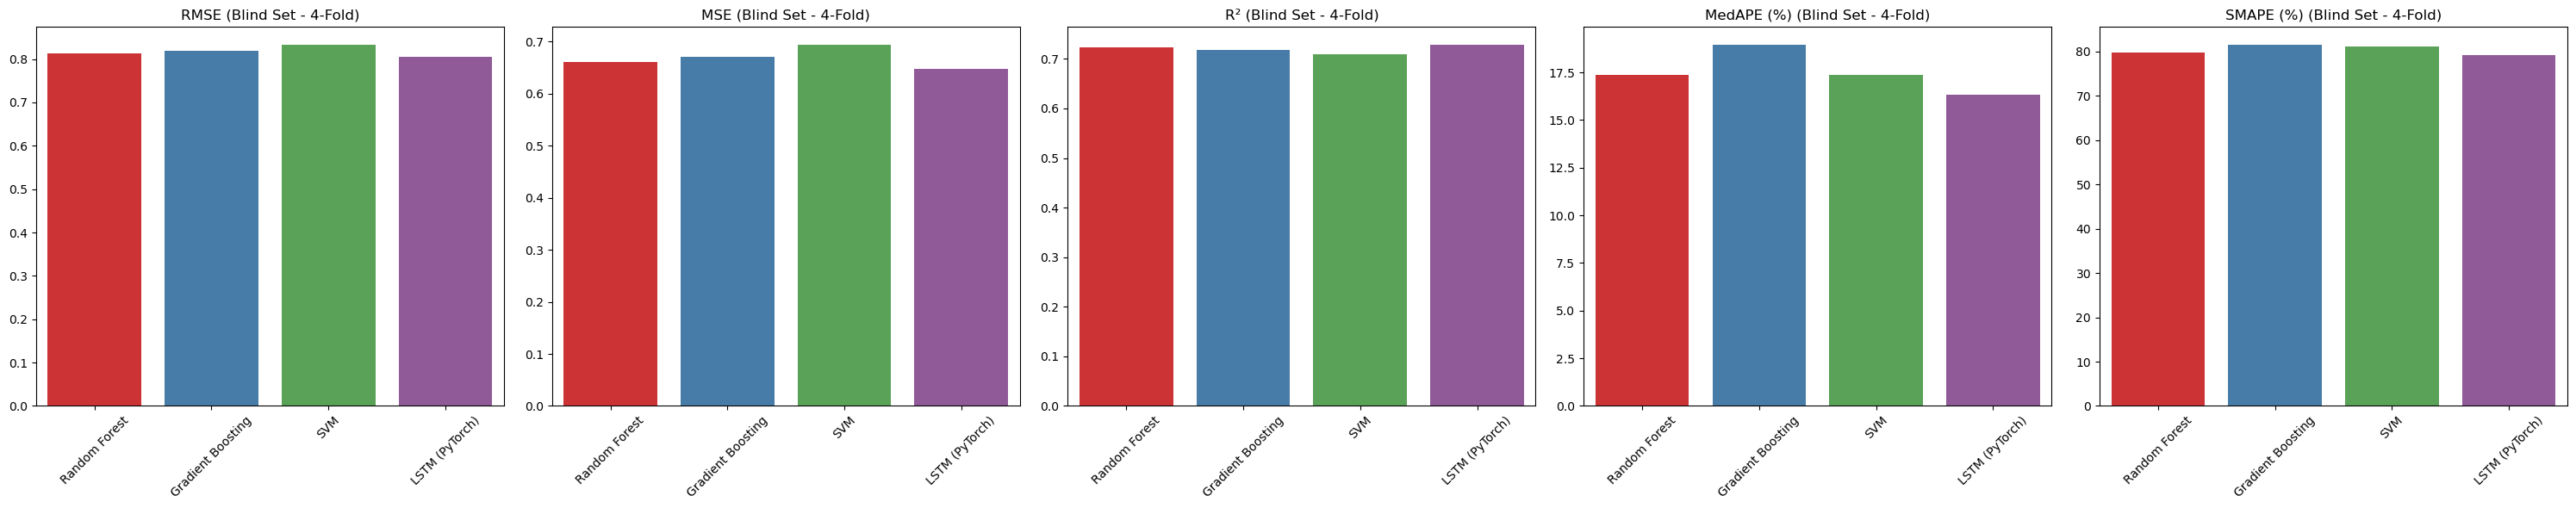


--- 5-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7903   0.6248  0.7431         17.0714        77.1634
Gradient Boosting    0.8087   0.6542  0.7309         18.1469        80.0850
              SVM    0.8126   0.6607  0.7283         17.4019        79.1291
   LSTM (PyTorch)    0.8191   0.6712  0.7239         17.6785        78.9956


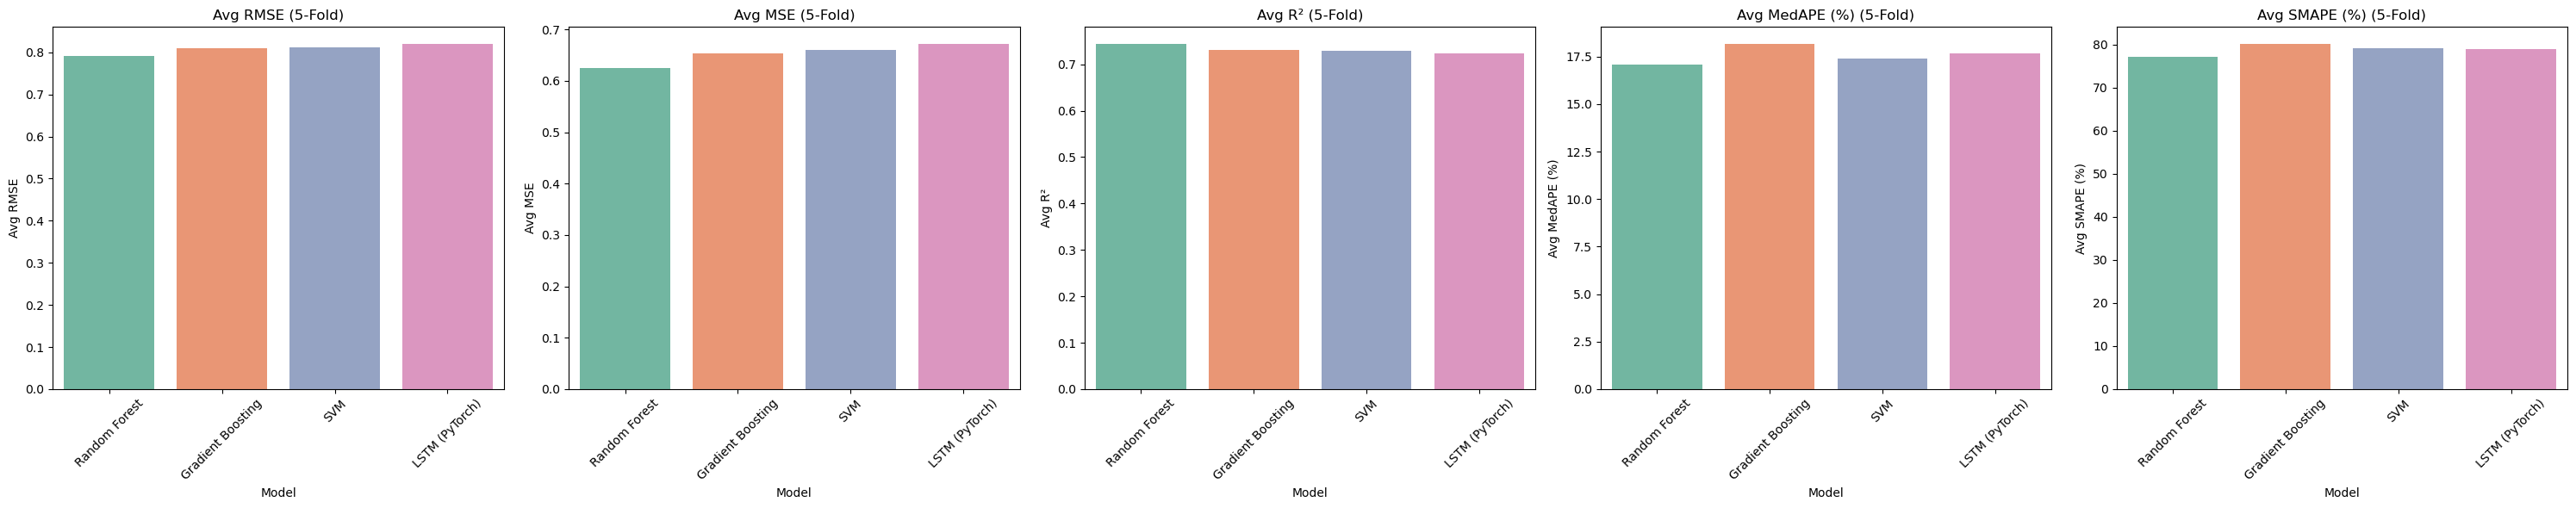


--- Evaluating Blind Set After 5-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8132 0.6612 0.7230     17.0881    79.0780
Gradient Boosting 0.8185 0.6699 0.7194     18.7750    81.9491
              SVM 0.8298 0.6886 0.7115     16.9815    80.3660
   LSTM (PyTorch) 0.7998 0.6397 0.7320     17.0147    78.8508


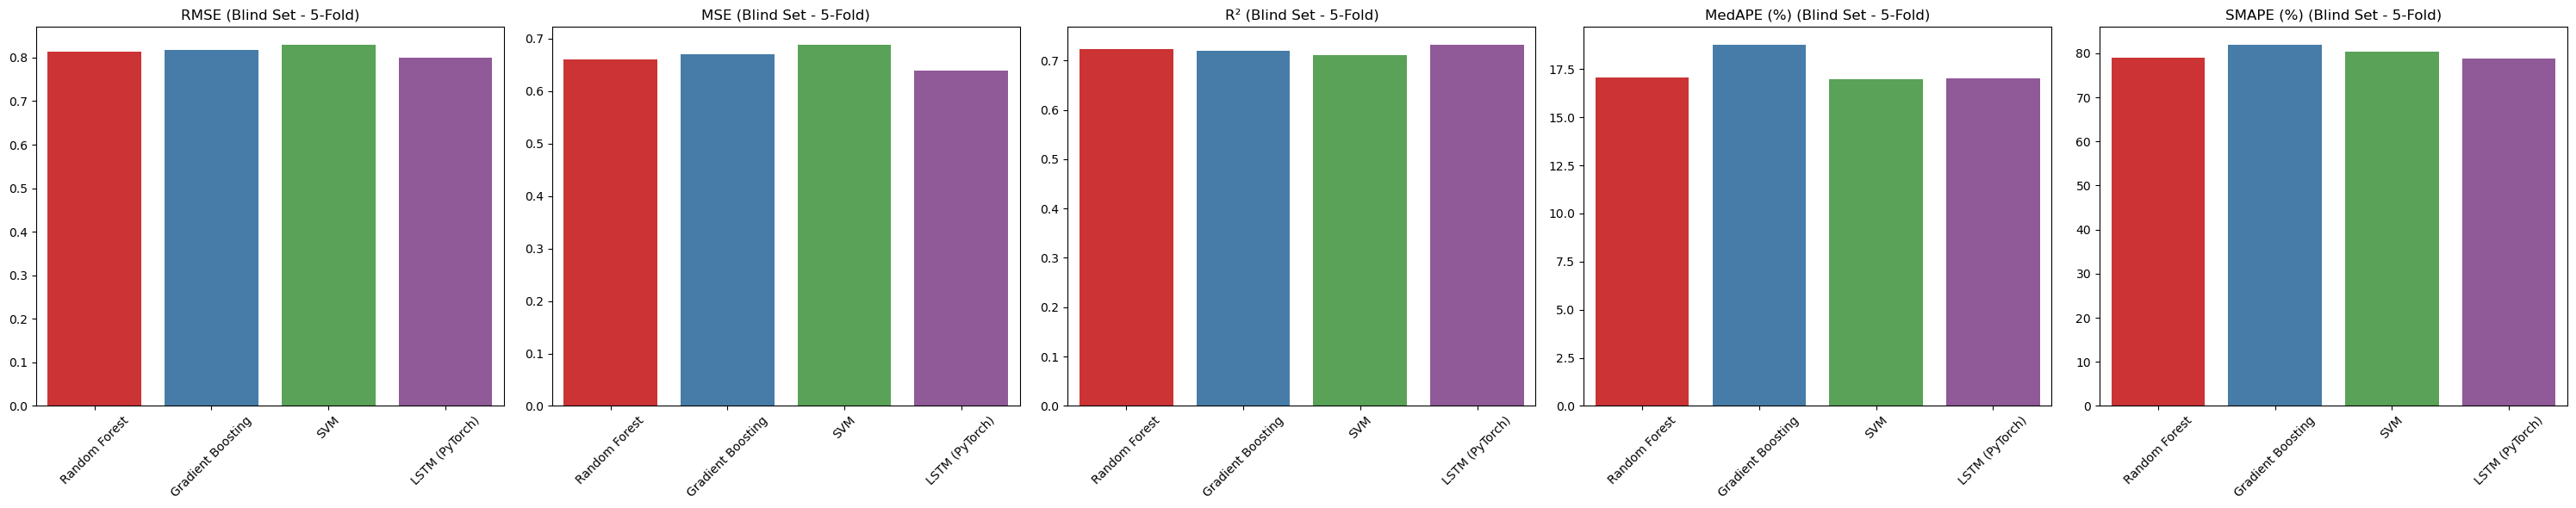


--- 6-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7808   0.6098  0.7490         16.5719        76.5058
Gradient Boosting    0.8066   0.6508  0.7314         18.6352        79.8760
              SVM    0.8087   0.6541  0.7304         17.1598        78.9577
   LSTM (PyTorch)    0.8172   0.6682  0.7249         17.4682        78.9627


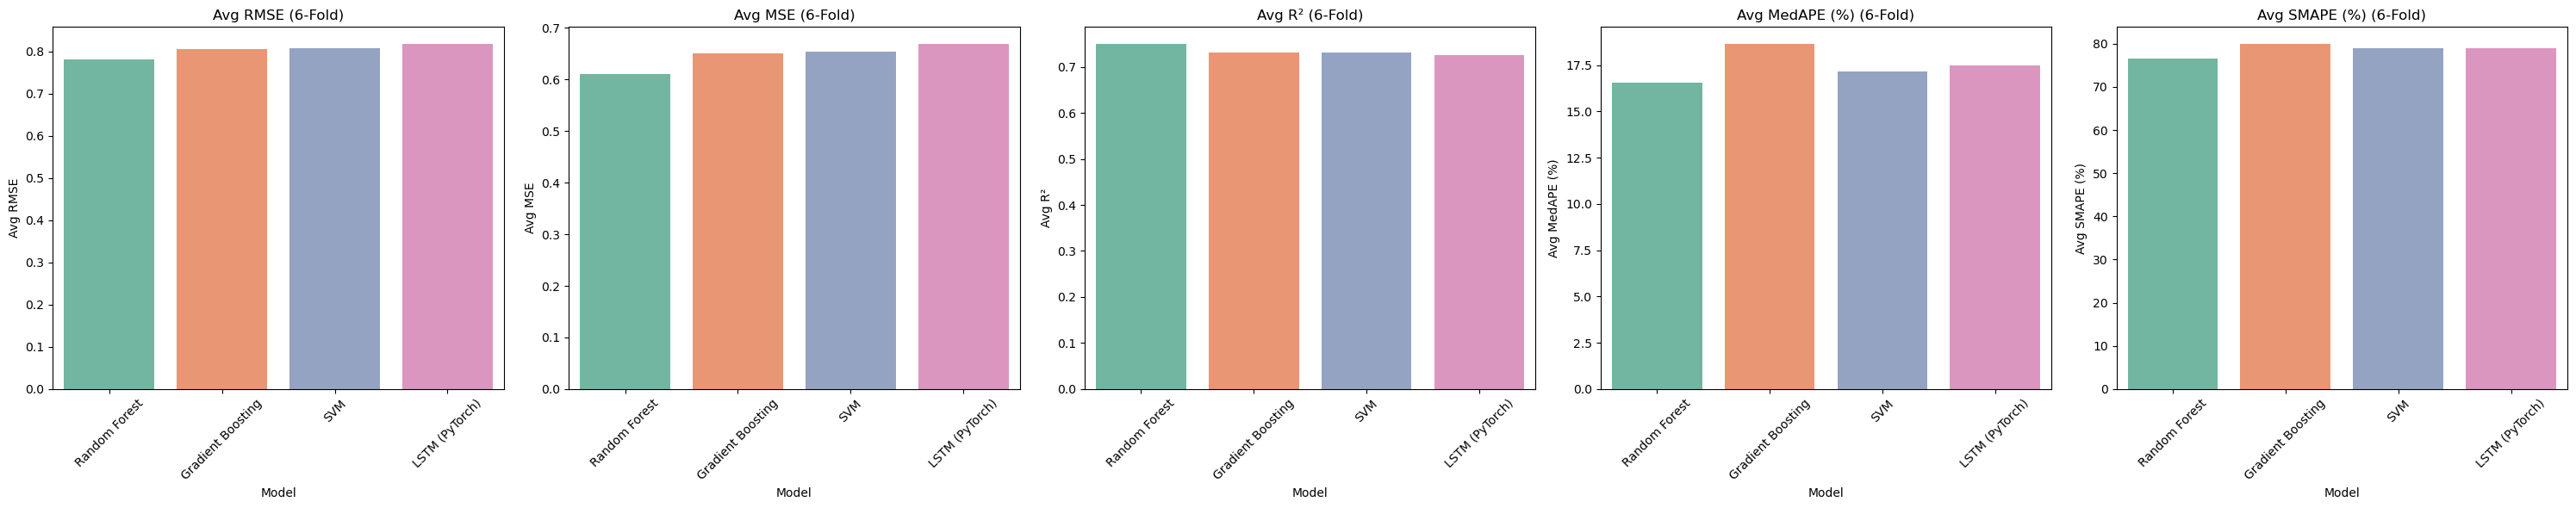


--- Evaluating Blind Set After 6-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7991 0.6385 0.7325     16.5196    79.0845
Gradient Boosting 0.8157 0.6653 0.7213     17.8290    81.4344
              SVM 0.8269 0.6837 0.7136     16.2511    80.0064
   LSTM (PyTorch) 0.7854 0.6168 0.7416     17.6698    80.4095


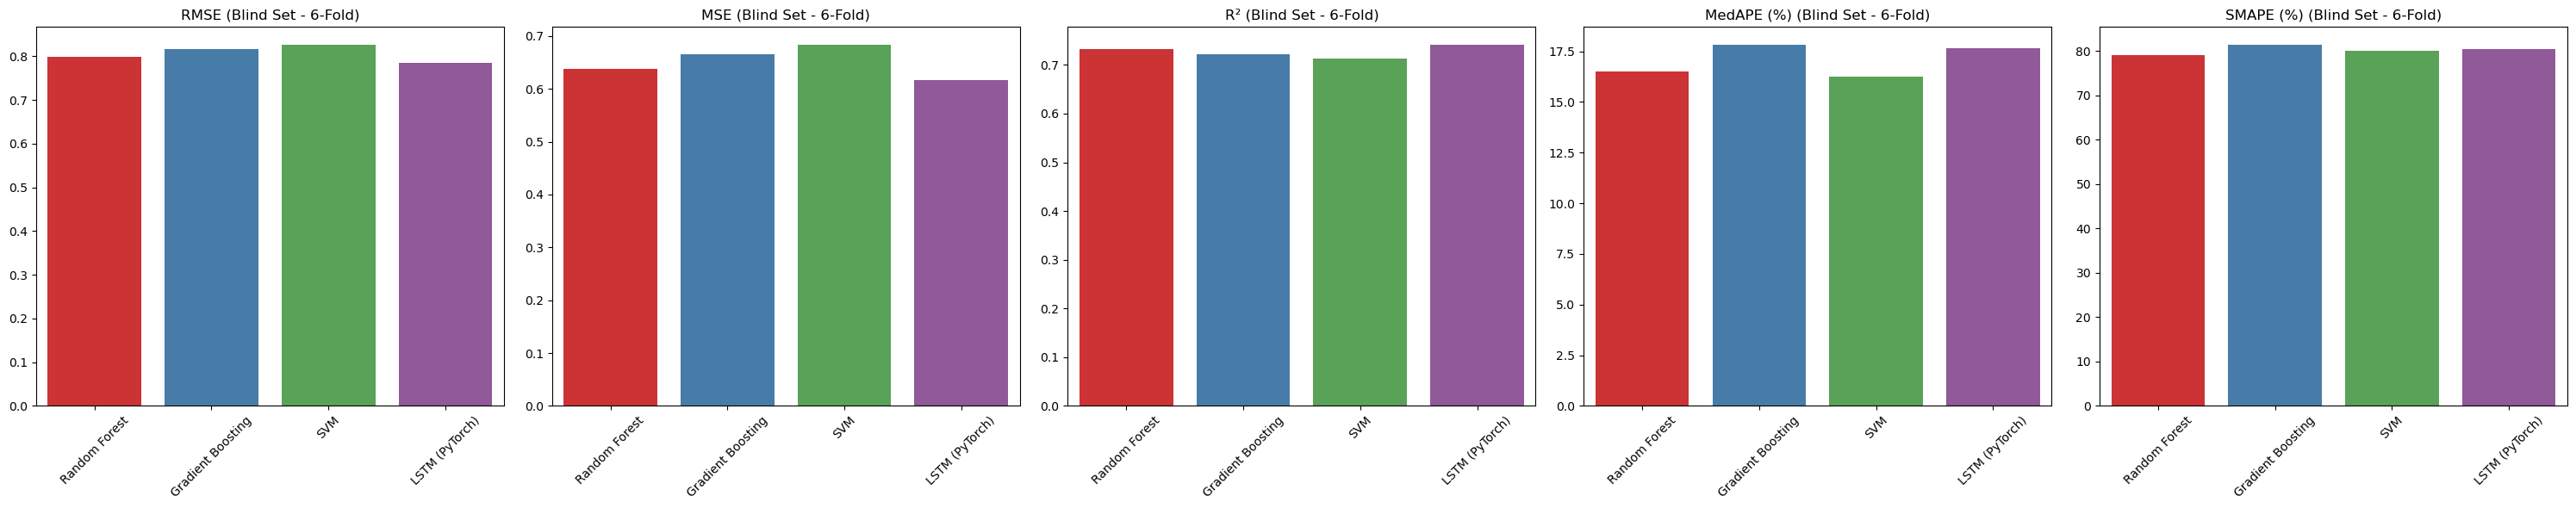


--- 7-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7849   0.6166  0.7464         16.8352        76.3880
Gradient Boosting    0.8107   0.6578  0.7290         18.1164        79.5318
              SVM    0.8080   0.6531  0.7310         17.2001        78.6876
   LSTM (PyTorch)    0.8138   0.6624  0.7273         17.7269        78.5441


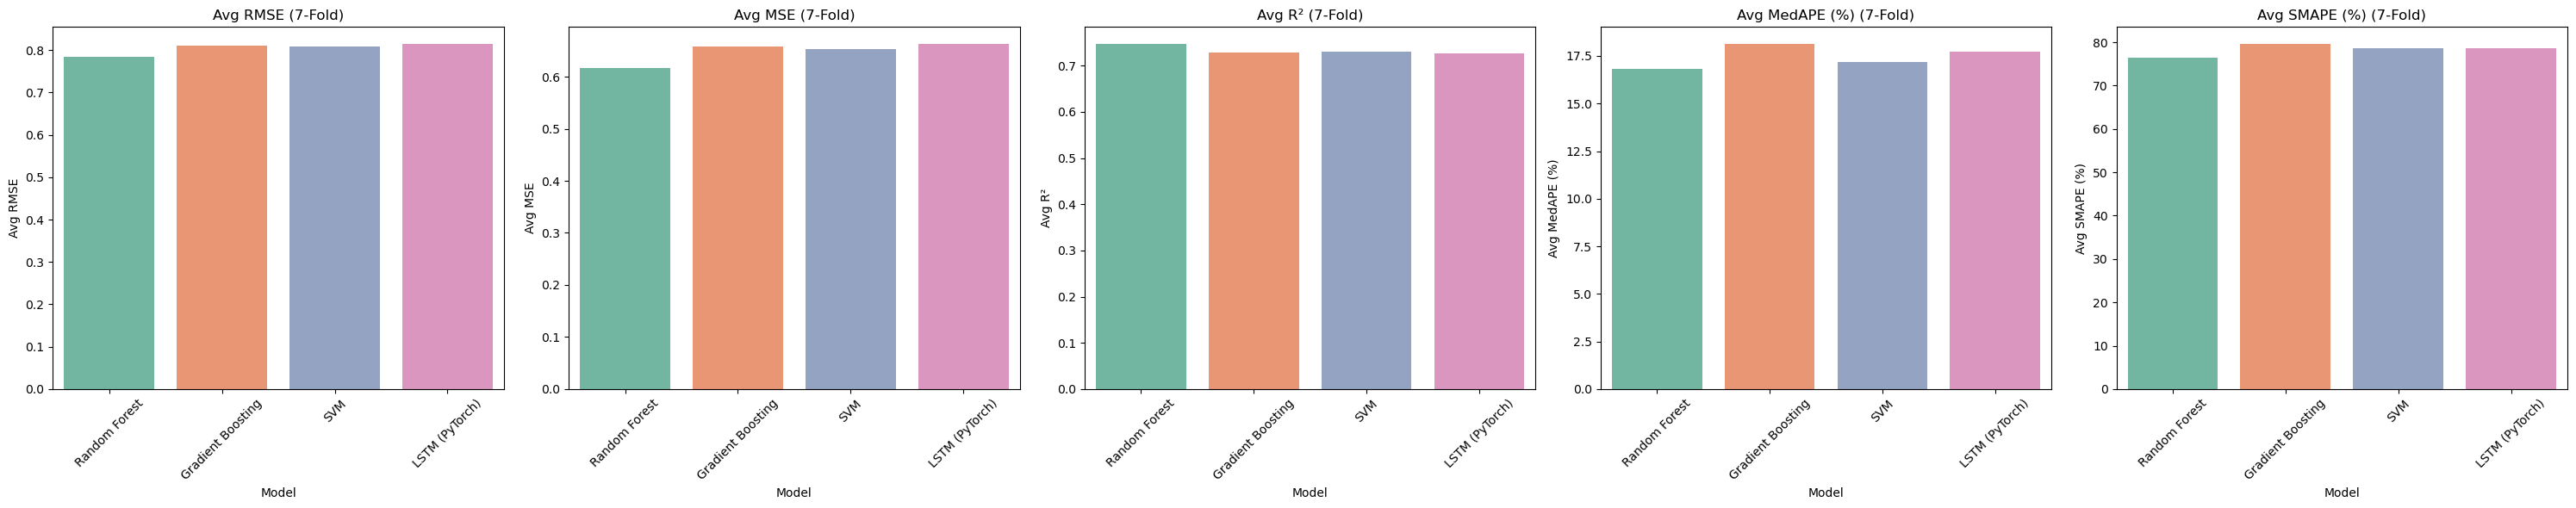


--- Evaluating Blind Set After 7-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7982 0.6371 0.7331     16.3899    78.7106
Gradient Boosting 0.8190 0.6708 0.7190     17.2375    79.9327
              SVM 0.8232 0.6776 0.7161     15.9622    79.5238
   LSTM (PyTorch) 0.7763 0.6027 0.7475     16.4765    79.9479


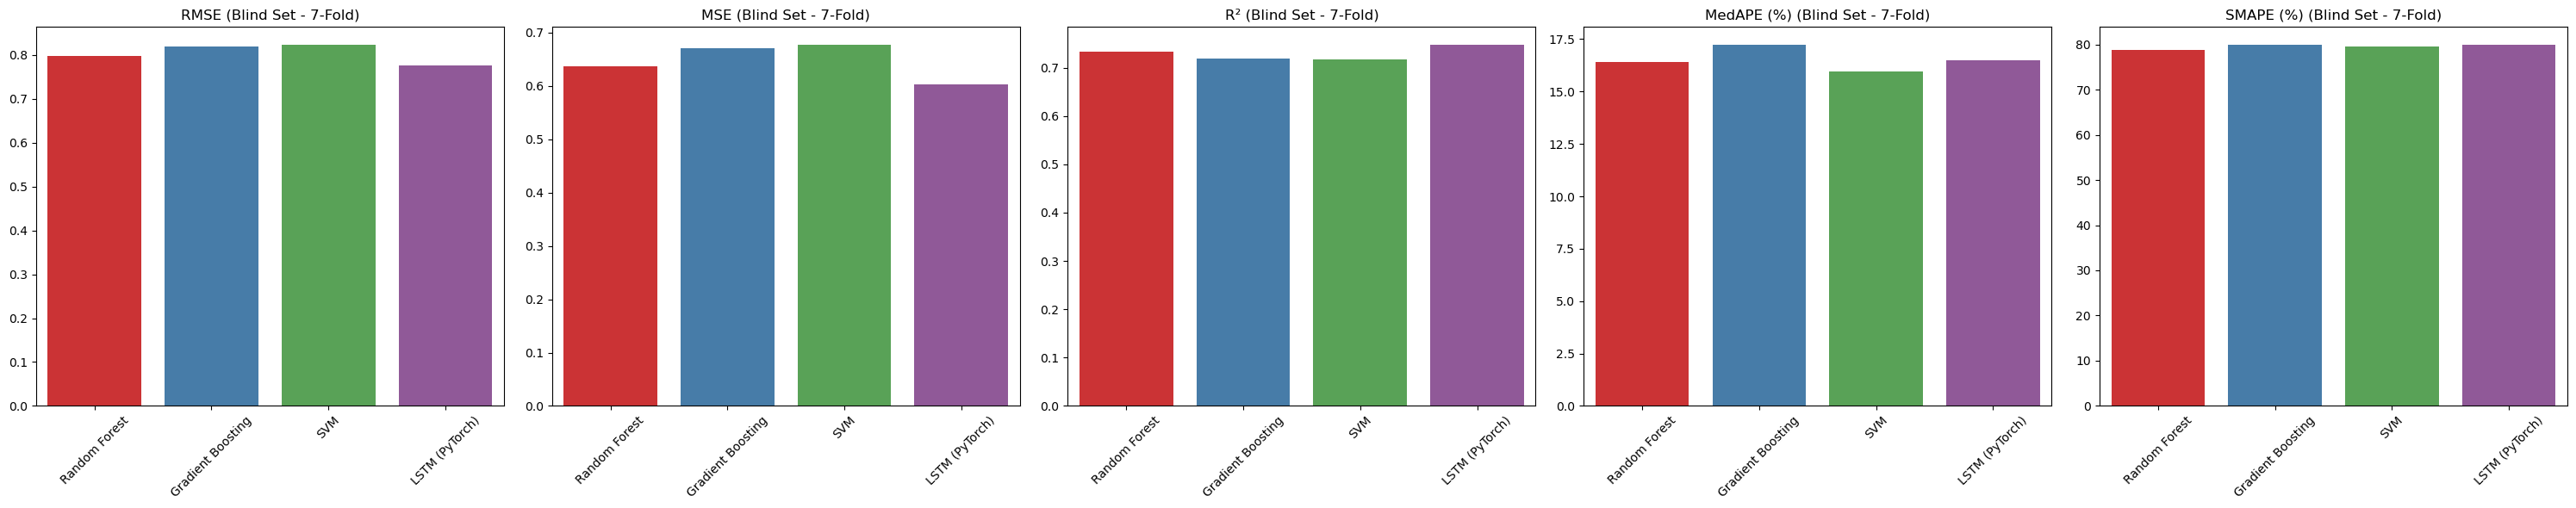


--- 8-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7837   0.6152  0.7472         16.7356        76.1451
Gradient Boosting    0.8052   0.6494  0.7328         18.7734        80.4595
              SVM    0.8099   0.6564  0.7299         17.1373        78.6925
   LSTM (PyTorch)    0.7919   0.6284  0.7418         17.0691        77.8212


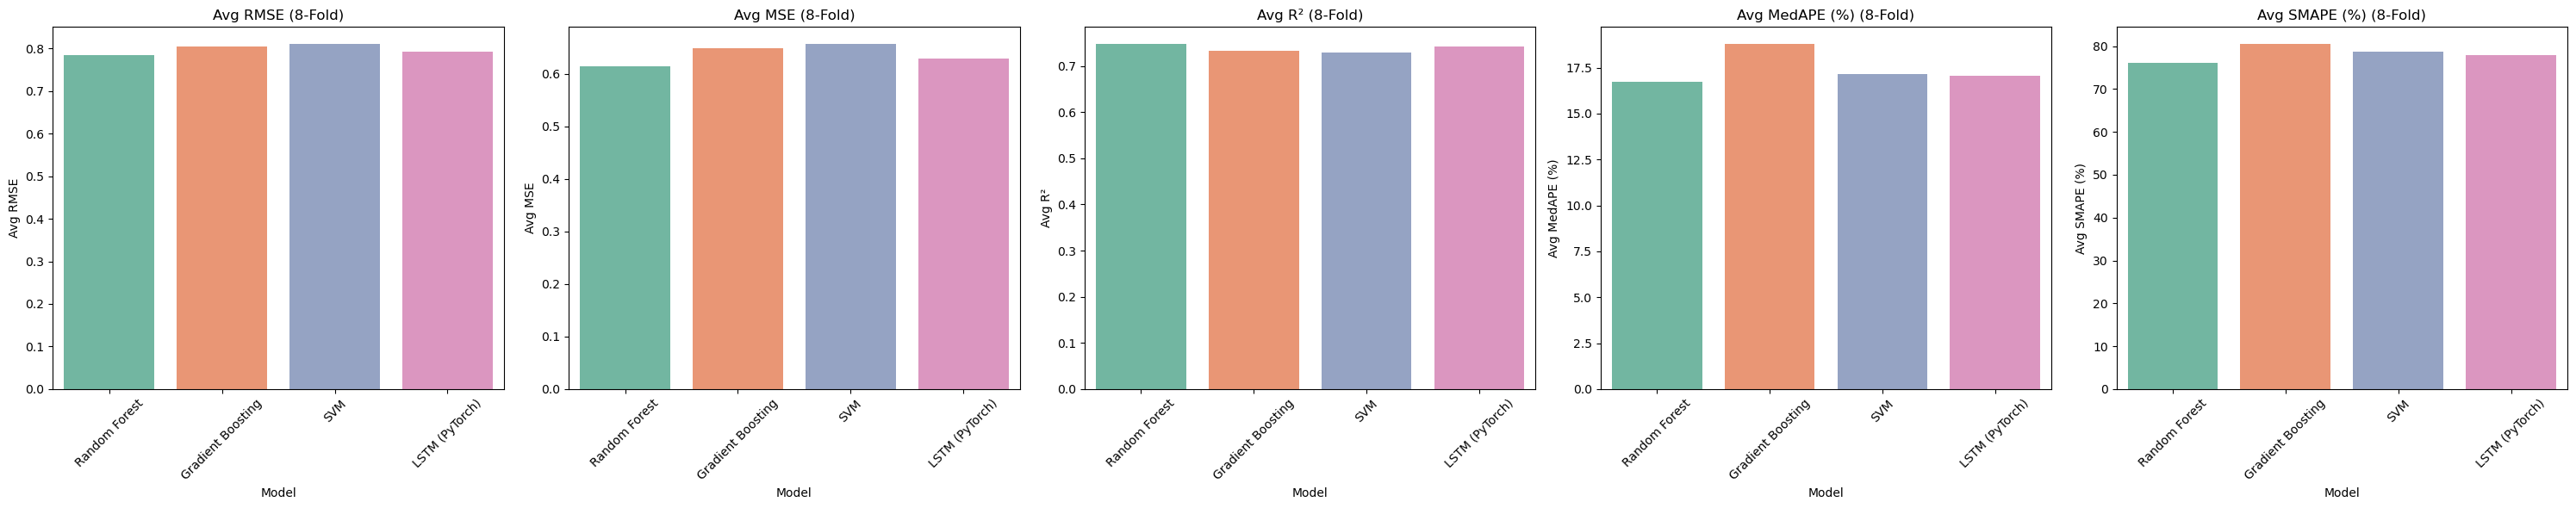


--- Evaluating Blind Set After 8-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8027 0.6444 0.7301     16.4908    78.5860
Gradient Boosting 0.8109 0.6575 0.7246     18.1899    80.6279
              SVM 0.8230 0.6774 0.7163     15.9812    79.0867
   LSTM (PyTorch) 0.7882 0.6213 0.7397     18.5012    79.3905


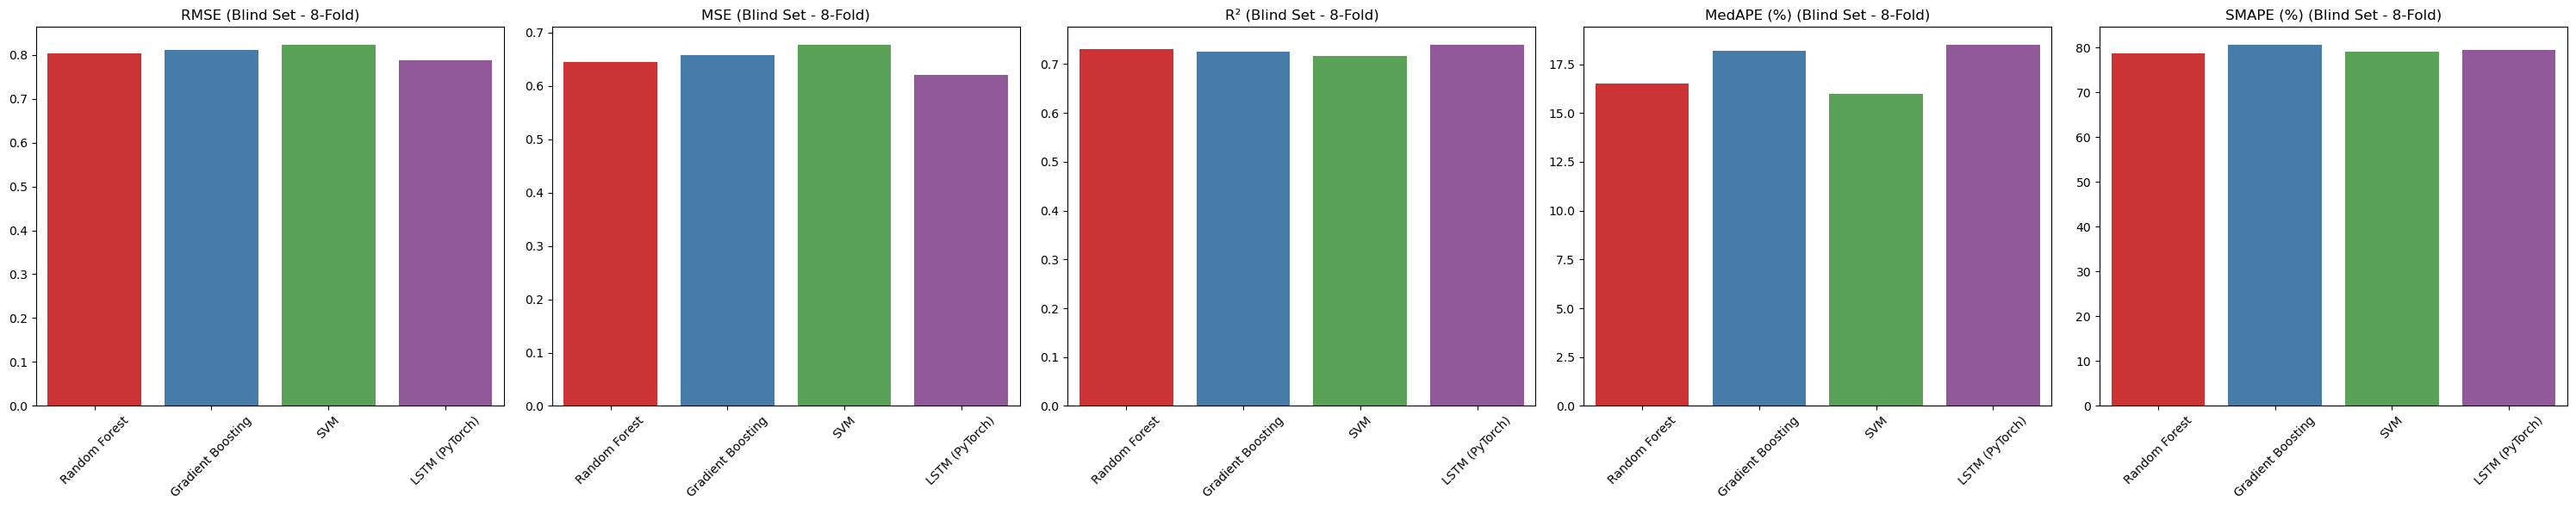


--- 9-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7820   0.6124  0.7480         16.6276        76.7069
Gradient Boosting    0.8096   0.6561  0.7294         18.1616        80.1187
              SVM    0.8075   0.6526  0.7315         17.2445        78.7770
   LSTM (PyTorch)    0.8036   0.6464  0.7338         17.1023        77.8354


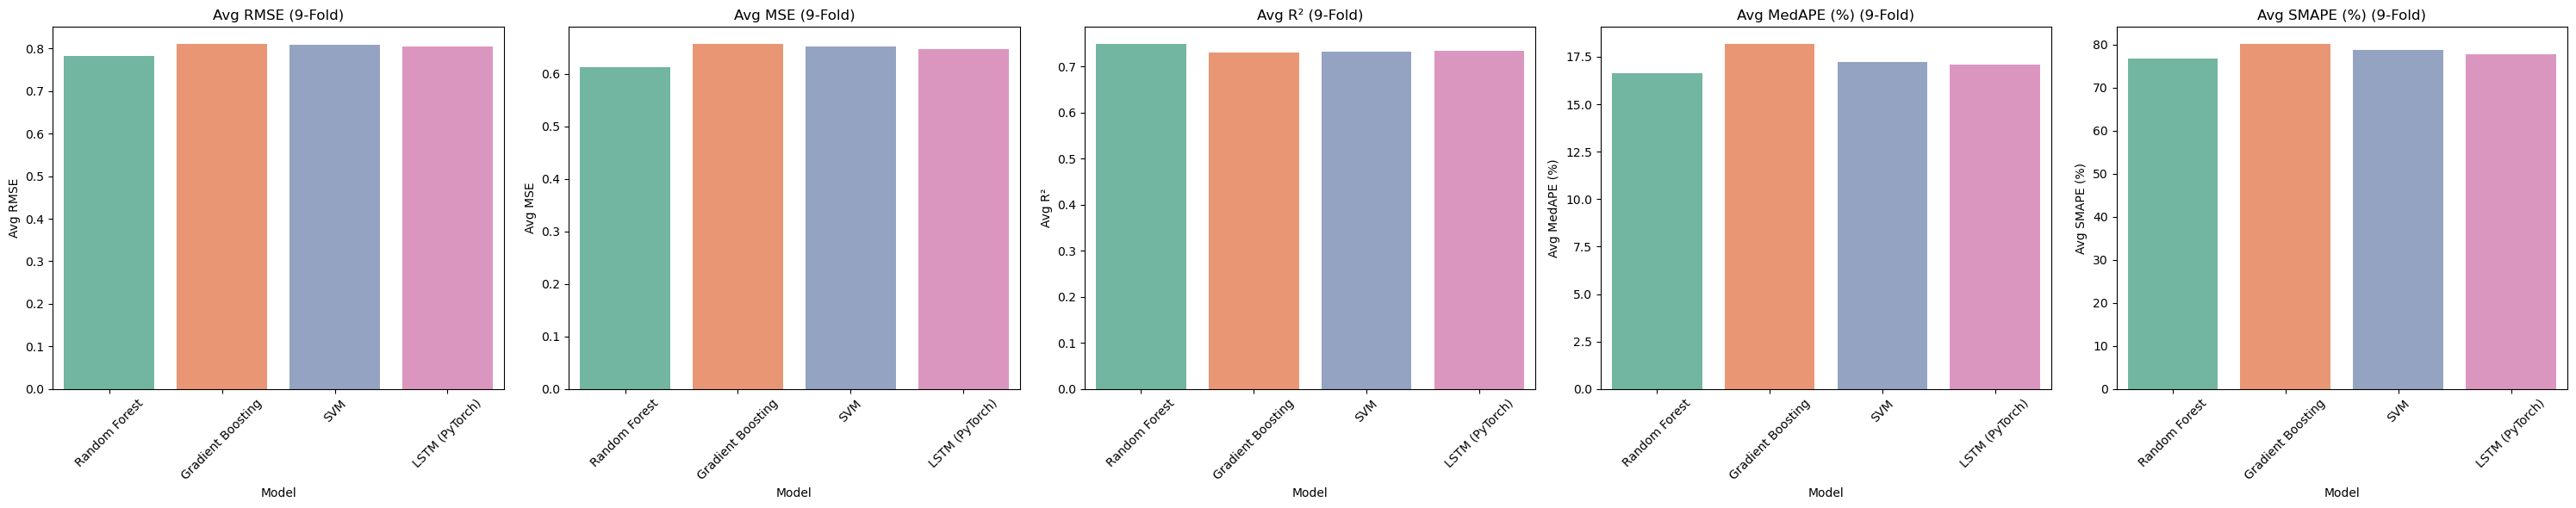


--- Evaluating Blind Set After 9-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8008 0.6412 0.7314     16.4448    79.2043
Gradient Boosting 0.8091 0.6546 0.7258     17.4756    79.8383
              SVM 0.8194 0.6714 0.7187     16.3089    79.2809
   LSTM (PyTorch) 0.7809 0.6098 0.7446     18.5073    80.1949


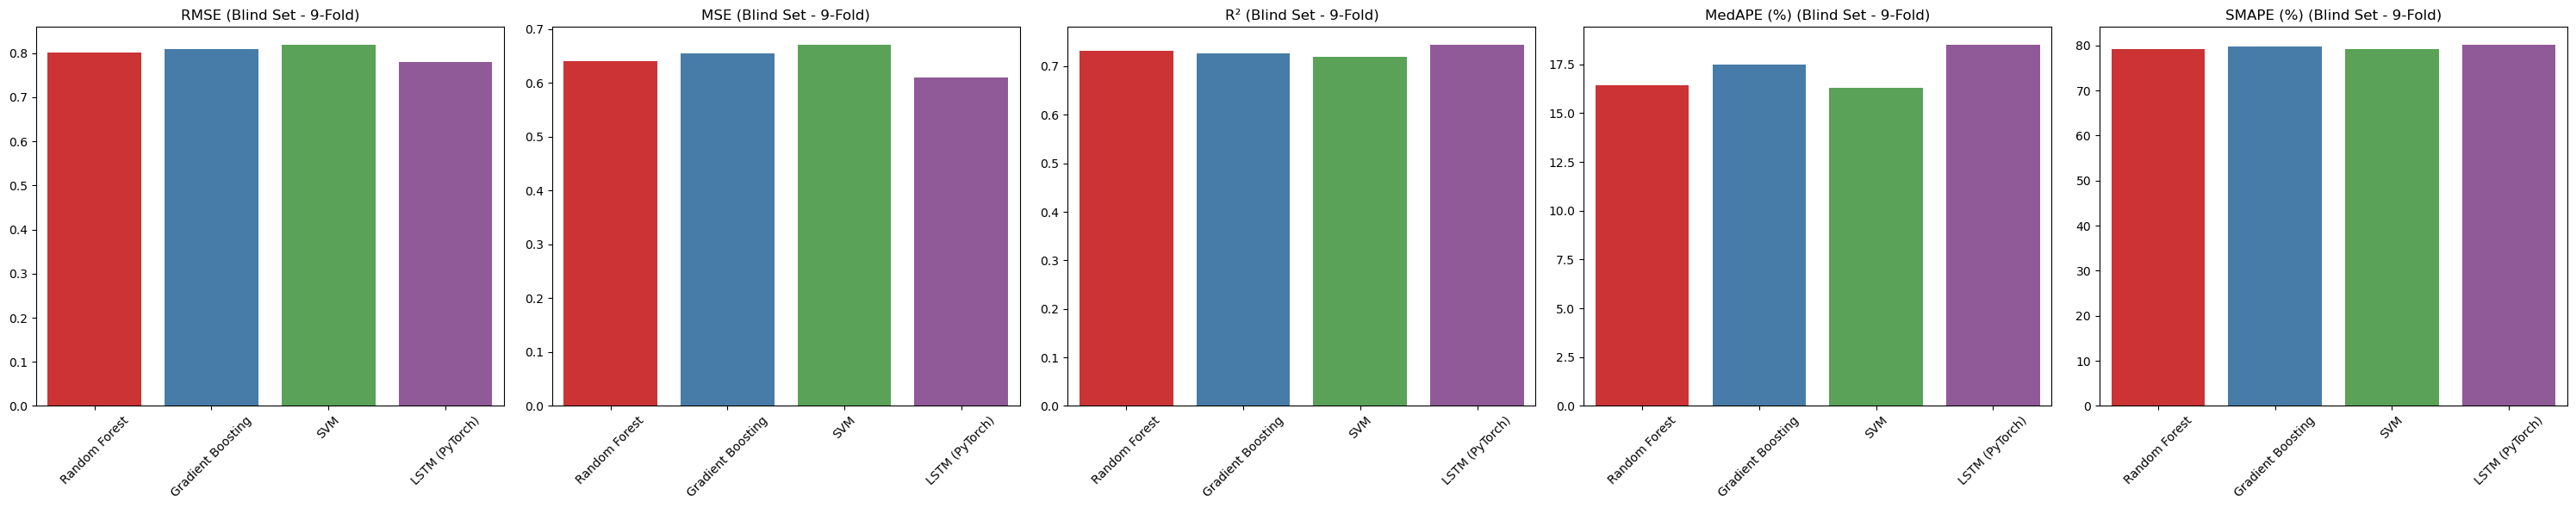


--- 10-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7838   0.6152  0.7467         16.7042        76.2175
Gradient Boosting    0.8108   0.6585  0.7285         18.3073        80.2463
              SVM    0.8075   0.6532  0.7310         17.2731        78.4776
   LSTM (PyTorch)    0.8056   0.6503  0.7325         17.5499        78.1882


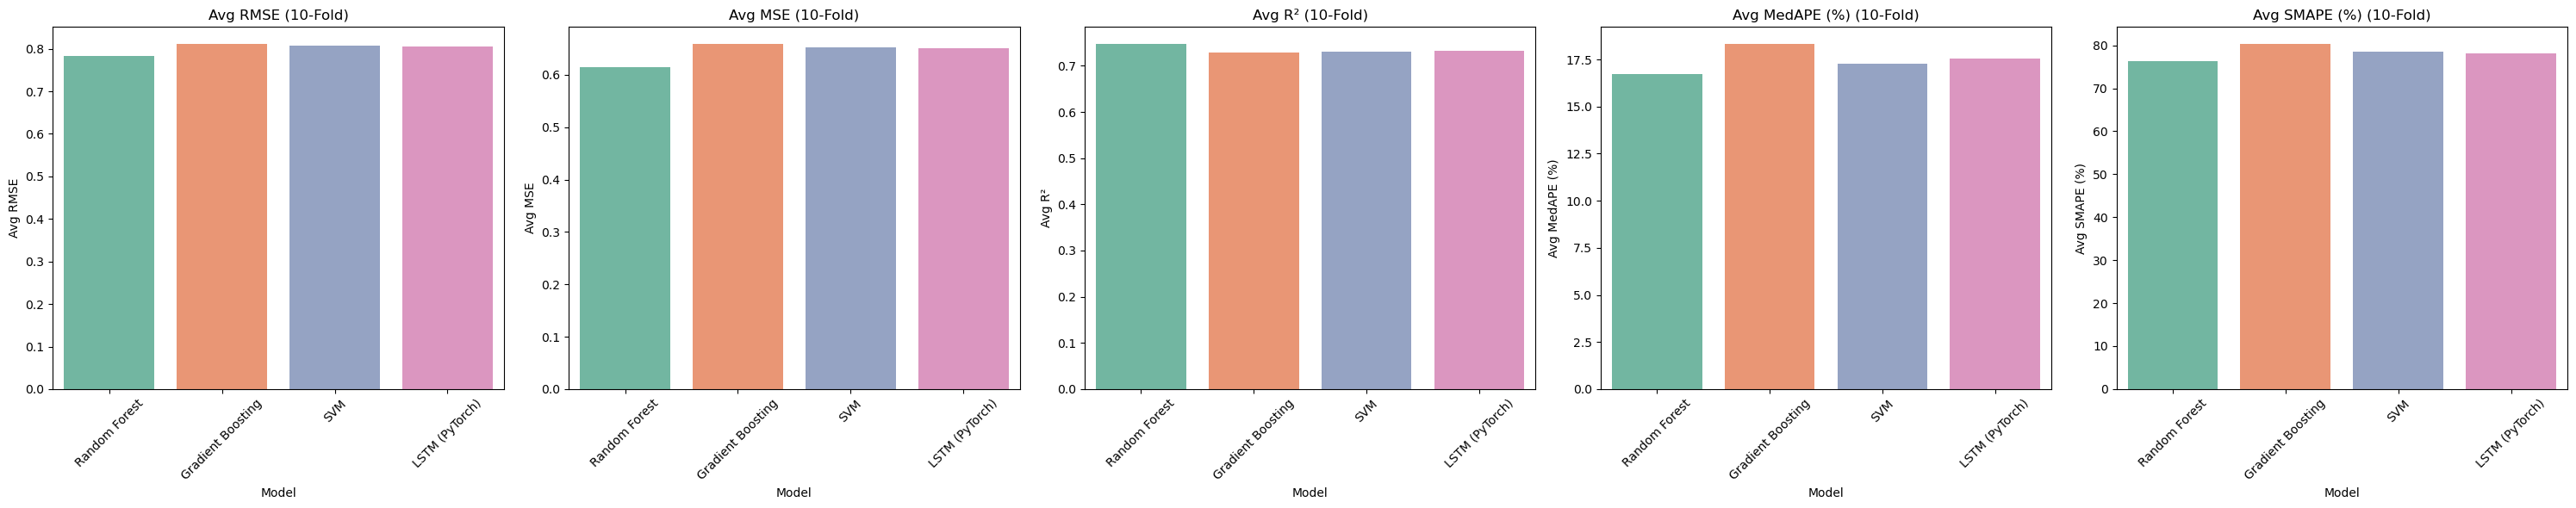


--- Evaluating Blind Set After 10-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.7983 0.6373 0.7330     16.9109    78.9585
Gradient Boosting 0.8207 0.6736 0.7178     18.0580    80.7082
              SVM 0.8197 0.6719 0.7185     16.2833    79.3225
   LSTM (PyTorch) 0.7939 0.6303 0.7360     18.6228    81.2217


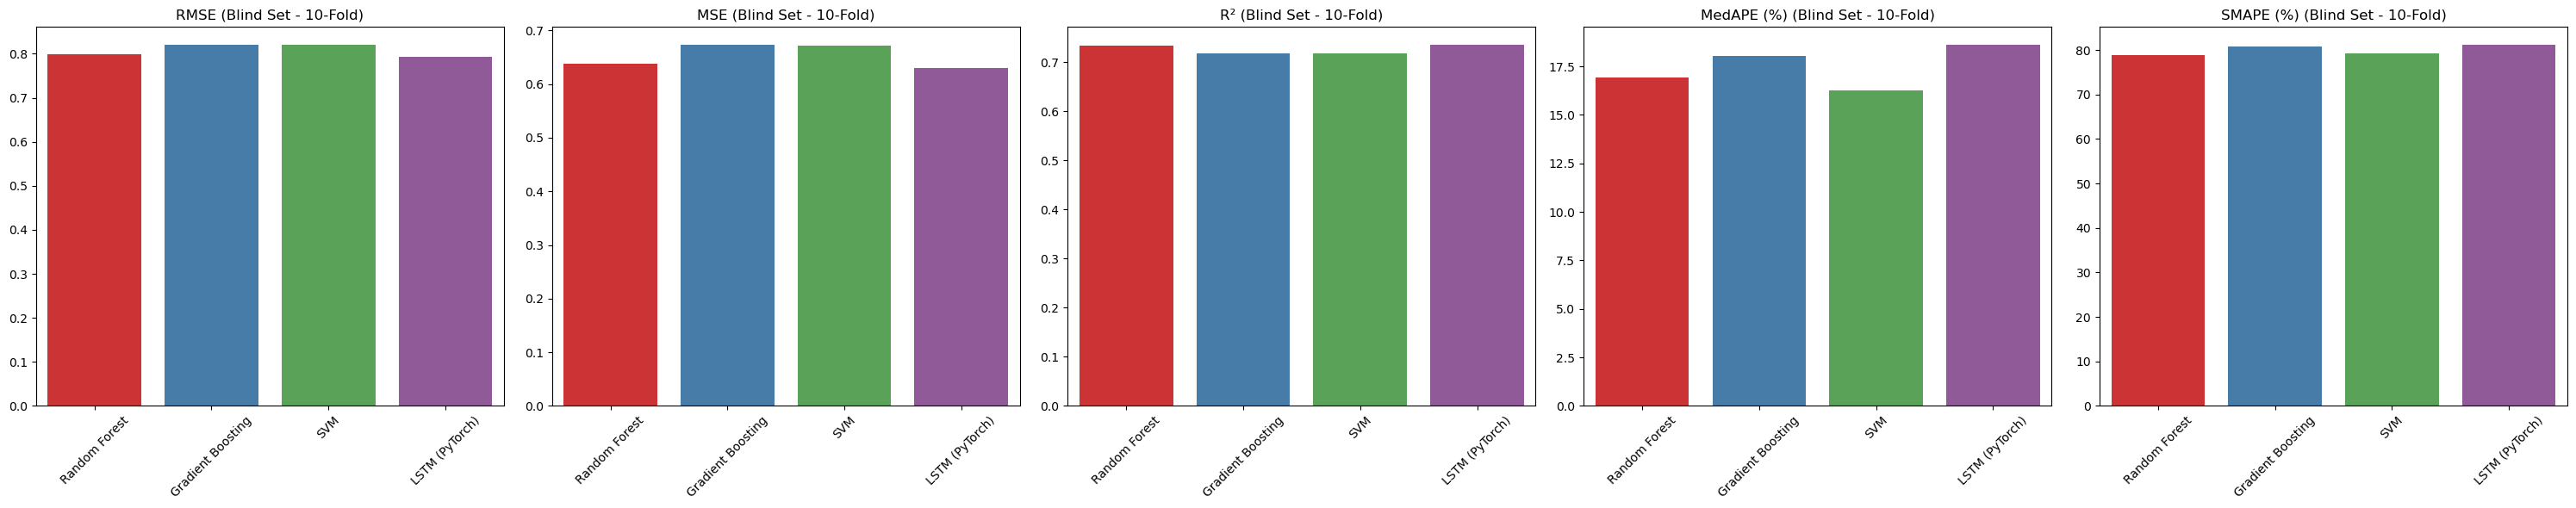

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# === Metrics ===
def medape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > epsilon
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.sum(mask) else np.nan

def smape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator < epsilon, epsilon, denominator)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# === LSTM ===
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, activation='relu'):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.activation = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid(), 'leaky_relu': nn.LeakyReLU()}.get(activation)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(self.activation(out)) if self.activation else self.fc(out)

def train_model(model, train_loader, val_loader, epochs=200, patience=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss, best_state, patience_counter = float('inf'), None, 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = np.mean([criterion(model(xb), yb).item() for xb, yb in val_loader])
        if val_loss < best_loss:
            best_loss, best_state = val_loss, model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return model

# === Load your data ===
# rdkit_train = pd.read_csv('rdkit_train.csv')
# rdkit_blind = pd.read_csv('rdkit_blind.csv')

# === Parameters ===
drop_cols = ['chembl_id', 'smiles', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name']
#rf_best_params = {'n_estimators': 200, 'random_state': 42}
#lstm_best_params = {'hidden_size': 64, 'num_layers': 2, 'activation': 'relu', 'learning_rate': 0.001, 'batch_size': 32}
metrics = ['RMSE', 'MSE', 'R²', 'MedAPE', 'SMAPE']

# === Prepare Training Set ===
y = rdkit_train['log_ic50']
X = rdkit_train.drop(columns=[col for col in drop_cols if col in rdkit_train.columns])
X = X.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X.mean())

selector = VarianceThreshold(0.01)
X_selected = selector.fit_transform(X)

# === Prepare Blind Set ===
X_blind = rdkit_blind.drop(columns=[col for col in drop_cols if col in rdkit_blind.columns])
X_blind = X_blind.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X_blind.mean())
X_blind_selected = selector.transform(X_blind)

# === Models ===
models = {
    'Random Forest': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'SVM': SVR(),
    'LSTM (PyTorch)': None  # will instantiate per fold
}

# === Cross-validation and Blind Evaluation ===
for k in range(2, 11):
    print(f"\n--- {k}-Fold Cross Validation ---")
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = {metric: {m: [] for m in models} for metric in metrics}

    for train_idx, test_idx in kf.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Classic models
        for name, model in models.items():
            if name == 'LSTM (PyTorch)':
                continue
            model.fit(X_train_scaled, y_train)
            y_pred = np.maximum(model.predict(X_test_scaled), 0)
            scores['RMSE'][name].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            scores['MSE'][name].append(mean_squared_error(y_test, y_pred))
            scores['R²'][name].append(r2_score(y_test, y_pred))
            scores['MedAPE'][name].append(medape(y_test, y_pred))
            scores['SMAPE'][name].append(smape(np.expm1(y_test), np.expm1(y_pred)))

        # LSTM
        X_train_seq = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
        X_test_seq = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

        train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
        test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

        train_ds, val_ds = random_split(TensorDataset(train_tensor, y_train_tensor), [int(0.8*len(train_tensor)), len(train_tensor) - int(0.8*len(train_tensor))])
        train_loader = DataLoader(train_ds, batch_size=lstm_best_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=lstm_best_params['batch_size'])

        lstm = LSTMRegressor(
            input_size=train_tensor.shape[2],
            hidden_size=lstm_best_params['hidden_size'],
            num_layers=lstm_best_params['num_layers'],
            activation=lstm_best_params['activation']
        )
        lstm = train_model(lstm, train_loader, val_loader, lr=lstm_best_params['learning_rate'])
        lstm.eval()
        with torch.no_grad():
            y_pred_lstm = torch.clamp(lstm(test_tensor), min=0).squeeze().numpy()

        scores['RMSE']['LSTM (PyTorch)'].append(np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
        scores['MSE']['LSTM (PyTorch)'].append(mean_squared_error(y_test, y_pred_lstm))
        scores['R²']['LSTM (PyTorch)'].append(r2_score(y_test, y_pred_lstm))
        scores['MedAPE']['LSTM (PyTorch)'].append(medape(y_test, y_pred_lstm))
        scores['SMAPE']['LSTM (PyTorch)'].append(smape(np.expm1(y_test), np.expm1(y_pred_lstm)))

    # === Fold-wise Average Report ===
    print("\nAverage Cross-Validation Performance:")
    perf_df = pd.DataFrame({
        'Model': list(models.keys()),
        'Avg RMSE': [np.mean(scores['RMSE'][m]) for m in models],
        'Avg MSE': [np.mean(scores['MSE'][m]) for m in models],
        'Avg R²': [np.mean(scores['R²'][m]) for m in models],
        'Avg MedAPE (%)': [np.mean(scores['MedAPE'][m]) for m in models],
        'Avg SMAPE (%)': [np.mean(scores['SMAPE'][m]) for m in models]
    })
    print(perf_df.to_string(index=False, float_format="%.4f"))

    # === Plot ===
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(perf_df.columns[1:]):
        sns.barplot(data=perf_df, x='Model', y=metric, ax=axes[i], palette='Set2')
        axes[i].set_title(f"{metric} ({k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # === Blind Set Evaluation ===
    print(f"\n--- Evaluating Blind Set After {k}-Fold ---")
    X_blind_scaled = scaler.transform(X_blind_selected)
    blind_metrics = {metric: {} for metric in metrics}

    for name, model in models.items():
        if name == 'LSTM (PyTorch)':
            X_blind_seq = X_blind_scaled.reshape(-1, 1, X_blind_scaled.shape[1])
            X_blind_tensor = torch.tensor(X_blind_seq, dtype=torch.float32)
            lstm.eval()
            with torch.no_grad():
                y_blind_pred = torch.clamp(lstm(X_blind_tensor), min=0).squeeze().numpy()
        else:
            y_blind_pred = np.maximum(model.predict(X_blind_scaled), 0)

        blind_metrics['RMSE'][name] = np.sqrt(mean_squared_error(rdkit_blind['log_ic50'], y_blind_pred))
        blind_metrics['MSE'][name] = mean_squared_error(rdkit_blind['log_ic50'], y_blind_pred)
        blind_metrics['R²'][name] = r2_score(rdkit_blind['log_ic50'], y_blind_pred)
        blind_metrics['MedAPE'][name] = medape(rdkit_blind['log_ic50'], y_blind_pred)
        blind_metrics['SMAPE'][name] = smape(np.expm1(rdkit_blind['log_ic50']), np.expm1(y_blind_pred))

    blind_df = pd.DataFrame({
        'Model': list(models.keys()),
        'RMSE': [blind_metrics['RMSE'][m] for m in models],
        'MSE': [blind_metrics['MSE'][m] for m in models],
        'R²': [blind_metrics['R²'][m] for m in models],
        'MedAPE (%)': [blind_metrics['MedAPE'][m] for m in models],
        'SMAPE (%)': [blind_metrics['SMAPE'][m] for m in models],
    })
    print(blind_df.to_string(index=False, float_format="%.4f"))
    # === Blind Set Performance Plot ===
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(blind_df.columns[1:]):  # Skip 'Model'
        sns.barplot(data=blind_df, x='Model', y=metric, ax=axes[i], palette='Set1')
        axes[i].set_title(f"{metric} (Blind Set - {k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()


## PubChem

In [64]:


print("🧾 PubChem Training Columns:")
print(pubchem_train.columns.tolist())

# Count total columns
total_columns_pubchem = len(pubchem_train.columns)
print(f"\n🔢 Total columns: {total_columns_pubchem}")



🧾 PubChem Training Columns:
['CID', 'MW', 'XLogP3', 'HBDC', 'HDAC', 'RBC', 'ExactMass', 'MonoMass', 'TPSA', 'HAC', 'Charge', 'Complexity', 'IsotopeAtoms', 'DASC', 'UASC', 'DBSC', 'UBSC', 'CBU', 'chembl_id', 'ic50_value', 'log_ic50', 'target_chembl_id', 'target_name']

🔢 Total columns: 23


In [65]:
# RDKit
rdkit_train, rdkit_blind = split_full_dataset(merged_df_rdkit, descriptor_name="RDKit")
# PubChem
pubchem_train, pubchem_blind = split_full_dataset(merged_df_pubchem, descriptor_name="PubChem")
# PaDEL
padel_train, padel_blind = split_full_dataset(merged_df_padel, descriptor_name="PaDEL")


📊 RDKit Split (All Columns Kept):
  Training Set: (2760, 223)
  Blind Set:    (691, 223)

📊 PubChem Split (All Columns Kept):
  Training Set: (2755, 23)
  Blind Set:    (689, 23)

📊 PaDEL Split (All Columns Kept):
  Training Set: (2340, 1881)
  Blind Set:    (586, 1881)




--- 2-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9650   0.9316  0.6207         22.1764        88.0600
Gradient Boosting    1.0593   1.1227  0.5428         24.2731        91.7890
              SVM    1.1779   1.3877  0.4350         26.4215        94.9156
   LSTM (PyTorch)    1.0976   1.2048  0.5095         25.6699        93.8234


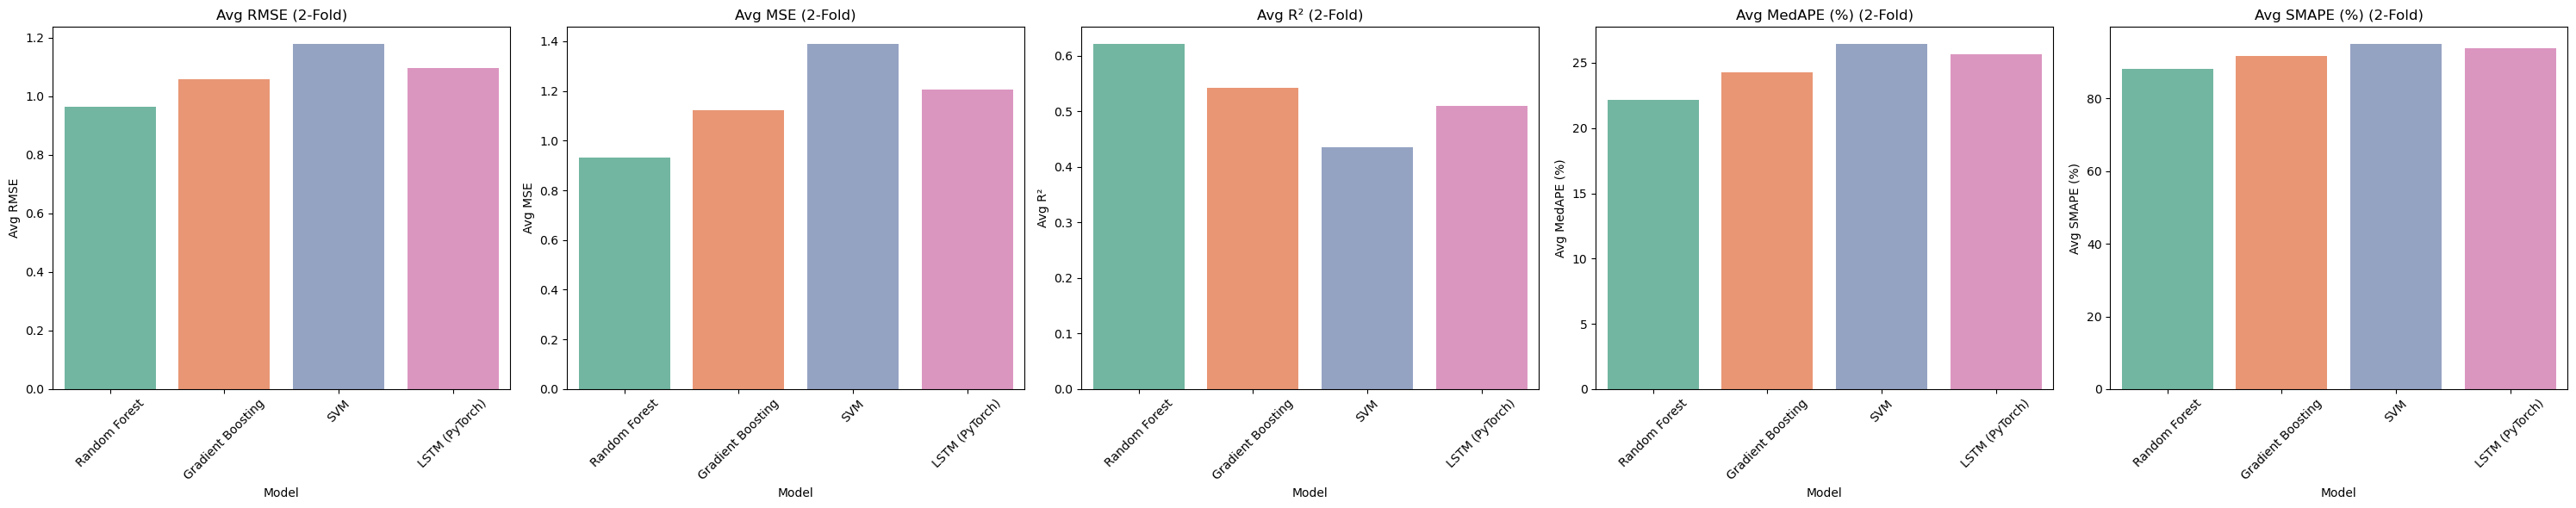


--- Evaluating Blind Set After 2-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.9238 0.8535 0.6310     21.7753    83.1534
Gradient Boosting 1.0137 1.0277 0.5557     23.2788    88.7054
              SVM 1.1483 1.3186 0.4299     25.7887    90.6058
   LSTM (PyTorch) 1.0529 1.1085 0.5207     23.8776    89.1002


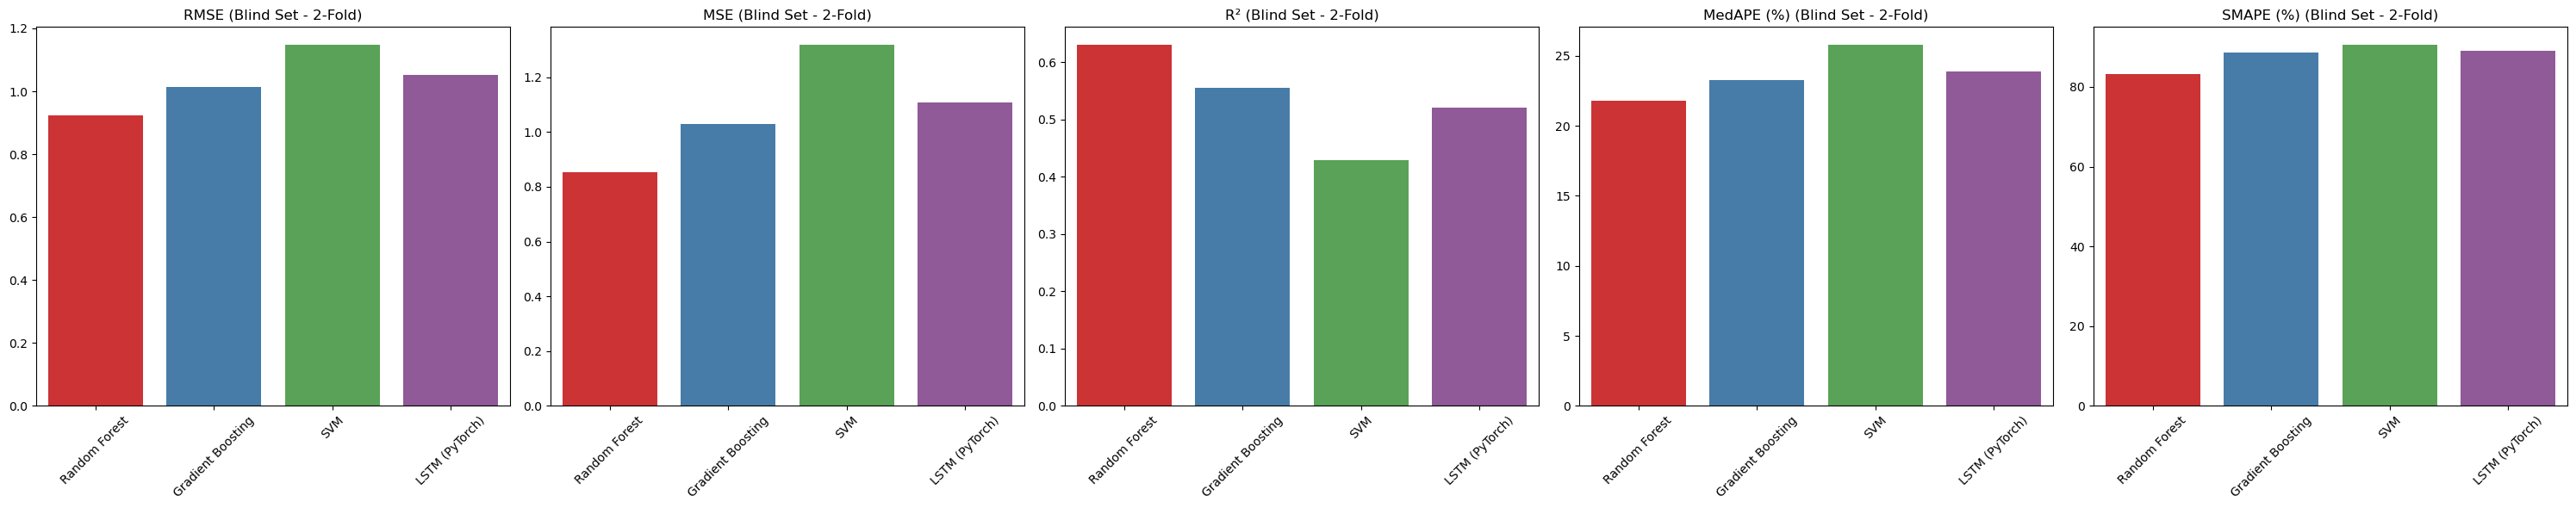


--- 3-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9562   0.9155  0.6272         20.8467        86.6917
Gradient Boosting    1.0519   1.1076  0.5491         23.7445        92.2441
              SVM    1.1552   1.3377  0.4564         26.0198        93.9440
   LSTM (PyTorch)    1.0609   1.1276  0.5415         24.4133        91.9217


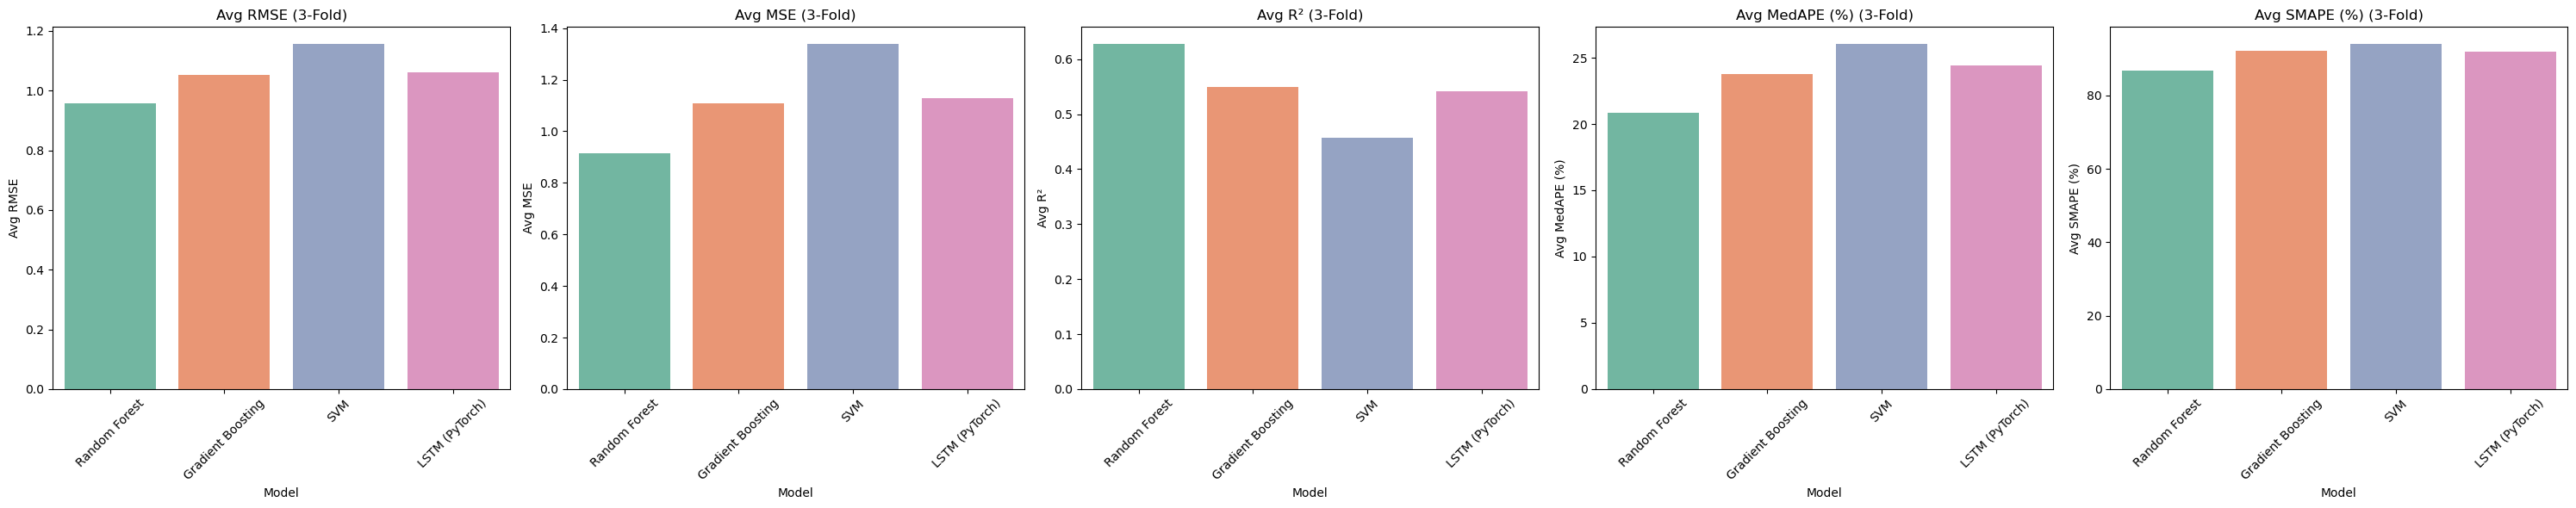


--- Evaluating Blind Set After 3-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.9029 0.8153 0.6475     20.6366    81.7045
Gradient Boosting 0.9741 0.9488 0.5897     21.6789    86.7245
              SVM 1.1325 1.2825 0.4455     24.9998    91.0851
   LSTM (PyTorch) 1.0201 1.0406 0.5501     22.8982    87.2315


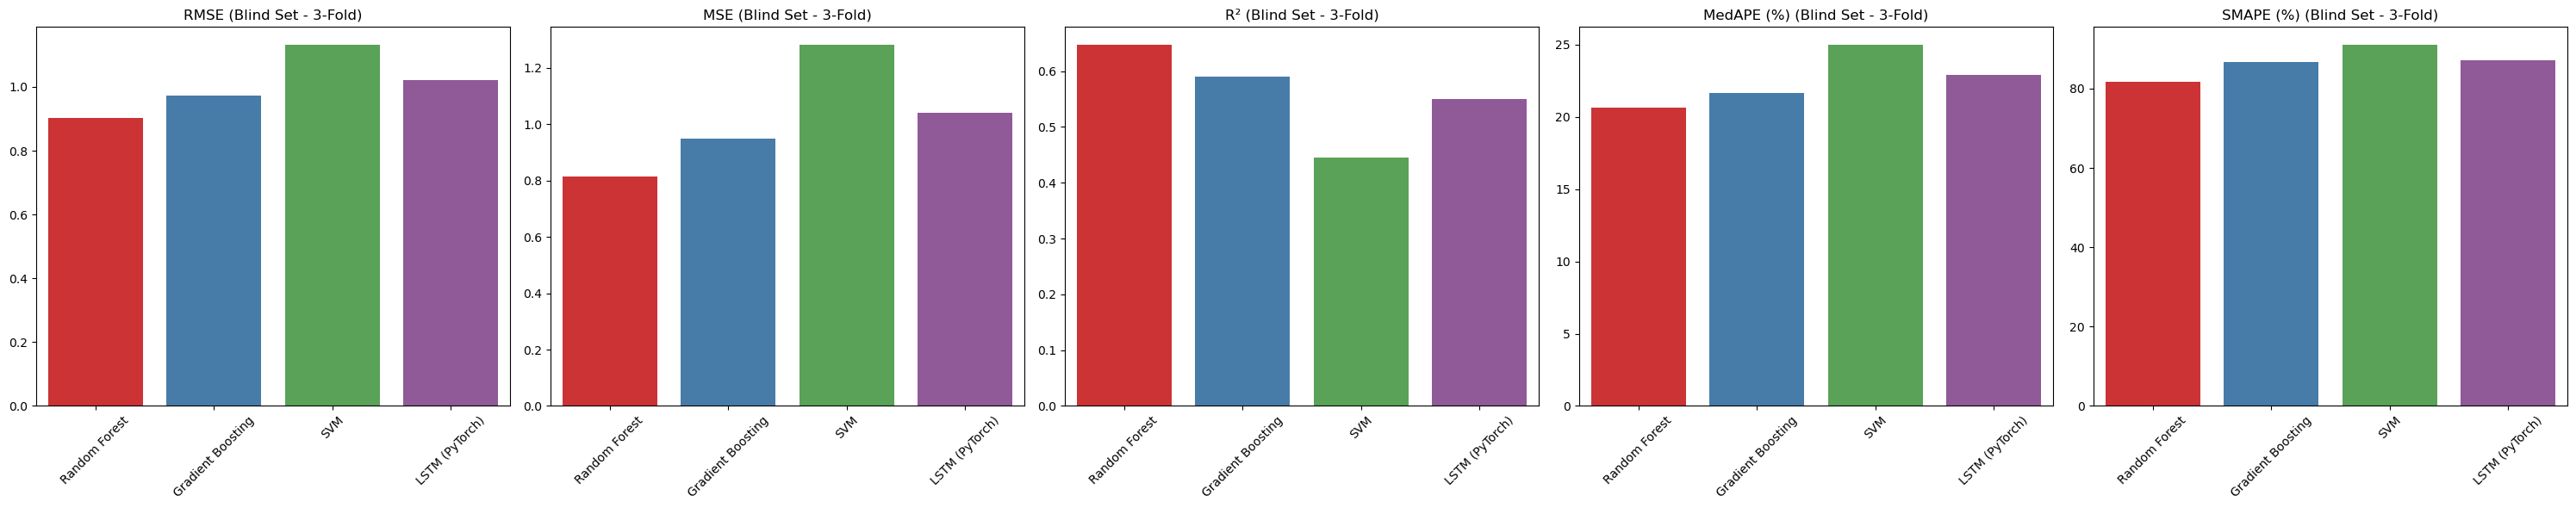


--- 4-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9296   0.8648  0.6472         20.4790        85.3181
Gradient Boosting    1.0468   1.0970  0.5525         24.5865        92.2225
              SVM    1.1515   1.3284  0.4580         25.8194        93.7500
   LSTM (PyTorch)    1.0442   1.0912  0.5551         24.5830        92.0172


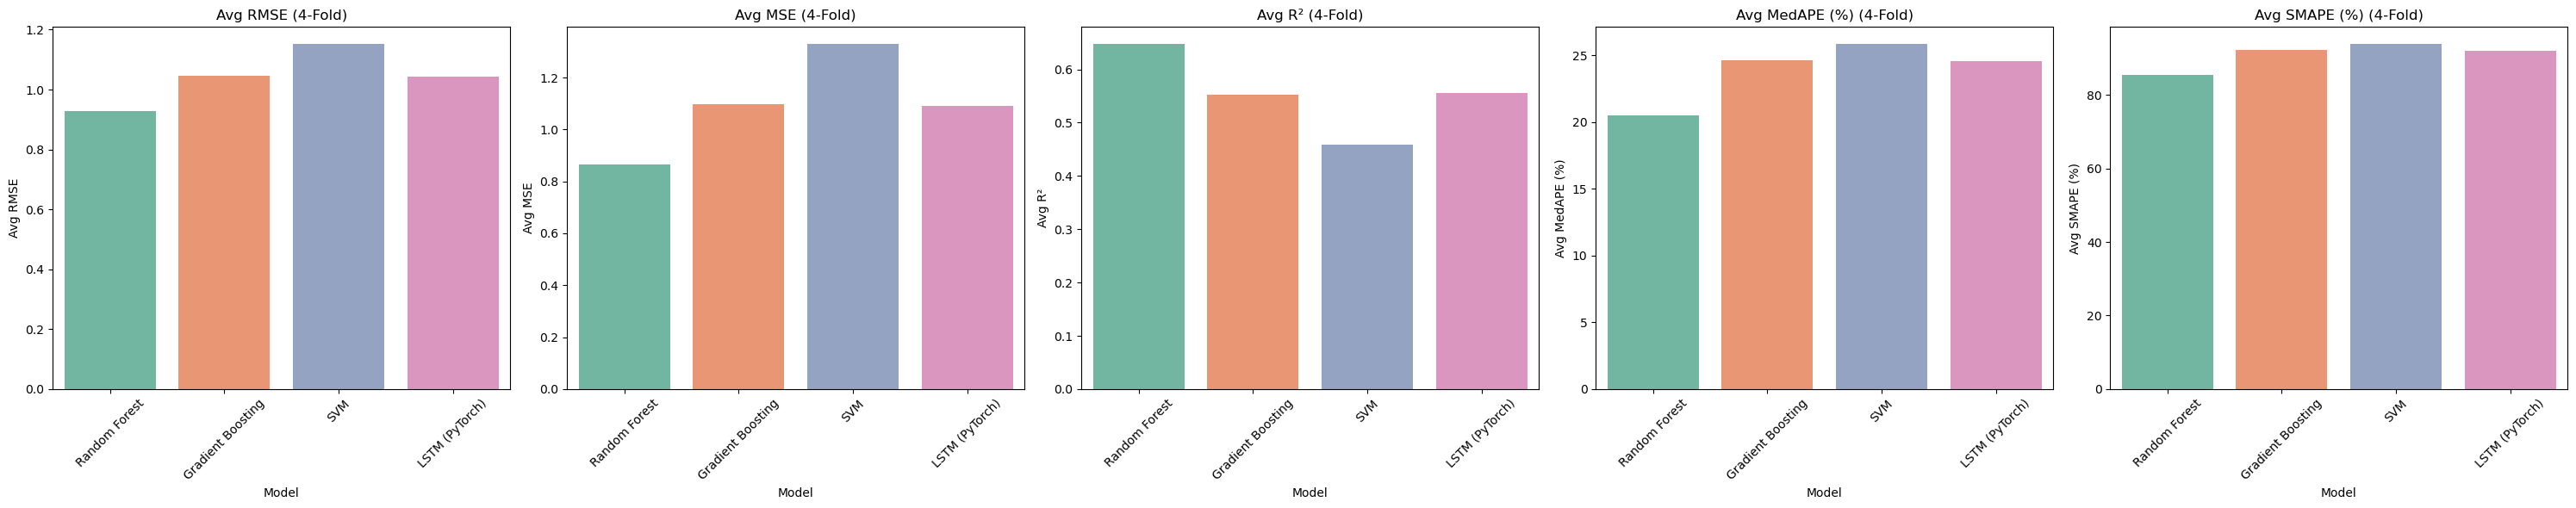


--- Evaluating Blind Set After 4-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8921 0.7958 0.6559     19.4110    80.9251
Gradient Boosting 0.9767 0.9539 0.5876     23.0535    86.3471
              SVM 1.1338 1.2856 0.4441     25.2926    90.8776
   LSTM (PyTorch) 1.0018 1.0036 0.5661     22.4751    87.4091


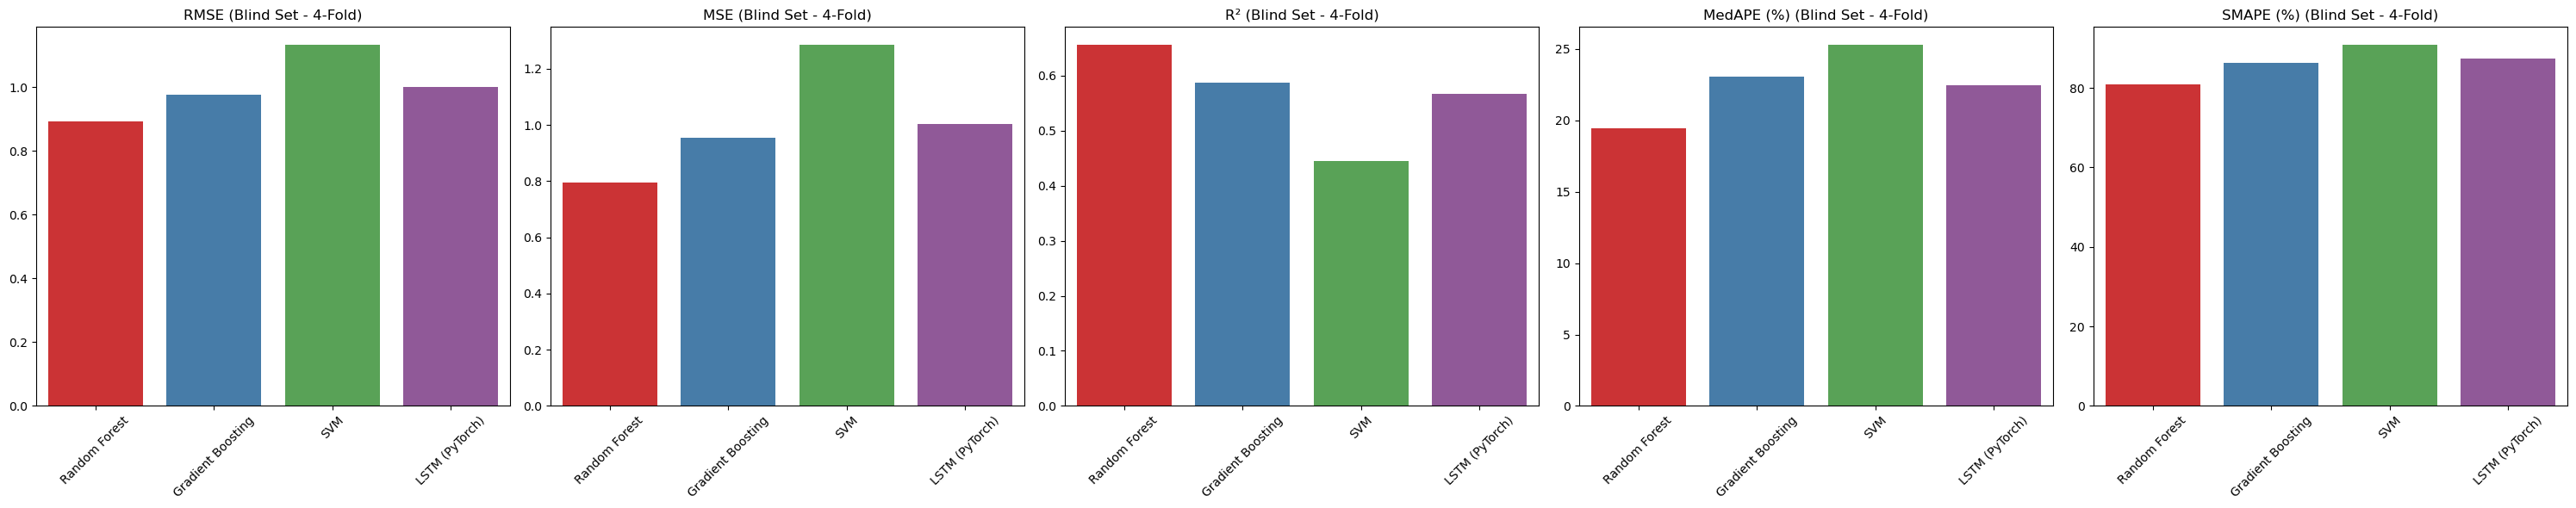


--- 5-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9310   0.8686  0.6461         20.5735        84.8339
Gradient Boosting    1.0452   1.0955  0.5536         24.5220        92.2092
              SVM    1.1493   1.3237  0.4612         25.7936        93.4915
   LSTM (PyTorch)    1.0455   1.0963  0.5538         23.5374        91.0706


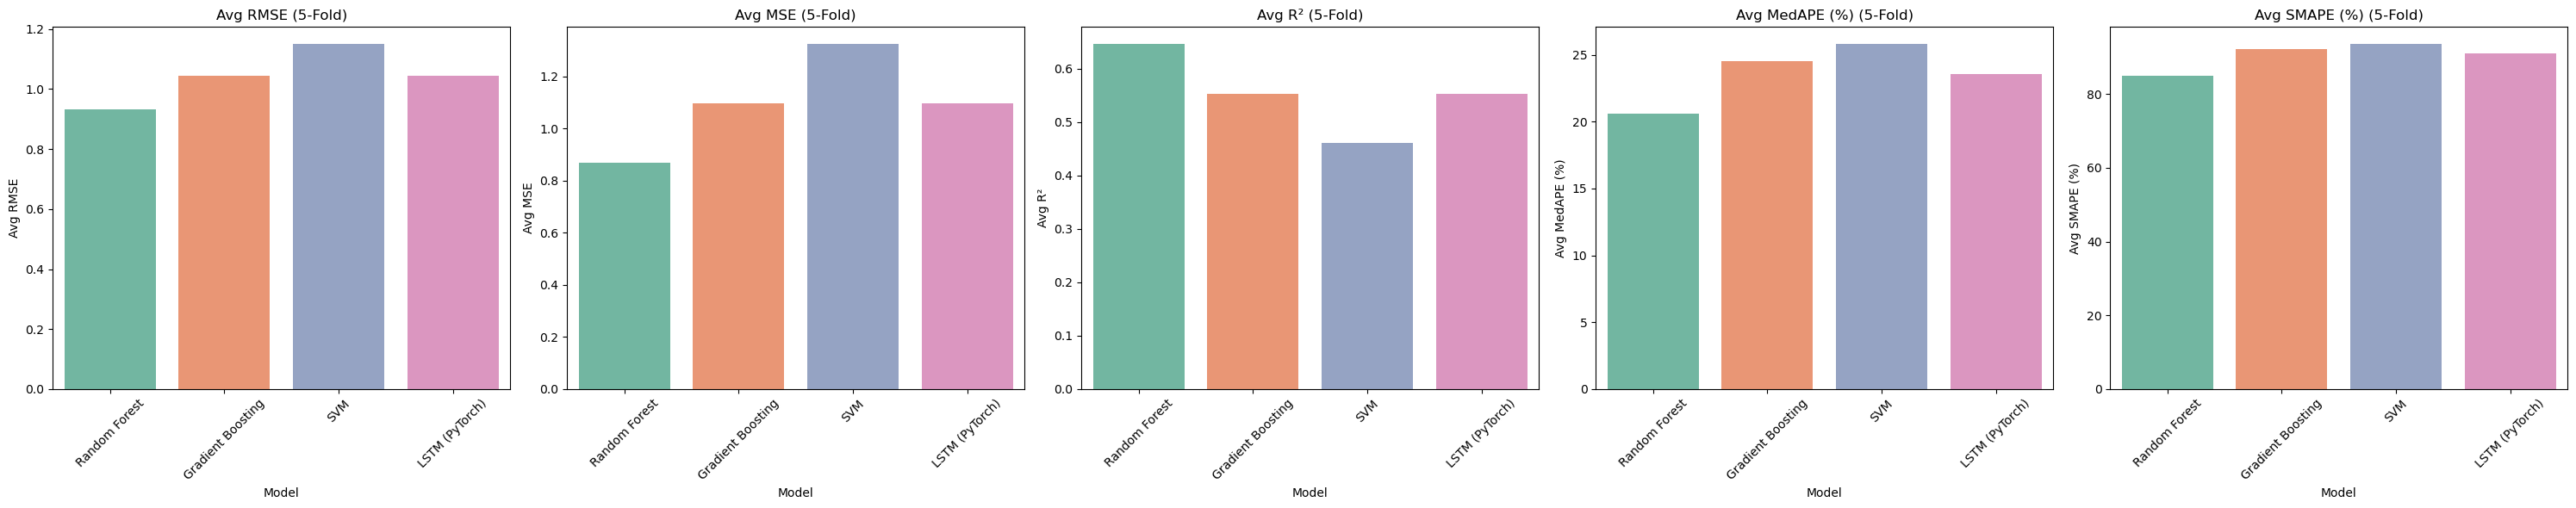


--- Evaluating Blind Set After 5-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8812 0.7766 0.6642     19.1285    80.3259
Gradient Boosting 0.9869 0.9739 0.5789     22.7855    87.0353
              SVM 1.1397 1.2988 0.4384     25.2972    90.6792
   LSTM (PyTorch) 1.0114 1.0230 0.5577     22.6097    87.1144


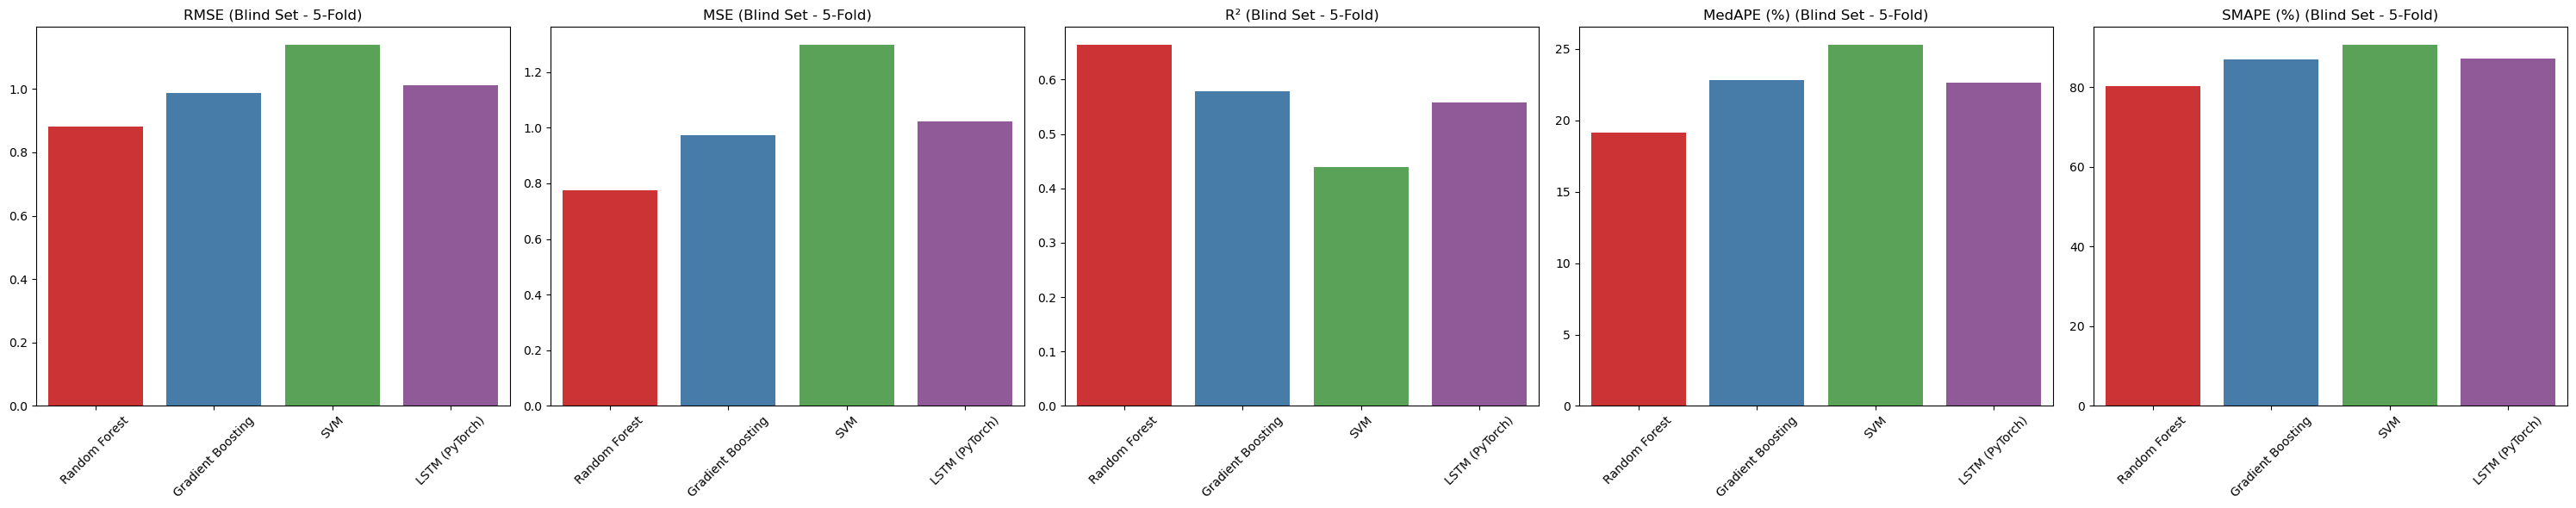


--- 6-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9220   0.8515  0.6520         19.9976        84.7819
Gradient Boosting    1.0515   1.1075  0.5479         24.2694        92.5525
              SVM    1.1456   1.3161  0.4635         26.0027        93.4025
   LSTM (PyTorch)    1.0398   1.0840  0.5583         23.2962        91.1565


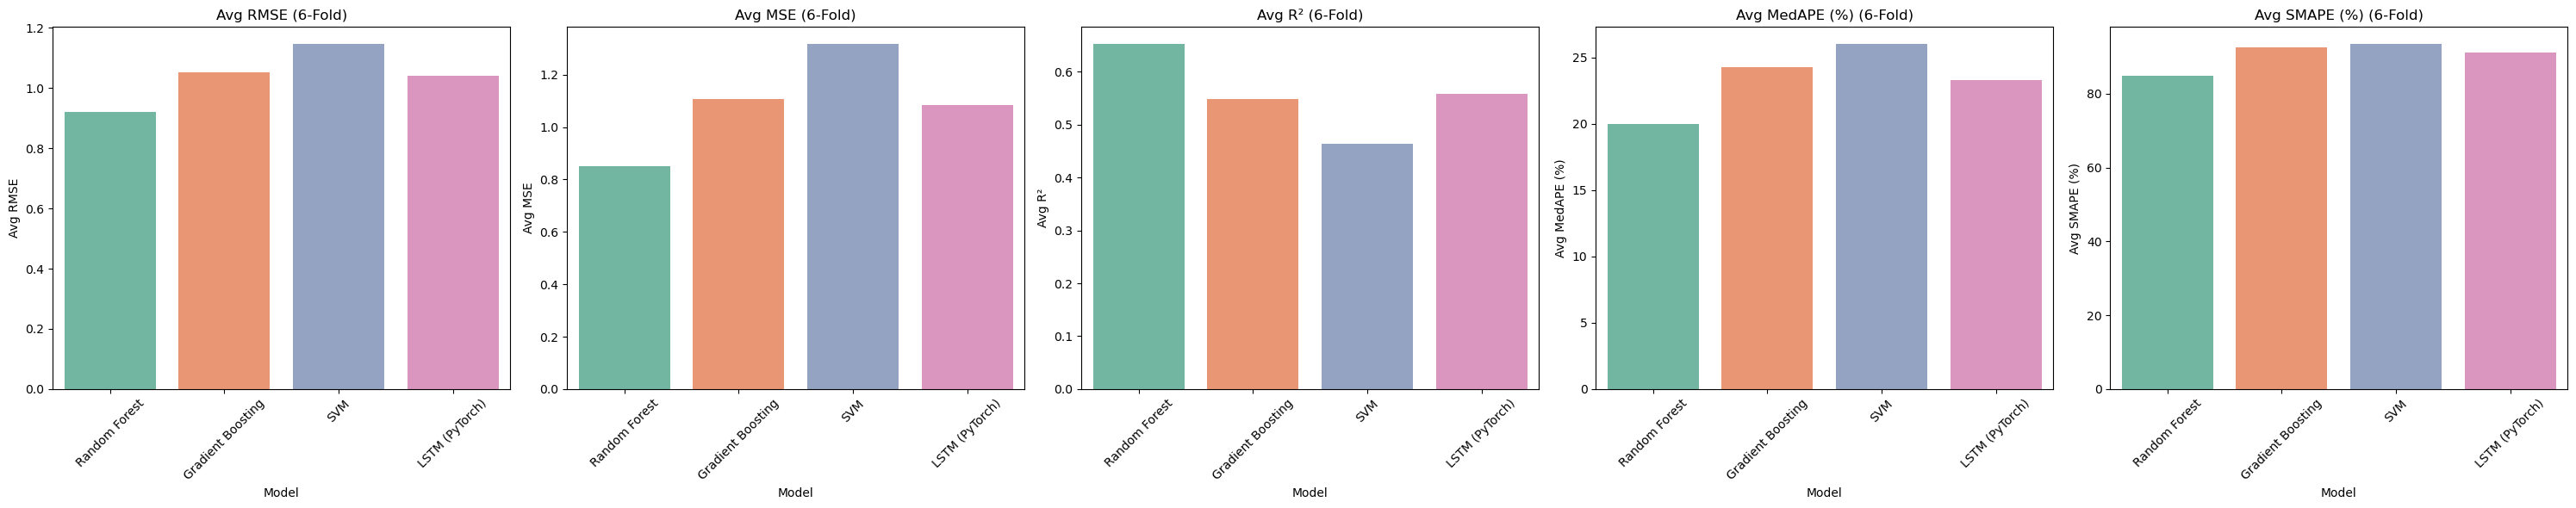


--- Evaluating Blind Set After 6-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8837 0.7809 0.6624     19.4085    80.4159
Gradient Boosting 0.9939 0.9879 0.5728     23.4599    87.9159
              SVM 1.1314 1.2800 0.4465     24.9547    90.2268
   LSTM (PyTorch) 0.9968 0.9935 0.5704     23.2269    87.3949


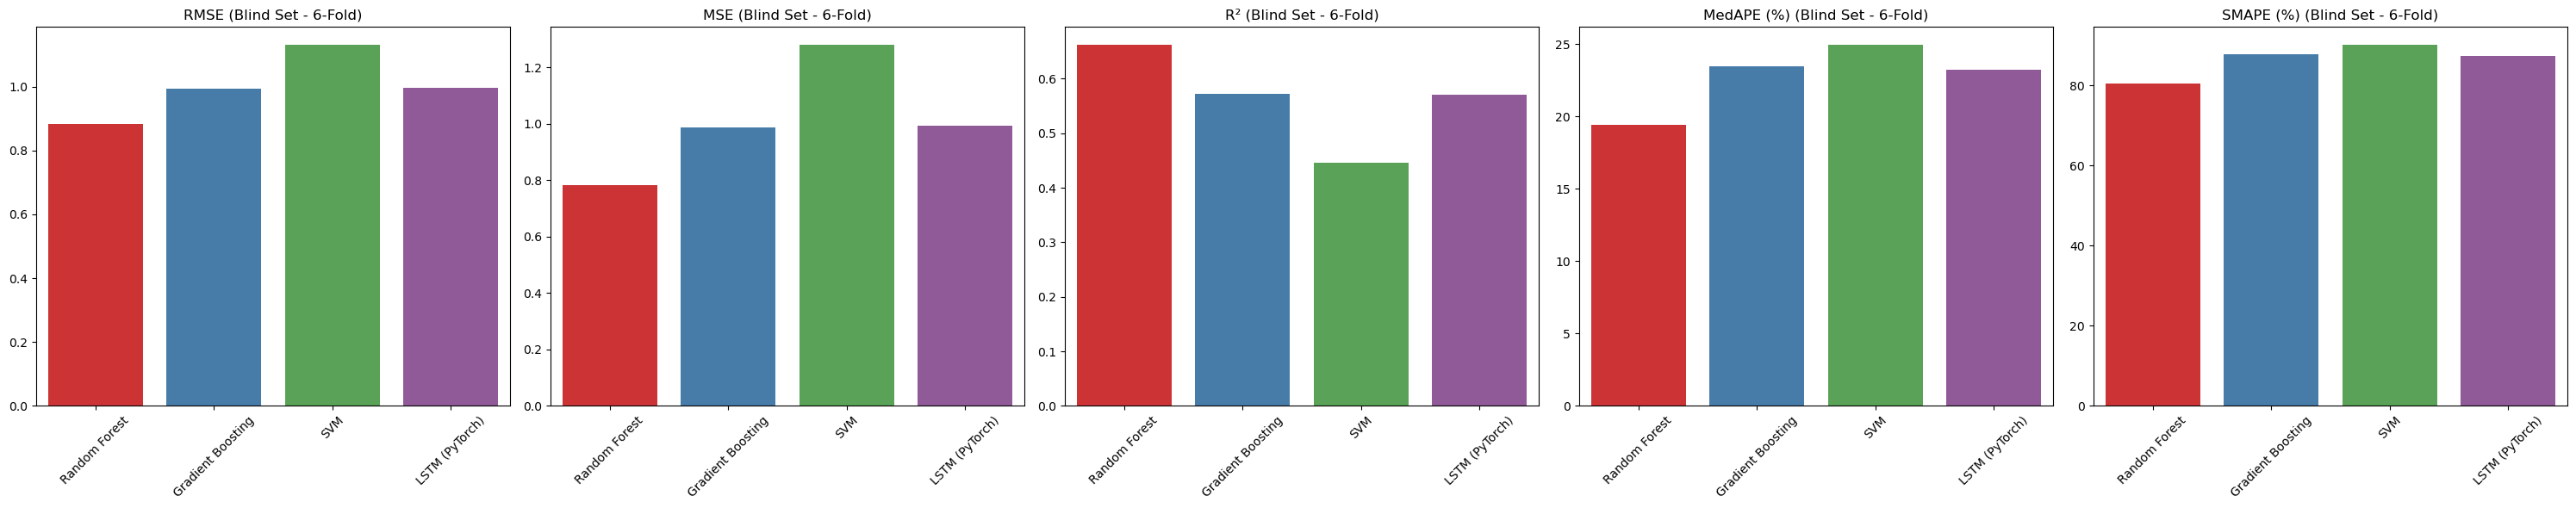


--- 7-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9171   0.8426  0.6565         20.6343        84.3038
Gradient Boosting    1.0408   1.0844  0.5578         23.9926        92.2280
              SVM    1.1393   1.3002  0.4702         25.2941        93.0221
   LSTM (PyTorch)    1.0361   1.0741  0.5621         23.6958        91.3822


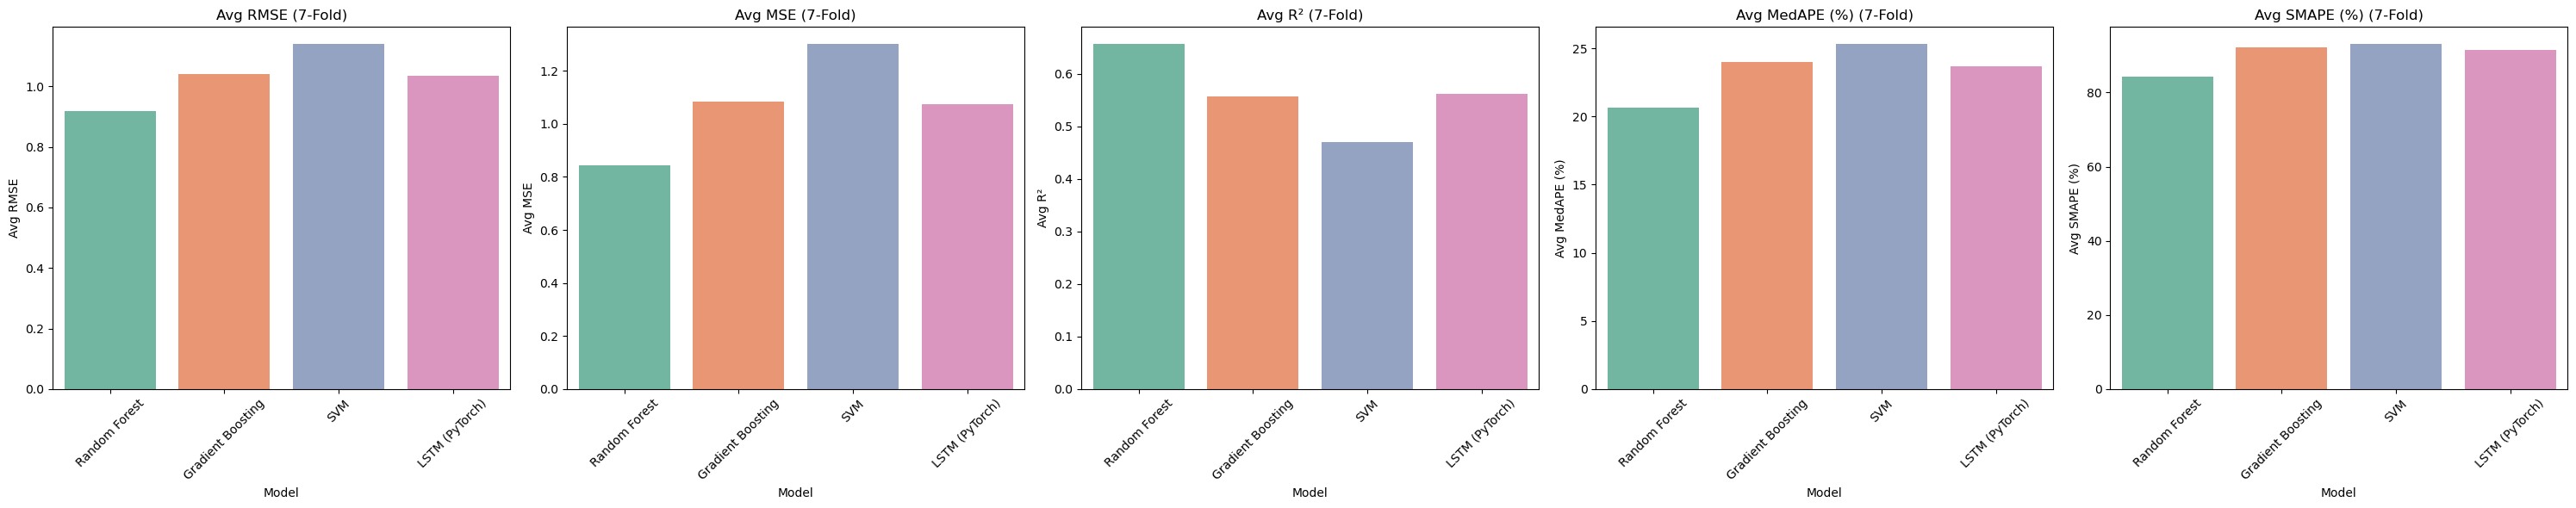


--- Evaluating Blind Set After 7-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8793 0.7731 0.6657     19.3000    79.4940
Gradient Boosting 0.9874 0.9749 0.5785     22.7668    86.8556
              SVM 1.1320 1.2813 0.4460     24.7950    90.2792
   LSTM (PyTorch) 1.0080 1.0161 0.5606     23.0166    88.0377


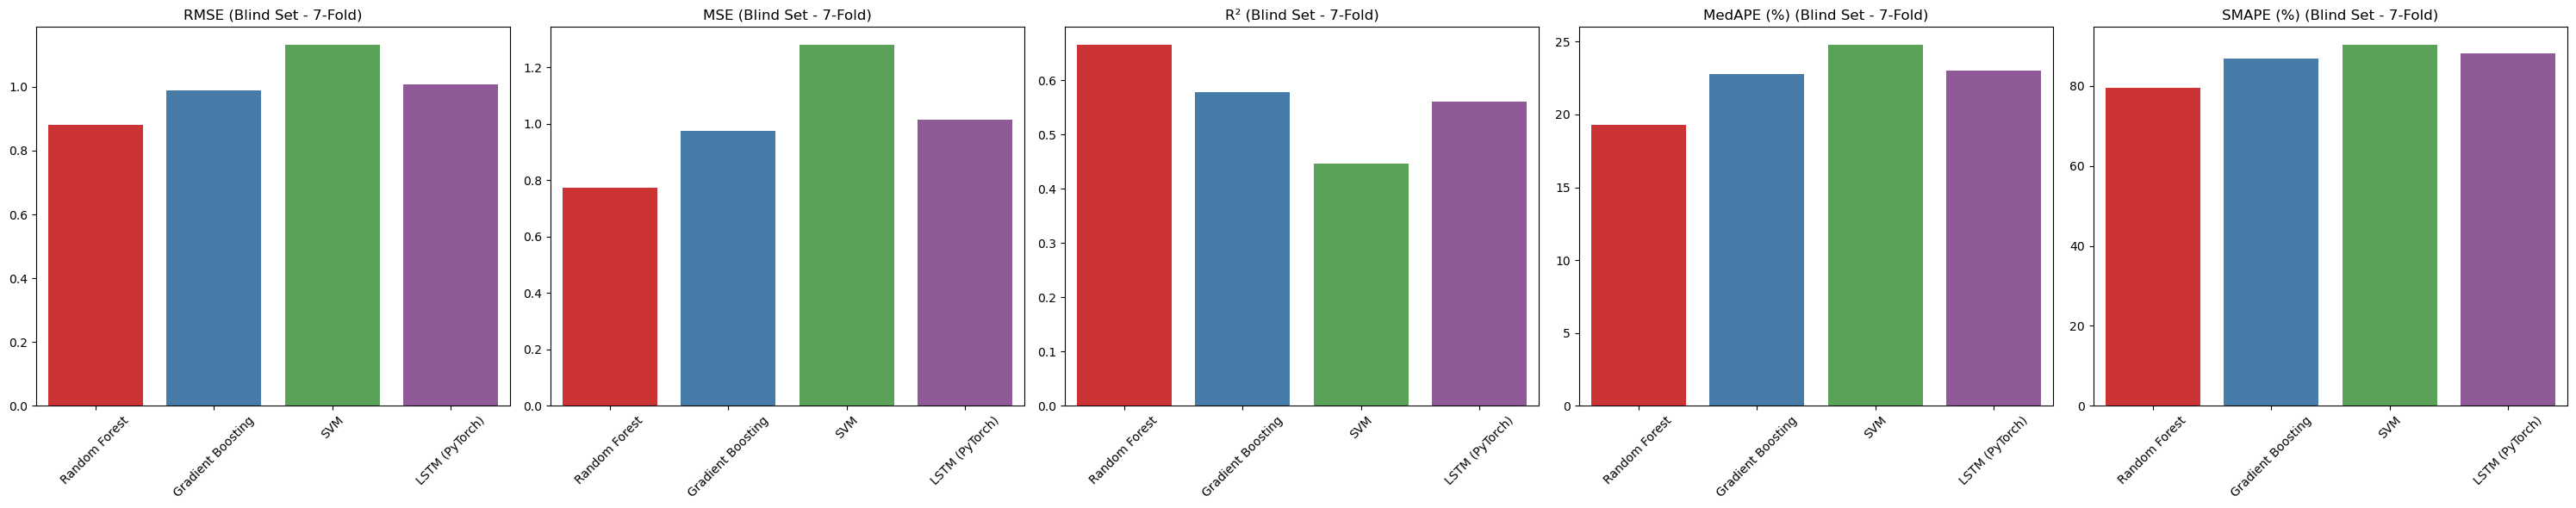


--- 8-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9207   0.8495  0.6510         20.0383        84.5432
Gradient Boosting    1.0436   1.0909  0.5518         24.4609        92.3968
              SVM    1.1430   1.3090  0.4634         25.4500        93.2093
   LSTM (PyTorch)    1.0418   1.0879  0.5538         23.9747        91.2961


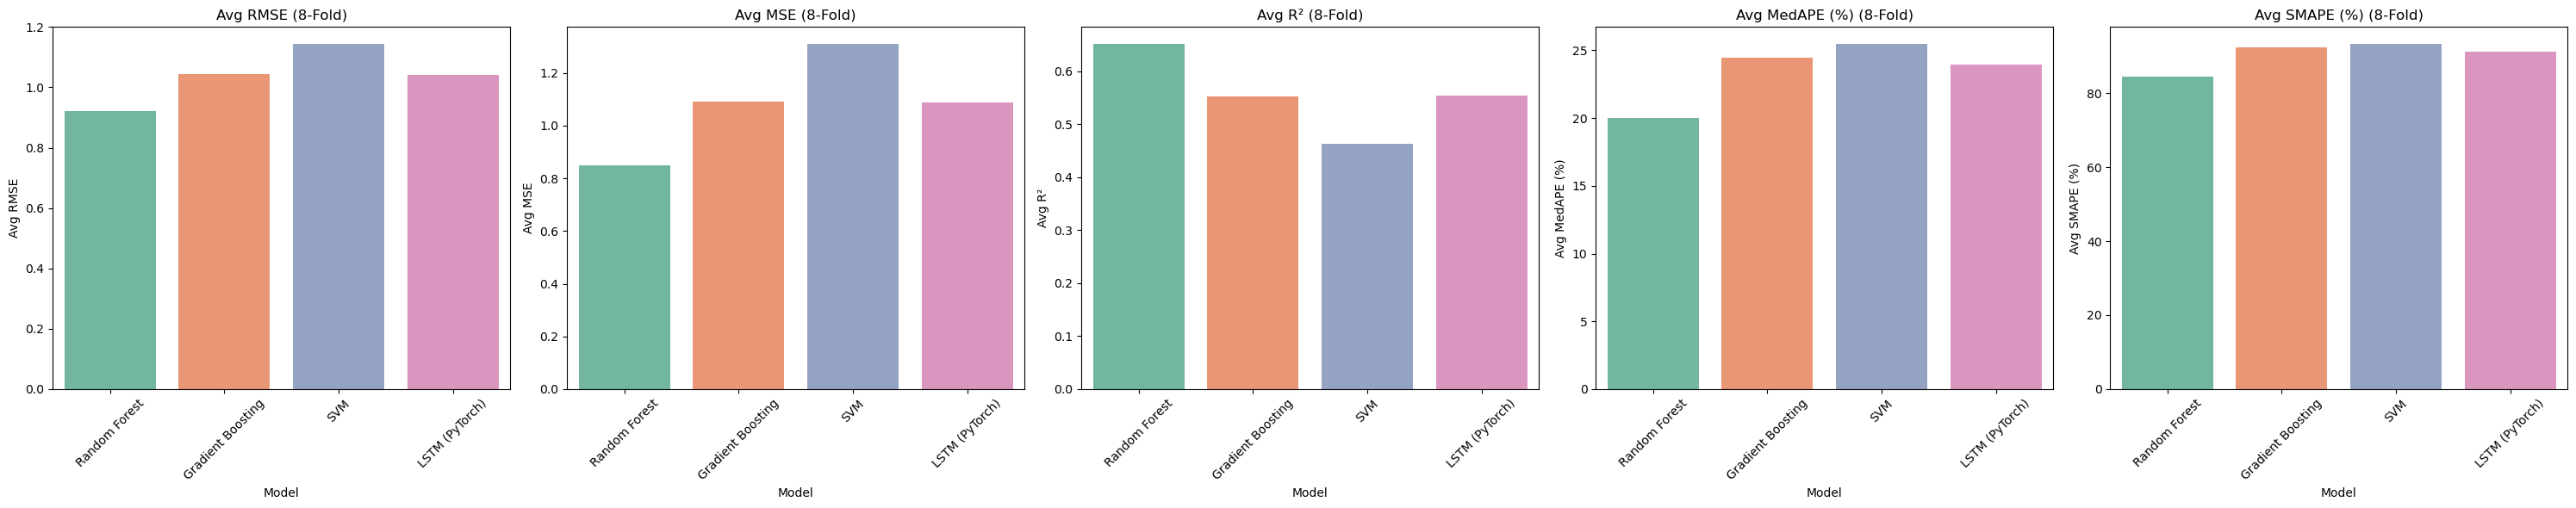


--- Evaluating Blind Set After 8-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8884 0.7893 0.6587     18.9798    80.4385
Gradient Boosting 1.0014 1.0029 0.5664     22.4221    87.5089
              SVM 1.1303 1.2776 0.4476     24.6660    90.1613
   LSTM (PyTorch) 0.9986 0.9972 0.5688     21.6298    85.7673


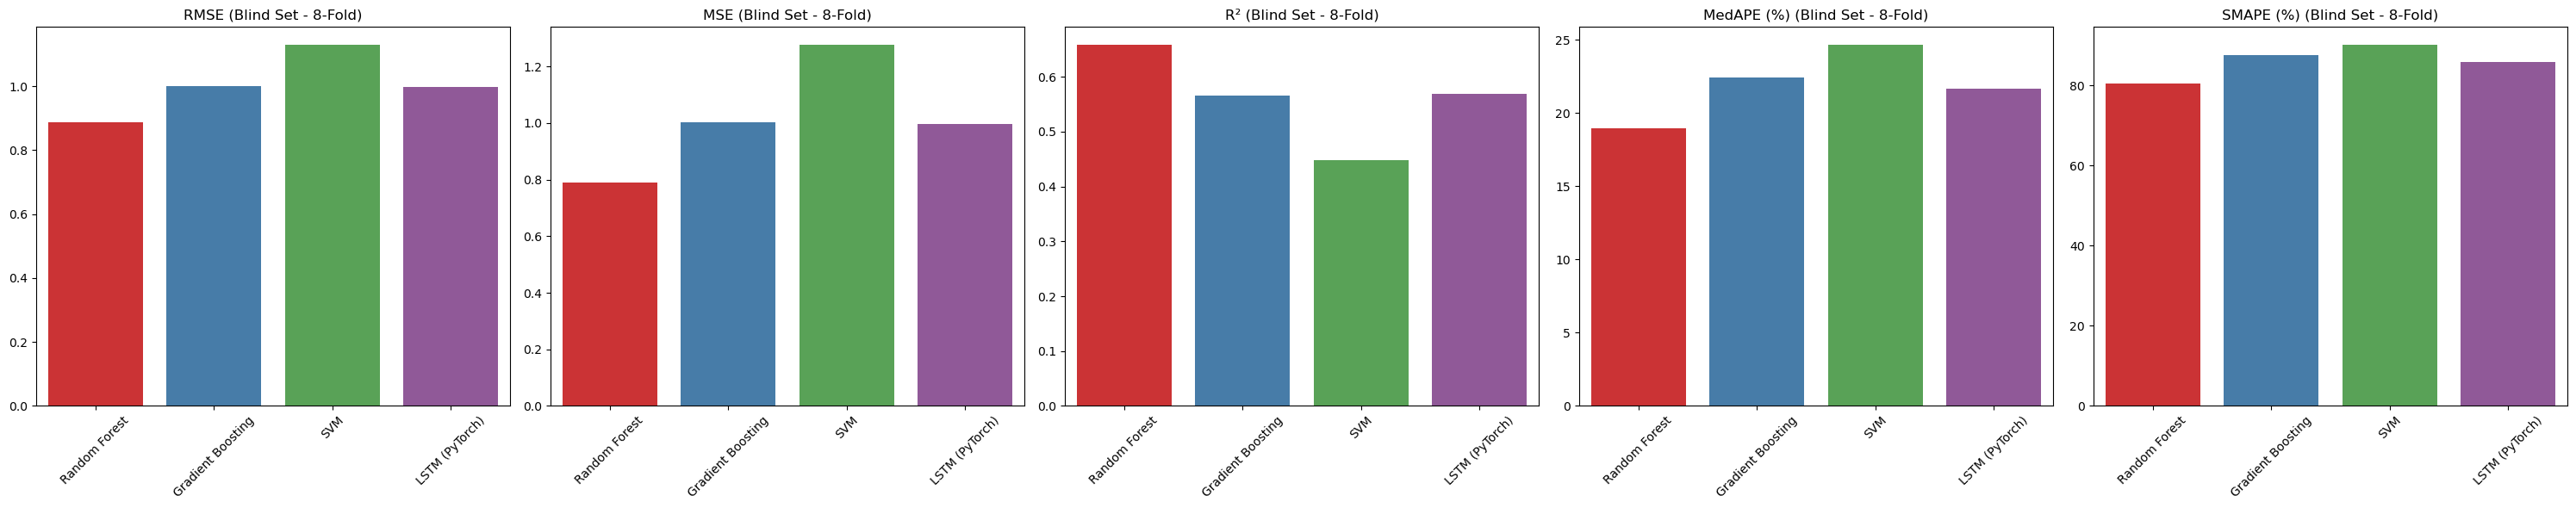


--- 9-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9141   0.8387  0.6582         20.3681        84.1366
Gradient Boosting    1.0378   1.0811  0.5595         24.3002        91.9980
              SVM    1.1395   1.3035  0.4700         25.7233        93.1983
   LSTM (PyTorch)    1.0321   1.0707  0.5645         23.4127        90.6850


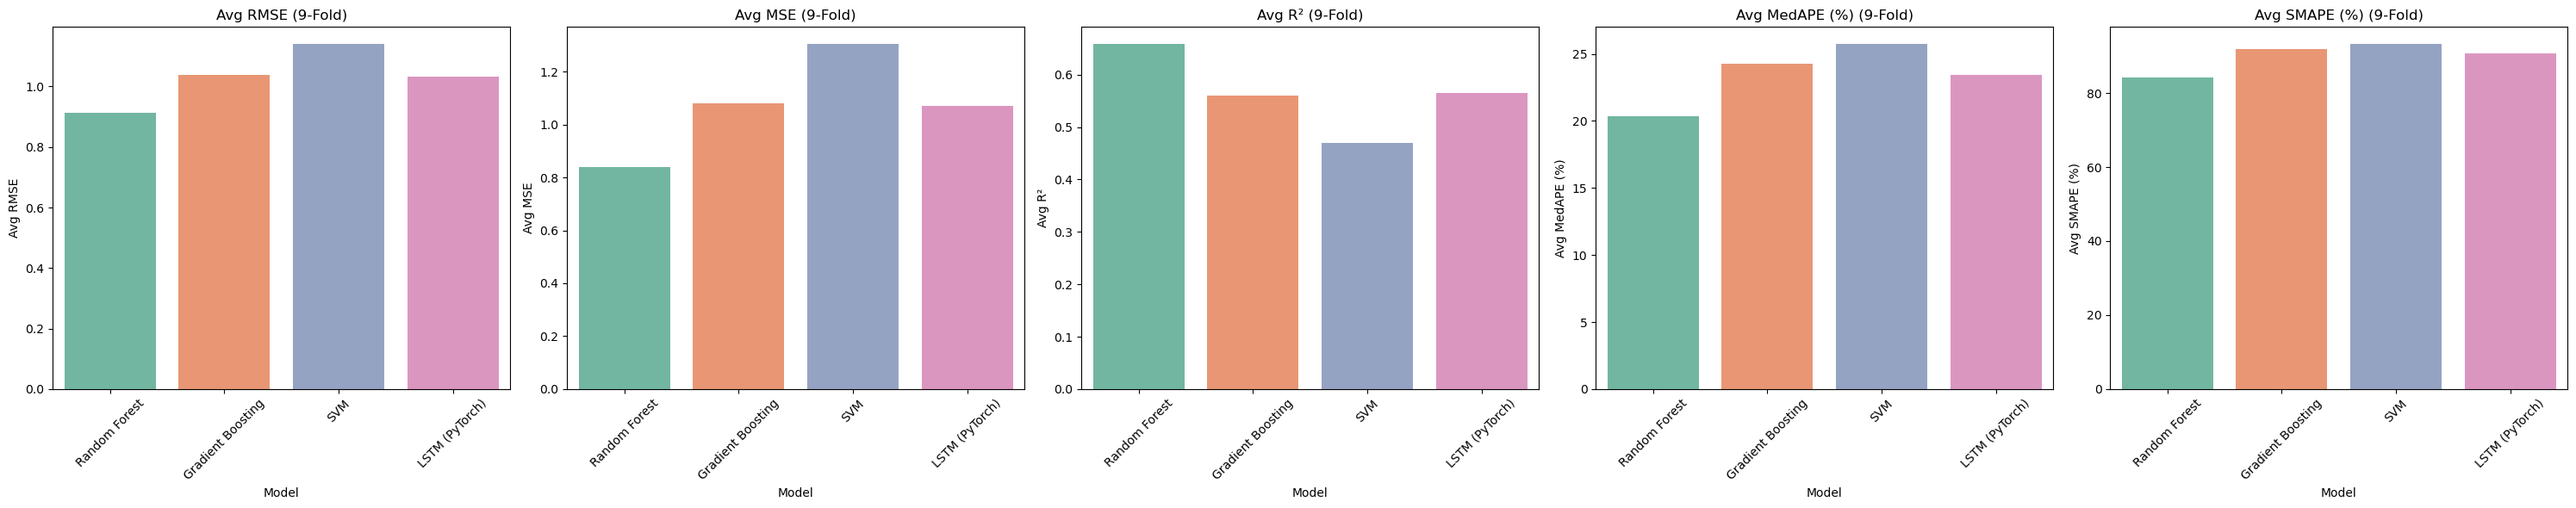


--- Evaluating Blind Set After 9-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8823 0.7785 0.6634     19.6452    80.5561
Gradient Boosting 0.9898 0.9797 0.5764     21.9740    86.8337
              SVM 1.1311 1.2794 0.4468     24.0113    90.0334
   LSTM (PyTorch) 1.0074 1.0149 0.5612     23.6077    88.2959


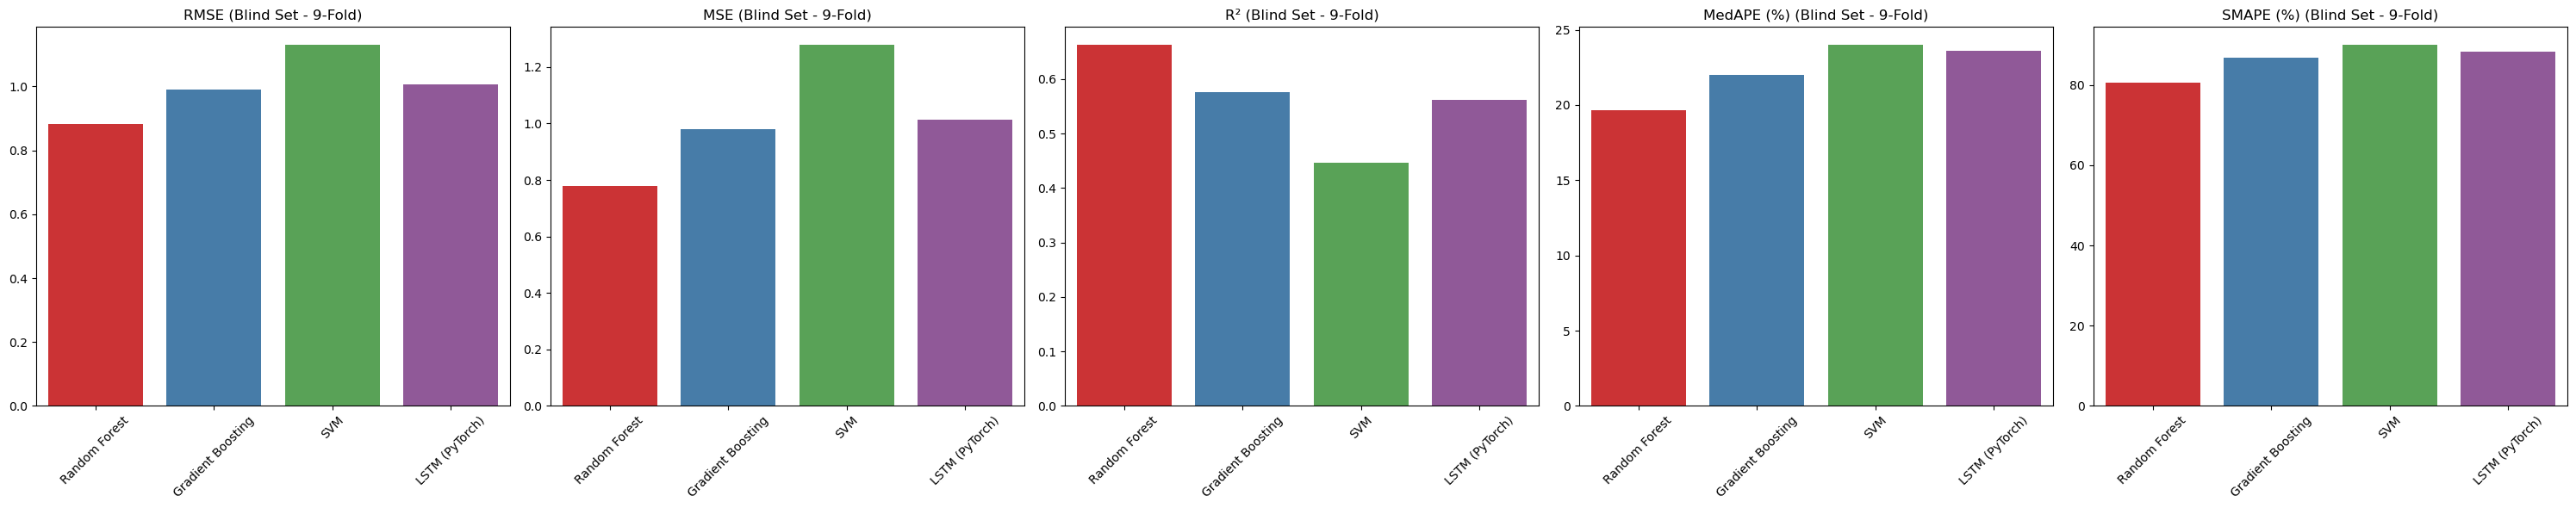


--- 10-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.9133   0.8383  0.6567         20.2510        84.1582
Gradient Boosting    1.0358   1.0783  0.5587         24.3003        92.2076
              SVM    1.1393   1.3037  0.4668         25.4167        93.0835
   LSTM (PyTorch)    1.0370   1.0822  0.5576         23.7977        91.1289


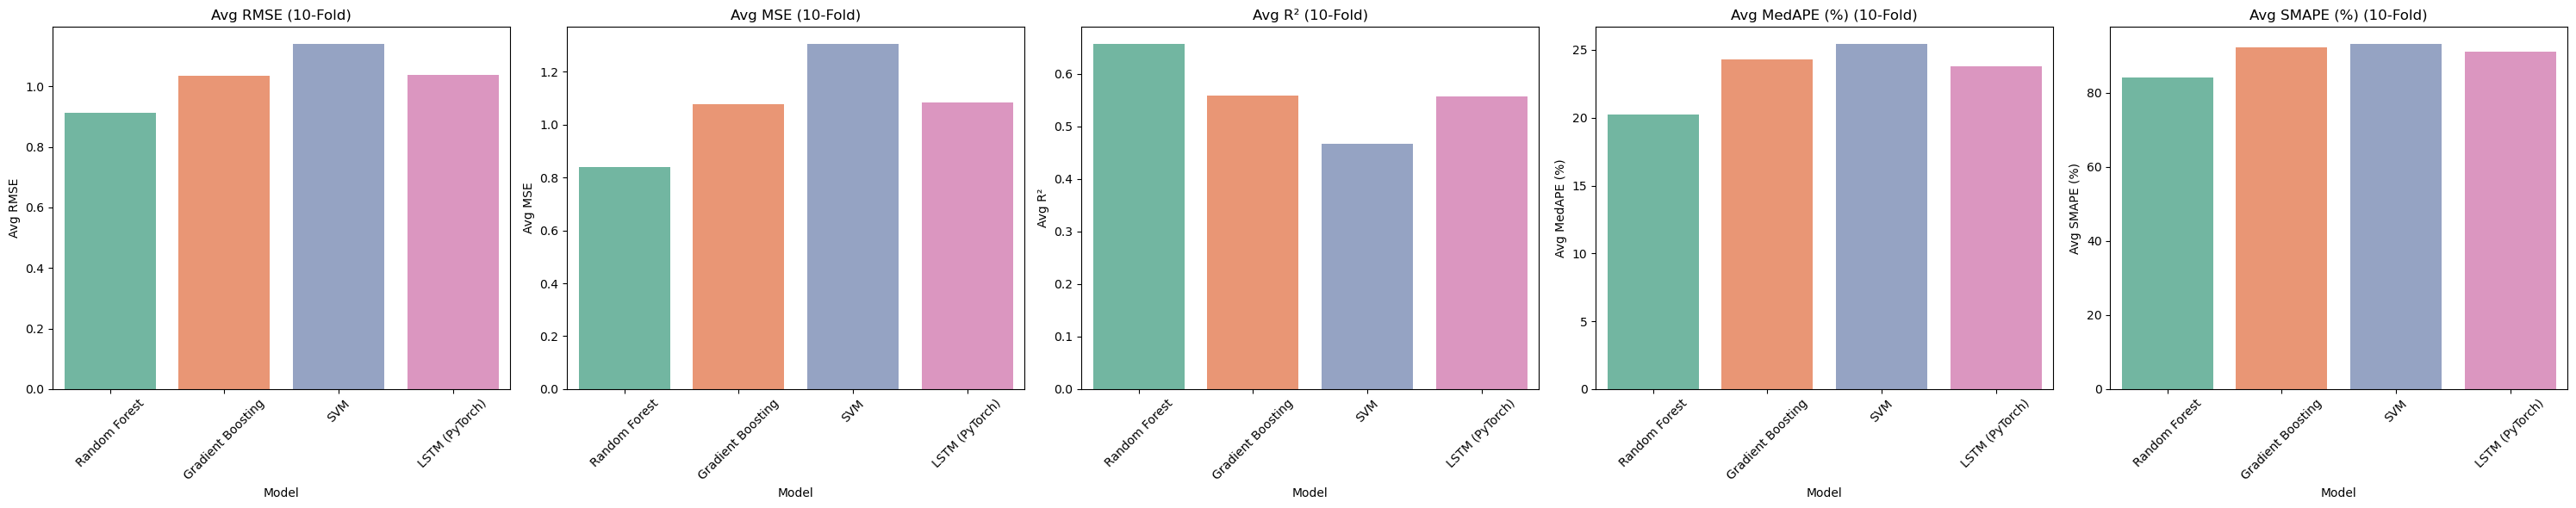


--- Evaluating Blind Set After 10-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8833 0.7803 0.6626     18.4689    80.4102
Gradient Boosting 0.9923 0.9846 0.5743     23.1634    87.3988
              SVM 1.1289 1.2744 0.4490     24.5147    90.0608
   LSTM (PyTorch) 1.0125 1.0251 0.5568     23.2636    88.1259


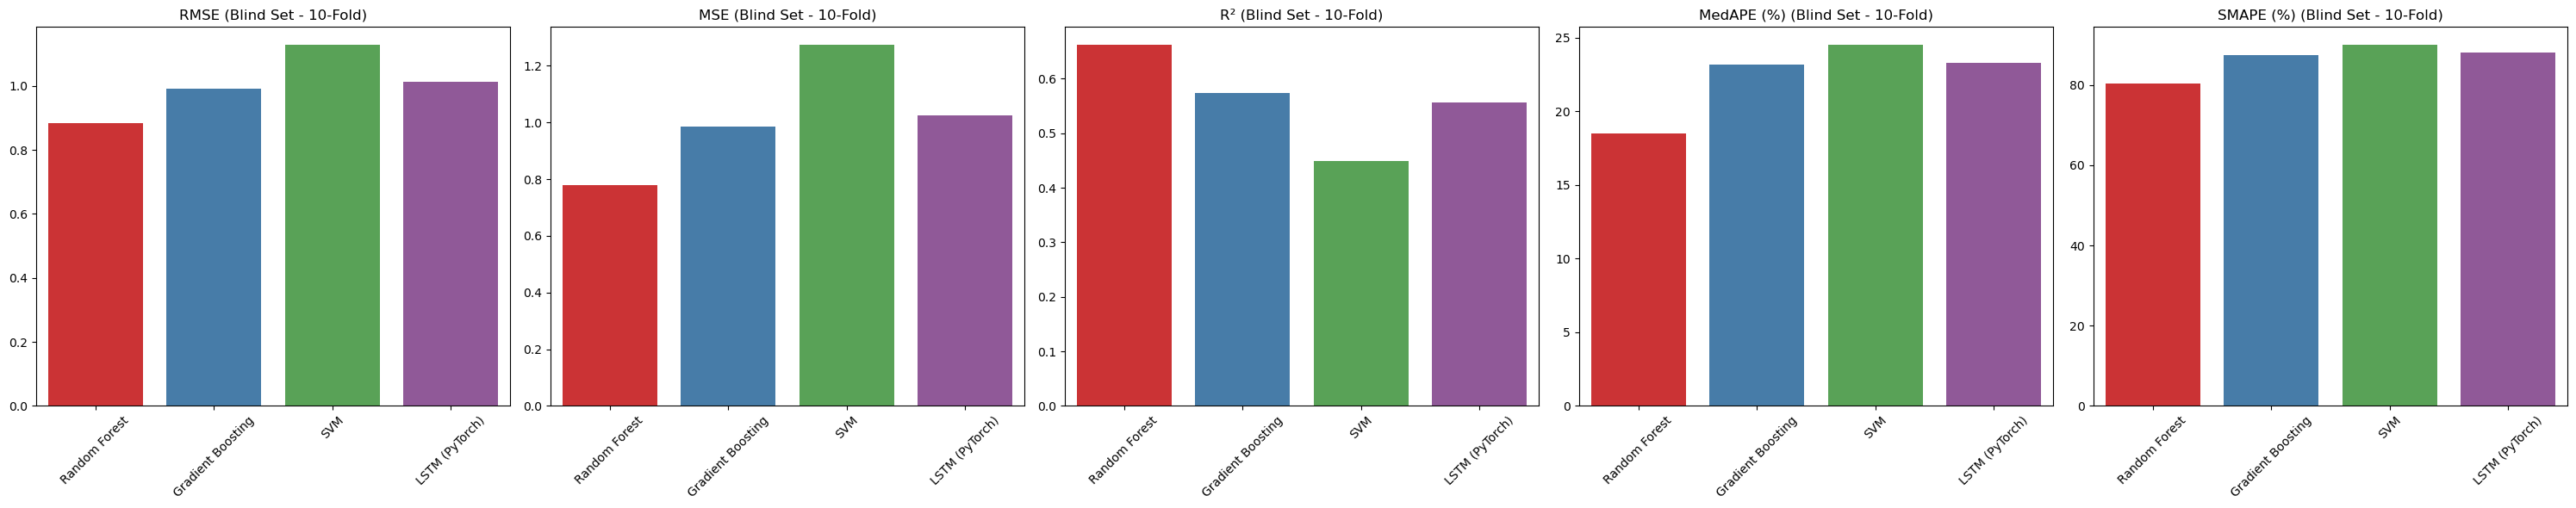

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# === Metrics ===
def medape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > epsilon
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.sum(mask) else np.nan

def smape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator < epsilon, epsilon, denominator)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# === LSTM ===
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, activation='relu'):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.activation = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid(), 'leaky_relu': nn.LeakyReLU()}.get(activation)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(self.activation(out)) if self.activation else self.fc(out)

def train_model(model, train_loader, val_loader, epochs=200, patience=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss, best_state, patience_counter = float('inf'), None, 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = np.mean([criterion(model(xb), yb).item() for xb, yb in val_loader])
        if val_loss < best_loss:
            best_loss, best_state = val_loss, model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return model



# === Prepare Training Set ===
y = pubchem_train['log_ic50']
drop_cols = ['target_chembl_id', 'target_name', 'ic50_value', 'chembl_id', 'log_ic50', 'CID']
X = pubchem_train.drop(columns=[col for col in drop_cols if col in pubchem_train.columns])

y = pubchem_train['log_ic50']
X = pubchem_train.drop(columns=[col for col in drop_cols if col in pubchem_train.columns])
X = X.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X.mean())

selector = VarianceThreshold(0.01)
X_selected = selector.fit_transform(X)

# === Prepare Blind Set ===
X_blind = pubchem_blind.drop(columns=[col for col in drop_cols if col in pubchem_blind.columns])
X_blind = X_blind.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce').fillna(X_blind.mean())
X_blind_selected = selector.transform(X_blind)

# === Models ===
models = {
    'Random Forest': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'SVM': SVR(),
    'LSTM (PyTorch)': None  # will instantiate per fold
}

# === Cross-validation and Blind Evaluation ===
for k in range(2, 11):
    print(f"\n--- {k}-Fold Cross Validation ---")
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = {metric: {m: [] for m in models} for metric in metrics}

    for train_idx, test_idx in kf.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Classic models
        for name, model in models.items():
            if name == 'LSTM (PyTorch)':
                continue
            model.fit(X_train_scaled, y_train)
            y_pred = np.maximum(model.predict(X_test_scaled), 0)
            scores['RMSE'][name].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            scores['MSE'][name].append(mean_squared_error(y_test, y_pred))
            scores['R²'][name].append(r2_score(y_test, y_pred))
            scores['MedAPE'][name].append(medape(y_test, y_pred))
            scores['SMAPE'][name].append(smape(np.expm1(y_test), np.expm1(y_pred)))

        # LSTM
        X_train_seq = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
        X_test_seq = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

        train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
        test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

        train_ds, val_ds = random_split(TensorDataset(train_tensor, y_train_tensor), [int(0.8*len(train_tensor)), len(train_tensor) - int(0.8*len(train_tensor))])
        train_loader = DataLoader(train_ds, batch_size=lstm_best_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=lstm_best_params['batch_size'])

        lstm = LSTMRegressor(
            input_size=train_tensor.shape[2],
            hidden_size=lstm_best_params['hidden_size'],
            num_layers=lstm_best_params['num_layers'],
            activation=lstm_best_params['activation']
        )
        lstm = train_model(lstm, train_loader, val_loader, lr=lstm_best_params['learning_rate'])
        lstm.eval()
        with torch.no_grad():
            y_pred_lstm = torch.clamp(lstm(test_tensor), min=0).squeeze().numpy()

        scores['RMSE']['LSTM (PyTorch)'].append(np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
        scores['MSE']['LSTM (PyTorch)'].append(mean_squared_error(y_test, y_pred_lstm))
        scores['R²']['LSTM (PyTorch)'].append(r2_score(y_test, y_pred_lstm))
        scores['MedAPE']['LSTM (PyTorch)'].append(medape(y_test, y_pred_lstm))
        scores['SMAPE']['LSTM (PyTorch)'].append(smape(np.expm1(y_test), np.expm1(y_pred_lstm)))

    # === Fold-wise Average Report ===
    print("\nAverage Cross-Validation Performance:")
    perf_df = pd.DataFrame({
        'Model': list(models.keys()),
        'Avg RMSE': [np.mean(scores['RMSE'][m]) for m in models],
        'Avg MSE': [np.mean(scores['MSE'][m]) for m in models],
        'Avg R²': [np.mean(scores['R²'][m]) for m in models],
        'Avg MedAPE (%)': [np.mean(scores['MedAPE'][m]) for m in models],
        'Avg SMAPE (%)': [np.mean(scores['SMAPE'][m]) for m in models]
    })
    print(perf_df.to_string(index=False, float_format="%.4f"))

    # === Plot ===
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(perf_df.columns[1:]):
        sns.barplot(data=perf_df, x='Model', y=metric, ax=axes[i], palette='Set2')
        axes[i].set_title(f"{metric} ({k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # === Blind Set Evaluation ===
    print(f"\n--- Evaluating Blind Set After {k}-Fold ---")
    X_blind_scaled = scaler.transform(X_blind_selected)
    blind_metrics = {metric: {} for metric in metrics}

    for name, model in models.items():
        if name == 'LSTM (PyTorch)':
            X_blind_seq = X_blind_scaled.reshape(-1, 1, X_blind_scaled.shape[1])
            X_blind_tensor = torch.tensor(X_blind_seq, dtype=torch.float32)
            lstm.eval()
            with torch.no_grad():
                y_blind_pred = torch.clamp(lstm(X_blind_tensor), min=0).squeeze().numpy()
        else:
            y_blind_pred = np.maximum(model.predict(X_blind_scaled), 0)

        blind_metrics['RMSE'][name] = np.sqrt(mean_squared_error(pubchem_blind['log_ic50'], y_blind_pred))
        blind_metrics['MSE'][name] = mean_squared_error(pubchem_blind['log_ic50'], y_blind_pred)
        blind_metrics['R²'][name] = r2_score(pubchem_blind['log_ic50'], y_blind_pred)
        blind_metrics['MedAPE'][name] = medape(pubchem_blind['log_ic50'], y_blind_pred)
        blind_metrics['SMAPE'][name] = smape(np.expm1(pubchem_blind['log_ic50']), np.expm1(y_blind_pred))

    blind_df = pd.DataFrame({
        'Model': list(models.keys()),
        'RMSE': [blind_metrics['RMSE'][m] for m in models],
        'MSE': [blind_metrics['MSE'][m] for m in models],
        'R²': [blind_metrics['R²'][m] for m in models],
        'MedAPE (%)': [blind_metrics['MedAPE'][m] for m in models],
        'SMAPE (%)': [blind_metrics['SMAPE'][m] for m in models],
    })
    print(blind_df.to_string(index=False, float_format="%.4f"))
    # === Blind Set Performance Plot ===
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(blind_df.columns[1:]):  # Skip 'Model'
        sns.barplot(data=blind_df, x='Model', y=metric, ax=axes[i], palette='Set1')
        axes[i].set_title(f"{metric} (Blind Set - {k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()


## PaDEL

In [68]:
#padel_train, padel_blind = split_full_dataset(merged_df_padel, descriptor_name="PaDEL")

In [69]:


print("🧾 RDKIT Training Columns:")
print(padel_train.columns.tolist())

# Count total columns
total_columns_padel = len(padel_train.columns)
print(f"\n🔢 Total columns: {total_columns_padel}")



🧾 RDKIT Training Columns:
['Name', 'nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond', 'nAtom', 'nHeavyAtom', 'nH', 'nB', 'nC', 'nN', 'nO', 'nS', 'nP', 'nF', 'nCl', 'nBr', 'nI', 'nX', 'ATS0m', 'ATS1m', 'ATS2m', 'ATS3m', 'ATS4m', 'ATS5m', 'ATS6m', 'ATS7m', 'ATS8m', 'ATS0v', 'ATS1v', 'ATS2v', 'ATS3v', 'ATS4v', 'ATS5v', 'ATS6v', 'ATS7v', 'ATS8v', 'ATS0e', 'ATS1e', 'ATS2e', 'ATS3e', 'ATS4e', 'ATS5e', 'ATS6e', 'ATS7e', 'ATS8e', 'ATS0p', 'ATS1p', 'ATS2p', 'ATS3p', 'ATS4p', 'ATS5p', 'ATS6p', 'ATS7p', 'ATS8p', 'ATS0i', 'ATS1i', 'ATS2i', 'ATS3i', 'ATS4i', 'ATS5i', 'ATS6i', 'ATS7i', 'ATS8i', 'ATS0s', 'ATS1s', 'ATS2s', 'ATS3s', 'ATS4s', 'ATS5s', 'ATS6s', 'ATS7s', 'ATS8s', 'AATS0m', 'AATS1m', 'AATS2m', 'AATS3m', 'AATS4m', 'AATS5m', 'AATS6m', 'AATS7m', 'AATS8m', 'AATS0v', 'AATS1v', 'AATS2v', 'AATS3v', 'AATS4v', 'AATS5v', 'AATS6v', 'AATS7v', 'AATS8v', 'AATS0e', 'AATS1e', 'AATS2e', 'AATS3e', 'AATS4e', 'AATS5e', 'AATS6e', 'AATS7e', 'AATS8e', 'AATS0p', 'AATS1p', 'AATS2p', 'AATS3p', 'A

Training set shape (features): (2340, 1356), Target shape: (2340,)
Blind set shape (features): (586, 1356)

--- 2-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.8513   0.7251  0.7110         17.9757        83.4071
Gradient Boosting    0.8520   0.7260  0.7104         19.3290        84.5180
              SVM    0.8601   0.7400  0.7050         18.5874        84.8082
   LSTM (PyTorch)    0.8895   0.7913  0.6842         19.6600        85.8534


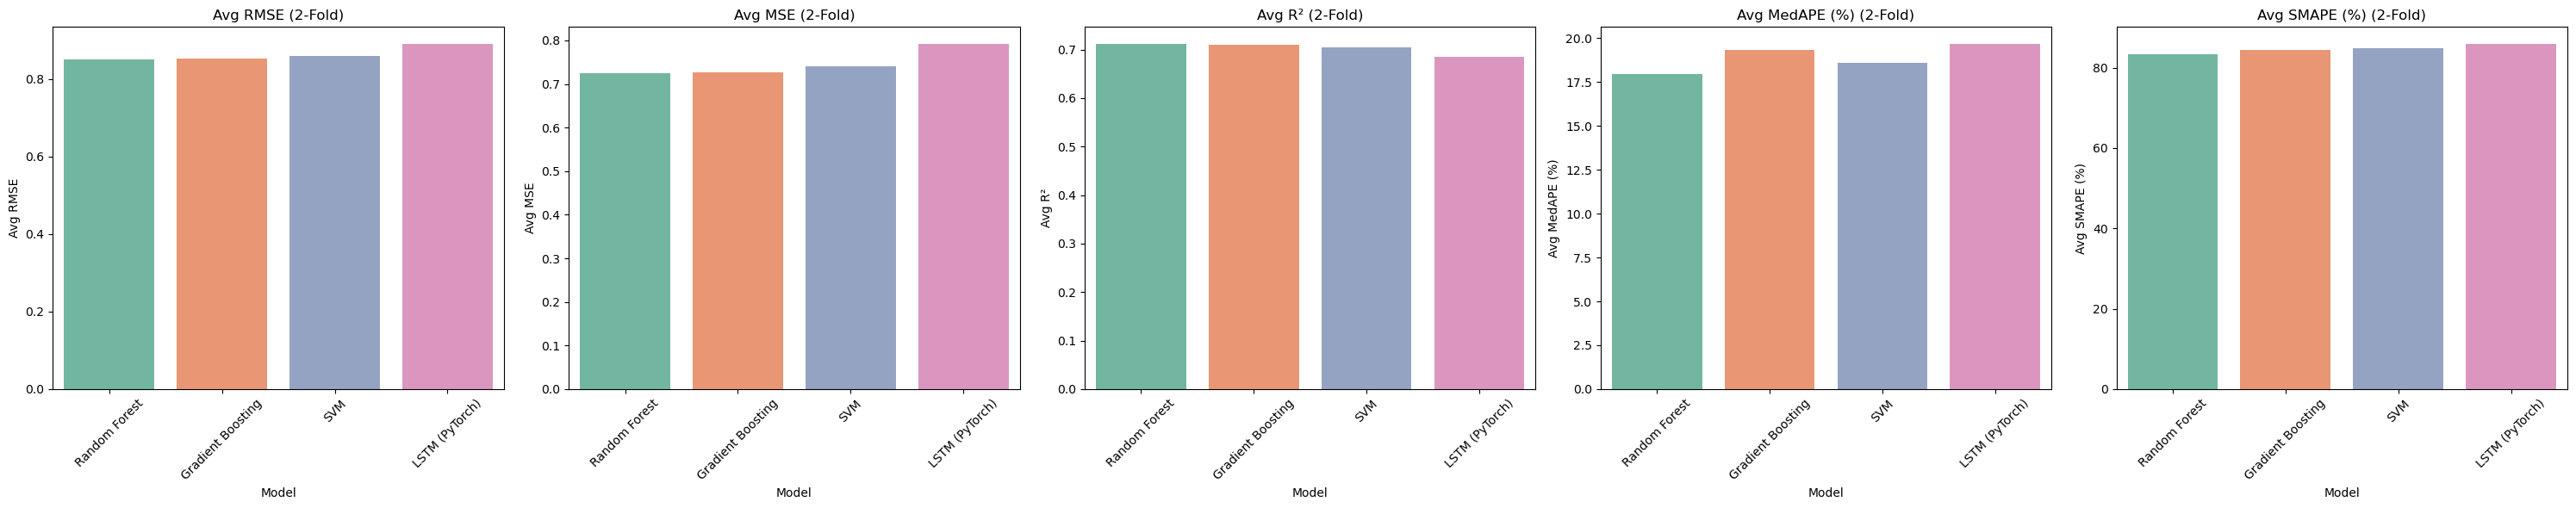


--- Evaluating Blind Set After 2-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8730 0.7621 0.7049     18.7240    84.2277
Gradient Boosting 0.8766 0.7685 0.7024     18.9597    84.2176
              SVM 0.8669 0.7516 0.7090     17.6902    83.6497
   LSTM (PyTorch) 0.9569 0.9157 0.6454     19.8928    87.0778


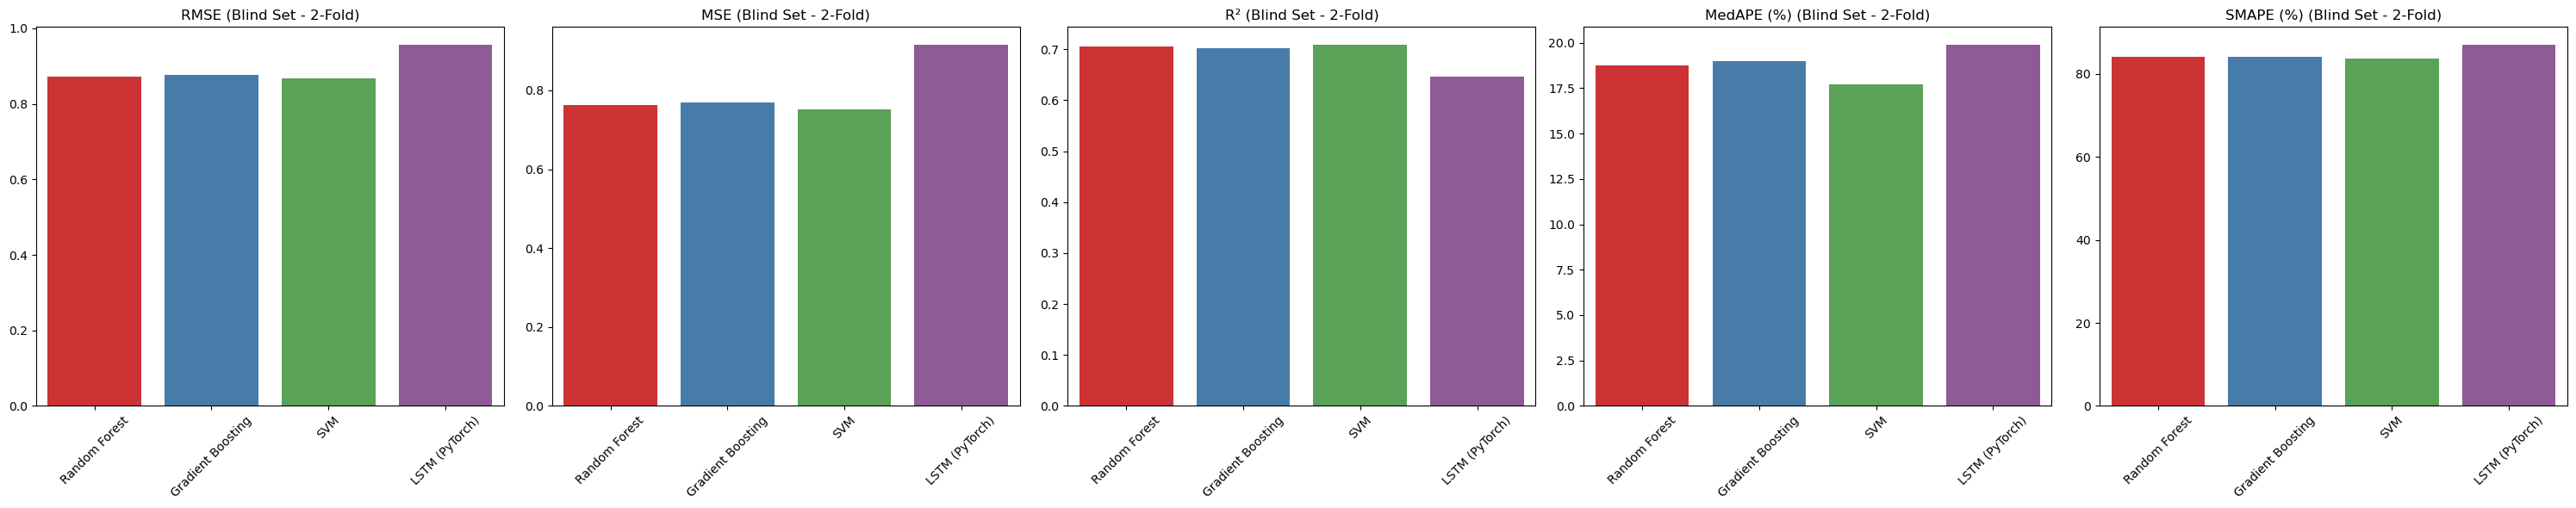


--- 3-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.8137   0.6627  0.7359         17.0504        80.5795
Gradient Boosting    0.8143   0.6640  0.7354         17.5325        82.0657
              SVM    0.8250   0.6816  0.7285         18.1769        82.8730
   LSTM (PyTorch)    0.8711   0.7589  0.6970         18.8863        84.4106


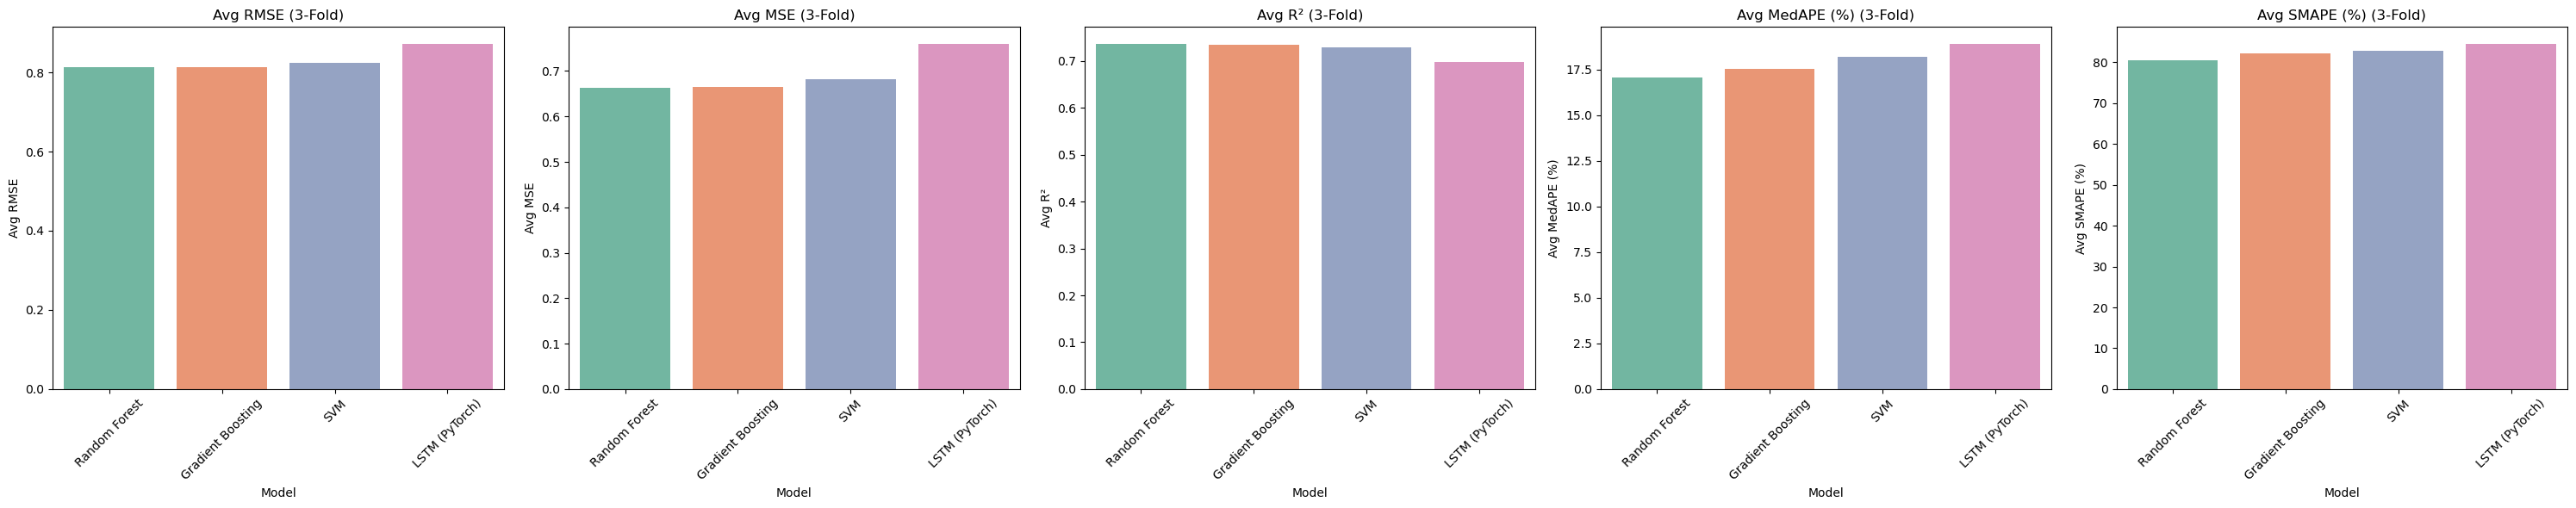


--- Evaluating Blind Set After 3-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8386 0.7032 0.7277     17.4101    80.2232
Gradient Boosting 0.8520 0.7260 0.7189     17.0870    81.5805
              SVM 0.8256 0.6816 0.7361     16.7889    80.4963
   LSTM (PyTorch) 0.8846 0.7826 0.6969     18.4272    80.5206


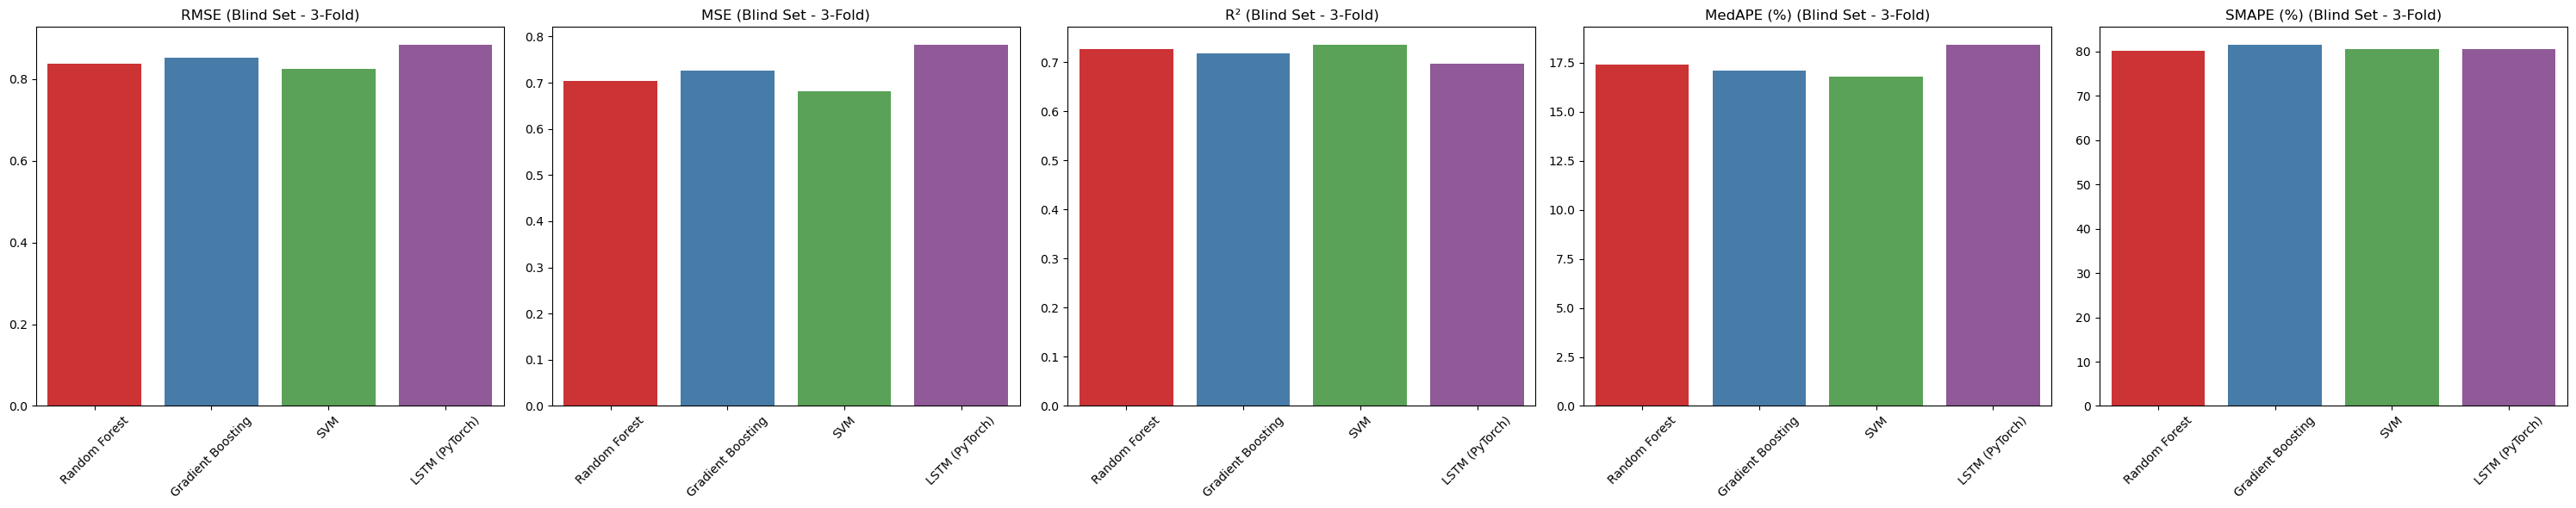


--- 4-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.8044   0.6479  0.7414         16.9085        80.4870
Gradient Boosting    0.8131   0.6619  0.7358         17.5495        81.8134
              SVM    0.8194   0.6722  0.7317         17.9651        82.5797
   LSTM (PyTorch)    0.8418   0.7090  0.7162         17.6983        82.0275


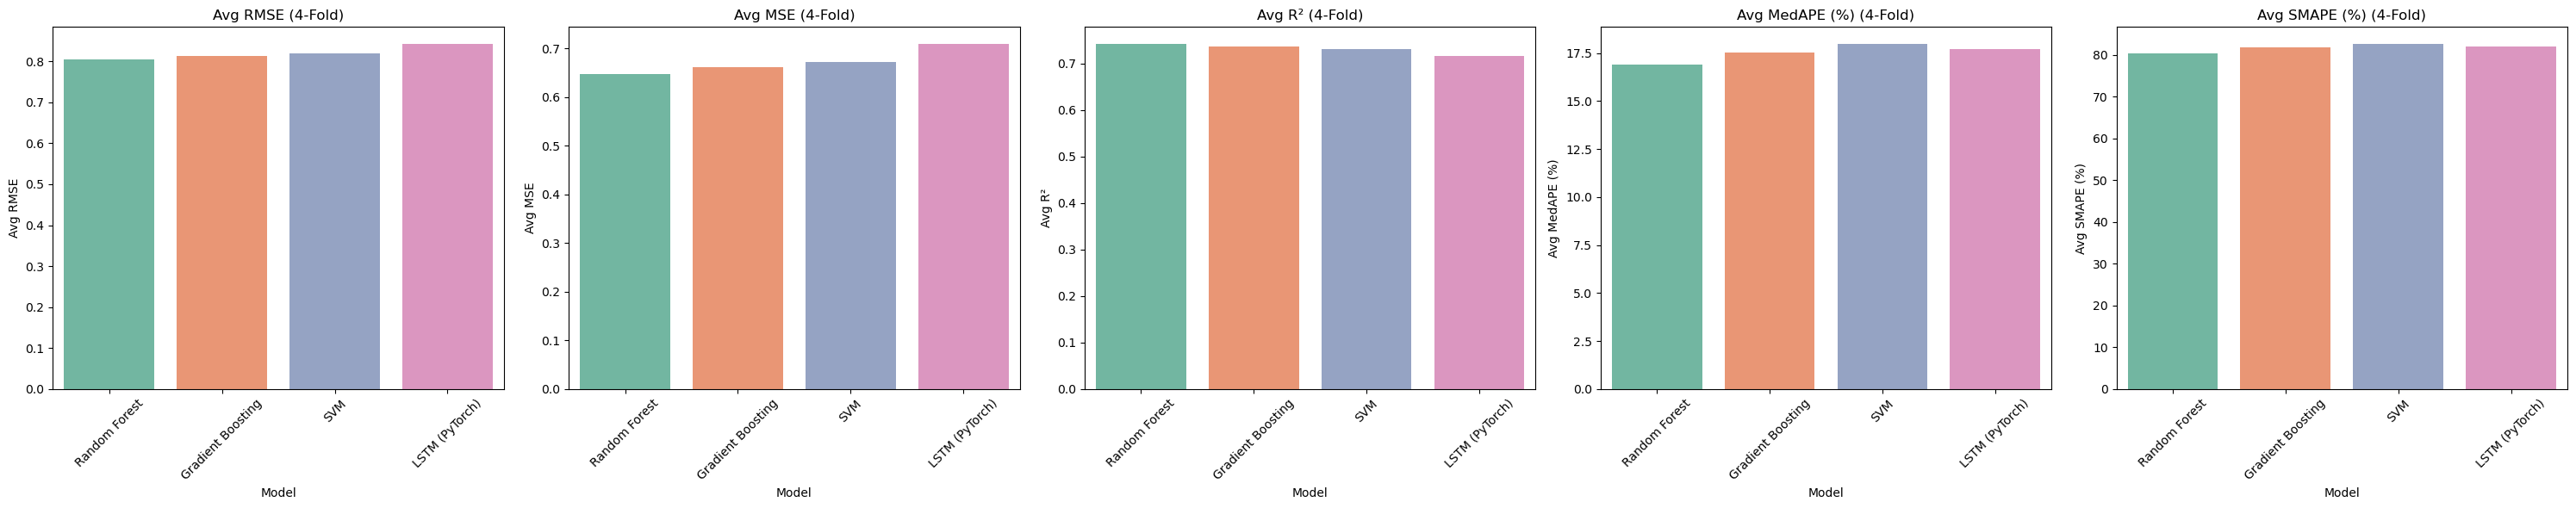


--- Evaluating Blind Set After 4-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8263 0.6828 0.7356     16.8877    78.9719
Gradient Boosting 0.8329 0.6938 0.7313     17.8203    80.7984
              SVM 0.8189 0.6706 0.7403     16.3375    79.5923
   LSTM (PyTorch) 0.8840 0.7815 0.6974     18.6283    81.1667


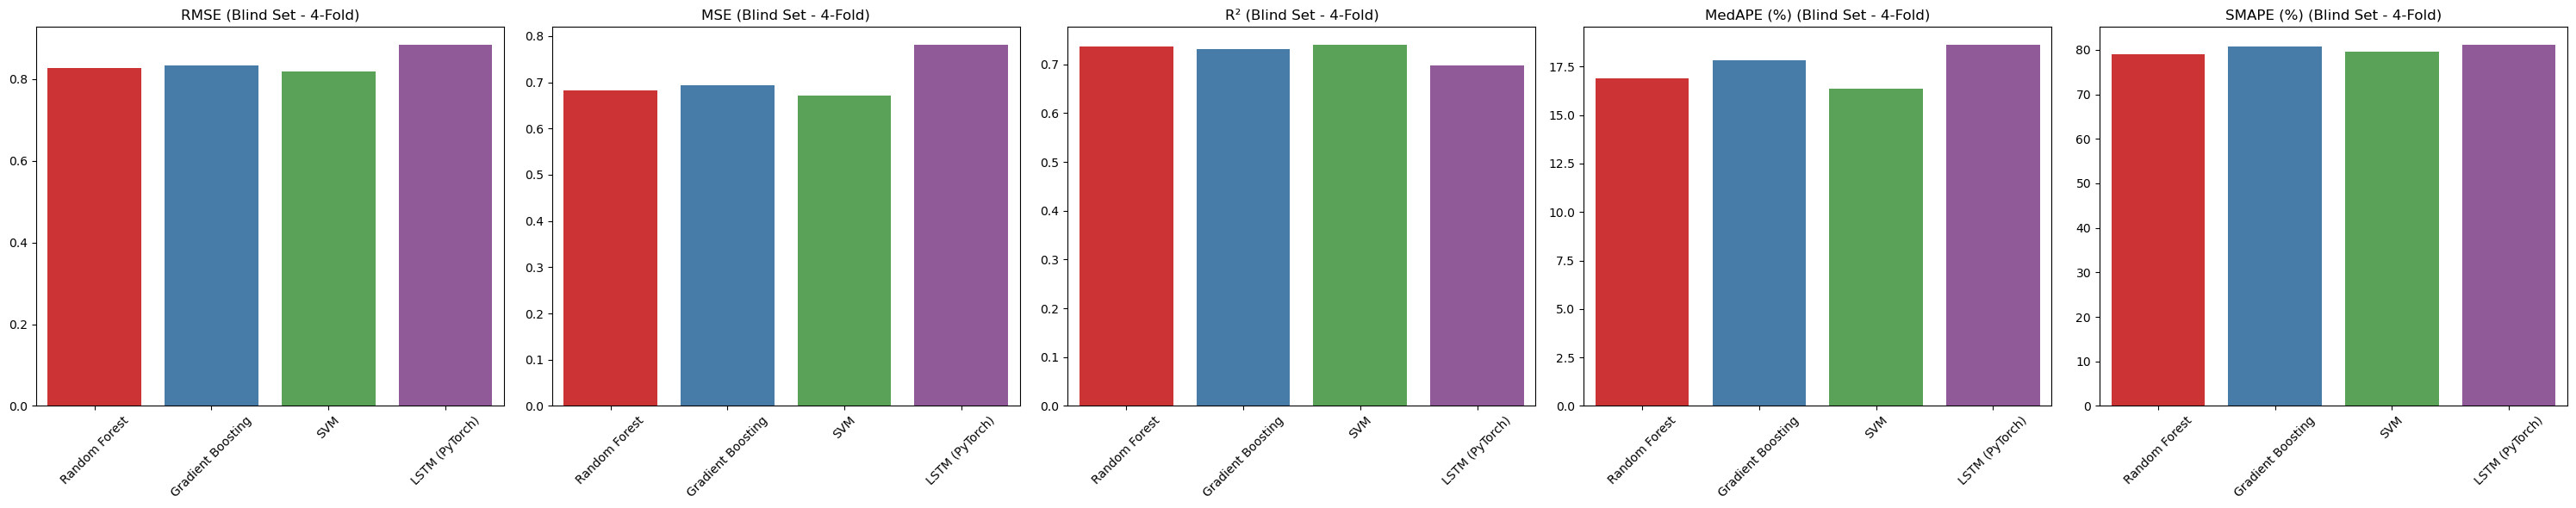


--- 5-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7994   0.6415  0.7438         16.6058        79.6129
Gradient Boosting    0.7946   0.6335  0.7467         17.4364        81.0315
              SVM    0.8092   0.6571  0.7376         17.5046        82.0490
   LSTM (PyTorch)    0.8338   0.6957  0.7218         17.7607        81.8287


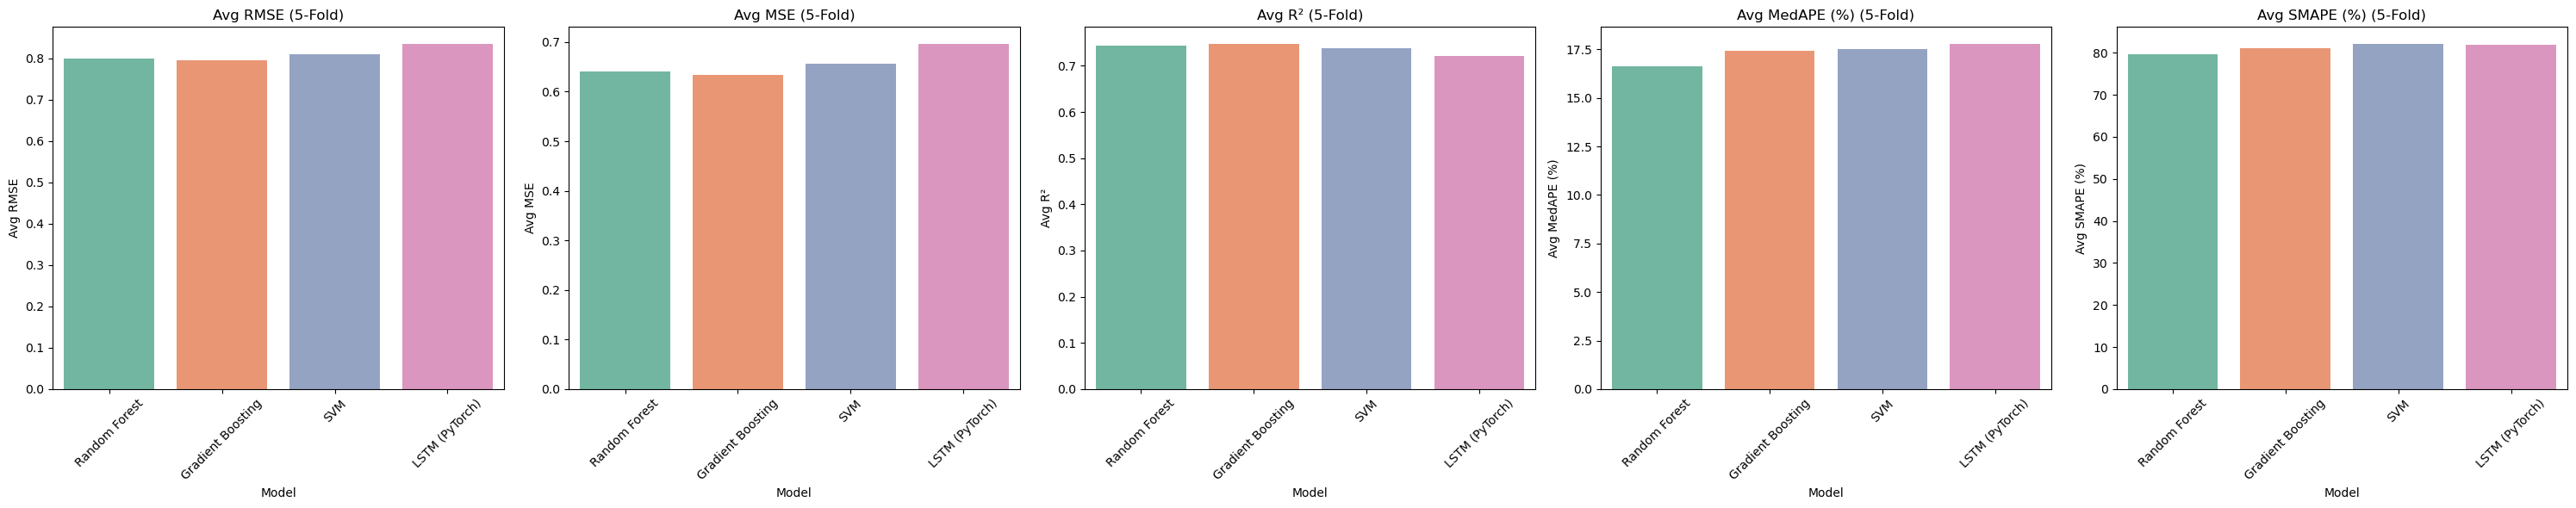


--- Evaluating Blind Set After 5-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8195 0.6716 0.7400     16.8672    78.4379
Gradient Boosting 0.8411 0.7074 0.7261     16.9818    79.3822
              SVM 0.8140 0.6626 0.7434     16.4415    79.1539
   LSTM (PyTorch) 0.8905 0.7931 0.6929     18.8551    83.1659


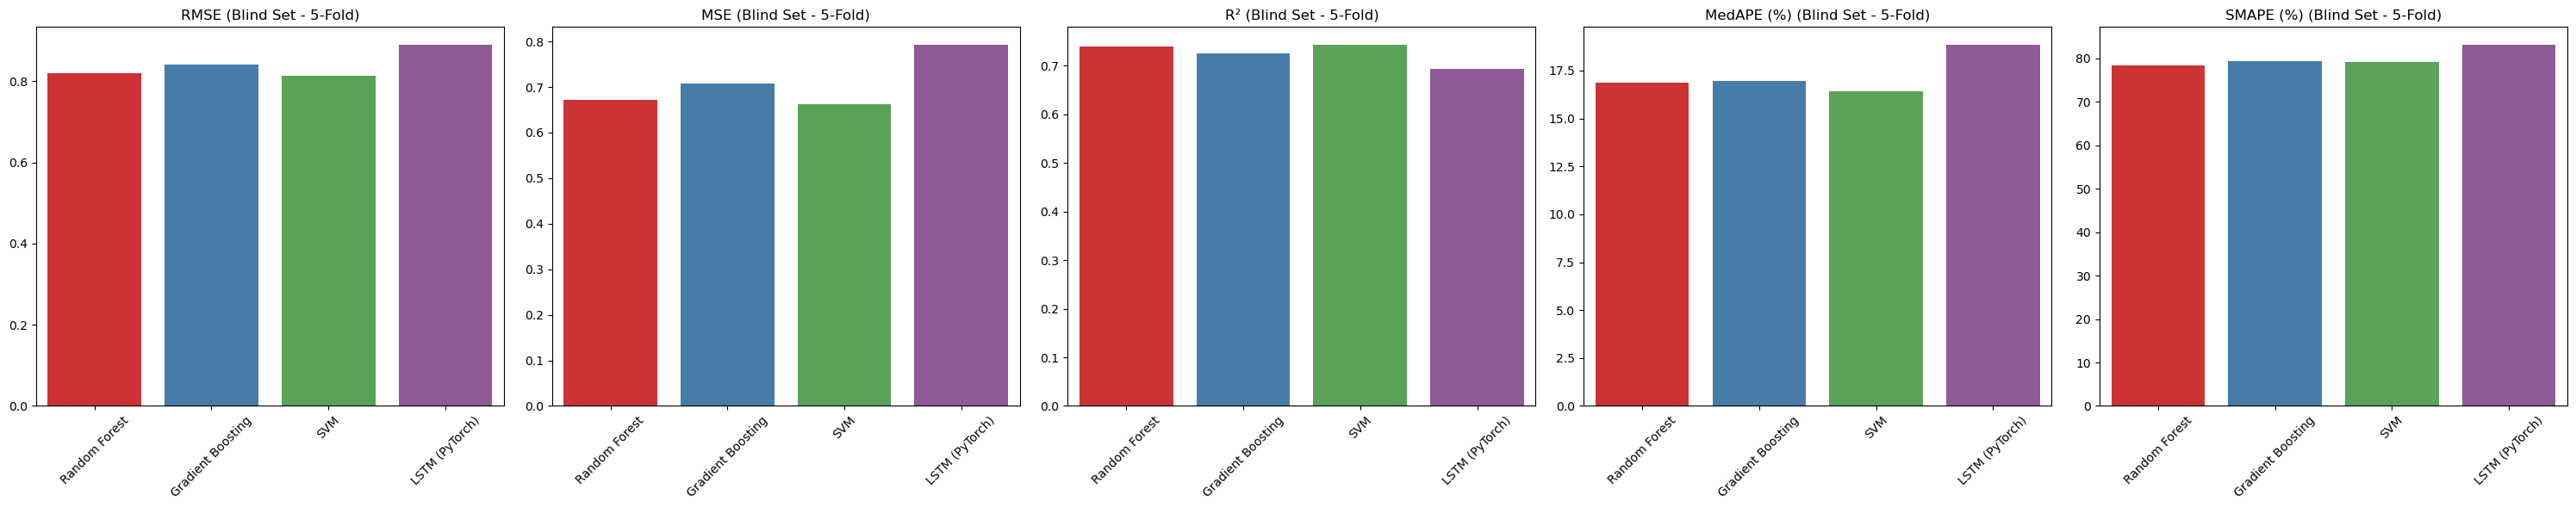


--- 6-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7945   0.6329  0.7474         16.8265        79.5653
Gradient Boosting    0.8044   0.6492  0.7410         17.4319        81.3851
              SVM    0.8056   0.6511  0.7400         17.3922        81.8520
   LSTM (PyTorch)    0.8416   0.7096  0.7158         17.6455        82.7010


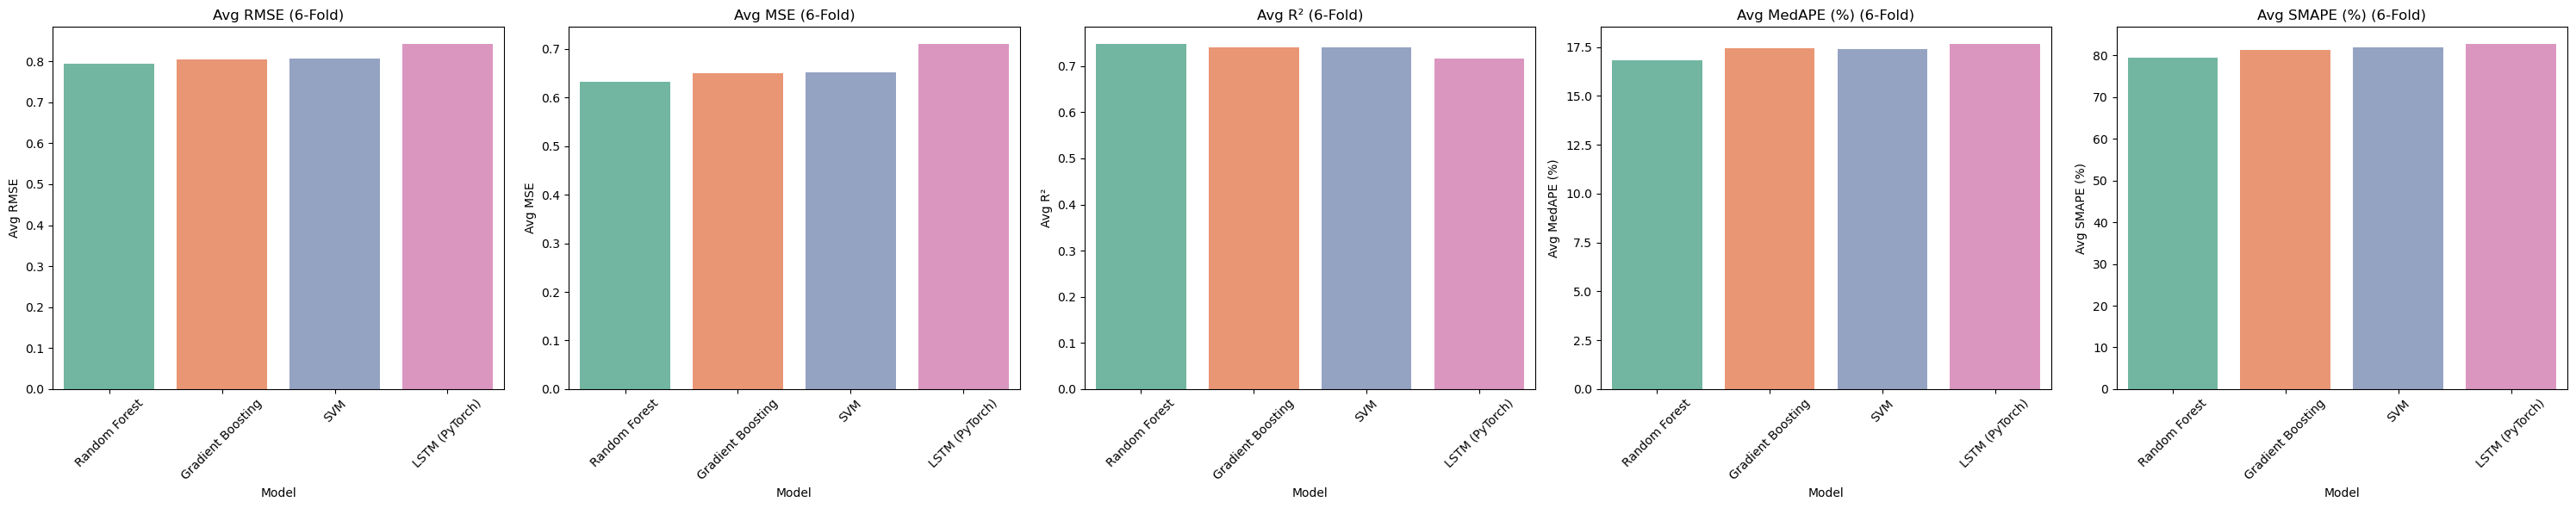


--- Evaluating Blind Set After 6-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8170 0.6675 0.7415     16.4331    77.6954
Gradient Boosting 0.8296 0.6882 0.7335     17.9441    81.0340
              SVM 0.8087 0.6540 0.7467     16.0969    78.8238
   LSTM (PyTorch) 0.8832 0.7801 0.6979     18.3897    82.6454


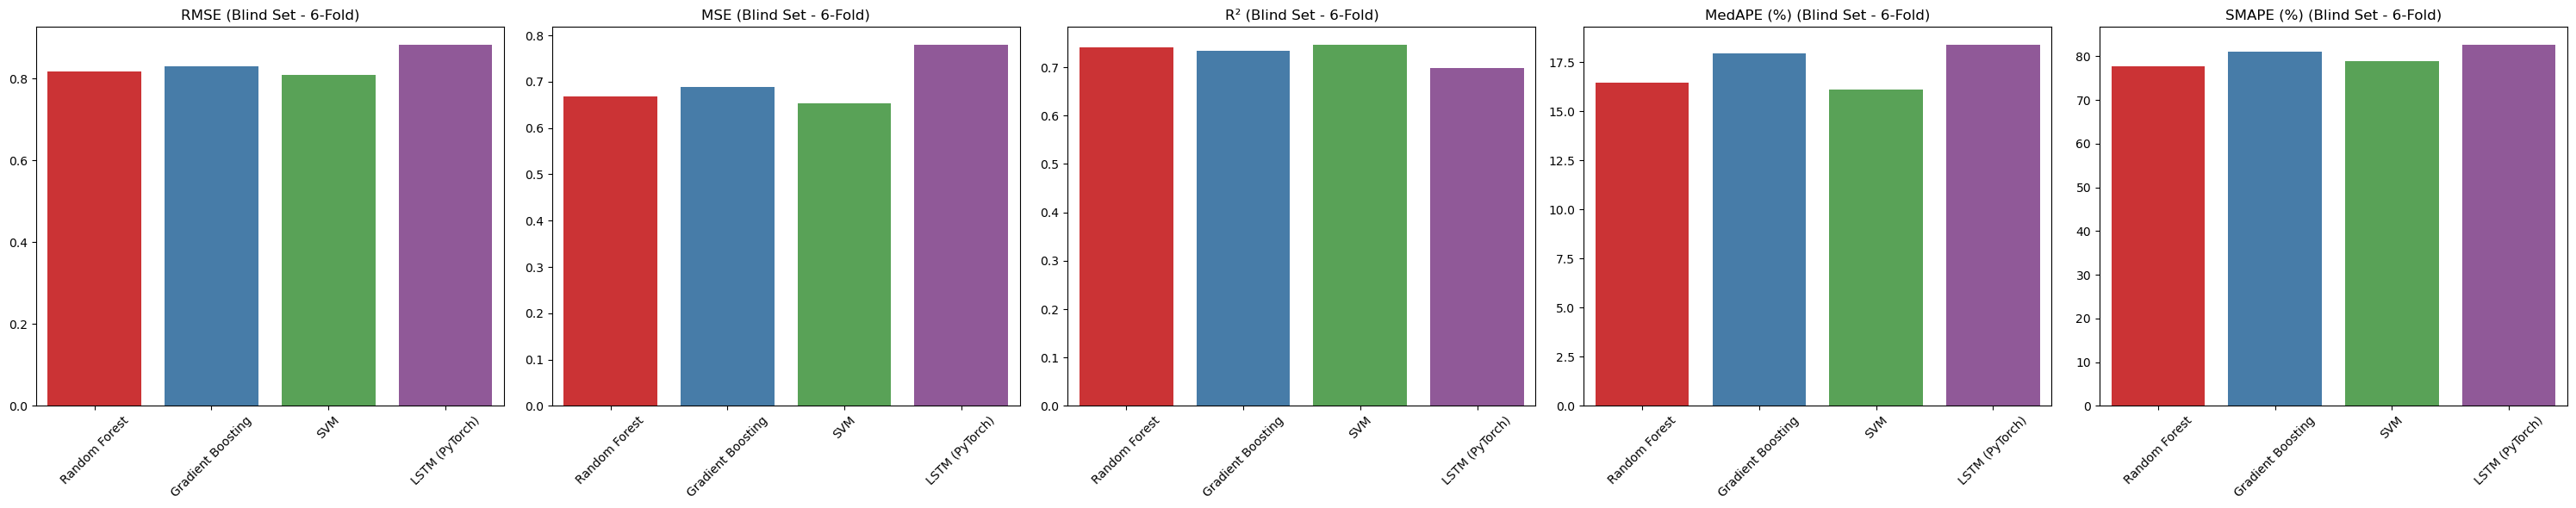


--- 7-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7946   0.6339  0.7460         16.3470        79.2097
Gradient Boosting    0.7998   0.6417  0.7426         16.9436        80.9946
              SVM    0.8039   0.6487  0.7395         17.1662        81.6090
   LSTM (PyTorch)    0.8222   0.6763  0.7278         16.9108        80.9146


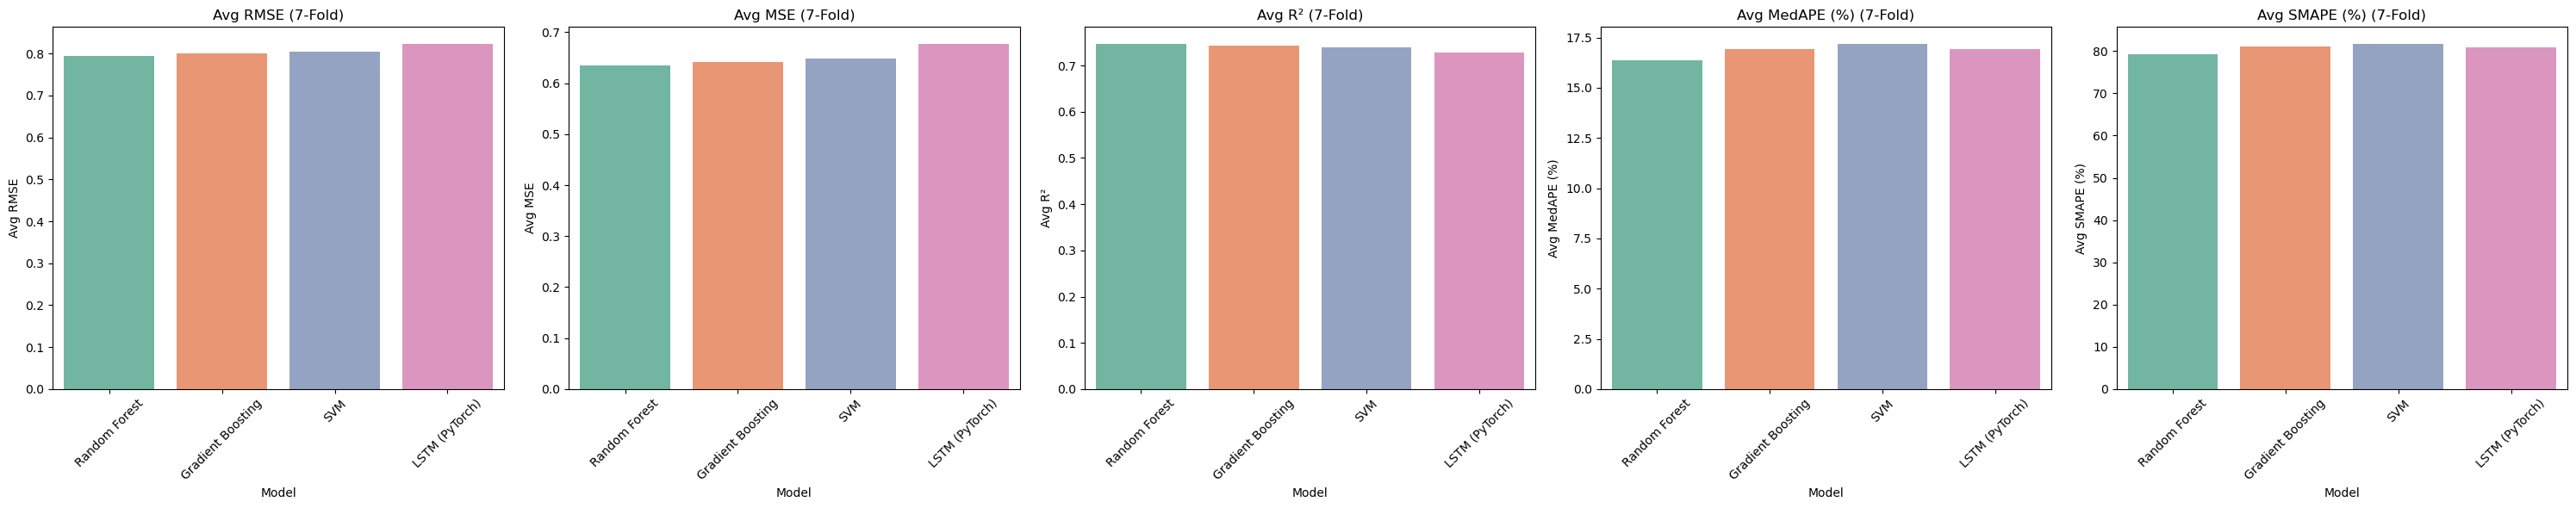


--- Evaluating Blind Set After 7-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8059 0.6495 0.7485     15.8206    77.2111
Gradient Boosting 0.8274 0.6846 0.7349     18.8968    80.7818
              SVM 0.8060 0.6496 0.7484     15.9965    78.9845
   LSTM (PyTorch) 0.8808 0.7757 0.6996     18.2042    81.7837


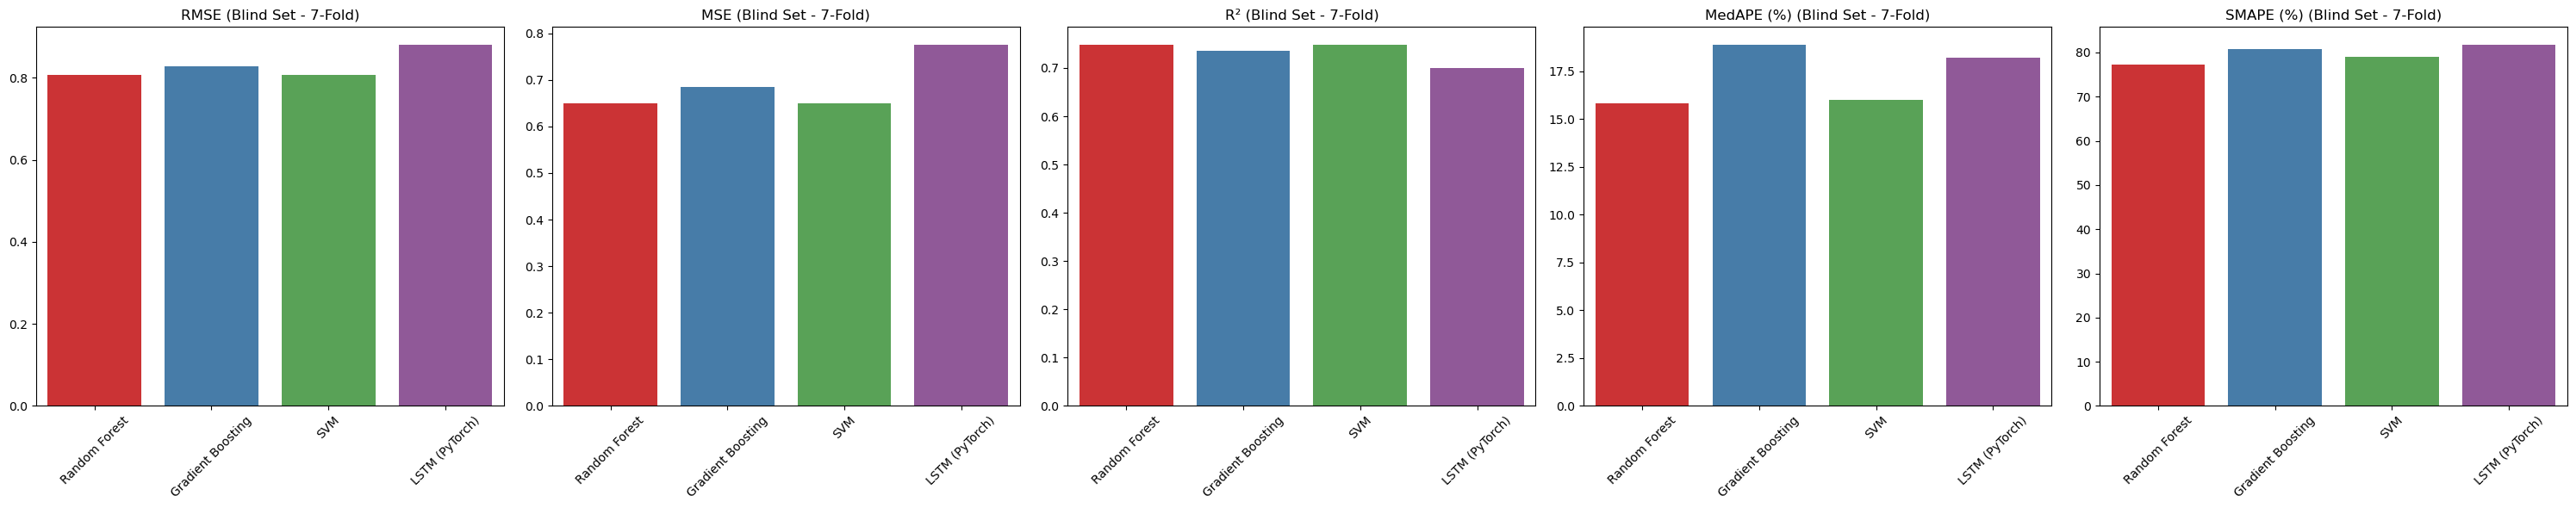


--- 8-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7907   0.6272  0.7487         16.0637        78.9184
Gradient Boosting    0.7961   0.6357  0.7449         17.0644        80.3324
              SVM    0.8025   0.6464  0.7403         17.4287        81.6472
   LSTM (PyTorch)    0.8353   0.6988  0.7186         17.0027        82.0261


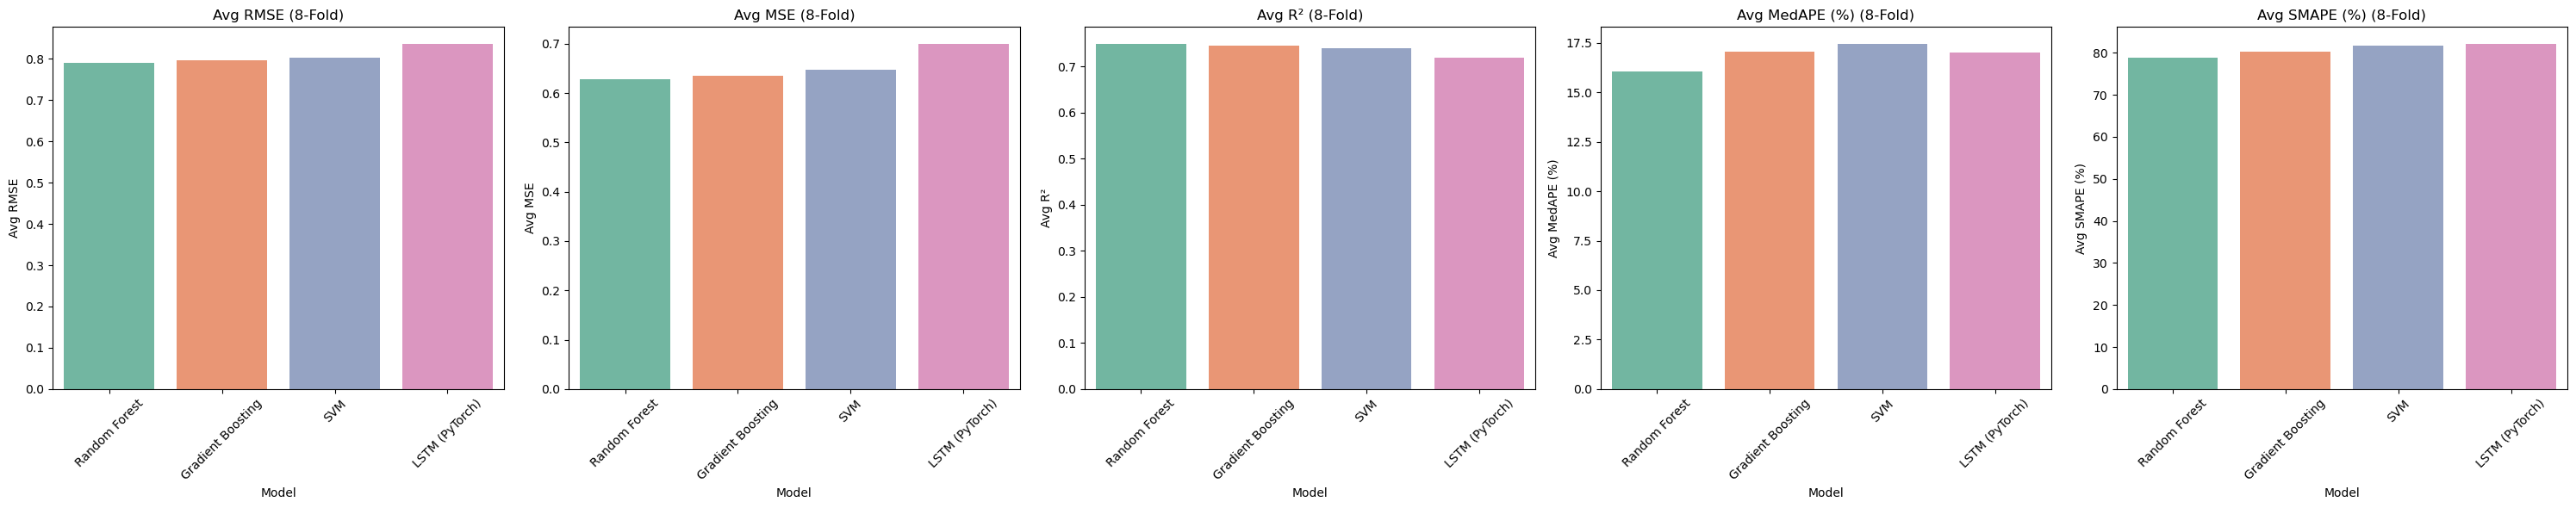


--- Evaluating Blind Set After 8-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8082 0.6532 0.7471     16.5399    78.1717
Gradient Boosting 0.8166 0.6668 0.7418     17.5269    79.4840
              SVM 0.8039 0.6463 0.7497     16.2436    78.8541
   LSTM (PyTorch) 0.8315 0.6915 0.7322     18.1958    81.6388


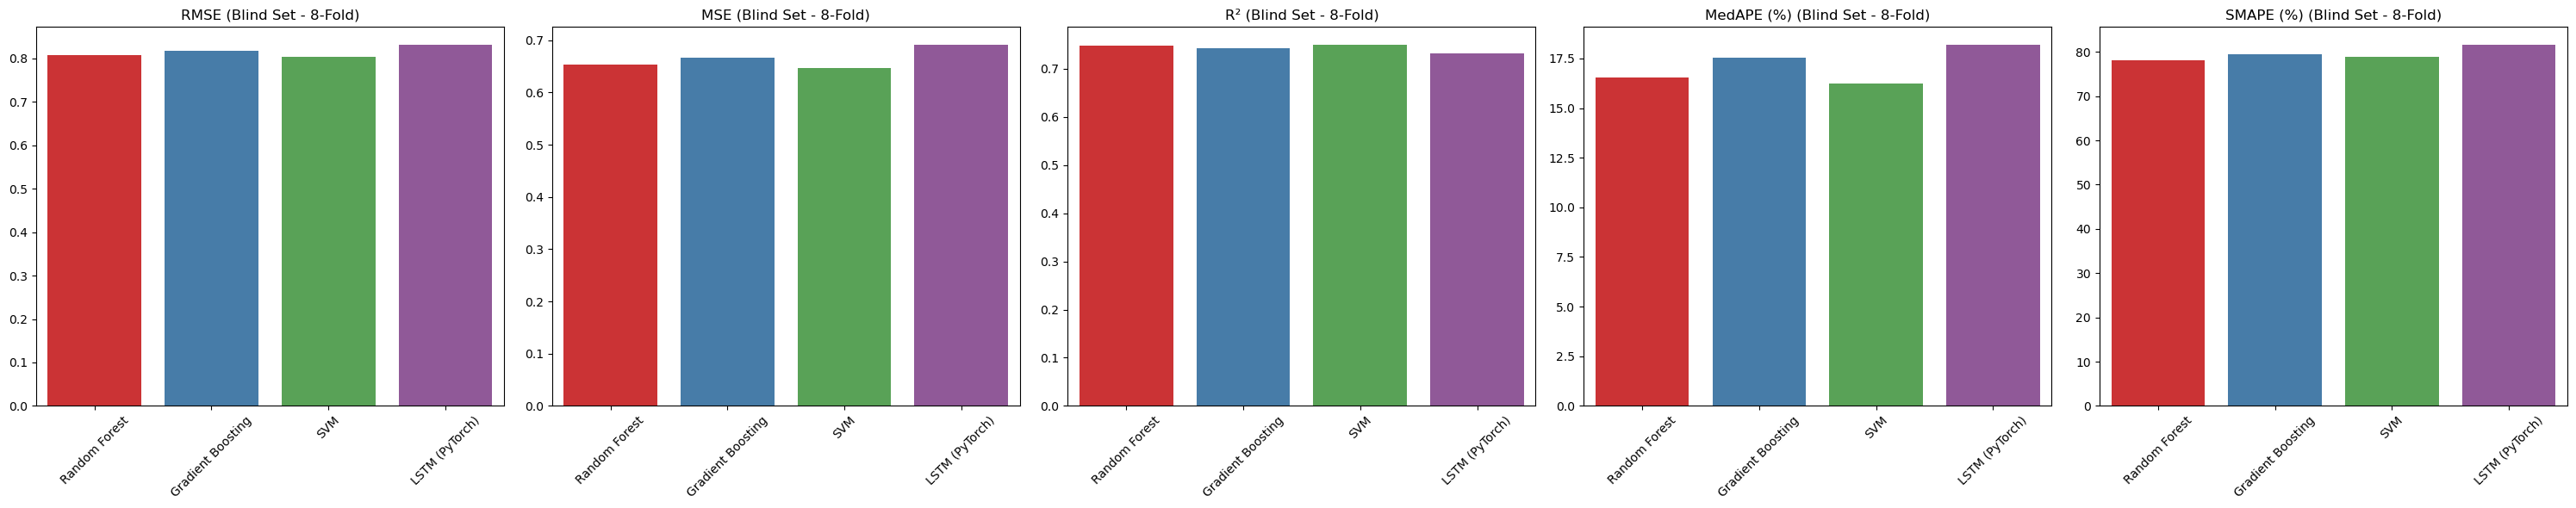


--- 9-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7966   0.6372  0.7454         16.3645        79.3389
Gradient Boosting    0.7932   0.6314  0.7472         17.3816        81.3334
              SVM    0.8002   0.6427  0.7428         17.2345        81.4064
   LSTM (PyTorch)    0.8407   0.7078  0.7160         17.6891        82.1518


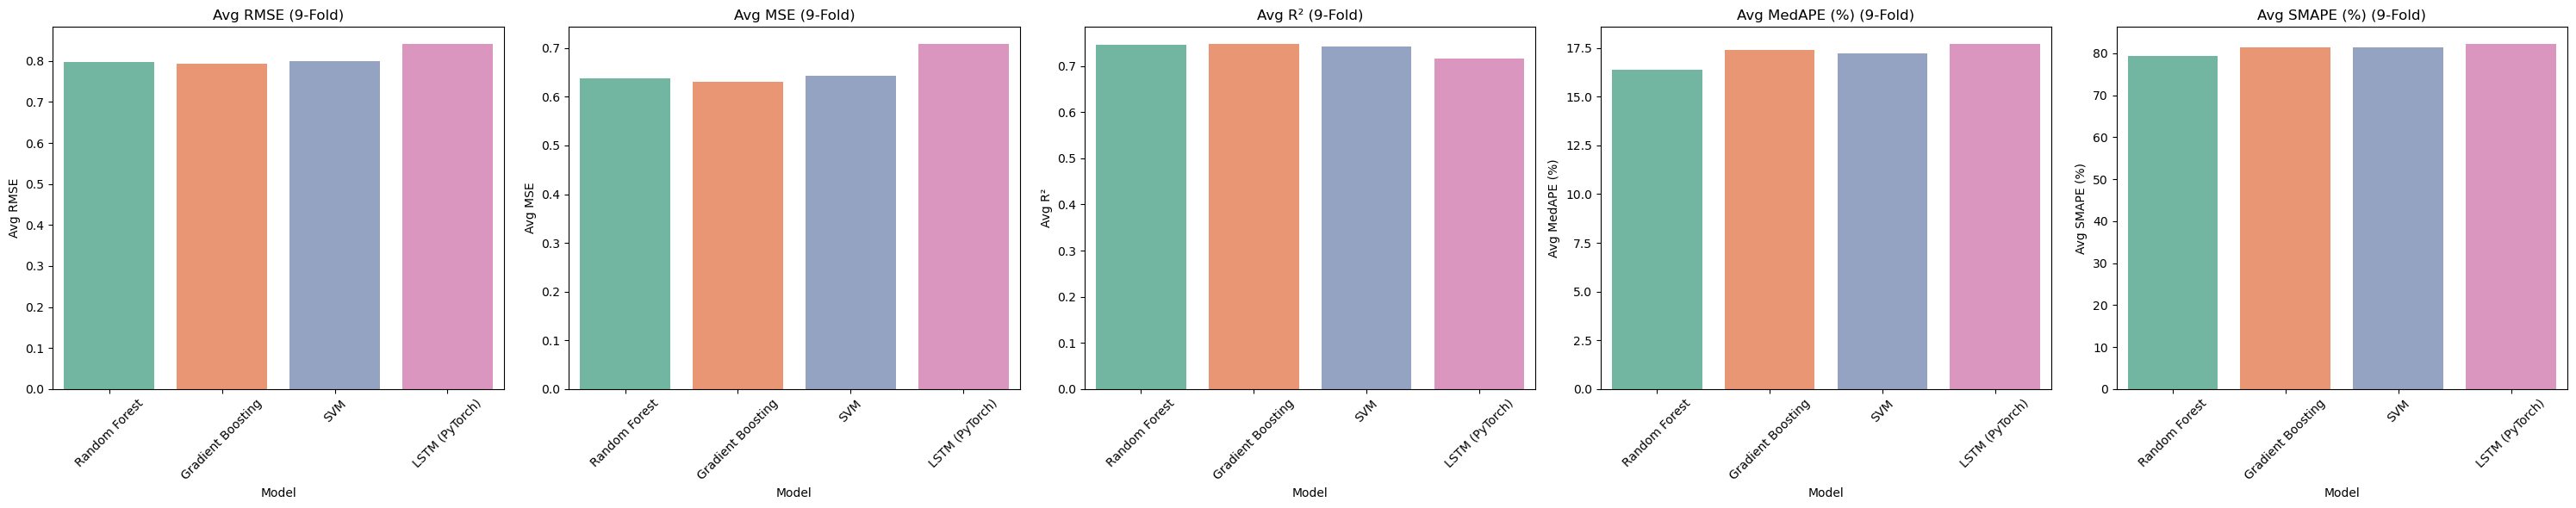


--- Evaluating Blind Set After 9-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8096 0.6555 0.7462     16.6125    77.8286
Gradient Boosting 0.8296 0.6882 0.7335     18.2068    80.1138
              SVM 0.8031 0.6450 0.7503     16.2288    78.7813
   LSTM (PyTorch) 0.8428 0.7104 0.7249     17.6260    80.5237


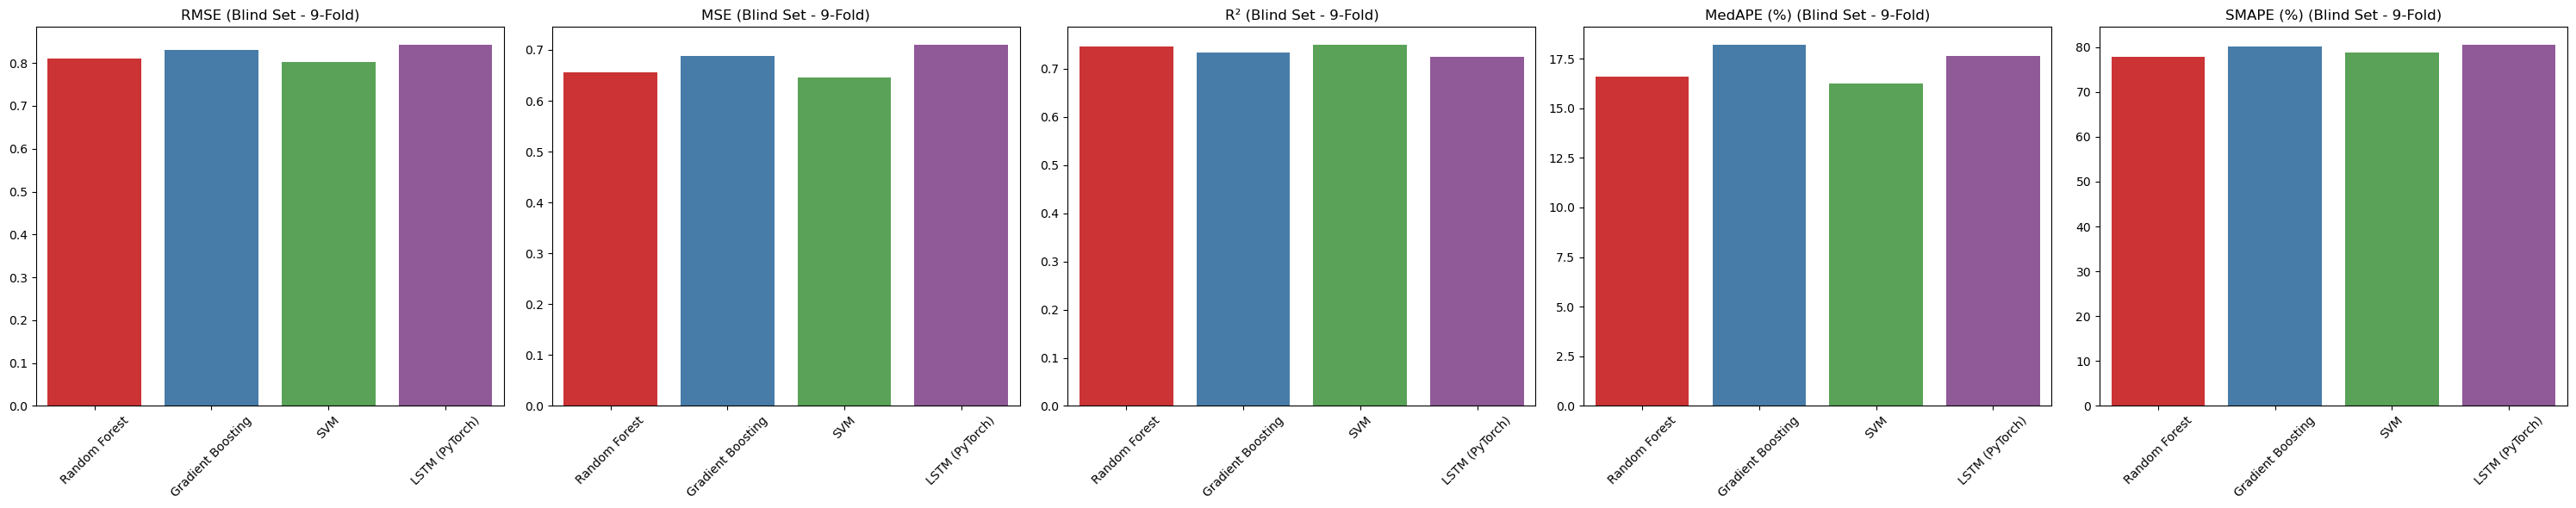


--- 10-Fold Cross Validation ---

Average Cross-Validation Performance:
            Model  Avg RMSE  Avg MSE  Avg R²  Avg MedAPE (%)  Avg SMAPE (%)
    Random Forest    0.7878   0.6236  0.7501         15.9826        78.6798
Gradient Boosting    0.7911   0.6291  0.7475         16.7672        80.3359
              SVM    0.7968   0.6373  0.7441         17.2957        81.6198
   LSTM (PyTorch)    0.8185   0.6715  0.7299         17.1095        80.9563


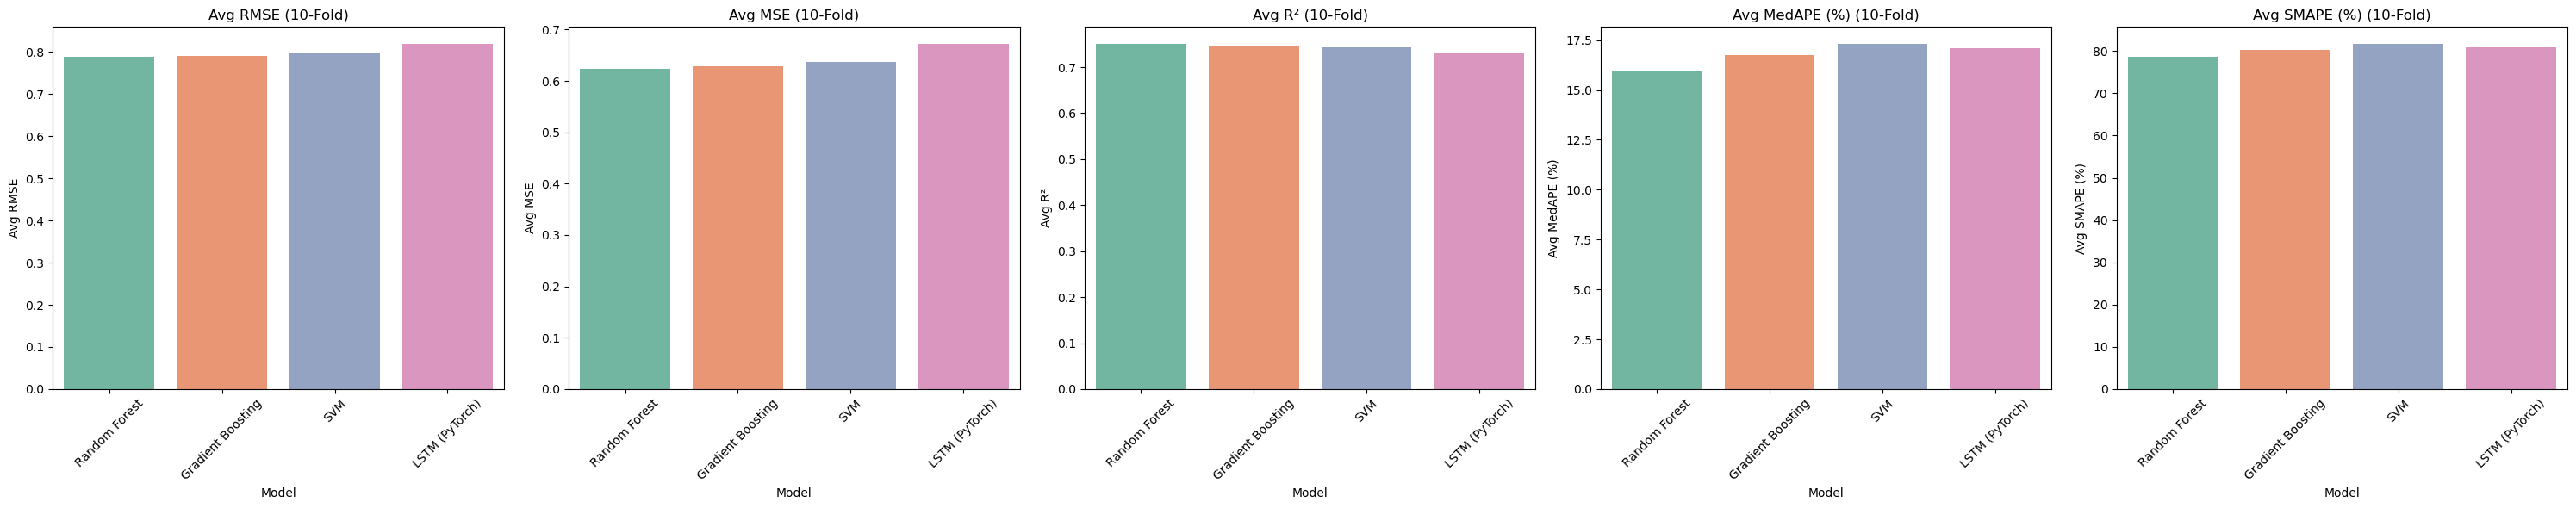


--- Evaluating Blind Set After 10-Fold ---
            Model   RMSE    MSE     R²  MedAPE (%)  SMAPE (%)
    Random Forest 0.8044 0.6470 0.7494     16.6074    77.3725
Gradient Boosting 0.8180 0.6691 0.7409     18.8911    80.1414
              SVM 0.7998 0.6397 0.7523     15.9673    78.4854
   LSTM (PyTorch) 0.8675 0.7525 0.7086     17.7688    81.6895


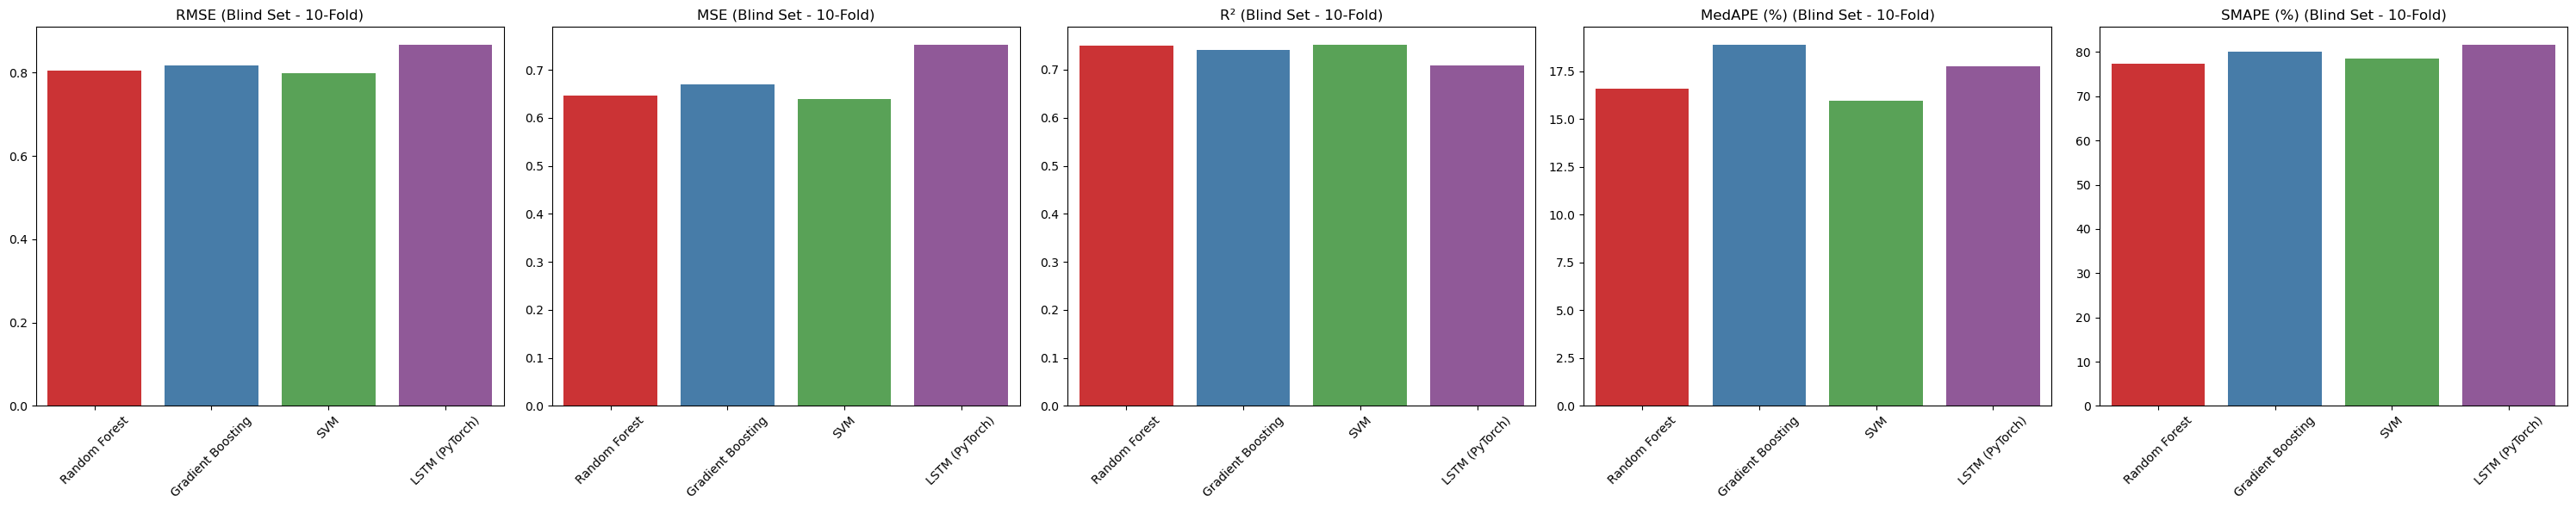

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

# === Metrics ===
def medape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true > epsilon
    return np.median(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.sum(mask) else np.nan

def smape(y_true, y_pred, epsilon=1e-3):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denominator = np.where(denominator < epsilon, epsilon, denominator)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# === LSTM ===
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, activation='relu'):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.activation = {'relu': nn.ReLU(), 'tanh': nn.Tanh(), 'sigmoid': nn.Sigmoid(), 'leaky_relu': nn.LeakyReLU()}.get(activation)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        return self.fc(self.activation(out)) if self.activation else self.fc(out)

def train_model(model, train_loader, val_loader, epochs=200, patience=20, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss, best_state, patience_counter = float('inf'), None, 0

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss = np.mean([criterion(model(xb), yb).item() for xb, yb in val_loader])
        if val_loss < best_loss:
            best_loss, best_state = val_loss, model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return model





# === Parameters ===
drop_cols = [
    'chembl_id', 'ic50_value', 'log_ic50', 
    'target_chembl_id', 'target_name', 'Name'
]
metrics = ['RMSE', 'MSE', 'R²', 'MedAPE', 'SMAPE']

# === Prepare Training Set ===
y = padel_train['log_ic50']

# Drop unnecessary columns, clean, and impute missing values
X = (
    padel_train
    .drop(columns=[col for col in drop_cols if col in padel_train.columns])
    .replace(r'^\s*$', np.nan, regex=True)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(lambda df: df.mean())
)

# Feature selection based on variance
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)

print(f"Training set shape (features): {X_selected.shape}, Target shape: {y.shape}")

# === Prepare Blind Set ===
X_blind = (
    padel_blind
    .drop(columns=[col for col in drop_cols if col in padel_blind.columns])
    .replace(r'^\s*$', np.nan, regex=True)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(lambda df: df.mean())
)

# Apply the same feature selector
X_blind_selected = selector.transform(X_blind)

print(f"Blind set shape (features): {X_blind_selected.shape}")


# === Models ===
models = {
    'Random Forest': RandomForestRegressor(**rf_best_params),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, random_state=42),
    'SVM': SVR(),
    'LSTM (PyTorch)': None  # will instantiate per fold
}

# === Cross-validation and Blind Evaluation ===
for k in range(2, 11):
    print(f"\n--- {k}-Fold Cross Validation ---")
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    scores = {metric: {m: [] for m in models} for metric in metrics}

    for train_idx, test_idx in kf.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Classic models
        for name, model in models.items():
            if name == 'LSTM (PyTorch)':
                continue
            model.fit(X_train_scaled, y_train)
            y_pred = np.maximum(model.predict(X_test_scaled), 0)
            scores['RMSE'][name].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            scores['MSE'][name].append(mean_squared_error(y_test, y_pred))
            scores['R²'][name].append(r2_score(y_test, y_pred))
            scores['MedAPE'][name].append(medape(y_test, y_pred))
            scores['SMAPE'][name].append(smape(np.expm1(y_test), np.expm1(y_pred)))

        # LSTM
        X_train_seq = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
        X_test_seq = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

        train_tensor = torch.tensor(X_train_seq, dtype=torch.float32)
        test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

        train_ds, val_ds = random_split(TensorDataset(train_tensor, y_train_tensor), [int(0.8*len(train_tensor)), len(train_tensor) - int(0.8*len(train_tensor))])
        train_loader = DataLoader(train_ds, batch_size=lstm_best_params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=lstm_best_params['batch_size'])

        lstm = LSTMRegressor(
            input_size=train_tensor.shape[2],
            hidden_size=lstm_best_params['hidden_size'],
            num_layers=lstm_best_params['num_layers'],
            activation=lstm_best_params['activation']
        )
        lstm = train_model(lstm, train_loader, val_loader, lr=lstm_best_params['learning_rate'])
        lstm.eval()
        with torch.no_grad():
            y_pred_lstm = torch.clamp(lstm(test_tensor), min=0).squeeze().numpy()

        scores['RMSE']['LSTM (PyTorch)'].append(np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
        scores['MSE']['LSTM (PyTorch)'].append(mean_squared_error(y_test, y_pred_lstm))
        scores['R²']['LSTM (PyTorch)'].append(r2_score(y_test, y_pred_lstm))
        scores['MedAPE']['LSTM (PyTorch)'].append(medape(y_test, y_pred_lstm))
        scores['SMAPE']['LSTM (PyTorch)'].append(smape(np.expm1(y_test), np.expm1(y_pred_lstm)))

    # === Fold-wise Average Report ===
    print("\nAverage Cross-Validation Performance:")
    perf_df = pd.DataFrame({
        'Model': list(models.keys()),
        'Avg RMSE': [np.mean(scores['RMSE'][m]) for m in models],
        'Avg MSE': [np.mean(scores['MSE'][m]) for m in models],
        'Avg R²': [np.mean(scores['R²'][m]) for m in models],
        'Avg MedAPE (%)': [np.mean(scores['MedAPE'][m]) for m in models],
        'Avg SMAPE (%)': [np.mean(scores['SMAPE'][m]) for m in models]
    })
    print(perf_df.to_string(index=False, float_format="%.4f"))

    # === Plot ===
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(perf_df.columns[1:]):
        sns.barplot(data=perf_df, x='Model', y=metric, ax=axes[i], palette='Set2')
        axes[i].set_title(f"{metric} ({k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()

    # === Blind Set Evaluation ===
    print(f"\n--- Evaluating Blind Set After {k}-Fold ---")
    X_blind_scaled = scaler.transform(X_blind_selected)
    blind_metrics = {metric: {} for metric in metrics}

    for name, model in models.items():
        if name == 'LSTM (PyTorch)':
            X_blind_seq = X_blind_scaled.reshape(-1, 1, X_blind_scaled.shape[1])
            X_blind_tensor = torch.tensor(X_blind_seq, dtype=torch.float32)
            lstm.eval()
            with torch.no_grad():
                y_blind_pred = torch.clamp(lstm(X_blind_tensor), min=0).squeeze().numpy()
        else:
            y_blind_pred = np.maximum(model.predict(X_blind_scaled), 0)

        blind_metrics['RMSE'][name] = np.sqrt(mean_squared_error(padel_blind['log_ic50'], y_blind_pred))
        blind_metrics['MSE'][name] = mean_squared_error(padel_blind['log_ic50'], y_blind_pred)
        blind_metrics['R²'][name] = r2_score(padel_blind['log_ic50'], y_blind_pred)
        blind_metrics['MedAPE'][name] = medape(padel_blind['log_ic50'], y_blind_pred)
        blind_metrics['SMAPE'][name] = smape(np.expm1(padel_blind['log_ic50']), np.expm1(y_blind_pred))

    blind_df = pd.DataFrame({
        'Model': list(models.keys()),
        'RMSE': [blind_metrics['RMSE'][m] for m in models],
        'MSE': [blind_metrics['MSE'][m] for m in models],
        'R²': [blind_metrics['R²'][m] for m in models],
        'MedAPE (%)': [blind_metrics['MedAPE'][m] for m in models],
        'SMAPE (%)': [blind_metrics['SMAPE'][m] for m in models],
    })
    print(blind_df.to_string(index=False, float_format="%.4f"))
    # === Blind Set Performance Plot ===
    fig, axes = plt.subplots(1, 5, figsize=(30, 6))
    for i, metric in enumerate(blind_df.columns[1:]):  # Skip 'Model'
        sns.barplot(data=blind_df, x='Model', y=metric, ax=axes[i], palette='Set1')
        axes[i].set_title(f"{metric} (Blind Set - {k}-Fold)")
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('')
    plt.tight_layout()
    plt.show()


Original features: 1875, After selection: 1356
Average R²:  0.7490
Average MSE: 0.6264


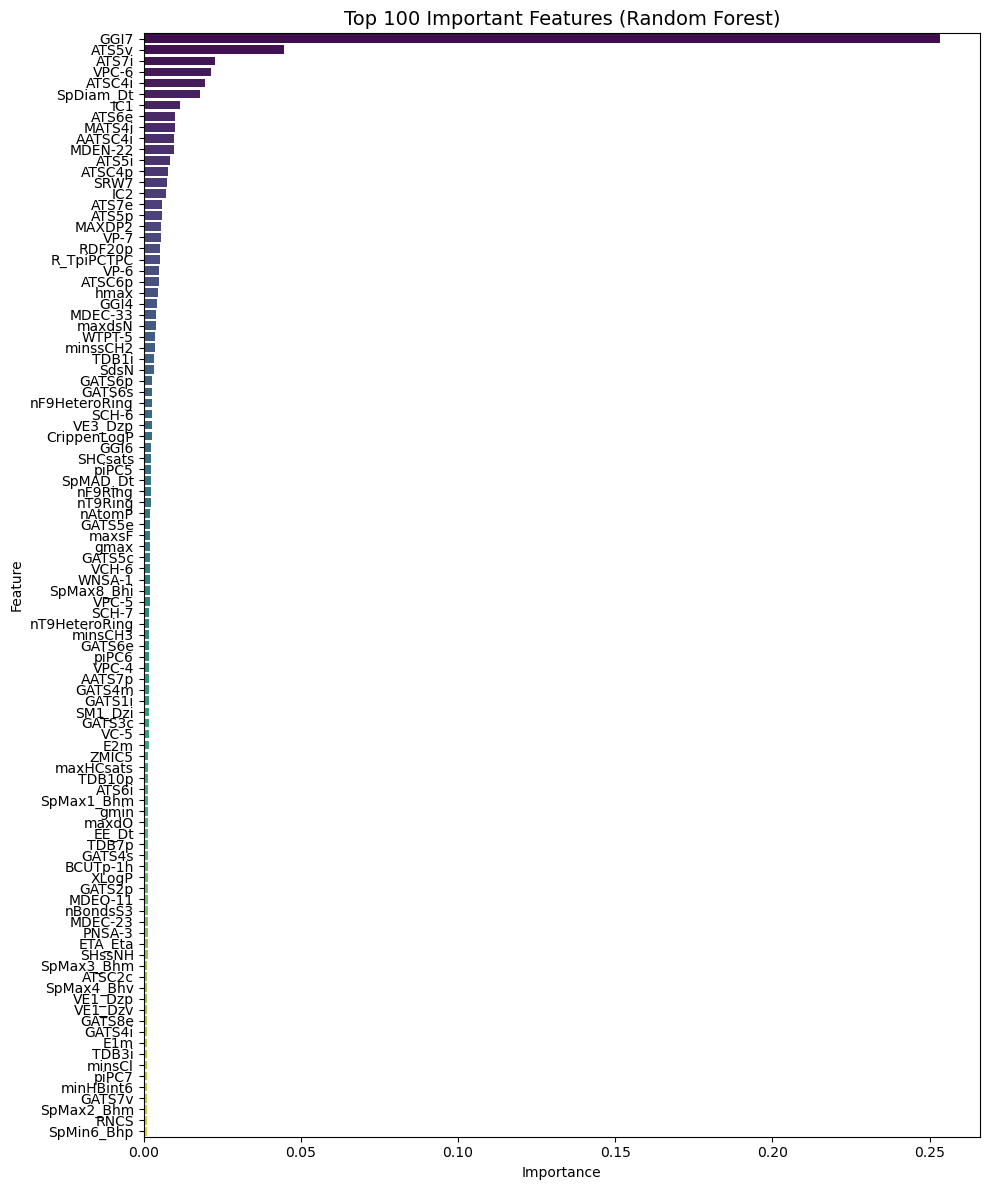

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# ==================================
# 1. Define drop columns
# ==================================
drop_cols = ['chembl_id', 'ic50_value', 'log_ic50',
             'target_chembl_id', 'target_name', 'Name']

# ==================================
# 2. Prepare training data
# ==================================
y = padel_train['log_ic50']
X = padel_train.drop(columns=[col for col in drop_cols if col in padel_train.columns])

# Clean: remove empty strings → NaN → numeric → fill NaN with column mean
X = X.replace(r'^\s*$', np.nan, regex=True).apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())

# ==================================
# 3. Feature selection (low variance)
# ==================================
selector = VarianceThreshold(threshold=0.01)
X_selected = pd.DataFrame(
    selector.fit_transform(X),
    columns=X.columns[selector.get_support()],
    index=X.index
)
print(f"Original features: {X.shape[1]}, After selection: {X_selected.shape[1]}")

# ==================================
# 4. Standard scaling
# ==================================
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_selected),
    columns=X_selected.columns,
    index=X_selected.index
)

# ==================================
# 5. Random Forest with 10-Fold CV
# ==================================
kf = KFold(n_splits=10, shuffle=True, random_state=42)
r2_scores, mse_scores = [], []

for train_idx, test_idx in kf.split(X_scaled):
    X_train, X_test = X_scaled.iloc[train_idx], X_scaled.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2_scores.append(r2_score(y_test, y_pred))
    mse_scores.append(mean_squared_error(y_test, y_pred))

print(f"Average R²:  {np.mean(r2_scores):.4f}")
print(f"Average MSE: {np.mean(mse_scores):.4f}")

# ==================================
# 6. Feature importance
# ==================================
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_scaled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

top_n = 100
top_features = feature_importance_df.head(top_n)

# ==================================
# 7. Plot feature importance
# ==================================
plt.figure(figsize=(10, 12))
sns.barplot(x='Importance', y='Feature', data=top_features, palette='viridis')
plt.title(f"Top {top_n} Important Features (Random Forest)", fontsize=14)
plt.tight_layout()
plt.show()



In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold

# === Parameters ===
drop_cols = [
    'chembl_id', 'ic50_value', 'log_ic50',
    'target_chembl_id', 'target_name', 'Name'
]
output_plot_path = "/Users/janat/Desktop/ppimic50pred/Padel_important_features_correlation.png"
n_splits = 5  # CV folds

# === Prepare Training Set ===
y = padel_train['log_ic50']
X = (
    padel_train
    .drop(columns=[col for col in drop_cols if col in padel_train.columns])
    .replace(r'^\s*$', np.nan, regex=True)
    .apply(pd.to_numeric, errors='coerce')
    .fillna(lambda df: df.mean())
)

# === Remove low-variance features ===
selector = VarianceThreshold(threshold=0.01)
X_var = selector.fit_transform(X)
selected_cols = X.columns[selector.get_support()]
print(f"Training set after variance filter: {X_var.shape}, Target shape: {y.shape}")

# === Cross-validation for Feature Importance ===
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
feature_importances = np.zeros(len(selected_cols))

for fold, (train_idx, val_idx) in enumerate(kf.split(X_var)):
    X_train, y_train = X_var[train_idx], y.iloc[train_idx]
    
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    
    feature_importances += rf.feature_importances_

# Average importances across folds
feature_importances /= n_splits
importances = pd.Series(feature_importances, index=selected_cols)

# === Filter features with importance > 0.00 ===
important_features = importances[importances > 0.00].sort_values(ascending=False)
print(f"Selected {len(important_features)} features with importance > 0.00")

# === Correlation Heatmap of Important Features ===
X_imp = X[important_features.index]
corr_matrix = X_imp.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=False, cmap='coolwarm',
    cbar_kws={'label': 'Correlation'}
)
plt.title("Correlation Heatmap of Important Features", fontsize=14)
plt.tight_layout()

# Save plot
plt.savefig(output_plot_path, dpi=300)
plt.close()

print(f"Correlation heatmap saved to: {output_plot_path}")


Training set after variance filter: (2340, 1356), Target shape: (2340,)
Selected 1354 features with importance > 0.00
Correlation heatmap saved to: /Users/janat/Desktop/ppimic50pred/Padel_important_features_correlation.png
